## The idea here is to get well versed with time series data to understand demand forecasting in SCM and learn about Prophet

Before diving into the data, lets look at some basic definitions

### What is demand forecasting ? 

It is a prcoess used by businesses and organizations to estimate the future demand for their products or services. 
    It involves analyzing historical sales data, market trends, economic indicators, and other relevant factors to make predictions about future customer demand.
    The goal is to optimize resources such as inventory, production and work force to avoid stockouts or excess inventory. 
    
The key points invlove:
- Data Analysis : Since it relies on historical data and information about past sales, customer behavioour etc. 
- Forecasting Methods: Moving avergaes(7D, 28D), exponential smoothening, regression analysis, time series analysis, 
- Time Horions: short term (weekly/monthly) or long terms(years)
- Market Factors: Changes in consumer preferences, economic conditions, technologial advancements etc.
- Business Decision Making - Critical in areas such as production planning, inventory management, marjketig strategies, and resoure allocation
- Uncertainty: Unexpected events like natural disasters, sudden shifts in the market, can impact actual demand and lead to deviations from forecasted values.
- Continuous Process: Needs regular update to adapt to changing market condition and improve forecasting accuracy.


### What is Facebook Prophet ?


Facebook prophet is an open source forecasting tool developed by Facebook's core Data Science team. It is designed to provide an easy to use yet powerful framework for forecasting future values based on historical time series data.

The key points involve:

- Automatic Seasonality Detection: It is capable of automatically detecting and modelling multiple seasonalities(daily, weekly, yearly) present in the time series data. 
- Customizable holidays: Users can specify custom holidays or events that might impact time series. Prophet allows incorporating these holiays into the forecasting model to improve accuracy during holiday periods.
- Trend Component Modeling: Prophet uses a flexible additive model that accounts for trend changes over time. It can handle various types of growth patterns, making it suitable for data with both linear and non-linear trends.
- Handling missing data: Prophet can handle missing data and outliers in the time series without requiring imputation or data processing.
- Uncertainty Estimation: The model provides uncertainty intervals around forecasted values, allowing users to understand the potential range of future outcomes.
- Scalability: Prophet is designed to handle large datasets and can work efficiently with high vloume of time series data


Using prophet tyically involves follwing steps:
- Data Preparation: Prepare the historical time series data in a specific format with a datetime column and the corresponding value column
- Model Fitting: Utilize the prophet library to fit the model to the historical data
- Forecasting: Generate future forecasts by specifying the desired number of periods into the future
- Visualitaion: visualize the historical data, fitted model and forecasted values to analyze the results

In [336]:
import numpy as np
import pandas as pd
import pandasql as ps
import math
import itertools 
from scipy import stats
import time

#matplotlib libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors
import seaborn as sns

#date libraries
from dateutil import parser
from datetime import datetime, timedelta, date
import holidays

#prophet library
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation

#pandas options
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#matplotlib setting defaults
sns.set(font="Arial",
        rc={
 "axes.axisbelow": False,
 "axes.edgecolor": "lightgrey",
 "axes.facecolor": "None",
 "axes.grid": False,
 "axes.labelcolor": "dimgrey",
 "axes.spines.right": False,
 "axes.spines.top": False,
 "figure.facecolor": "white",
 "lines.solid_capstyle": "round",
 "patch.edgecolor": "w",
 "patch.force_edgecolor": True,
 "text.color": "dimgrey",
 "xtick.bottom": False,
 "xtick.color": "dimgrey",
 "xtick.direction": "out",
 "xtick.top": False,
 "ytick.color": "dimgrey",
 "ytick.direction": "out",
 "ytick.left": False,
 "ytick.right": False})

In [219]:
def missing_data(input_data):
    '''
    This function returns dataframe with information about the percentage of nulls in each column
    
    input: pandas df
    output: pandas df
    
    '''
    
    total = input_data.isnull().sum()
    percent = (input_data.isnull().sum()/ input_data.isnull().count() *100)
    table = pd.concat([total, percent], axis=1, keys = ['Total','Percent'])
    types = []
    
    for col in input_data.columns:
        dtype = str(input_data[col].dtype)
        types.append(dtype)
    table["Types"] =types
    return(pd.DataFrame(table))



def mape(actual, pred):
    ''' 
    
    Mean Absolute Percentage Error (MAPE) function
    
    input: list/series for actual and predicted values
    output: mape value
    '''
    
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) /actual)) * 100
    

## Reading in Data

Sales dataset from kaggle from Favorita stores in Ecuador (ref:  https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data?select=train.csv)

About the data:
    
    The data is picked from Kaggle and consist of thousand of product families sold at a store in Ecuador

In [220]:
# read the data
df = pd.read_csv('train.csv')

In [221]:
# shoes the no.of rows and cols
df.shape # shoes hugh dataset

(3000888, 6)

In [222]:
df.head()

id        date  store_nbr      family  sales  onpromotion
0   0  2013-01-01          1  AUTOMOTIVE   0.00            0
1   1  2013-01-01          1   BABY CARE   0.00            0
2   2  2013-01-01          1      BEAUTY   0.00            0
3   3  2013-01-01          1   BEVERAGES   0.00            0
4   4  2013-01-01          1       BOOKS   0.00            0

In [223]:
# converting to datetime format
df['date'] = pd.to_datetime(df['date'],format="%Y/%m/%d")

In [224]:
# identifying the date range for the data in hand
min(df['date']), max(df['date'])

(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-08-15 00:00:00'))

In [225]:
# since we have lot of data at day level, lets aggregate as per day, per family and get the sum
agg_df = df.groupby(['date','family']).agg({'sales':'sum'}).reset_index().sort_values(['family','date'])

In [226]:
agg_df.head()

date      family  sales
0   2013-01-01  AUTOMOTIVE   0.00
33  2013-01-02  AUTOMOTIVE 255.00
66  2013-01-03  AUTOMOTIVE 161.00
99  2013-01-04  AUTOMOTIVE 169.00
132 2013-01-05  AUTOMOTIVE 342.00

In [227]:
agg_df.shape

(55572, 3)

In [228]:
# Creating a pivot of data at day level to understand the sales
total_sales_df = agg_df.pivot(index='date',columns='family', values ='sales')
total_sales_df.head()

family      AUTOMOTIVE  BABY CARE  BEAUTY  BEVERAGES  BOOKS  BREAD/BAKERY  \
date                                                                        
2013-01-01        0.00       0.00    2.00     810.00   0.00        180.59   
2013-01-02      255.00       0.00  207.00   72092.00   0.00      26246.32   
2013-01-03      161.00       0.00  125.00   52105.00   0.00      18456.48   
2013-01-04      169.00       0.00  133.00   54167.00   0.00      16721.97   
2013-01-05      342.00       0.00  191.00   77818.00   0.00      22367.76   

family      CELEBRATION  CLEANING    DAIRY     DELI     EGGS  FROZEN FOODS  \
date                                                                         
2013-01-01         0.00    186.00   143.00    71.09    46.00         29.65   
2013-01-02         0.00  74629.00 23381.00 15754.50 10932.00       7115.39   
2013-01-03         0.00  55893.00 18001.00 11172.45  7358.00       4760.81   
2013-01-04         0.00  52064.00 18148.00 10143.21  6760.00       4525.93   
2013-01-05         0.00  70128.00 23082.00 13734.95  8576.00       5781.61   

family      GROCERY I  GROCERY II  HARDWARE  HOME AND KITCHEN I  \
date                                                              
2013-01-01     700.00       15.00      0.00                0.00   
2013-01-02  202020.00     1476.00     46.00                0.00   
2013-01-03  144878.00     1048.00     37.00                0.00   
2013-01-04  135754.00     1031.00     57.00                0.00   
2013-01-05  188356.00     1273.00     87.00                0.00   

family      HOME AND KITCHEN II  HOME APPLIANCES  HOME CARE  LADIESWEAR  \
date                                                                      
2013-01-01                 0.00             0.00       0.00        0.00   
2013-01-02                 0.00            21.00       0.00        0.00   
2013-01-03                 0.00            15.00       0.00        0.00   
2013-01-04                 0.00            13.00       0.00        0.00   
2013-01-05                 0.00            11.00       0.00        0.00   

family      LAWN AND GARDEN  LINGERIE  LIQUOR,WINE,BEER  MAGAZINES    MEATS  \
date                                                                          
2013-01-01             2.00      5.00            105.00       0.00   110.80   
2013-01-02           121.00    469.00           2411.00       0.00 20871.46   
2013-01-03            83.00    366.00           2476.00       0.00 16597.40   
2013-01-04           127.00    382.00           4796.00       0.00 21625.96   
2013-01-05           180.00    458.00           6715.00       0.00 20879.09   

family      PERSONAL CARE  PET SUPPLIES  PLAYERS AND ELECTRONICS  POULTRY  \
date                                                                        
2013-01-01          25.00          0.00                     0.00    42.64   
2013-01-02       17204.00          0.00                     0.00 13975.88   
2013-01-03       12568.00          0.00                     0.00 10674.39   
2013-01-04       11303.00          0.00                     0.00 10772.52   
2013-01-05       16819.00          0.00                     0.00 13475.01   

family      PREPARED FOODS  PRODUCE  SCHOOL AND OFFICE SUPPLIES  SEAFOOD  
date                                                                      
2013-01-01           37.85     0.00                        0.00     0.00  
2013-01-02         5338.11     0.00                        0.00  1526.75  
2013-01-03         3591.39     0.00                        0.00  1094.31  
2013-01-04         4472.97     0.00                        0.00  1293.12  
2013-01-05         5830.07     0.00                        0.00  1245.64

In [229]:
total_sales_df.shape

(1684, 33)

In [230]:
df['family'].nunique()

33

If we plot the entire data, we have in hand it become so difficult to understand as we have a lot of products(family here) and the volume of data varies wrt the product

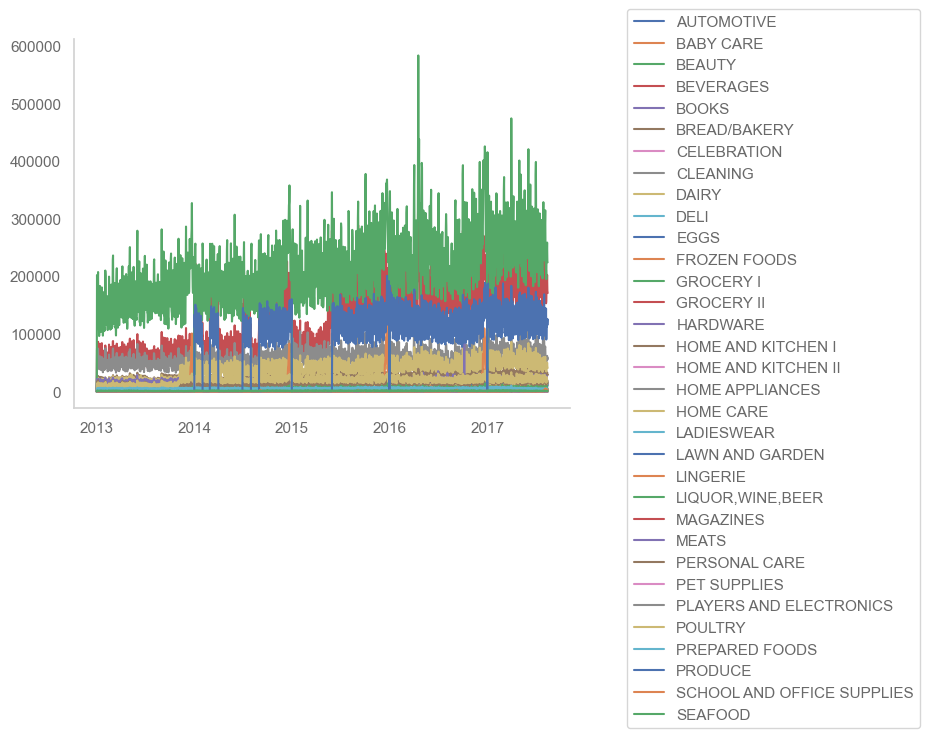

In [231]:
plt.plot(total_sales_df)
plt.legend(total_sales_df.columns,bbox_to_anchor=(1.1,1.1),loc='best')
plt.show()

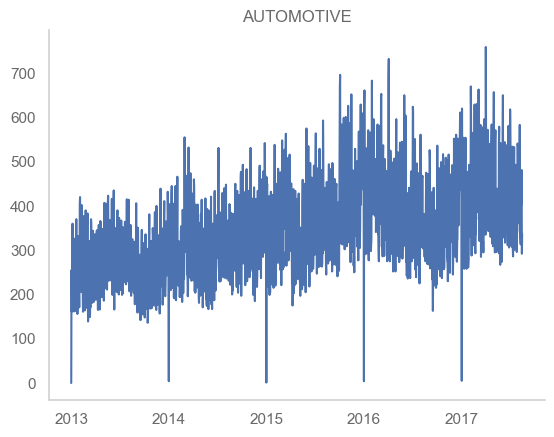

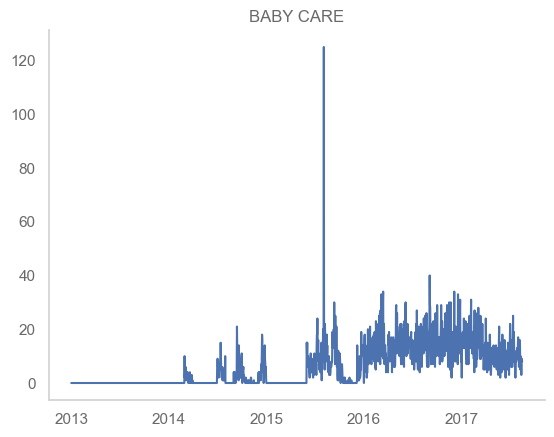

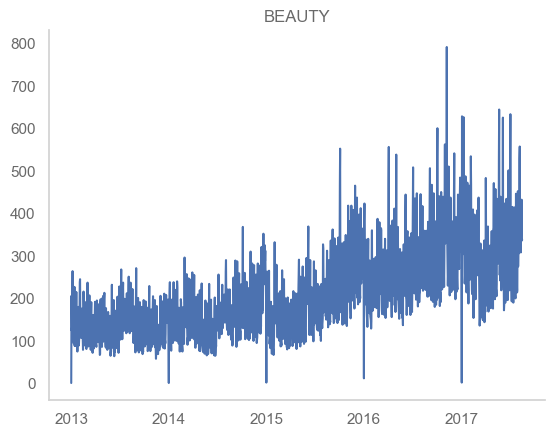

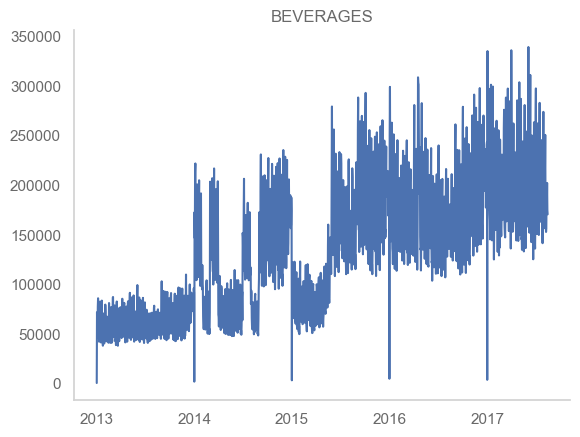

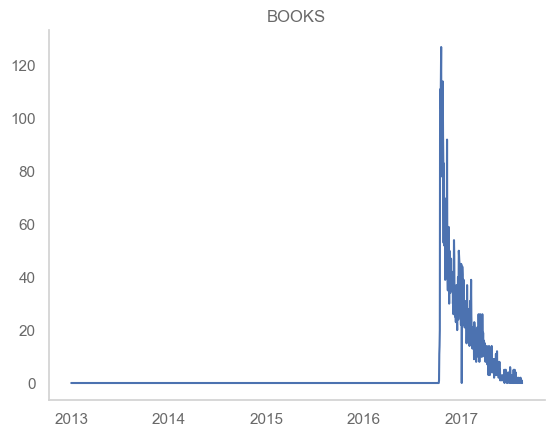

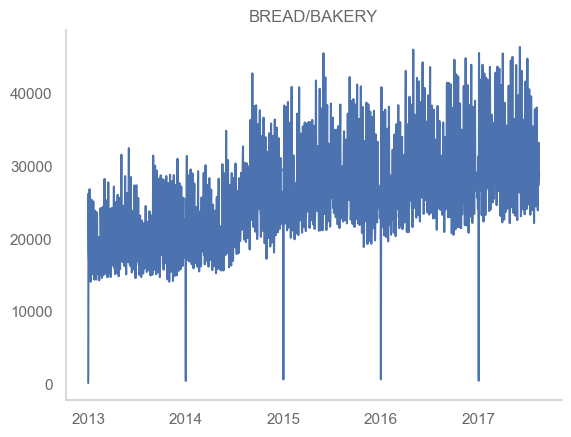

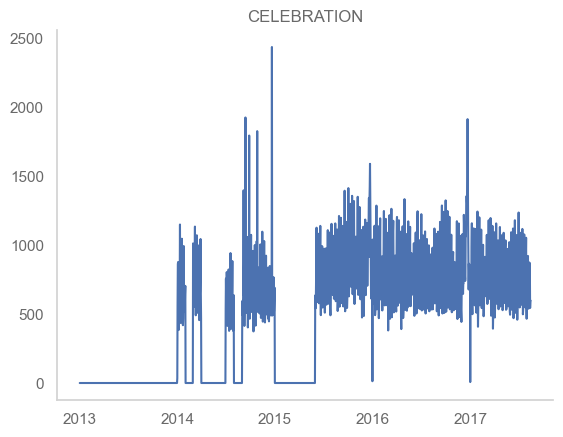

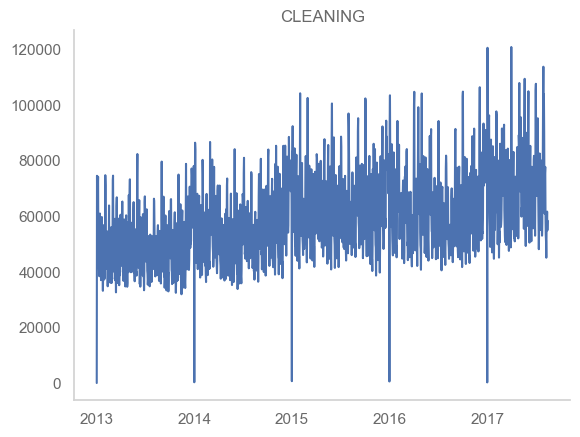

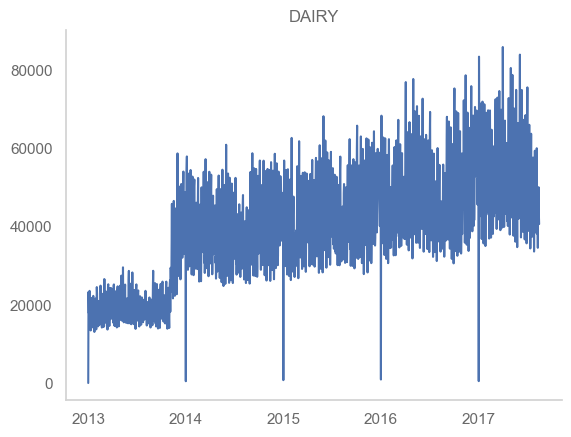

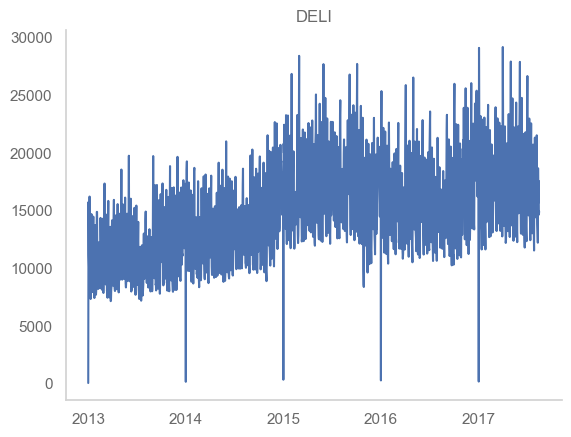

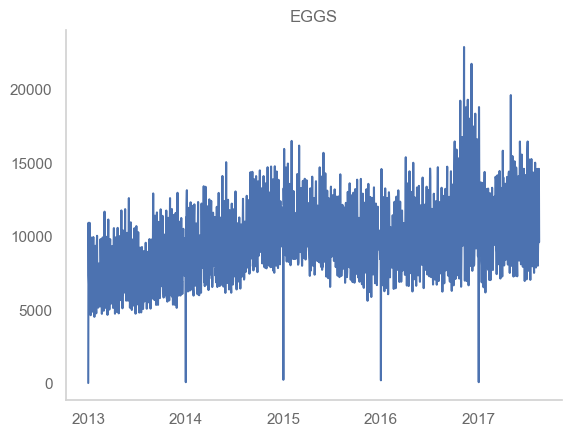

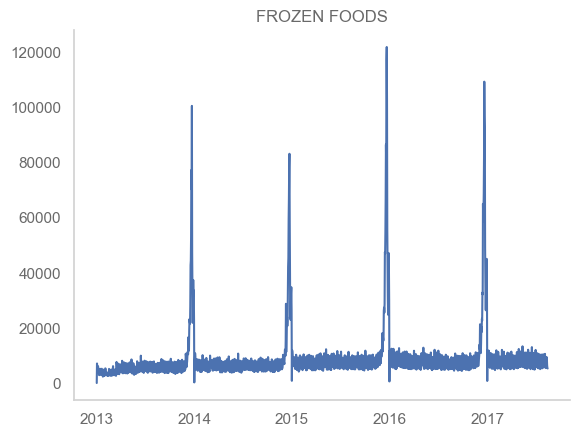

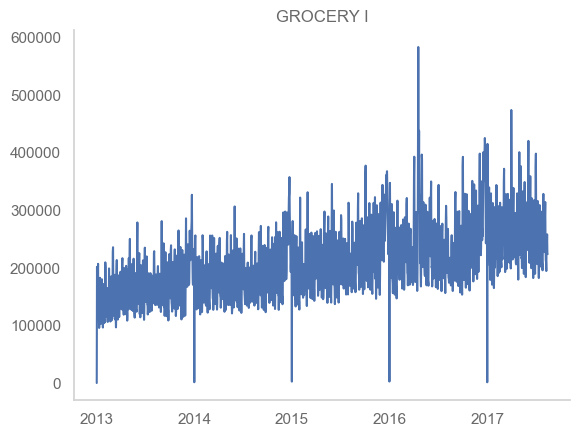

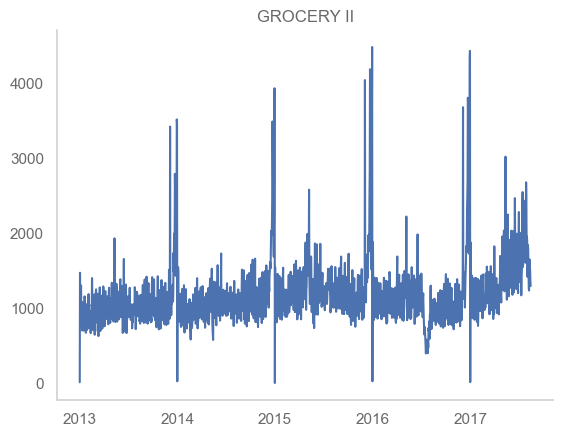

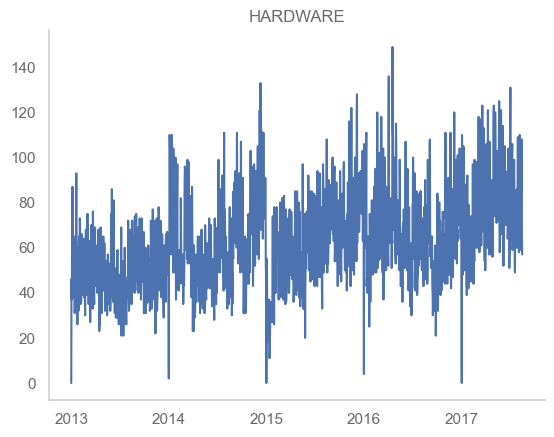

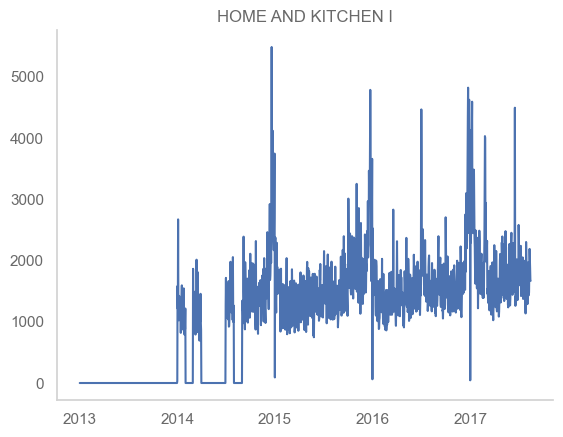

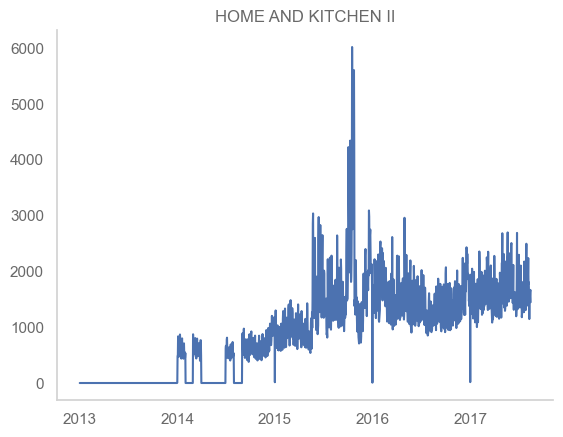

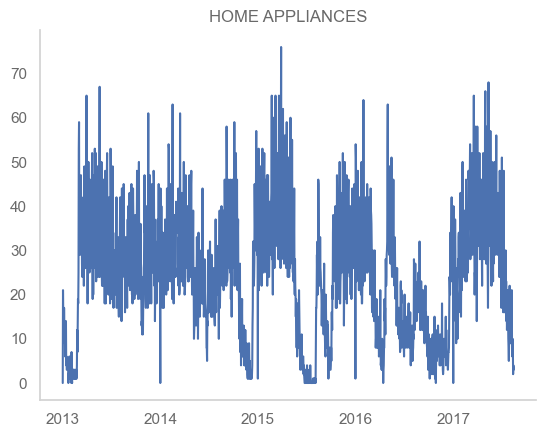

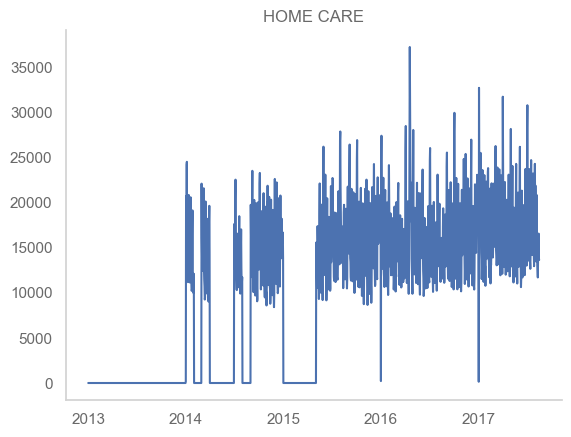

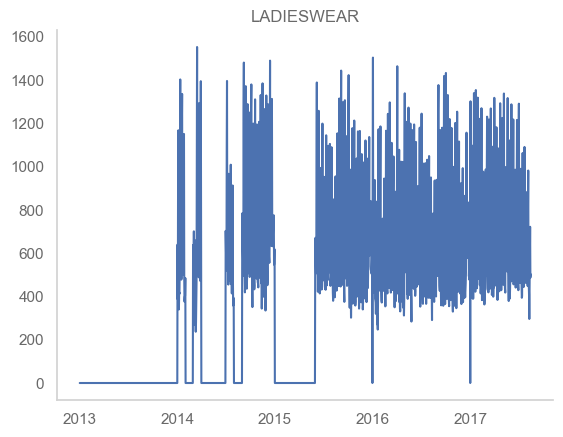

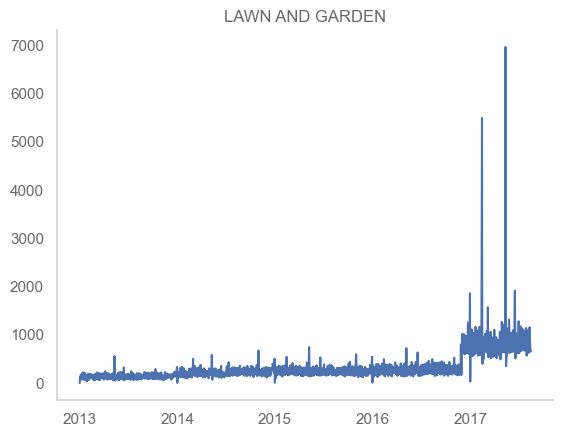

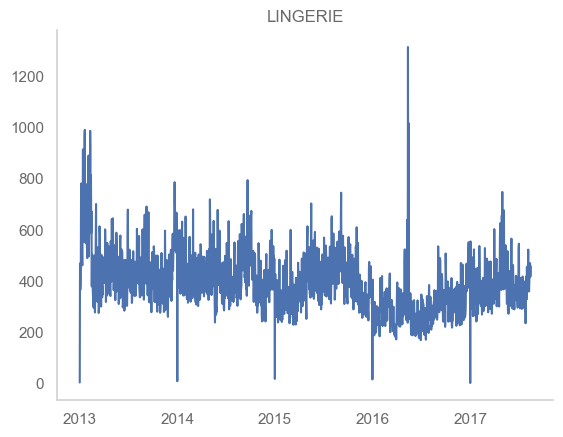

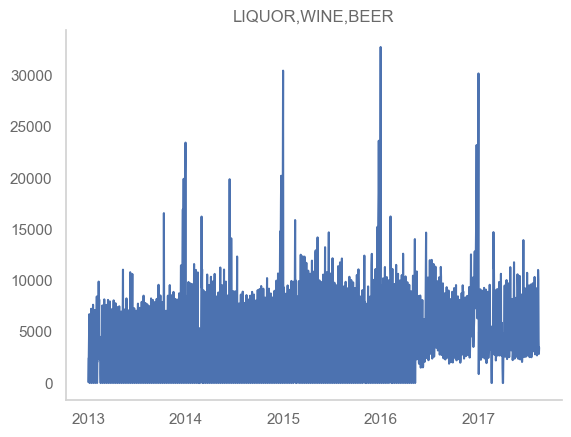

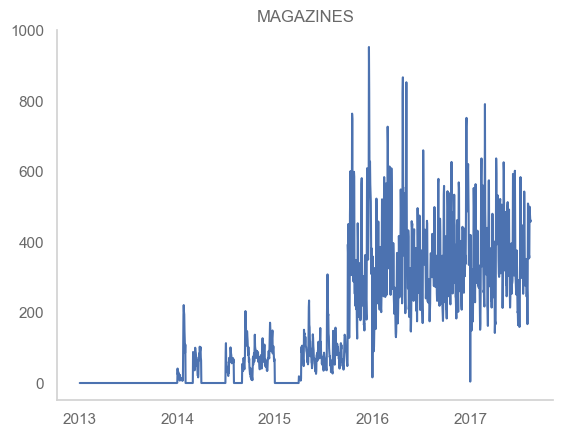

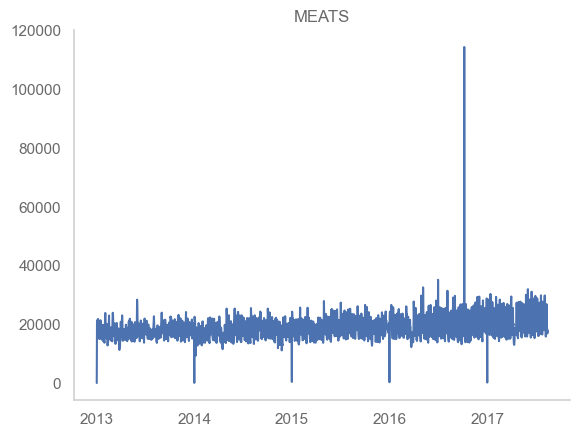

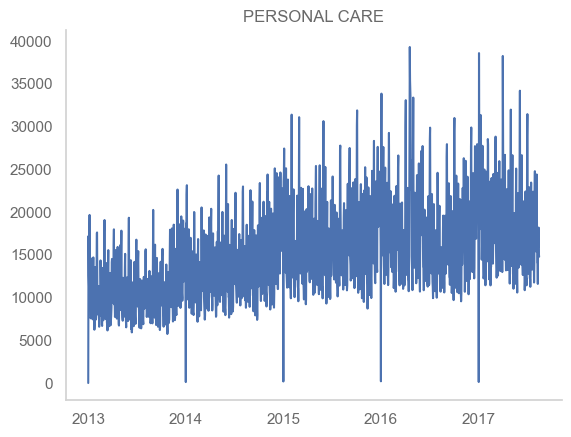

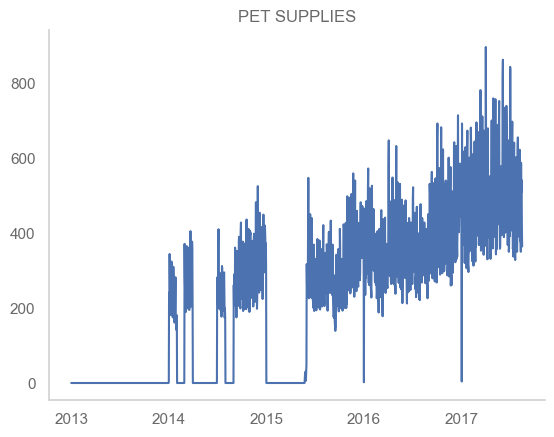

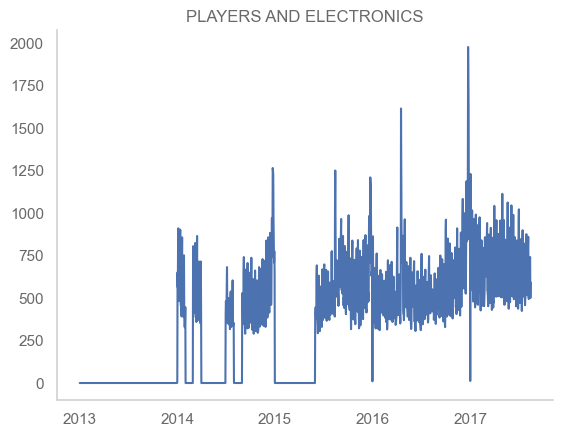

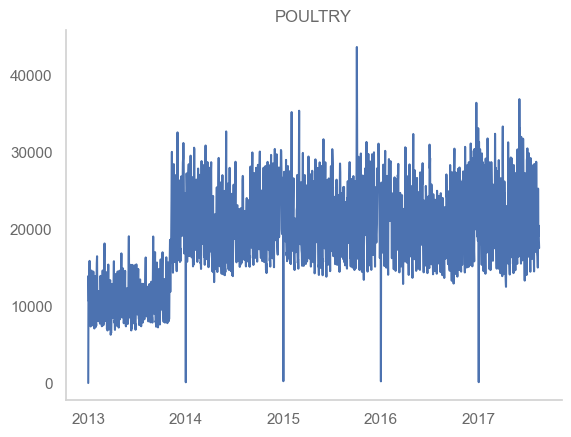

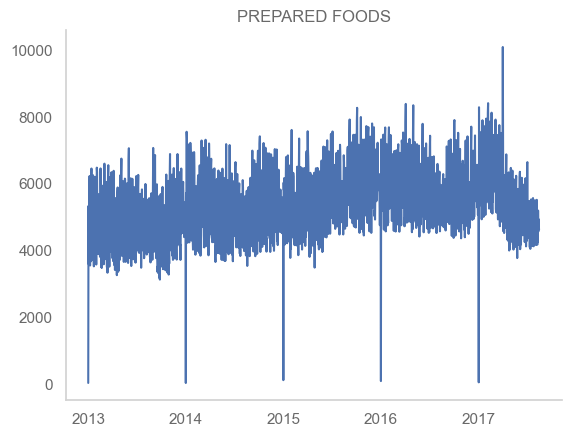

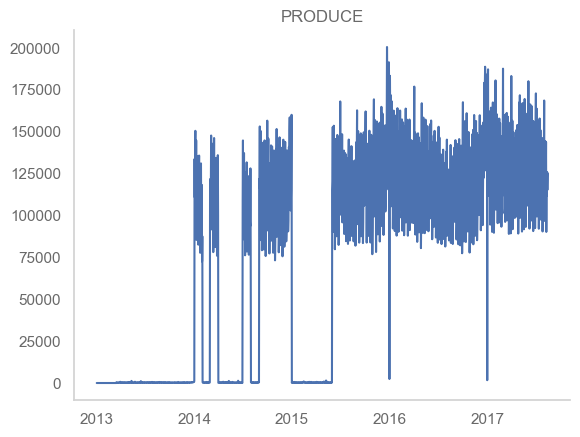

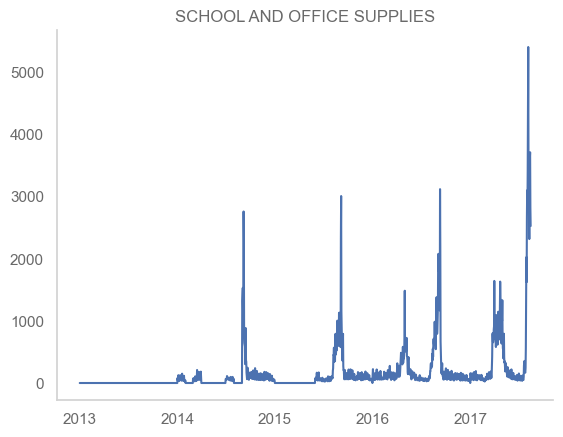

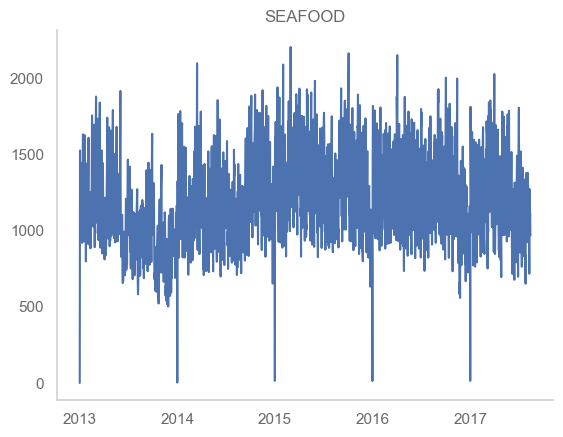

In [232]:
# plotting data for each family to see the distribution and to identify any trends
for column in total_sales_df.columns:
    plt.plot(total_sales_df[column])
    plt.title(column)
    plt.show()

We see that the data for the year 2013 and 2014 is completely missing or very sparse for product family like Books, Baby Care, Celebration, Home and Kitchen, School and Office Supply etc. and since we have data till aug 2017, lets take the recent 2 years worth of data from Aug 2015 to Aug 2017 as this will capture any seasonal trends too

In [233]:
total_sales_df = total_sales_df[total_sales_df.index >= '2015-08-15']

In [234]:
total_sales_df.head()

family      AUTOMOTIVE  BABY CARE  BEAUTY  BEVERAGES  BOOKS  BREAD/BAKERY  \
date                                                                        
2015-08-15      454.00      18.00  251.00  217135.00   0.00      32509.91   
2015-08-16      413.00      11.00  313.00  208213.00   0.00      34851.88   
2015-08-17      289.00      14.00  175.00  149741.00   0.00      26361.77   
2015-08-18      295.00      10.00  166.00  132609.00   0.00      23915.95   
2015-08-19      314.00       5.00  176.00  131368.00   0.00      23995.15   

family      CELEBRATION  CLEANING    DAIRY     DELI     EGGS  FROZEN FOODS  \
date                                                                         
2015-08-15      1157.00  75837.00 48578.00 19946.92 11232.00      10075.02   
2015-08-16       724.00  75824.00 50930.00 21178.46 11977.00       7526.03   
2015-08-17       593.00  59718.00 38358.00 15755.02 10713.00       5145.30   
2015-08-18       709.00  52749.00 33273.00 14119.25  8123.00       5050.99   
2015-08-19       599.00  51157.00 35760.00 13250.04  8001.00       5372.18   

family      GROCERY I  GROCERY II  HARDWARE  HOME AND KITCHEN I  \
date                                                              
2015-08-15  280491.48     1552.00    108.00             1899.00   
2015-08-16  266657.28     1441.00     62.00             1418.00   
2015-08-17  205150.61     1161.00     49.00             1143.00   
2015-08-18  181016.01      955.00     69.00             1181.00   
2015-08-19  178550.63     1011.00     55.00             1132.00   

family      HOME AND KITCHEN II  HOME APPLIANCES  HOME CARE  LADIESWEAR  \
date                                                                      
2015-08-15              1526.00            46.00   18924.00      879.00   
2015-08-16              1850.00            45.00   19757.00      955.00   
2015-08-17              1343.00            36.00   14120.00      564.00   
2015-08-18              1320.00            31.00   12202.00      485.00   
2015-08-19              1249.00            27.00   12042.00      492.00   

family      LAWN AND GARDEN  LINGERIE  LIQUOR,WINE,BEER  MAGAZINES    MEATS  \
date                                                                          
2015-08-15           268.00    525.00           9423.00     153.00 20403.94   
2015-08-16           220.00    530.00              0.00     157.00 20616.16   
2015-08-17           154.00    480.00           2968.00     125.00 16725.03   
2015-08-18           187.00    376.00           2984.00     102.00 15377.12   
2015-08-19           264.00    371.00           3786.00     102.00 15654.35   

family      PERSONAL CARE  PET SUPPLIES  PLAYERS AND ELECTRONICS  POULTRY  \
date                                                                        
2015-08-15       19398.00        370.00                  1250.00 24718.80   
2015-08-16       21048.00        359.00                   913.00 25480.78   
2015-08-17       14854.00        263.00                   593.00 18549.11   
2015-08-18       13064.00        193.00                   519.00 15722.33   
2015-08-19       12581.00        257.00                   535.00 16360.62   

family      PREPARED FOODS   PRODUCE  SCHOOL AND OFFICE SUPPLIES  SEAFOOD  
date                                                                       
2015-08-15         6854.54 128147.18                      701.00  1507.24  
2015-08-16         6640.39 131493.93                      793.00  1448.72  
2015-08-17         5212.50 102769.60                      458.00  1166.22  
2015-08-18         4758.13 106468.23                      494.00   951.63  
2015-08-19         5275.08 132449.58                      545.00   996.73

In [235]:
missing_data(total_sales_df)

Total  Percent    Types
family                                             
AUTOMOTIVE                      0     0.00  float64
BABY CARE                       0     0.00  float64
BEAUTY                          0     0.00  float64
BEVERAGES                       0     0.00  float64
BOOKS                           0     0.00  float64
BREAD/BAKERY                    0     0.00  float64
CELEBRATION                     0     0.00  float64
CLEANING                        0     0.00  float64
DAIRY                           0     0.00  float64
DELI                            0     0.00  float64
EGGS                            0     0.00  float64
FROZEN FOODS                    0     0.00  float64
GROCERY I                       0     0.00  float64
GROCERY II                      0     0.00  float64
HARDWARE                        0     0.00  float64
HOME AND KITCHEN I              0     0.00  float64
HOME AND KITCHEN II             0     0.00  float64
HOME APPLIANCES                 0     0.00  float64
HOME CARE                       0     0.00  float64
LADIESWEAR                      0     0.00  float64
LAWN AND GARDEN                 0     0.00  float64
LINGERIE                        0     0.00  float64
LIQUOR,WINE,BEER                0     0.00  float64
MAGAZINES                       0     0.00  float64
MEATS                           0     0.00  float64
PERSONAL CARE                   0     0.00  float64
PET SUPPLIES                    0     0.00  float64
PLAYERS AND ELECTRONICS         0     0.00  float64
POULTRY                         0     0.00  float64
PREPARED FOODS                  0     0.00  float64
PRODUCE                         0     0.00  float64
SCHOOL AND OFFICE SUPPLIES      0     0.00  float64
SEAFOOD                         0     0.00  float64

Lets group the data by different categoroes. The higher the volume of the data the better for forecasting since we can forecast past the noise and end up with lower error bars. This will also let us viaualize the forecasts on similar scales so that we can figur eout if timeseries modelling will work for the ctaegories since time series highly depends on the seasonal data of a certain variation 

In [236]:
# Lets calculate the mean 
avg_daily_sales =  total_sales_df.apply(np.mean, axis=0).sort_values()
avg_daily_sales


family
BOOKS                             8.82
BABY CARE                        11.83
HOME APPLIANCES                  23.21
HARDWARE                         70.21
BEAUTY                          273.44
SCHOOL AND OFFICE SUPPLIES      315.06
MAGAZINES                       328.69
LINGERIE                        343.78
PET SUPPLIES                    381.50
AUTOMOTIVE                      383.20
LAWN AND GARDEN                 491.47
PLAYERS AND ELECTRONICS         576.36
LADIESWEAR                      626.31
CELEBRATION                     770.87
SEAFOOD                        1241.14
GROCERY II                     1246.87
HOME AND KITCHEN II            1560.60
HOME AND KITCHEN I             1707.09
LIQUOR,WINE,BEER               5157.08
PREPARED FOODS                 5643.84
FROZEN FOODS                   9828.31
EGGS                          10069.28
HOME CARE                     15734.36
DELI                          16222.12
PERSONAL CARE                 17091.29
MEATS             

In [237]:
low, mid = np.percentile(total_sales_df.apply(np.mean, axis=0).sort_values(),[33,66])

In [238]:
low_vol_columns = avg_daily_sales[avg_daily_sales<=low].index
mid_vol_columns = avg_daily_sales[(avg_daily_sales>low) & (avg_daily_sales<mid)].index
high_vol_columns = avg_daily_sales[avg_daily_sales>mid].index

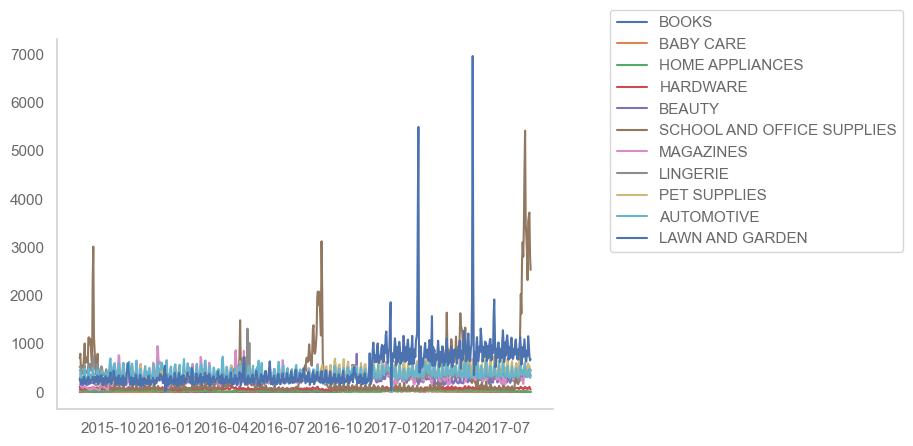

In [239]:
plt.plot(total_sales_df[low_vol_columns])
plt.legend(low_vol_columns,loc='best', bbox_to_anchor=(1.1,1.1))
plt.show()

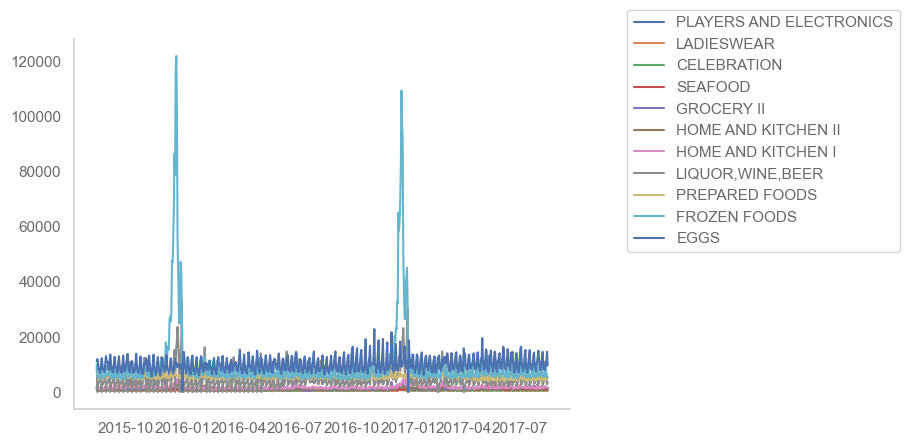

In [240]:
plt.plot(total_sales_df[mid_vol_columns])
plt.legend(mid_vol_columns,loc='best', bbox_to_anchor=(1.1,1.1))
plt.show()

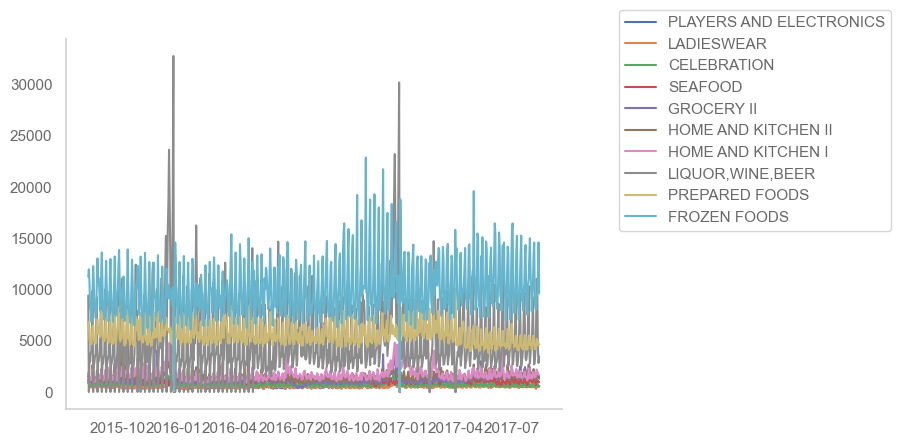

In [241]:
plt.plot(total_sales_df[mid_vol_columns].drop(columns='FROZEN FOODS'))
plt.legend(mid_vol_columns,loc='best', bbox_to_anchor=(1.1,1.1))
plt.show()

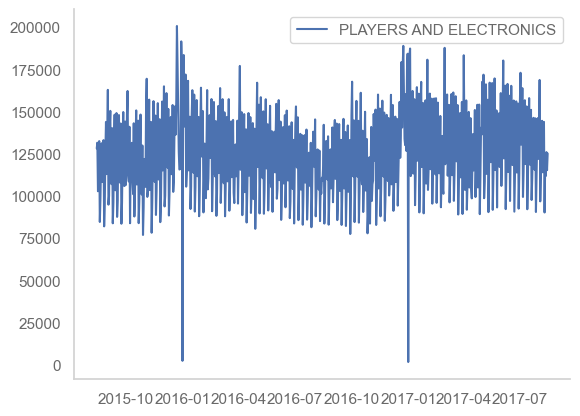

In [242]:
plt.plot(total_sales_df['PRODUCE'])
plt.legend(mid_vol_columns)

In [243]:
total_sales_df.head()

family      AUTOMOTIVE  BABY CARE  BEAUTY  BEVERAGES  BOOKS  BREAD/BAKERY  \
date                                                                        
2015-08-15      454.00      18.00  251.00  217135.00   0.00      32509.91   
2015-08-16      413.00      11.00  313.00  208213.00   0.00      34851.88   
2015-08-17      289.00      14.00  175.00  149741.00   0.00      26361.77   
2015-08-18      295.00      10.00  166.00  132609.00   0.00      23915.95   
2015-08-19      314.00       5.00  176.00  131368.00   0.00      23995.15   

family      CELEBRATION  CLEANING    DAIRY     DELI     EGGS  FROZEN FOODS  \
date                                                                         
2015-08-15      1157.00  75837.00 48578.00 19946.92 11232.00      10075.02   
2015-08-16       724.00  75824.00 50930.00 21178.46 11977.00       7526.03   
2015-08-17       593.00  59718.00 38358.00 15755.02 10713.00       5145.30   
2015-08-18       709.00  52749.00 33273.00 14119.25  8123.00       5050.99   
2015-08-19       599.00  51157.00 35760.00 13250.04  8001.00       5372.18   

family      GROCERY I  GROCERY II  HARDWARE  HOME AND KITCHEN I  \
date                                                              
2015-08-15  280491.48     1552.00    108.00             1899.00   
2015-08-16  266657.28     1441.00     62.00             1418.00   
2015-08-17  205150.61     1161.00     49.00             1143.00   
2015-08-18  181016.01      955.00     69.00             1181.00   
2015-08-19  178550.63     1011.00     55.00             1132.00   

family      HOME AND KITCHEN II  HOME APPLIANCES  HOME CARE  LADIESWEAR  \
date                                                                      
2015-08-15              1526.00            46.00   18924.00      879.00   
2015-08-16              1850.00            45.00   19757.00      955.00   
2015-08-17              1343.00            36.00   14120.00      564.00   
2015-08-18              1320.00            31.00   12202.00      485.00   
2015-08-19              1249.00            27.00   12042.00      492.00   

family      LAWN AND GARDEN  LINGERIE  LIQUOR,WINE,BEER  MAGAZINES    MEATS  \
date                                                                          
2015-08-15           268.00    525.00           9423.00     153.00 20403.94   
2015-08-16           220.00    530.00              0.00     157.00 20616.16   
2015-08-17           154.00    480.00           2968.00     125.00 16725.03   
2015-08-18           187.00    376.00           2984.00     102.00 15377.12   
2015-08-19           264.00    371.00           3786.00     102.00 15654.35   

family      PERSONAL CARE  PET SUPPLIES  PLAYERS AND ELECTRONICS  POULTRY  \
date                                                                        
2015-08-15       19398.00        370.00                  1250.00 24718.80   
2015-08-16       21048.00        359.00                   913.00 25480.78   
2015-08-17       14854.00        263.00                   593.00 18549.11   
2015-08-18       13064.00        193.00                   519.00 15722.33   
2015-08-19       12581.00        257.00                   535.00 16360.62   

family      PREPARED FOODS   PRODUCE  SCHOOL AND OFFICE SUPPLIES  SEAFOOD  
date                                                                       
2015-08-15         6854.54 128147.18                      701.00  1507.24  
2015-08-16         6640.39 131493.93                      793.00  1448.72  
2015-08-17         5212.50 102769.60                      458.00  1166.22  
2015-08-18         4758.13 106468.23                      494.00   951.63  
2015-08-19         5275.08 132449.58                      545.00   996.73

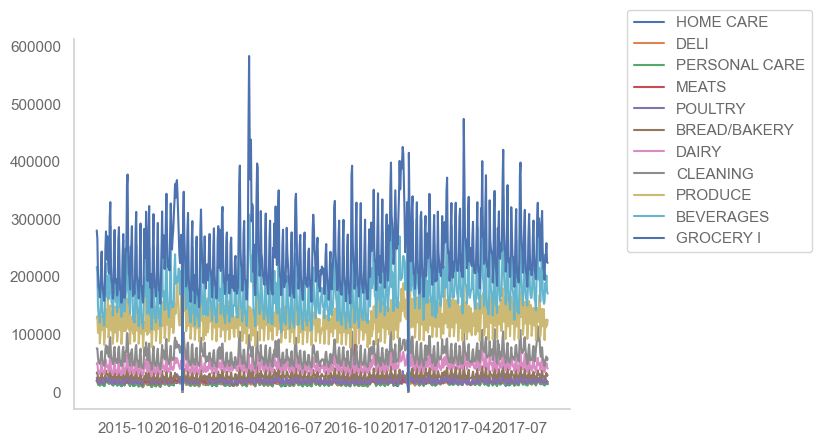

In [244]:
plt.plot(total_sales_df[high_vol_columns])
plt.legend(high_vol_columns,loc='best', bbox_to_anchor=(1.1,1.1))
plt.show()

In [245]:
# Test with a single product -- Produce

In [246]:
feature = "PRODUCE"
prediction_days = 30

In [247]:
df = total_sales_df[[feature]].reset_index()

In [248]:
df.head()

family       date   PRODUCE
0      2015-08-15 128147.18
1      2015-08-16 131493.93
2      2015-08-17 102769.60
3      2015-08-18 106468.23
4      2015-08-19 132449.58

In [249]:
# adding holiday data
# we will having a 4 day period like 2 days prior and 1 day after the holiday
holiday = pd.DataFrame()

# ecuador_holidays = holidays.EC()
# ecuador_holidays = holidays.country_holidays('EC')


for date,name in sorted(holidays.EC(years=[2015,2016,2017,2018]).items()):
    holiday = pd.concat([holiday,pd.DataFrame({'ds':date,'holiday':"EC-holidays","lower_window":-2,"upper_window":1},index=[0])], ignore_index=True)
    
holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')
holiday.head()

ds      holiday  lower_window  upper_window
0 2015-01-01  EC-holidays            -2             1
1 2015-02-16  EC-holidays            -2             1
2 2015-02-17  EC-holidays            -2             1
3 2015-04-03  EC-holidays            -2             1
4 2015-05-01  EC-holidays            -2             1

In [250]:
# Variables
# we are setting the forecast date as 2017-07-01, post this date data will be used to test the performance of 
#our model, the training data will be from Aug 2015 - Jun 2017

forecast_start_dt = pd.to_datetime("2017-07-01")
forecast_start_dt = (forecast_start_dt).strftime("%Y-%m-%d")
print(forecast_start_dt)

2017-07-01


In [251]:
#Prophet Model

df_copy = df.copy()
#prophet requires the date column to be renamed as ds and the target column to be renamed as y
df_copy = df_copy.rename(columns={'date':'ds',feature:'y'})

In [252]:
# confirming it to be a numeric col
df_copy[['y']] = df_copy[['y']].apply(pd.to_numeric)

# confirming it to be a datetime col
df_copy['ds'] = pd.to_datetime(df_copy['ds'])

# creating a train set as per our forecast date
train_set = df_copy[(df_copy['ds'] < forecast_start_dt)]


m = Prophet()
m.fit(train_set)

future = m.make_future_dataframe(periods=prediction_days)
fcst_prophet_train = m.predict(future)


# adding filter to add only the forecasted data into predicted_df
filter = fcst_prophet_train['ds']>=forecast_start_dt
predicted_df = fcst_prophet_train[filter][['ds','yhat']]

10:58:54 - cmdstanpy - INFO - Chain [1] start processing
10:58:54 - cmdstanpy - INFO - Chain [1] done processing


In [253]:
predicted_df.head()

ds      yhat
684 2017-07-01 144612.13
685 2017-07-02 155336.04
686 2017-07-03 122383.38
687 2017-07-04 127642.39
688 2017-07-05 160253.27

In [254]:
predicted_df.tail()

ds      yhat
709 2017-07-26 161009.85
710 2017-07-27 103424.26
711 2017-07-28 116774.40
712 2017-07-29 145620.91
713 2017-07-30 156344.81

In [255]:
df_copy = df.copy()
df_copy.columns= ['ds','ytrue']
predicted_df = predicted_df.merge(df_copy)

In [256]:
predicted_df

ds      yhat     ytrue
0  2017-07-01 144612.13 155487.63
1  2017-07-02 155336.04 172890.14
2  2017-07-03 122383.38 130389.20
3  2017-07-04 127642.39 131534.55
4  2017-07-05 160253.27 163804.33
5  2017-07-06 102667.68  99395.60
6  2017-07-07 116017.82 114346.57
7  2017-07-08 144864.32 139294.77
8  2017-07-09 155588.23 156633.92
9  2017-07-10 122635.58 118856.99
10 2017-07-11 127894.58 122176.36
11 2017-07-12 160505.46 152978.41
12 2017-07-13 102919.87  92111.27
13 2017-07-14 116270.01 110263.08
14 2017-07-15 145116.52 133166.71
15 2017-07-16 155840.43 157883.06
16 2017-07-17 122887.77 119026.44
17 2017-07-18 128146.78 118281.40
18 2017-07-19 160757.66 150952.70
19 2017-07-20 103172.07  97593.17
20 2017-07-21 116522.21 110555.13
21 2017-07-22 145368.71 130700.68
22 2017-07-23 156092.62 146226.46
23 2017-07-24 123139.97 117117.10
24 2017-07-25 128398.97 115457.66
25 2017-07-26 161009.85 145917.92
26 2017-07-27 103424.26  90481.29
27 2017-07-28 116774.40 111948.89
28 2017-07-29 145620.91 131988.66
29 2017-07-30 156344.81 146045.80

In [257]:
mape(predicted_df.ytrue,predicted_df.yhat)

6.263881123154167

### Cross Validation with Prophet

Find the best parameters by testing over various periods of time with those parameters (cross-validation)

In [258]:
# we are cross validating the data to get predictions on different sets and aggregate that\
# here we are giving initial 365 dyas of data and period of 30 days to predict, we are giving a window of 
#30 days and this will essentially increasie the training time by 30 days one at a time and predict on the next 30 days
# it will keep doing this untill the max date

m = Prophet()
m.fit(train_set)
df_cv = cross_validation(m, initial='365 days', period ='30 days', horizon='30 days')

10:58:55 - cmdstanpy - INFO - Chain [1] start processing
10:58:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/10 [00:00<?, ?it/s]

10:58:55 - cmdstanpy - INFO - Chain [1] start processing
10:58:55 - cmdstanpy - INFO - Chain [1] done processing
10:58:55 - cmdstanpy - INFO - Chain [1] start processing
10:58:55 - cmdstanpy - INFO - Chain [1] done processing
10:58:55 - cmdstanpy - INFO - Chain [1] start processing
10:58:55 - cmdstanpy - INFO - Chain [1] done processing
10:58:55 - cmdstanpy - INFO - Chain [1] start processing
10:58:55 - cmdstanpy - INFO - Chain [1] done processing
10:58:55 - cmdstanpy - INFO - Chain [1] start processing
10:58:56 - cmdstanpy - INFO - Chain [1] done processing
10:58:56 - cmdstanpy - INFO - Chain [1] start processing
10:58:56 - cmdstanpy - INFO - Chain [1] done processing
10:58:56 - cmdstanpy - INFO - Chain [1] start processing
10:58:56 - cmdstanpy - INFO - Chain [1] done processing
10:58:56 - cmdstanpy - INFO - Chain [1] start processing
10:58:56 - cmdstanpy - INFO - Chain [1] done processing
10:58:56 - cmdstanpy - INFO - Chain [1] start processing
10:58:56 - cmdstanpy - INFO - Chain [1]

In [259]:
train_set['ds'].min(), train_set['ds'].max()

(Timestamp('2015-08-15 00:00:00'), Timestamp('2017-06-30 00:00:00'))

In [260]:
# mape here gives the mean absolute percentage error which looks really good, like 9% error, 8% error and so on
df_p = performance_metrics(df_cv)
df_p.head()

horizon          mse     rmse      mae  mape  mdape  smape  coverage
0  3 days 411911254.07 20295.60 13088.62  0.09   0.07   0.10      0.80
1  4 days 269732789.34 16423.54 11119.74  0.08   0.06   0.08      0.80
2  5 days 141547986.52 11897.39  8894.95  0.07   0.06   0.07      0.87
3  6 days 126310847.91 11238.81  9216.62  0.07   0.07   0.07      0.87
4  7 days  95815198.40  9788.52  8407.64  0.07   0.07   0.07      0.93

In [261]:
# however the mape for the last day is very high -- 300%, we need to look into this
df_p.tail()

horizon           mse     rmse      mae  mape  mdape  smape  coverage
23 26 days  254632370.78 15957.20 12018.61  0.10   0.08   0.10      0.80
24 27 days  305198598.48 17469.93 13245.62  0.11   0.09   0.11      0.77
25 28 days  502076648.26 22407.07 15686.99  0.13   0.08   0.13      0.73
26 29 days  549411933.51 23439.54 16593.94  0.12   0.09   0.13      0.66
27 30 days 1247042864.57 35313.49 21490.91  3.01   0.12   0.19      0.60

df_p gives the overall MAPE, but if we want to get more granularand calculate daily differences using mape metric, we can do as below. This will allow to detect issues in predicting certain time periods, which are inherent issues in the data which may or may not be fixable. 


In [262]:
df_cv['mape'] = (df_cv['y']-df_cv['yhat']) / df_cv['y'] * 100
df_cv['overestimate'] = df_cv['yhat'] > df_cv['y']

df_cv.sort_values('mape', ascending=False).head(10)

ds      yhat  yhat_lower  yhat_upper         y     cutoff  mape  \
110 2016-12-23  98435.33    82541.98   115268.18 176327.97 2016-12-02 44.17   
116 2016-12-30  98482.55    83013.12   114304.93 175022.19 2016-12-02 43.73   
109 2016-12-22  87944.49    73016.63   103384.78 140444.94 2016-12-02 37.38   
119 2017-01-02 117105.88    97323.61   136472.27 184113.03 2017-01-01 36.39   
120 2017-01-03 121366.40   101236.44   139559.86 183306.23 2017-01-01 33.79   
111 2016-12-24 127831.67   112344.72   143558.03 188809.16 2016-12-02 32.30   
117 2016-12-31 127878.90   111999.10   143731.75 184154.67 2016-12-02 30.56   
115 2016-12-29  87991.72    71897.56   104705.99 126652.84 2016-12-02 30.53   
238 2017-05-01 126201.34   106388.88   143997.59 167558.58 2017-04-01 24.68   
108 2016-12-21 143735.72   128547.61   160403.14 179251.71 2016-12-02 19.81   

     overestimate  
110         False  
116         False  
109         False  
119         False  
120         False  
111         False  
117         False  
115         False  
238         False  
108         False

The granular mape helps us to identify the reason why the mape is higher, because we see a trnd that the mape is higher around the year end. In addition the under predicting the model has higher mape for that time period.
Lets check at the input data here


(array([16709., 16801., 16892., 16983., 17075., 17167., 17257., 17348.]),
 [Text(16709.0, 0, '2015-10'),
  Text(16801.0, 0, '2016-01'),
  Text(16892.0, 0, '2016-04'),
  Text(16983.0, 0, '2016-07'),
  Text(17075.0, 0, '2016-10'),
  Text(17167.0, 0, '2017-01'),
  Text(17257.0, 0, '2017-04'),
  Text(17348.0, 0, '2017-07')])

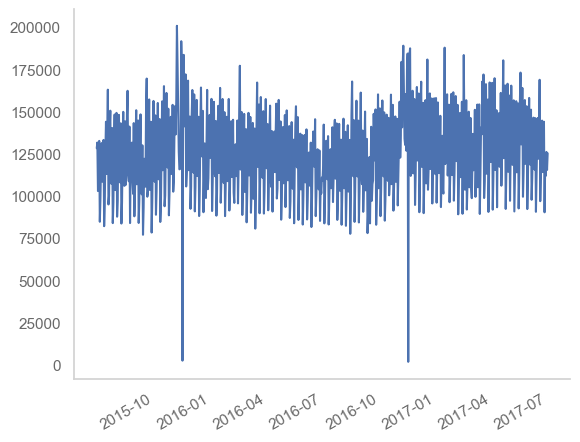

In [263]:
plt.plot(total_sales_df['PRODUCE'])
plt.xticks(rotation =30)

from the plot above its seen that the data for january is off, this is like a systematic error in the data. Its a data issue and this should be normalized

In [264]:
# the model is highly underpredicting for 
df_cv

ds      yhat  yhat_lower  yhat_upper         y     cutoff  \
0   2016-09-04 137051.97   119844.91   152925.86 144954.39 2016-09-03   
1   2016-09-05 103702.40    86277.69   119968.40 110104.68 2016-09-03   
2   2016-09-06 107795.45    91355.24   124393.89 115898.16 2016-09-03   
3   2016-09-07 140075.90   122861.18   155826.07 142809.15 2016-09-03   
4   2016-09-08  84285.75    67629.54   101364.73  85680.68 2016-09-03   
5   2016-09-09  93707.67    78470.61   111482.74  96152.02 2016-09-03   
6   2016-09-10 123851.91   107119.25   140565.89 128750.47 2016-09-03   
7   2016-09-11 136600.82   120027.51   154058.53 142536.23 2016-09-03   
8   2016-09-12 103251.24    87057.82   118996.13 102988.54 2016-09-03   
9   2016-09-13 107344.29    90541.62   124363.21 104210.54 2016-09-03   
10  2016-09-14 139624.75   122901.26   156255.35 133177.49 2016-09-03   
11  2016-09-15  83834.60    67222.28   101196.67  82817.73 2016-09-03   
12  2016-09-16  93256.51    77234.09   109413.28 100497.35 2016-09-03   
13  2016-09-17 123400.76   106093.12   140177.95 130363.16 2016-09-03   
14  2016-09-18 136149.66   120291.58   152769.56 145619.12 2016-09-03   
15  2016-09-19 102800.09    86241.56   119795.50 104423.30 2016-09-03   
16  2016-09-20 106893.14    91589.91   123767.63 109630.64 2016-09-03   
17  2016-09-21 139173.59   121849.62   156473.65 137831.31 2016-09-03   
18  2016-09-22  83383.44    67514.51   100551.49  82191.66 2016-09-03   
19  2016-09-23  92805.36    76267.84   109684.59 100287.53 2016-09-03   
20  2016-09-24 122949.61   106129.24   139414.91 125216.34 2016-09-03   
21  2016-09-25 135698.51   117810.35   152757.29 141707.37 2016-09-03   
22  2016-09-26 102348.93    86318.94   120193.59 102474.46 2016-09-03   
23  2016-09-27 106441.98    89935.75   122800.34 102597.39 2016-09-03   
24  2016-09-28 138722.44   121795.10   155810.80 133065.47 2016-09-03   
25  2016-09-29  82932.29    67545.98    99561.56  77462.86 2016-09-03   
26  2016-09-30  92354.21    75599.99   109205.76  98878.82 2016-09-03   
27  2016-10-01 122498.45   105530.09   139332.92 147899.16 2016-09-03   
28  2016-10-02 135247.35   119822.22   152553.20 167616.07 2016-09-03   
29  2016-10-03 101897.78    85471.82   118708.66 115239.28 2016-09-03   
30  2016-10-04 107765.67    91384.48   123717.03 111537.23 2016-10-03   
31  2016-10-05 139805.70   123396.67   155701.78 144696.09 2016-10-03   
32  2016-10-06  84097.97    67186.48   100960.63  84512.46 2016-10-03   
33  2016-10-07  94029.78    77363.53   110819.64 104712.76 2016-10-03   
34  2016-10-08 124442.75   109167.82   140784.34 135984.27 2016-10-03   
35  2016-10-09 137568.22   121428.20   153541.18 156253.83 2016-10-03   
36  2016-10-10 103552.45    88515.48   119172.16 111717.99 2016-10-03   
37  2016-10-11 107393.78    90528.40   123416.35 111443.61 2016-10-03   
38  2016-10-12 139433.81   122337.33   155508.77 144451.54 2016-10-03   
39  2016-10-13  83726.07    67650.74    99764.41  84177.81 2016-10-03   
40  2016-10-14  93657.88    76875.27   109628.50 102528.40 2016-10-03   
41  2016-10-15 124070.85   108723.15   140387.40 130338.26 2016-10-03   
42  2016-10-16 137196.32   121933.35   154276.97 161055.99 2016-10-03   
43  2016-10-17 103180.55    87044.00   119188.71 113424.59 2016-10-03   
44  2016-10-18 107021.88    90096.35   121949.51 106860.82 2016-10-03   
45  2016-10-19 139061.91   123274.66   154759.11 138579.65 2016-10-03   
46  2016-10-20  83354.18    66722.22    99850.22  90478.11 2016-10-03   
47  2016-10-21  93285.98    77266.50   110191.85 103681.18 2016-10-03   
48  2016-10-22 123698.96   107856.33   139979.12 124247.48 2016-10-03   
49  2016-10-23 136824.43   120379.93   151616.49 149830.87 2016-10-03   
50  2016-10-24 102808.66    86039.18   118883.37 103186.32 2016-10-03   
51  2016-10-25 106649.98    89854.30   122887.55 108796.62 2016-10-03   
52  2016-10-26 138690.01   122185.76   155063.29 133634.10 2016-10-03   
53  2016-10-27  82982.28    67845.57    99691.79  77873.09 2016-10-03 

Optimizing fpor Produce feature--- hyperparameter tuning

In [265]:
param_grid = {
    'changepoint_prior_scale':[0.001,0.01,0.1, 0.5],
     'seasonality_prior_scale': [0.01,0.1,1.0,10.0]
}


# Generate all combinations of parameters

all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []

# use cross validation to evaluate all paramaeters
for params in all_params:
    m = Prophet(**params).fit(train_set) #fit model with given params
    df_cv = cross_validation(m, initial='365 days', period='30 days',horizon='30 days', parallel ='processes')
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])
    

#Find the best parametr
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses

    
    

10:58:57 - cmdstanpy - INFO - Chain [1] start processing
10:58:57 - cmdstanpy - INFO - Chain [1] done processing
10:59:00 - cmdstanpy - INFO - Chain [1] start processing
10:59:00 - cmdstanpy - INFO - Chain [1] start processing
10:59:00 - cmdstanpy - INFO - Chain [1] start processing
10:59:00 - cmdstanpy - INFO - Chain [1] start processing
10:59:00 - cmdstanpy - INFO - Chain [1] start processing
10:59:00 - cmdstanpy - INFO - Chain [1] start processing
10:59:00 - cmdstanpy - INFO - Chain [1] start processing
10:59:00 - cmdstanpy - INFO - Chain [1] start processing
10:59:00 - cmdstanpy - INFO - Chain [1] start processing
10:59:00 - cmdstanpy - INFO - Chain [1] start processing
10:59:01 - cmdstanpy - INFO - Chain [1] done processing
10:59:01 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:59:01 - cmdstanpy - INFO - Chain [1] done processing
10:59:01 - cmdstanpy - ERROR - Chain [1] error: e

10:59:10 - cmdstanpy - INFO - Chain [1] done processing
10:59:11 - cmdstanpy - INFO - Chain [1] done processing
10:59:11 - cmdstanpy - INFO - Chain [1] done processing
10:59:11 - cmdstanpy - INFO - Chain [1] done processing
10:59:11 - cmdstanpy - INFO - Chain [1] done processing
10:59:11 - cmdstanpy - INFO - Chain [1] done processing
10:59:11 - cmdstanpy - INFO - Chain [1] start processing
10:59:11 - cmdstanpy - INFO - Chain [1] done processing
10:59:14 - cmdstanpy - INFO - Chain [1] start processing
10:59:14 - cmdstanpy - INFO - Chain [1] start processing
10:59:14 - cmdstanpy - INFO - Chain [1] done processing
10:59:14 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:59:14 - cmdstanpy - INFO - Chain [1] start processing
10:59:14 - cmdstanpy - INFO - Chain [1] start processing
10:59:14 - cmdstanpy - INFO - Chain [1] start processing
10:59:14 - cmdstanpy - INFO - Chain [1] done processin

10:59:29 - cmdstanpy - INFO - Chain [1] done processing
10:59:32 - cmdstanpy - INFO - Chain [1] start processing
10:59:32 - cmdstanpy - INFO - Chain [1] start processing
10:59:32 - cmdstanpy - INFO - Chain [1] start processing
10:59:32 - cmdstanpy - INFO - Chain [1] done processing
10:59:32 - cmdstanpy - INFO - Chain [1] start processing
10:59:32 - cmdstanpy - INFO - Chain [1] start processing
10:59:32 - cmdstanpy - INFO - Chain [1] done processing
10:59:32 - cmdstanpy - INFO - Chain [1] start processing
10:59:32 - cmdstanpy - INFO - Chain [1] done processing
10:59:32 - cmdstanpy - INFO - Chain [1] start processing
10:59:32 - cmdstanpy - INFO - Chain [1] done processing
10:59:32 - cmdstanpy - INFO - Chain [1] start processing
10:59:32 - cmdstanpy - INFO - Chain [1] done processing
10:59:32 - cmdstanpy - INFO - Chain [1] done processing
10:59:32 - cmdstanpy - INFO - Chain [1] done processing
10:59:32 - cmdstanpy - INFO - Chain [1] start processing
10:59:32 - cmdstanpy - INFO - Chain [1]

10:59:52 - cmdstanpy - INFO - Chain [1] done processing
10:59:53 - cmdstanpy - INFO - Chain [1] start processing
10:59:53 - cmdstanpy - INFO - Chain [1] done processing
10:59:55 - cmdstanpy - INFO - Chain [1] start processing
10:59:55 - cmdstanpy - INFO - Chain [1] start processing
10:59:55 - cmdstanpy - INFO - Chain [1] start processing
10:59:56 - cmdstanpy - INFO - Chain [1] start processing
10:59:56 - cmdstanpy - INFO - Chain [1] start processing
10:59:56 - cmdstanpy - INFO - Chain [1] done processing
10:59:56 - cmdstanpy - INFO - Chain [1] start processing
10:59:56 - cmdstanpy - INFO - Chain [1] done processing
10:59:56 - cmdstanpy - INFO - Chain [1] start processing
10:59:56 - cmdstanpy - INFO - Chain [1] done processing
10:59:56 - cmdstanpy - INFO - Chain [1] start processing
10:59:56 - cmdstanpy - INFO - Chain [1] done processing
10:59:56 - cmdstanpy - INFO - Chain [1] done processing
10:59:56 - cmdstanpy - INFO - Chain [1] done processing
10:59:56 - cmdstanpy - INFO - Chain [1]

In [266]:
print(tuning_results)

    changepoint_prior_scale  seasonality_prior_scale     rmse
0                      0.00                     0.01 18782.74
1                      0.00                     0.10 18893.21
2                      0.00                     1.00 18530.96
3                      0.00                    10.00 18650.23
4                      0.01                     0.01 18185.61
5                      0.01                     0.10 17779.54
6                      0.01                     1.00 17756.78
7                      0.01                    10.00 17722.73
8                      0.10                     0.01 18096.29
9                      0.10                     0.10 17727.24
10                     0.10                     1.00 17714.22
11                     0.10                    10.00 17712.65
12                     0.50                     0.01 18098.10
13                     0.50                     0.10 17752.96
14                     0.50                     1.00 17759.66
15      

In [267]:
tuning_results.sort_values('rmse')

changepoint_prior_scale  seasonality_prior_scale     rmse
11                     0.10                    10.00 17712.65
10                     0.10                     1.00 17714.22
7                      0.01                    10.00 17722.73
9                      0.10                     0.10 17727.24
13                     0.50                     0.10 17752.96
6                      0.01                     1.00 17756.78
14                     0.50                     1.00 17759.66
15                     0.50                    10.00 17772.76
5                      0.01                     0.10 17779.54
8                      0.10                     0.01 18096.29
12                     0.50                     0.01 18098.10
4                      0.01                     0.01 18185.61
2                      0.00                     1.00 18530.96
3                      0.00                    10.00 18650.23
0                      0.00                     0.01 18782.74
1                      0.00                     0.10 18893.21

In [268]:
tuning_results.sort_values('rmse').reset_index(drop=True).iloc[0]

changepoint_prior_scale       0.10
seasonality_prior_scale      10.00
rmse                      17712.65
Name: 0, dtype: float64

In [269]:
dict(tuning_results.sort_values('rmse').reset_index(drop=True).iloc[0])

{'changepoint_prior_scale': 0.1,
 'seasonality_prior_scale': 10.0,
 'rmse': 17712.650331539604}

In [270]:
params_dictionary = dict(tuning_results.sort_values('rmse').reset_index(drop=True).drop('rmse',axis='columns').iloc[0])

m = Prophet(changepoint_prior_scale = params_dictionary['changepoint_prior_scale'], 
            seasonality_prior_scale = params_dictionary['seasonality_prior_scale'])


In [271]:
# building the model again with the hypertuned params with low rmse

m.fit(train_set)

future = m.make_future_dataframe(periods=prediction_days)
fcst_prophet_train = m.predict(future)

#adding filter to only add the forecasted data into predicted_df
filter = fcst_prophet_train['ds']>=forecast_start_dt 
predicted_df = fcst_prophet_train[filter][['ds','yhat']]

df_copy = df.copy()
df_copy.columns = ['ds', 'ytrue']
predicted_df = predicted_df.merge(df_copy)
mape(predicted_df['ytrue'], predicted_df['yhat'])

10:59:56 - cmdstanpy - INFO - Chain [1] start processing
10:59:57 - cmdstanpy - INFO - Chain [1] done processing


4.93085652524466

--- Step 2--

In [272]:
missing_data(total_sales_df).head()

Total  Percent    Types
family                             
AUTOMOTIVE      0     0.00  float64
BABY CARE       0     0.00  float64
BEAUTY          0     0.00  float64
BEVERAGES       0     0.00  float64
BOOKS           0     0.00  float64

### lets go back and clean the data

1. Remove low-vloumne data that cannot be predicted
2. Remove situations where there's not enough data (i.e by visual inspection or by number of '0' daily saless count
3. Remove Outliers (automated by calculating z scores and removing it and Prophet can impute those values) this will remove the outliers near 0 for all categories.
4. Check if more data needs to be removed after filtering to 0/15/15 - 8/15/2017

In [273]:
old_len  = len(total_sales_df.columns)

# keeping categories with avg daily sales greater than $1000

total_sales_df = total_sales_df[total_sales_df.columns[total_sales_df.apply(np.mean, axis='rows') > 1000]]


# Dropping 

print("Dropping " + str(old_len - len(total_sales_df.columns)) + " categories due to insufficient data")

Dropping 14 categories due to insufficient data


In [274]:
total_sales_df

family      BEVERAGES  BREAD/BAKERY  CLEANING    DAIRY     DELI     EGGS  \
date                                                                       
2015-08-15  217135.00      32509.91  75837.00 48578.00 19946.92 11232.00   
2015-08-16  208213.00      34851.88  75824.00 50930.00 21178.46 11977.00   
2015-08-17  149741.00      26361.77  59718.00 38358.00 15755.02 10713.00   
2015-08-18  132609.00      23915.95  52749.00 33273.00 14119.25  8123.00   
2015-08-19  131368.00      23995.15  51157.00 35760.00 13250.04  8001.00   
2015-08-20  120312.00      22592.65  48856.00 30796.00 13385.08  6855.00   
2015-08-21  138317.00      23929.24  53605.00 35821.00 15714.04  7637.00   
2015-08-22  177761.00      29479.09  66729.00 44502.00 17379.82 10142.00   
2015-08-23  195491.00      33716.55  71063.00 50081.00 20503.21 12286.00   
2015-08-24  144581.00      26750.30  57938.00 39215.00 15527.41 10616.00   
2015-08-25  130586.00      24308.03  50763.00 34111.00 14179.74  8255.00   
2015-08-26  130276.00      23459.36  50034.00 35954.00 12904.91  7909.00   
2015-08-27  115548.00      22158.88  45455.00 30978.00 12254.99  7240.00   
2015-08-28  138499.00      24512.27  49821.00 35435.00 16116.87  7602.00   
2015-08-29  196492.00      31728.36  73833.00 49165.00 19929.96 10909.00   
2015-08-30  223201.00      37266.37  81230.00 55735.00 22841.46 13034.00   
2015-08-31  165371.00      30529.87  67257.00 43444.00 18221.57 11324.00   
2015-09-01  201878.00      31754.98  79178.00 45686.00 20230.71 11092.00   
2015-09-02  187208.00      29701.18  74327.00 45881.00 17978.13  9977.00   
2015-09-03  160764.00      25404.85  62359.00 36163.00 16437.65  7928.00   
2015-09-04  168572.00      25852.37  60367.00 37724.00 17335.02  8389.00   
2015-09-05  254856.00      35647.35  90574.00 55139.00 23520.60 11547.00   
2015-09-06  288474.00      42314.23  95321.00 62382.00 26802.93 13617.00   
2015-09-07  184317.00      28866.27  64939.00 41216.00 17292.94 10617.00   
2015-09-08  155460.00      25942.72  57779.00 34377.00 15411.92  7888.00   
2015-09-09  154908.00      25413.31  55756.00 36295.00 13747.36  8850.00   
2015-09-10  132801.00      22668.77  48627.00 30058.00 12897.10  7063.00   
2015-09-11  152567.00      23639.59  50450.00 33758.00 15400.40  7894.00   
2015-09-12  228446.00      32090.95  74395.00 49128.00 19916.37 10667.00   
2015-09-13  264504.00      39024.50  78311.00 55671.00 23321.06 12799.00   
2015-09-14  167985.00      26906.29  54337.00 37151.00 16350.35 10281.00   
2015-09-15  157006.00      25523.81  54942.00 34998.00 15515.02  8785.00   
2015-09-16  164646.00      26547.49  57134.00 38291.00 14823.78  8733.00   
2015-09-17  138240.00      22084.05  49995.00 30024.00 13407.68  6905.00   
2015-09-18  149665.00      24454.12  51440.00 34233.00 15449.89  7702.00   
2015-09-19  226917.00      32542.17  75510.00 49492.00 20843.60 11097.00   
2015-09-20  269952.00      39281.07  78911.00 57275.00 24142.18 12979.00   
2015-09-21  171329.00      26782.19  59174.00 38531.00 15644.74 10128.00   
2015-09-22  147748.00      24290.95  51941.00 33209.00 13987.73  8413.00   
2015-09-23  151735.00      25216.05  53592.00 36285.00 14008.19  7786.00   
2015-09-24  130493.00      21671.28  45040.00 29403.00 12446.06  6861.00   
2015-09-25  151268.00      23499.69  50806.00 34163.00 15786.60  8106.00   
2015-09-26  220853.00      31720.78  71687.00 47127.00 19870.59 10741.00   
2015-09-27  263863.00      38546.69  78503.00 56466.00 23500.03 13224.00   
2015-09-28  158953.00      25756.85  61341.00 36193.00 14670.39  9858.00   
2015-09-29  139997.00      22692.97  51908.00 32022.00 13157.70  7441.00   
2015-09-30  151850.00      25154.52  59758.00 36278.00 14305.17  7956.00   
2015-10-01  170270.00      27045.33  70217.00 41013.00 17662.74  9226.00   
2015-10-02  179072.00      27098.43  69599.00 43444.00 19162.17 10128.00   
2015-10-03  266772.00      35233.63 102429.00 59898.00 24095.48 12302.00   
2015-10-04  293128.00      41286.37 101280.00 65

In [275]:
#Get percentage of rows for each category that is at 0

(total_sales_df == 0).astype(int).sum(axis=0) / len(total_sales_df.sum(axis=0))

family
BEVERAGES             0.00
BREAD/BAKERY          0.00
CLEANING              0.00
DAIRY                 0.00
DELI                  0.00
EGGS                  0.00
FROZEN FOODS          0.00
GROCERY I             0.00
GROCERY II            0.00
HOME AND KITCHEN I    0.00
HOME AND KITCHEN II   0.00
HOME CARE             0.00
LIQUOR,WINE,BEER      2.21
MEATS                 0.00
PERSONAL CARE         0.00
POULTRY               0.00
PREPARED FOODS        0.00
PRODUCE               0.00
SEAFOOD               0.00
dtype: float64

Since there are no catgeories with 0 values, we will keep these in the df

In [301]:
total_sales_df.columns

Index(['BEVERAGES', 'BREAD/BAKERY', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HOME AND KITCHEN I',
       'HOME AND KITCHEN II', 'HOME CARE', 'LIQUOR,WINE,BEER', 'MEATS',
       'PERSONAL CARE', 'POULTRY', 'PREPARED FOODS', 'PRODUCE', 'SEAFOOD'],
      dtype='object', name='family')

In [302]:
# calculating Z scores and the remove any outliers 

In [303]:
#Need to break out each into it's own dataframe for prediction since each will have different rows affected
prediction_df_list = []

#Cleaning up dataframe using z-score to remove outliers which heavily bias the model
for column in total_sales_df.columns:
    df_clean = total_sales_df[[column]].reset_index()
    
    z = np.abs(stats.zscore(df_clean[column]))
    outlier_index = np.where(z > 2.7)[0] #As 99.7% of the data points lie between 3 standard deviations (Gaussian Distribution)
    print("Dropping "+str(len(outlier_index))+" rows for following category: "+column)
    df_clean.drop(index=outlier_index,inplace=True)
    df_clean.set_index('date', inplace=True)
    prediction_df_list.append(df_clean)

Dropping 7 rows for following category: BEVERAGES
Dropping 11 rows for following category: BREAD/BAKERY
Dropping 10 rows for following category: CLEANING
Dropping 10 rows for following category: DAIRY
Dropping 9 rows for following category: DELI
Dropping 12 rows for following category: EGGS
Dropping 22 rows for following category: FROZEN FOODS
Dropping 11 rows for following category: GROCERY I
Dropping 15 rows for following category: GROCERY II
Dropping 23 rows for following category: HOME AND KITCHEN I
Dropping 15 rows for following category: HOME AND KITCHEN II
Dropping 13 rows for following category: HOME CARE
Dropping 11 rows for following category: LIQUOR,WINE,BEER
Dropping 4 rows for following category: MEATS
Dropping 14 rows for following category: PERSONAL CARE
Dropping 5 rows for following category: POULTRY
Dropping 3 rows for following category: PREPARED FOODS
Dropping 4 rows for following category: PRODUCE
Dropping 4 rows for following category: SEAFOOD


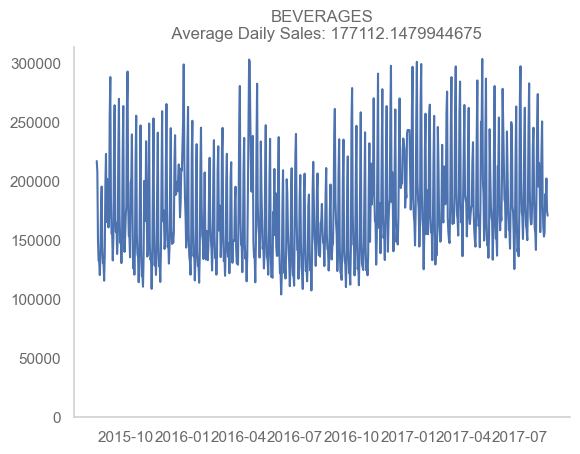

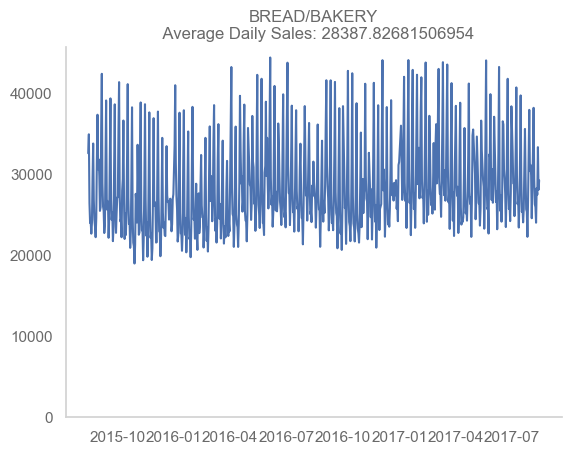

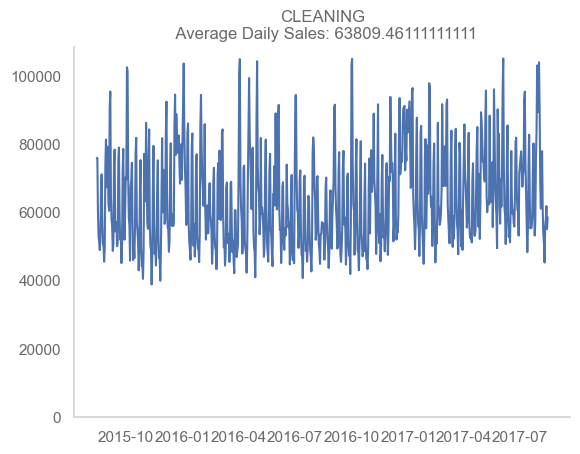

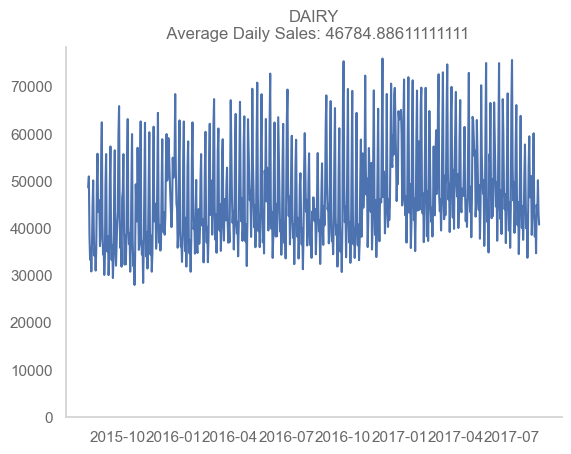

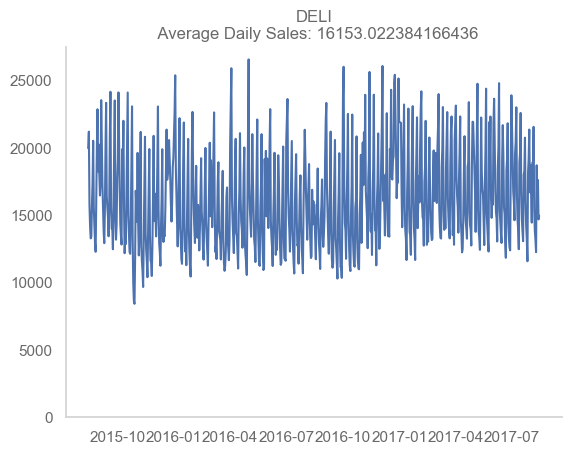

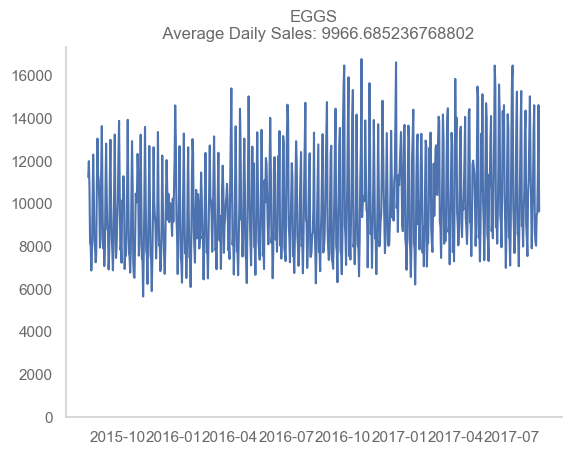

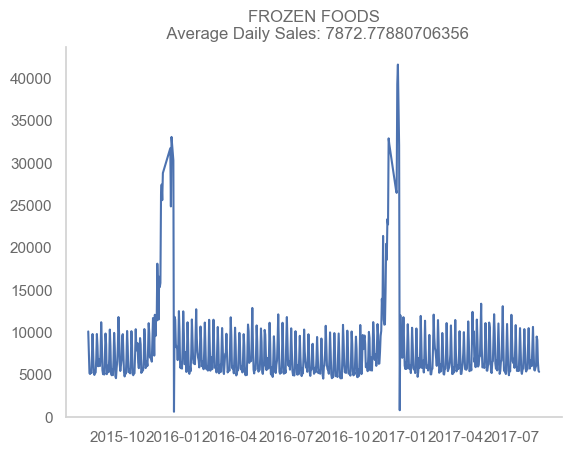

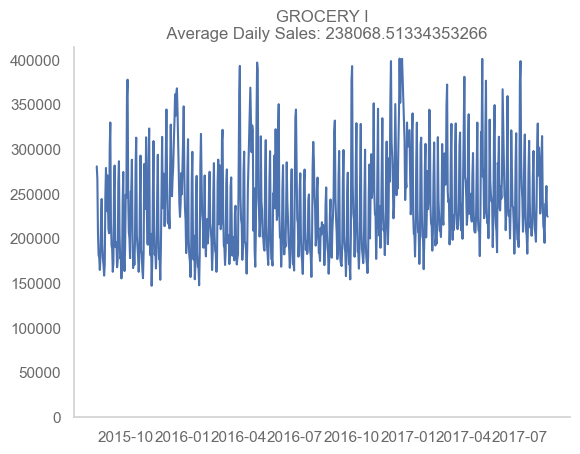

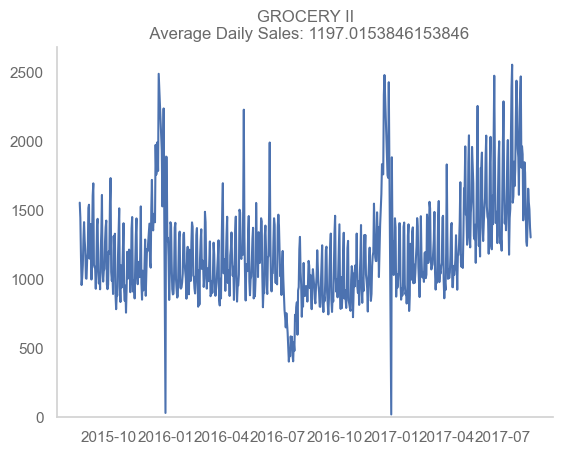

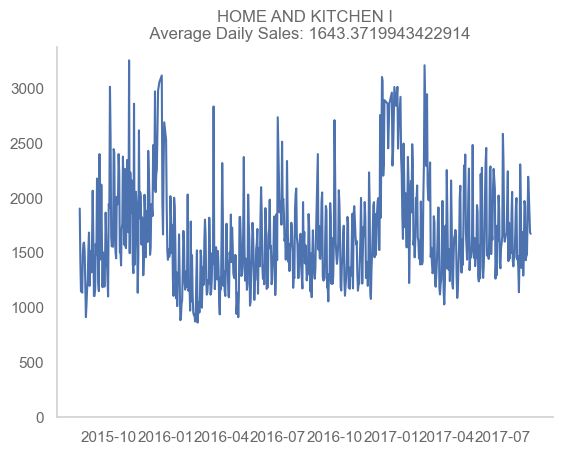

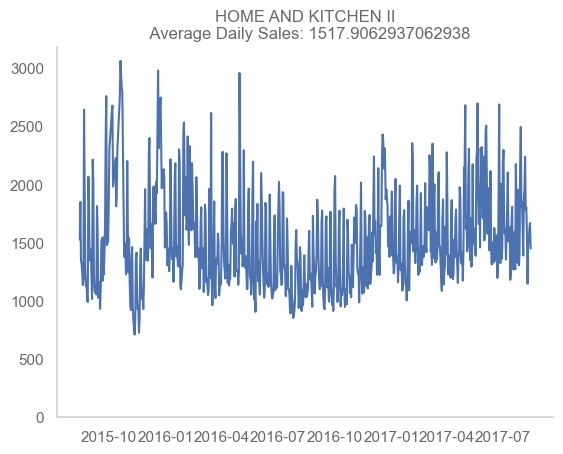

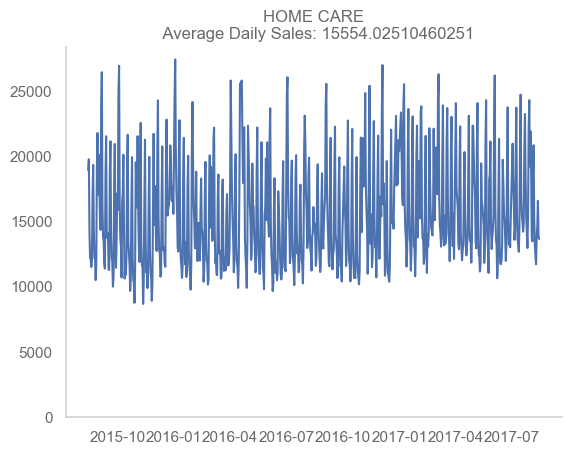

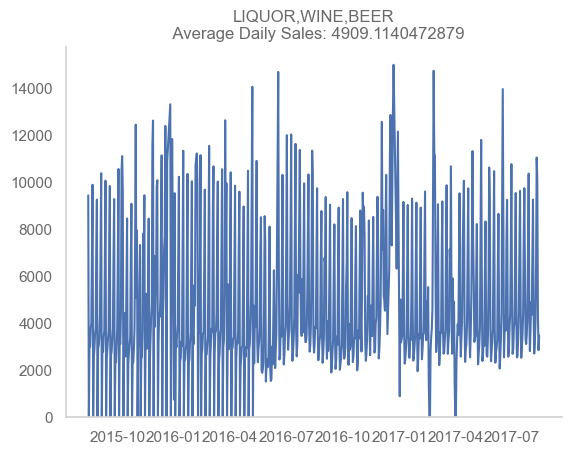

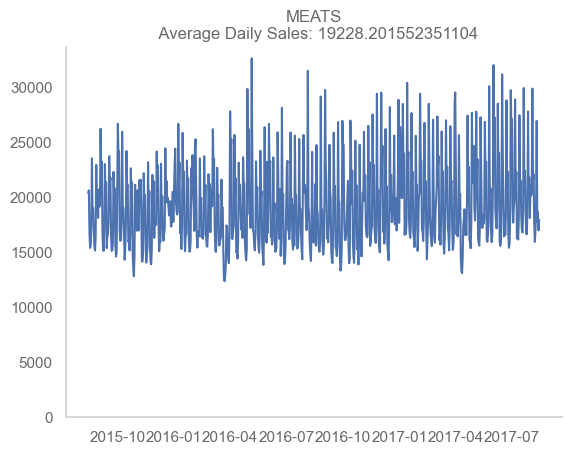

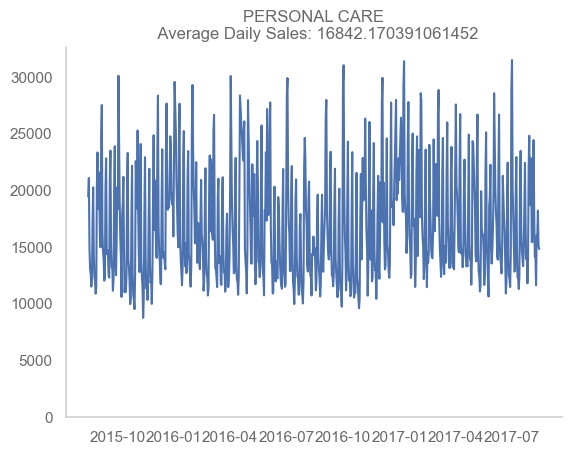

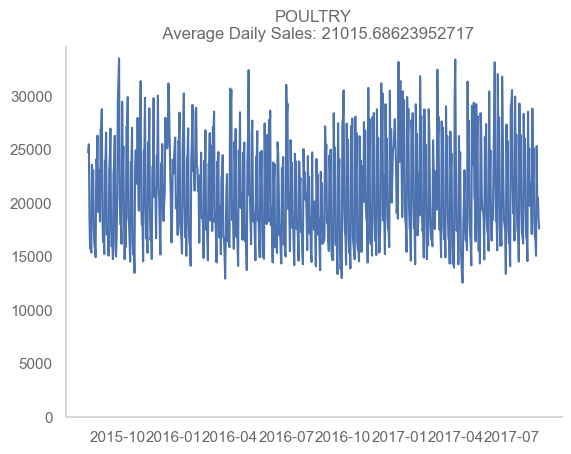

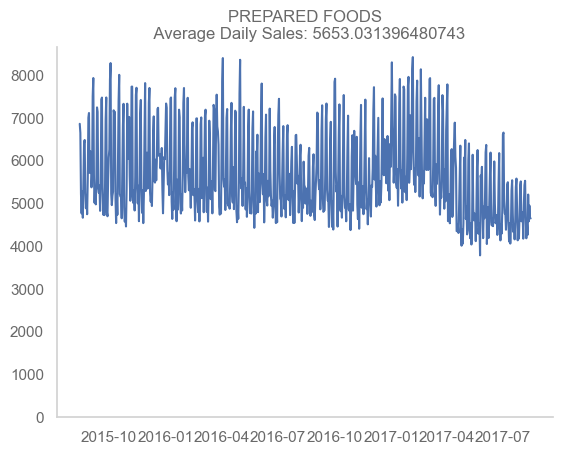

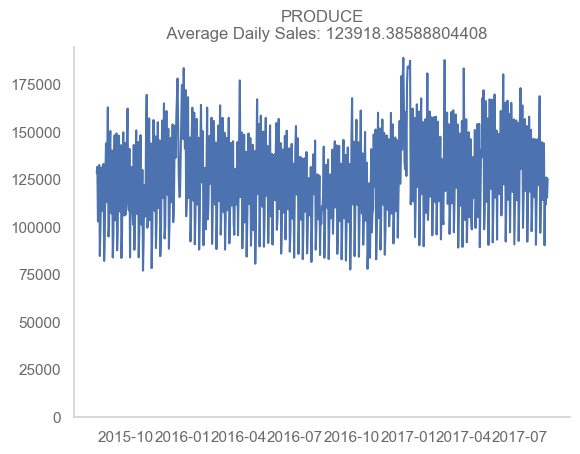

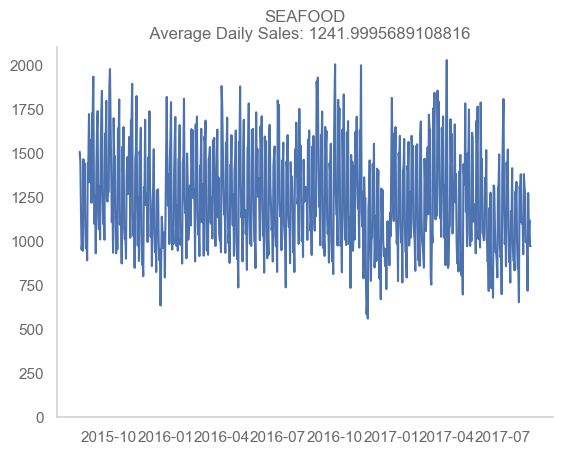

In [316]:
for i in range(len(prediction_df_list)):
    plt.plot(prediction_df_list[i])
    plt.title(prediction_df_list[i].columns[0]+'\n  Average Daily Sales: '+str(prediction_df_list[i].mean()[0]))
    plt.ylim(ymin=0)
    plt.show()

## Plotting Categories

In [324]:
avg_daily_sales = total_sales_df.apply(np.mean,axis=0).sort_values()
low, mid = np.percentile(total_sales_df.apply(np.mean,axis=0).sort_values(),[33,66])

In [326]:
low_vol_columns = avg_daily_sales[avg_daily_sales<=low].index.tolist()
mid_vol_columns = avg_daily_sales[(avg_daily_sales>low) & (avg_daily_sales<mid)].index
high_vol_columns = avg_daily_sales[avg_daily_sales>=mid].index

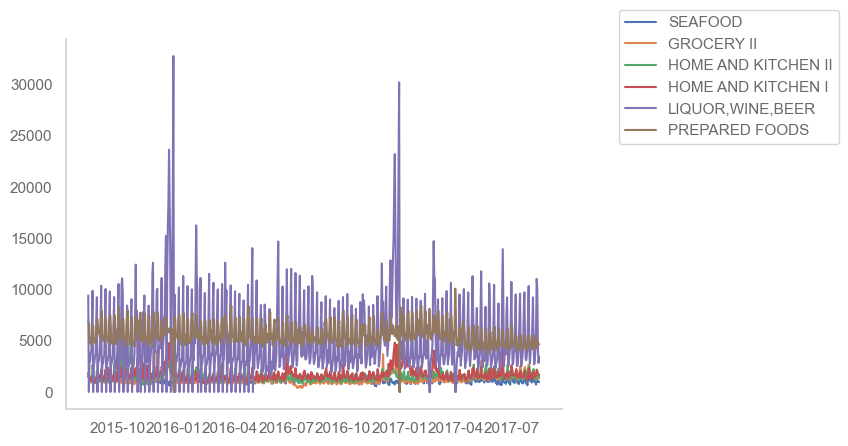

In [329]:
#total_sales_df[low_vol_columns].plot.line()
plt.plot(total_sales_df[low_vol_columns])
plt.legend(low_vol_columns, loc='best' , bbox_to_anchor=(1.1, 1.1))
plt.show()

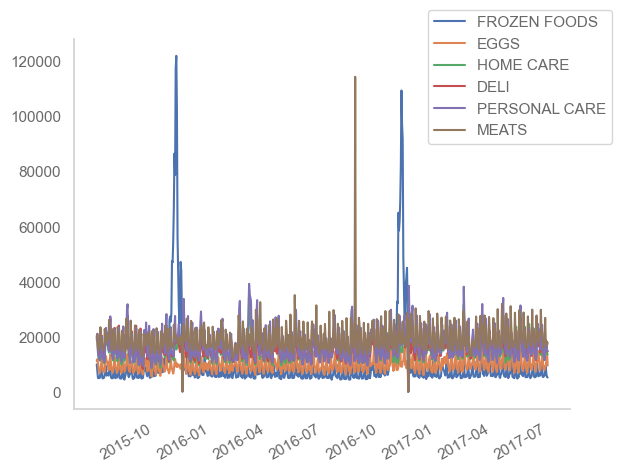

In [330]:
plt.plot(total_sales_df[mid_vol_columns])
plt.legend(mid_vol_columns, loc='best', bbox_to_anchor=(1.1, 1.1))
plt.xticks(rotation=30)
plt.show()

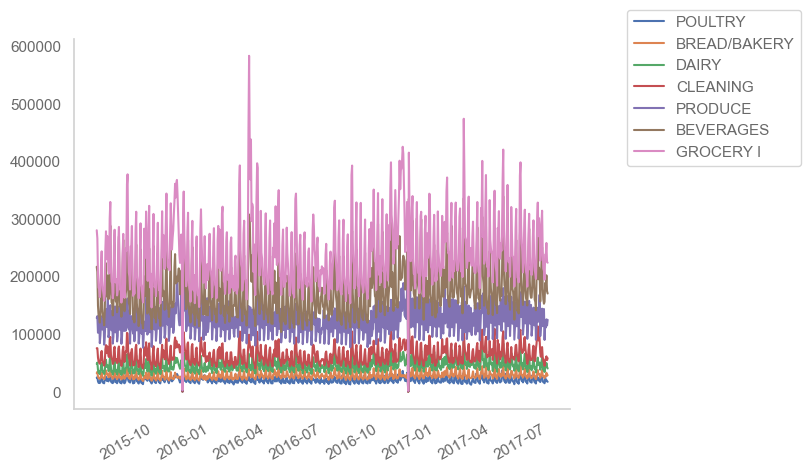

In [331]:
plt.plot(total_sales_df[high_vol_columns])
plt.legend(high_vol_columns, loc='best', bbox_to_anchor=(1.1, 1.1))
plt.xticks(rotation=30)
plt.show()

# Creating a pipeline and hypertuning

1. Ranges give on Prophet's documentation
2. changepoint_prior_scale [0.001, 0.5]
3. seasonality_prior_scale [0.01, 10]
4. holidays_prior_scale [0.01, 10]
5. seasonality_mode ['additive', 'multiplicative'].
6. changepoint_range [0.5, 0.95]



https://facebook.github.io/prophet/docs/diagnostics.html

In [332]:
changepoint_prior_scale_range = np.linspace(0.001, 0.5, num=5).tolist()
print(changepoint_prior_scale_range)

[0.001, 0.12575, 0.2505, 0.37525, 0.5]


In [333]:
seasonality_prior_scale_range = np.linspace(0.01, 10, num=5).tolist()
holidays_prior_scale_range = np.linspace(0.01, 10, num=5).tolist()

#seasonality_mode_options = ['additive', 'multiplicative']
#changepoint_range_range = list(np.linspace(0.5, 0.95, num=5))

In [345]:
start_time = time.time()

dicts = {}

for feature in total_sales_df.columns:
  
    category_df = total_sales_df[feature].copy().reset_index()
    category_df.columns = ["ds", "y"]

    category_df[["y"]] = category_df[["y"]].apply(pd.to_numeric)
    category_df["ds"] = pd.to_datetime(category_df["ds"])
    
    param_grid = {  
        "changepoint_prior_scale": changepoint_prior_scale_range,
        "seasonality_prior_scale": seasonality_prior_scale_range }
        #'holidays_prior_scale': holidays_prior_scale_range,
        #'seasonality_mode': seasonality_mode_options,
        #'changepoint_range': changepoint_range_range,

    # Generate all combinations of parameters
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    mapes = [] 

    # Use cross validation to evaluate all parameters
    for params in all_params:
        m = Prophet(**params).fit(category_df)  # Fit model with given params
        df_cv = cross_validation(m, initial="365 days", period="30 days", horizon = "30 days") #took parallel out
        df_p = performance_metrics(df_cv, rolling_window=1)
        df_p['mape'] = (df_cv['y']-df_cv['yhat']) / df_cv['y'] * 100
        print(df_p)
        mapes.append(df_p["mape"].values[0])

    # Find the best parameters
    tuning_results = pd.DataFrame(all_params)
    tuning_results["mape"] = mapes
    
    print(feature)
    print(tuning_results.head())

    params_dict = dict(tuning_results.sort_values("mape").reset_index(drop=True).iloc[0])
    params_dict["column"] = feature 
    
    dicts[feature] = params_dict

print("--- %s seconds ---" % (time.time() - start_time)) #about 18 minutes

11:54:32 - cmdstanpy - INFO - Chain [1] start processing
11:54:32 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

11:54:32 - cmdstanpy - INFO - Chain [1] start processing
11:54:32 - cmdstanpy - INFO - Chain [1] done processing
11:54:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
11:54:32 - cmdstanpy - INFO - Chain [1] start processing
11:54:33 - cmdstanpy - INFO - Chain [1] done processing
11:54:33 - cmdstanpy - INFO - Chain [1] start processing
11:54:33 - cmdstanpy - INFO - Chain [1] done processing
11:54:33 - cmdstanpy - INFO - Chain [1] start processing
11:54:33 - cmdstanpy - INFO - Chain [1] done processing
11:54:33 - cmdstanpy - INFO - Chain [1] start processing
11:54:33 - cmdstanpy - INFO - Chain [1] done processing
11:54:34 - cmdstanpy - INFO - Chain [1] start processing
11:54:34 - cmdstanpy - INFO - Chain [1] done processing
11:54:34 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
11:54:34 -

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2028209799.08 45035.65 34020.77  3.70   0.16   0.20      0.63


  0%|          | 0/12 [00:00<?, ?it/s]

11:54:40 - cmdstanpy - INFO - Chain [1] start processing
11:54:40 - cmdstanpy - INFO - Chain [1] done processing
11:54:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
11:54:40 - cmdstanpy - INFO - Chain [1] start processing
11:54:41 - cmdstanpy - INFO - Chain [1] done processing
11:54:41 - cmdstanpy - INFO - Chain [1] start processing
11:54:41 - cmdstanpy - INFO - Chain [1] done processing
11:54:41 - cmdstanpy - INFO - Chain [1] start processing
11:54:41 - cmdstanpy - INFO - Chain [1] done processing
11:54:42 - cmdstanpy - INFO - Chain [1] start processing
11:54:42 - cmdstanpy - INFO - Chain [1] done processing
11:54:42 - cmdstanpy - INFO - Chain [1] start processing
11:54:42 - cmdstanpy - INFO - Chain [1] done processing
11:54:42 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
11:54:42 -

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2165302599.09 46532.81 36449.14 -9.63   0.17   0.22      0.54


  0%|          | 0/12 [00:00<?, ?it/s]

11:54:48 - cmdstanpy - INFO - Chain [1] start processing
11:54:48 - cmdstanpy - INFO - Chain [1] done processing
11:54:48 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
11:54:48 - cmdstanpy - INFO - Chain [1] start processing
11:54:49 - cmdstanpy - INFO - Chain [1] done processing
11:54:50 - cmdstanpy - INFO - Chain [1] start processing
11:54:50 - cmdstanpy - INFO - Chain [1] done processing
11:54:50 - cmdstanpy - INFO - Chain [1] start processing
11:54:50 - cmdstanpy - INFO - Chain [1] done processing
11:54:50 - cmdstanpy - INFO - Chain [1] start processing
11:54:50 - cmdstanpy - INFO - Chain [1] done processing
11:54:50 - cmdstanpy - INFO - Chain [1] start processing
11:54:50 - cmdstanpy - INFO - Chain [1] done processing
11:54:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
11:54:50 -

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2168511862.02 46567.28 36416.93 -9.82   0.17   0.22      0.55


  0%|          | 0/12 [00:00<?, ?it/s]

11:54:57 - cmdstanpy - INFO - Chain [1] start processing
11:54:57 - cmdstanpy - INFO - Chain [1] done processing
11:54:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
11:54:57 - cmdstanpy - INFO - Chain [1] start processing
11:54:59 - cmdstanpy - INFO - Chain [1] done processing
11:54:59 - cmdstanpy - INFO - Chain [1] start processing
11:54:59 - cmdstanpy - INFO - Chain [1] done processing
11:54:59 - cmdstanpy - INFO - Chain [1] start processing
11:54:59 - cmdstanpy - INFO - Chain [1] done processing
11:54:59 - cmdstanpy - INFO - Chain [1] start processing
11:54:59 - cmdstanpy - INFO - Chain [1] done processing
11:54:59 - cmdstanpy - INFO - Chain [1] start processing
11:54:59 - cmdstanpy - INFO - Chain [1] done processing
11:54:59 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
11:54:59 -

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2156294745.05 46435.92 36246.97 -9.38   0.17   0.22      0.57


  0%|          | 0/12 [00:00<?, ?it/s]

11:55:06 - cmdstanpy - INFO - Chain [1] start processing
11:55:06 - cmdstanpy - INFO - Chain [1] done processing
11:55:06 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
11:55:06 - cmdstanpy - INFO - Chain [1] start processing
11:55:08 - cmdstanpy - INFO - Chain [1] done processing
11:55:08 - cmdstanpy - INFO - Chain [1] start processing
11:55:08 - cmdstanpy - INFO - Chain [1] done processing
11:55:08 - cmdstanpy - INFO - Chain [1] start processing
11:55:08 - cmdstanpy - INFO - Chain [1] done processing
11:55:08 - cmdstanpy - INFO - Chain [1] start processing
11:55:08 - cmdstanpy - INFO - Chain [1] done processing
11:55:08 - cmdstanpy - INFO - Chain [1] start processing
11:55:08 - cmdstanpy - INFO - Chain [1] done processing
11:55:08 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
11:55:08 -

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2160660388.20 46482.90 36402.67 -9.38   0.17   0.22      0.55


  0%|          | 0/12 [00:00<?, ?it/s]

11:55:15 - cmdstanpy - INFO - Chain [1] start processing
11:55:15 - cmdstanpy - INFO - Chain [1] done processing
11:55:15 - cmdstanpy - INFO - Chain [1] start processing
11:55:15 - cmdstanpy - INFO - Chain [1] done processing
11:55:16 - cmdstanpy - INFO - Chain [1] start processing
11:55:16 - cmdstanpy - INFO - Chain [1] done processing
11:55:16 - cmdstanpy - INFO - Chain [1] start processing
11:55:16 - cmdstanpy - INFO - Chain [1] done processing
11:55:16 - cmdstanpy - INFO - Chain [1] start processing
11:55:16 - cmdstanpy - INFO - Chain [1] done processing
11:55:16 - cmdstanpy - INFO - Chain [1] start processing
11:55:16 - cmdstanpy - INFO - Chain [1] done processing
11:55:16 - cmdstanpy - INFO - Chain [1] start processing
11:55:16 - cmdstanpy - INFO - Chain [1] done processing
11:55:17 - cmdstanpy - INFO - Chain [1] start processing
11:55:17 - cmdstanpy - INFO - Chain [1] done processing
11:55:17 - cmdstanpy - INFO - Chain [1] start processing
11:55:17 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1026634525.53 32041.14 22229.23  3.94   0.09   0.12      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

11:55:18 - cmdstanpy - INFO - Chain [1] start processing
11:55:18 - cmdstanpy - INFO - Chain [1] done processing
11:55:18 - cmdstanpy - INFO - Chain [1] start processing
11:55:18 - cmdstanpy - INFO - Chain [1] done processing
11:55:18 - cmdstanpy - INFO - Chain [1] start processing
11:55:18 - cmdstanpy - INFO - Chain [1] done processing
11:55:18 - cmdstanpy - INFO - Chain [1] start processing
11:55:18 - cmdstanpy - INFO - Chain [1] done processing
11:55:19 - cmdstanpy - INFO - Chain [1] start processing
11:55:19 - cmdstanpy - INFO - Chain [1] done processing
11:55:19 - cmdstanpy - INFO - Chain [1] start processing
11:55:19 - cmdstanpy - INFO - Chain [1] done processing
11:55:19 - cmdstanpy - INFO - Chain [1] start processing
11:55:19 - cmdstanpy - INFO - Chain [1] done processing
11:55:19 - cmdstanpy - INFO - Chain [1] start processing
11:55:19 - cmdstanpy - INFO - Chain [1] done processing
11:55:20 - cmdstanpy - INFO - Chain [1] start processing
11:55:20 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1010590127.30 31789.78 21554.45 -9.82   0.09   0.12      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

11:55:21 - cmdstanpy - INFO - Chain [1] start processing
11:55:21 - cmdstanpy - INFO - Chain [1] done processing
11:55:21 - cmdstanpy - INFO - Chain [1] start processing
11:55:21 - cmdstanpy - INFO - Chain [1] done processing
11:55:21 - cmdstanpy - INFO - Chain [1] start processing
11:55:21 - cmdstanpy - INFO - Chain [1] done processing
11:55:21 - cmdstanpy - INFO - Chain [1] start processing
11:55:21 - cmdstanpy - INFO - Chain [1] done processing
11:55:21 - cmdstanpy - INFO - Chain [1] start processing
11:55:22 - cmdstanpy - INFO - Chain [1] done processing
11:55:22 - cmdstanpy - INFO - Chain [1] start processing
11:55:22 - cmdstanpy - INFO - Chain [1] done processing
11:55:22 - cmdstanpy - INFO - Chain [1] start processing
11:55:22 - cmdstanpy - INFO - Chain [1] done processing
11:55:22 - cmdstanpy - INFO - Chain [1] start processing
11:55:22 - cmdstanpy - INFO - Chain [1] done processing
11:55:22 - cmdstanpy - INFO - Chain [1] start processing
11:55:23 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1006457975.82 31724.72 21475.57 -9.54   0.09   0.12      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

11:55:24 - cmdstanpy - INFO - Chain [1] start processing
11:55:24 - cmdstanpy - INFO - Chain [1] done processing
11:55:24 - cmdstanpy - INFO - Chain [1] start processing
11:55:24 - cmdstanpy - INFO - Chain [1] done processing
11:55:24 - cmdstanpy - INFO - Chain [1] start processing
11:55:24 - cmdstanpy - INFO - Chain [1] done processing
11:55:24 - cmdstanpy - INFO - Chain [1] start processing
11:55:24 - cmdstanpy - INFO - Chain [1] done processing
11:55:24 - cmdstanpy - INFO - Chain [1] start processing
11:55:24 - cmdstanpy - INFO - Chain [1] done processing
11:55:25 - cmdstanpy - INFO - Chain [1] start processing
11:55:25 - cmdstanpy - INFO - Chain [1] done processing
11:55:25 - cmdstanpy - INFO - Chain [1] start processing
11:55:25 - cmdstanpy - INFO - Chain [1] done processing
11:55:25 - cmdstanpy - INFO - Chain [1] start processing
11:55:25 - cmdstanpy - INFO - Chain [1] done processing
11:55:25 - cmdstanpy - INFO - Chain [1] start processing
11:55:25 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1011766896.10 31808.28 21620.93 -9.61   0.09   0.12      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

11:55:26 - cmdstanpy - INFO - Chain [1] start processing
11:55:26 - cmdstanpy - INFO - Chain [1] done processing
11:55:27 - cmdstanpy - INFO - Chain [1] start processing
11:55:27 - cmdstanpy - INFO - Chain [1] done processing
11:55:27 - cmdstanpy - INFO - Chain [1] start processing
11:55:27 - cmdstanpy - INFO - Chain [1] done processing
11:55:27 - cmdstanpy - INFO - Chain [1] start processing
11:55:27 - cmdstanpy - INFO - Chain [1] done processing
11:55:27 - cmdstanpy - INFO - Chain [1] start processing
11:55:27 - cmdstanpy - INFO - Chain [1] done processing
11:55:27 - cmdstanpy - INFO - Chain [1] start processing
11:55:27 - cmdstanpy - INFO - Chain [1] done processing
11:55:28 - cmdstanpy - INFO - Chain [1] start processing
11:55:28 - cmdstanpy - INFO - Chain [1] done processing
11:55:28 - cmdstanpy - INFO - Chain [1] start processing
11:55:28 - cmdstanpy - INFO - Chain [1] done processing
11:55:28 - cmdstanpy - INFO - Chain [1] start processing
11:55:28 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae   mape  mdape  smape  coverage
0 30 days 1012988434.95 31827.48 21578.52 -10.01   0.08   0.12      0.78


11:55:29 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

11:55:29 - cmdstanpy - INFO - Chain [1] start processing
11:55:29 - cmdstanpy - INFO - Chain [1] done processing
11:55:29 - cmdstanpy - INFO - Chain [1] start processing
11:55:30 - cmdstanpy - INFO - Chain [1] done processing
11:55:30 - cmdstanpy - INFO - Chain [1] start processing
11:55:30 - cmdstanpy - INFO - Chain [1] done processing
11:55:30 - cmdstanpy - INFO - Chain [1] start processing
11:55:30 - cmdstanpy - INFO - Chain [1] done processing
11:55:30 - cmdstanpy - INFO - Chain [1] start processing
11:55:30 - cmdstanpy - INFO - Chain [1] done processing
11:55:30 - cmdstanpy - INFO - Chain [1] start processing
11:55:30 - cmdstanpy - INFO - Chain [1] done processing
11:55:30 - cmdstanpy - INFO - Chain [1] start processing
11:55:31 - cmdstanpy - INFO - Chain [1] done processing
11:55:31 - cmdstanpy - INFO - Chain [1] start processing
11:55:31 - cmdstanpy - INFO - Chain [1] done processing
11:55:31 - cmdstanpy - INFO - Chain [1] start processing
11:55:31 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1044160884.22 32313.48 22185.85  4.59   0.09   0.12      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

11:55:32 - cmdstanpy - INFO - Chain [1] start processing
11:55:32 - cmdstanpy - INFO - Chain [1] done processing
11:55:32 - cmdstanpy - INFO - Chain [1] start processing
11:55:32 - cmdstanpy - INFO - Chain [1] done processing
11:55:33 - cmdstanpy - INFO - Chain [1] start processing
11:55:33 - cmdstanpy - INFO - Chain [1] done processing
11:55:33 - cmdstanpy - INFO - Chain [1] start processing
11:55:33 - cmdstanpy - INFO - Chain [1] done processing
11:55:33 - cmdstanpy - INFO - Chain [1] start processing
11:55:33 - cmdstanpy - INFO - Chain [1] done processing
11:55:33 - cmdstanpy - INFO - Chain [1] start processing
11:55:33 - cmdstanpy - INFO - Chain [1] done processing
11:55:33 - cmdstanpy - INFO - Chain [1] start processing
11:55:33 - cmdstanpy - INFO - Chain [1] done processing
11:55:34 - cmdstanpy - INFO - Chain [1] start processing
11:55:34 - cmdstanpy - INFO - Chain [1] done processing
11:55:34 - cmdstanpy - INFO - Chain [1] start processing
11:55:34 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae   mape  mdape  smape  coverage
0 30 days 1063118529.32 32605.50 22110.63 -10.21   0.09   0.12      0.77


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

11:55:35 - cmdstanpy - INFO - Chain [1] start processing
11:55:35 - cmdstanpy - INFO - Chain [1] done processing
11:55:35 - cmdstanpy - INFO - Chain [1] start processing
11:55:35 - cmdstanpy - INFO - Chain [1] done processing
11:55:36 - cmdstanpy - INFO - Chain [1] start processing
11:55:36 - cmdstanpy - INFO - Chain [1] done processing
11:55:36 - cmdstanpy - INFO - Chain [1] start processing
11:55:36 - cmdstanpy - INFO - Chain [1] done processing
11:55:36 - cmdstanpy - INFO - Chain [1] start processing
11:55:36 - cmdstanpy - INFO - Chain [1] done processing
11:55:36 - cmdstanpy - INFO - Chain [1] start processing
11:55:36 - cmdstanpy - INFO - Chain [1] done processing
11:55:36 - cmdstanpy - INFO - Chain [1] start processing
11:55:36 - cmdstanpy - INFO - Chain [1] done processing
11:55:37 - cmdstanpy - INFO - Chain [1] start processing
11:55:37 - cmdstanpy - INFO - Chain [1] done processing
11:55:37 - cmdstanpy - INFO - Chain [1] start processing
11:55:37 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae   mape  mdape  smape  coverage
0 30 days 1079132064.65 32850.15 22359.07 -10.47   0.09   0.12      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

11:55:38 - cmdstanpy - INFO - Chain [1] start processing
11:55:38 - cmdstanpy - INFO - Chain [1] done processing
11:55:38 - cmdstanpy - INFO - Chain [1] start processing
11:55:38 - cmdstanpy - INFO - Chain [1] done processing
11:55:38 - cmdstanpy - INFO - Chain [1] start processing
11:55:38 - cmdstanpy - INFO - Chain [1] done processing
11:55:39 - cmdstanpy - INFO - Chain [1] start processing
11:55:39 - cmdstanpy - INFO - Chain [1] done processing
11:55:39 - cmdstanpy - INFO - Chain [1] start processing
11:55:39 - cmdstanpy - INFO - Chain [1] done processing
11:55:39 - cmdstanpy - INFO - Chain [1] start processing
11:55:39 - cmdstanpy - INFO - Chain [1] done processing
11:55:39 - cmdstanpy - INFO - Chain [1] start processing
11:55:39 - cmdstanpy - INFO - Chain [1] done processing
11:55:39 - cmdstanpy - INFO - Chain [1] start processing
11:55:40 - cmdstanpy - INFO - Chain [1] done processing
11:55:40 - cmdstanpy - INFO - Chain [1] start processing
11:55:40 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae   mape  mdape  smape  coverage
0 30 days 1077545731.15 32825.99 22319.58 -10.23   0.09   0.12      0.77


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

11:55:41 - cmdstanpy - INFO - Chain [1] start processing
11:55:41 - cmdstanpy - INFO - Chain [1] done processing
11:55:41 - cmdstanpy - INFO - Chain [1] start processing
11:55:41 - cmdstanpy - INFO - Chain [1] done processing
11:55:41 - cmdstanpy - INFO - Chain [1] start processing
11:55:42 - cmdstanpy - INFO - Chain [1] done processing
11:55:42 - cmdstanpy - INFO - Chain [1] start processing
11:55:42 - cmdstanpy - INFO - Chain [1] done processing
11:55:42 - cmdstanpy - INFO - Chain [1] start processing
11:55:42 - cmdstanpy - INFO - Chain [1] done processing
11:55:42 - cmdstanpy - INFO - Chain [1] start processing
11:55:42 - cmdstanpy - INFO - Chain [1] done processing
11:55:42 - cmdstanpy - INFO - Chain [1] start processing
11:55:42 - cmdstanpy - INFO - Chain [1] done processing
11:55:43 - cmdstanpy - INFO - Chain [1] start processing
11:55:43 - cmdstanpy - INFO - Chain [1] done processing
11:55:43 - cmdstanpy - INFO - Chain [1] start processing
11:55:43 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae   mape  mdape  smape  coverage
0 30 days 1067599718.14 32674.14 22183.68 -10.12   0.09   0.12      0.78


11:55:44 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

11:55:44 - cmdstanpy - INFO - Chain [1] start processing
11:55:44 - cmdstanpy - INFO - Chain [1] done processing
11:55:44 - cmdstanpy - INFO - Chain [1] start processing
11:55:44 - cmdstanpy - INFO - Chain [1] done processing
11:55:45 - cmdstanpy - INFO - Chain [1] start processing
11:55:45 - cmdstanpy - INFO - Chain [1] done processing
11:55:45 - cmdstanpy - INFO - Chain [1] start processing
11:55:45 - cmdstanpy - INFO - Chain [1] done processing
11:55:45 - cmdstanpy - INFO - Chain [1] start processing
11:55:45 - cmdstanpy - INFO - Chain [1] done processing
11:55:45 - cmdstanpy - INFO - Chain [1] start processing
11:55:45 - cmdstanpy - INFO - Chain [1] done processing
11:55:45 - cmdstanpy - INFO - Chain [1] start processing
11:55:46 - cmdstanpy - INFO - Chain [1] done processing
11:55:46 - cmdstanpy - INFO - Chain [1] start processing
11:55:46 - cmdstanpy - INFO - Chain [1] done processing
11:55:46 - cmdstanpy - INFO - Chain [1] start processing
11:55:46 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1044933773.43 32325.44 22078.23  4.65   0.09   0.12      0.77


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

11:55:47 - cmdstanpy - INFO - Chain [1] start processing
11:55:48 - cmdstanpy - INFO - Chain [1] done processing
11:55:48 - cmdstanpy - INFO - Chain [1] start processing
11:55:48 - cmdstanpy - INFO - Chain [1] done processing
11:55:48 - cmdstanpy - INFO - Chain [1] start processing
11:55:48 - cmdstanpy - INFO - Chain [1] done processing
11:55:48 - cmdstanpy - INFO - Chain [1] start processing
11:55:48 - cmdstanpy - INFO - Chain [1] done processing
11:55:48 - cmdstanpy - INFO - Chain [1] start processing
11:55:48 - cmdstanpy - INFO - Chain [1] done processing
11:55:49 - cmdstanpy - INFO - Chain [1] start processing
11:55:49 - cmdstanpy - INFO - Chain [1] done processing
11:55:49 - cmdstanpy - INFO - Chain [1] start processing
11:55:49 - cmdstanpy - INFO - Chain [1] done processing
11:55:49 - cmdstanpy - INFO - Chain [1] start processing
11:55:49 - cmdstanpy - INFO - Chain [1] done processing
11:55:49 - cmdstanpy - INFO - Chain [1] start processing
11:55:49 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae   mape  mdape  smape  coverage
0 30 days 1111733319.29 33342.67 23024.15 -10.16   0.10   0.13      0.75


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

11:55:51 - cmdstanpy - INFO - Chain [1] start processing
11:55:51 - cmdstanpy - INFO - Chain [1] done processing
11:55:51 - cmdstanpy - INFO - Chain [1] start processing
11:55:51 - cmdstanpy - INFO - Chain [1] done processing
11:55:51 - cmdstanpy - INFO - Chain [1] start processing
11:55:51 - cmdstanpy - INFO - Chain [1] done processing
11:55:51 - cmdstanpy - INFO - Chain [1] start processing
11:55:51 - cmdstanpy - INFO - Chain [1] done processing
11:55:51 - cmdstanpy - INFO - Chain [1] start processing
11:55:51 - cmdstanpy - INFO - Chain [1] done processing
11:55:52 - cmdstanpy - INFO - Chain [1] start processing
11:55:52 - cmdstanpy - INFO - Chain [1] done processing
11:55:52 - cmdstanpy - INFO - Chain [1] start processing
11:55:52 - cmdstanpy - INFO - Chain [1] done processing
11:55:52 - cmdstanpy - INFO - Chain [1] start processing
11:55:52 - cmdstanpy - INFO - Chain [1] done processing
11:55:52 - cmdstanpy - INFO - Chain [1] start processing
11:55:52 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae   mape  mdape  smape  coverage
0 30 days 1121132096.08 33483.31 23203.17 -10.27   0.10   0.13      0.76


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

11:55:54 - cmdstanpy - INFO - Chain [1] start processing
11:55:54 - cmdstanpy - INFO - Chain [1] done processing
11:55:54 - cmdstanpy - INFO - Chain [1] start processing
11:55:54 - cmdstanpy - INFO - Chain [1] done processing
11:55:54 - cmdstanpy - INFO - Chain [1] start processing
11:55:54 - cmdstanpy - INFO - Chain [1] done processing
11:55:54 - cmdstanpy - INFO - Chain [1] start processing
11:55:54 - cmdstanpy - INFO - Chain [1] done processing
11:55:54 - cmdstanpy - INFO - Chain [1] start processing
11:55:54 - cmdstanpy - INFO - Chain [1] done processing
11:55:55 - cmdstanpy - INFO - Chain [1] start processing
11:55:55 - cmdstanpy - INFO - Chain [1] done processing
11:55:55 - cmdstanpy - INFO - Chain [1] start processing
11:55:55 - cmdstanpy - INFO - Chain [1] done processing
11:55:55 - cmdstanpy - INFO - Chain [1] start processing
11:55:55 - cmdstanpy - INFO - Chain [1] done processing
11:55:55 - cmdstanpy - INFO - Chain [1] start processing
11:55:55 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae   mape  mdape  smape  coverage
0 30 days 1110799211.59 33328.65 23058.06 -10.13   0.10   0.13      0.75


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

11:55:57 - cmdstanpy - INFO - Chain [1] start processing
11:55:57 - cmdstanpy - INFO - Chain [1] done processing
11:55:57 - cmdstanpy - INFO - Chain [1] start processing
11:55:57 - cmdstanpy - INFO - Chain [1] done processing
11:55:57 - cmdstanpy - INFO - Chain [1] start processing
11:55:57 - cmdstanpy - INFO - Chain [1] done processing
11:55:57 - cmdstanpy - INFO - Chain [1] start processing
11:55:57 - cmdstanpy - INFO - Chain [1] done processing
11:55:57 - cmdstanpy - INFO - Chain [1] start processing
11:55:58 - cmdstanpy - INFO - Chain [1] done processing
11:55:58 - cmdstanpy - INFO - Chain [1] start processing
11:55:58 - cmdstanpy - INFO - Chain [1] done processing
11:55:58 - cmdstanpy - INFO - Chain [1] start processing
11:55:58 - cmdstanpy - INFO - Chain [1] done processing
11:55:58 - cmdstanpy - INFO - Chain [1] start processing
11:55:58 - cmdstanpy - INFO - Chain [1] done processing
11:55:58 - cmdstanpy - INFO - Chain [1] start processing
11:55:58 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae   mape  mdape  smape  coverage
0 30 days 1117021668.05 33421.87 23170.05 -10.35   0.10   0.13      0.75


11:56:00 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

11:56:00 - cmdstanpy - INFO - Chain [1] start processing
11:56:00 - cmdstanpy - INFO - Chain [1] done processing
11:56:00 - cmdstanpy - INFO - Chain [1] start processing
11:56:00 - cmdstanpy - INFO - Chain [1] done processing
11:56:00 - cmdstanpy - INFO - Chain [1] start processing
11:56:00 - cmdstanpy - INFO - Chain [1] done processing
11:56:00 - cmdstanpy - INFO - Chain [1] start processing
11:56:00 - cmdstanpy - INFO - Chain [1] done processing
11:56:00 - cmdstanpy - INFO - Chain [1] start processing
11:56:01 - cmdstanpy - INFO - Chain [1] done processing
11:56:01 - cmdstanpy - INFO - Chain [1] start processing
11:56:01 - cmdstanpy - INFO - Chain [1] done processing
11:56:01 - cmdstanpy - INFO - Chain [1] start processing
11:56:01 - cmdstanpy - INFO - Chain [1] done processing
11:56:01 - cmdstanpy - INFO - Chain [1] start processing
11:56:01 - cmdstanpy - INFO - Chain [1] done processing
11:56:01 - cmdstanpy - INFO - Chain [1] start processing
11:56:01 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1024394602.94 32006.17 21824.36  4.25   0.09   0.12      0.79


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

11:56:03 - cmdstanpy - INFO - Chain [1] start processing
11:56:03 - cmdstanpy - INFO - Chain [1] done processing
11:56:03 - cmdstanpy - INFO - Chain [1] start processing
11:56:03 - cmdstanpy - INFO - Chain [1] done processing
11:56:03 - cmdstanpy - INFO - Chain [1] start processing
11:56:03 - cmdstanpy - INFO - Chain [1] done processing
11:56:03 - cmdstanpy - INFO - Chain [1] start processing
11:56:04 - cmdstanpy - INFO - Chain [1] done processing
11:56:04 - cmdstanpy - INFO - Chain [1] start processing
11:56:04 - cmdstanpy - INFO - Chain [1] done processing
11:56:04 - cmdstanpy - INFO - Chain [1] start processing
11:56:04 - cmdstanpy - INFO - Chain [1] done processing
11:56:04 - cmdstanpy - INFO - Chain [1] start processing
11:56:04 - cmdstanpy - INFO - Chain [1] done processing
11:56:04 - cmdstanpy - INFO - Chain [1] start processing
11:56:05 - cmdstanpy - INFO - Chain [1] done processing
11:56:05 - cmdstanpy - INFO - Chain [1] start processing
11:56:05 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae   mape  mdape  smape  coverage
0 30 days 1164552037.93 34125.53 23962.70 -10.20   0.10   0.13      0.74


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

11:56:06 - cmdstanpy - INFO - Chain [1] start processing
11:56:06 - cmdstanpy - INFO - Chain [1] done processing
11:56:06 - cmdstanpy - INFO - Chain [1] start processing
11:56:06 - cmdstanpy - INFO - Chain [1] done processing
11:56:06 - cmdstanpy - INFO - Chain [1] start processing
11:56:07 - cmdstanpy - INFO - Chain [1] done processing
11:56:07 - cmdstanpy - INFO - Chain [1] start processing
11:56:07 - cmdstanpy - INFO - Chain [1] done processing
11:56:07 - cmdstanpy - INFO - Chain [1] start processing
11:56:07 - cmdstanpy - INFO - Chain [1] done processing
11:56:07 - cmdstanpy - INFO - Chain [1] start processing
11:56:07 - cmdstanpy - INFO - Chain [1] done processing
11:56:07 - cmdstanpy - INFO - Chain [1] start processing
11:56:07 - cmdstanpy - INFO - Chain [1] done processing
11:56:08 - cmdstanpy - INFO - Chain [1] start processing
11:56:08 - cmdstanpy - INFO - Chain [1] done processing
11:56:08 - cmdstanpy - INFO - Chain [1] start processing
11:56:08 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae   mape  mdape  smape  coverage
0 30 days 1155797842.89 33997.03 23877.77 -10.18   0.11   0.13      0.75


11:56:09 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

11:56:09 - cmdstanpy - INFO - Chain [1] start processing
11:56:09 - cmdstanpy - INFO - Chain [1] done processing
11:56:09 - cmdstanpy - INFO - Chain [1] start processing
11:56:10 - cmdstanpy - INFO - Chain [1] done processing
11:56:10 - cmdstanpy - INFO - Chain [1] start processing
11:56:10 - cmdstanpy - INFO - Chain [1] done processing
11:56:10 - cmdstanpy - INFO - Chain [1] start processing
11:56:10 - cmdstanpy - INFO - Chain [1] done processing
11:56:10 - cmdstanpy - INFO - Chain [1] start processing
11:56:10 - cmdstanpy - INFO - Chain [1] done processing
11:56:10 - cmdstanpy - INFO - Chain [1] start processing
11:56:10 - cmdstanpy - INFO - Chain [1] done processing
11:56:11 - cmdstanpy - INFO - Chain [1] start processing
11:56:11 - cmdstanpy - INFO - Chain [1] done processing
11:56:11 - cmdstanpy - INFO - Chain [1] start processing
11:56:11 - cmdstanpy - INFO - Chain [1] done processing
11:56:11 - cmdstanpy - INFO - Chain [1] start processing
11:56:11 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae   mape  mdape  smape  coverage
0 30 days 1158164956.02 34031.82 23842.01 -10.40   0.10   0.13      0.75


11:56:13 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

11:56:13 - cmdstanpy - INFO - Chain [1] start processing
11:56:13 - cmdstanpy - INFO - Chain [1] done processing
11:56:13 - cmdstanpy - INFO - Chain [1] start processing
11:56:13 - cmdstanpy - INFO - Chain [1] done processing
11:56:13 - cmdstanpy - INFO - Chain [1] start processing
11:56:13 - cmdstanpy - INFO - Chain [1] done processing
11:56:13 - cmdstanpy - INFO - Chain [1] start processing
11:56:13 - cmdstanpy - INFO - Chain [1] done processing
11:56:13 - cmdstanpy - INFO - Chain [1] start processing
11:56:14 - cmdstanpy - INFO - Chain [1] done processing
11:56:14 - cmdstanpy - INFO - Chain [1] start processing
11:56:14 - cmdstanpy - INFO - Chain [1] done processing
11:56:14 - cmdstanpy - INFO - Chain [1] start processing
11:56:14 - cmdstanpy - INFO - Chain [1] done processing
11:56:14 - cmdstanpy - INFO - Chain [1] start processing
11:56:14 - cmdstanpy - INFO - Chain [1] done processing
11:56:14 - cmdstanpy - INFO - Chain [1] start processing
11:56:15 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae   mape  mdape  smape  coverage
0 30 days 1163580432.70 34111.29 23881.33 -10.20   0.11   0.13      0.74
BEVERAGES
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  3.70
1                     0.00                     2.51 -9.63
2                     0.00                     5.00 -9.82
3                     0.00                     7.50 -9.38
4                     0.00                    10.00 -9.38


  0%|          | 0/12 [00:00<?, ?it/s]

11:56:16 - cmdstanpy - INFO - Chain [1] start processing
11:56:16 - cmdstanpy - INFO - Chain [1] done processing
11:56:16 - cmdstanpy - INFO - Chain [1] start processing
11:56:16 - cmdstanpy - INFO - Chain [1] done processing
11:56:16 - cmdstanpy - INFO - Chain [1] start processing
11:56:16 - cmdstanpy - INFO - Chain [1] done processing
11:56:16 - cmdstanpy - INFO - Chain [1] start processing
11:56:16 - cmdstanpy - INFO - Chain [1] done processing
11:56:17 - cmdstanpy - INFO - Chain [1] start processing
11:56:17 - cmdstanpy - INFO - Chain [1] done processing
11:56:17 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
11:56:17 - cmdstanpy - INFO - Chain [1] start processing
11:56:18 - cmdstanpy - INFO - Chain [1] done processing
11:56:18 - cmdstanpy - INFO - Chain [1] start processing
11:56:18 - cmdstanpy - INFO - Chain [1] done processing
11:56:18 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 18054165.88 4249.02 2854.56  7.88   0.07   0.10      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

11:56:23 - cmdstanpy - INFO - Chain [1] start processing
11:56:23 - cmdstanpy - INFO - Chain [1] done processing
11:56:23 - cmdstanpy - INFO - Chain [1] start processing
11:56:23 - cmdstanpy - INFO - Chain [1] done processing
11:56:23 - cmdstanpy - INFO - Chain [1] start processing
11:56:23 - cmdstanpy - INFO - Chain [1] done processing
11:56:23 - cmdstanpy - INFO - Chain [1] start processing
11:56:23 - cmdstanpy - INFO - Chain [1] done processing
11:56:23 - cmdstanpy - INFO - Chain [1] start processing
11:56:23 - cmdstanpy - INFO - Chain [1] done processing
11:56:23 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
11:56:23 - cmdstanpy - INFO - Chain [1] start processing
11:56:26 - cmdstanpy - INFO - Chain [1] done processing
11:56:26 - cmdstanpy - INFO - Chain [1] start processing
11:56:26 - cmdstanpy - INFO - Chain [1] done processing
11:56:27 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 20599117.92 4538.63 3212.78 -2.25   0.08   0.11      0.70


  0%|          | 0/12 [00:00<?, ?it/s]

11:56:31 - cmdstanpy - INFO - Chain [1] start processing
11:56:31 - cmdstanpy - INFO - Chain [1] done processing
11:56:31 - cmdstanpy - INFO - Chain [1] start processing
11:56:31 - cmdstanpy - INFO - Chain [1] done processing
11:56:32 - cmdstanpy - INFO - Chain [1] start processing
11:56:32 - cmdstanpy - INFO - Chain [1] done processing
11:56:32 - cmdstanpy - INFO - Chain [1] start processing
11:56:32 - cmdstanpy - INFO - Chain [1] done processing
11:56:32 - cmdstanpy - INFO - Chain [1] start processing
11:56:32 - cmdstanpy - INFO - Chain [1] done processing
11:56:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
11:56:32 - cmdstanpy - INFO - Chain [1] start processing
11:56:33 - cmdstanpy - INFO - Chain [1] done processing
11:56:33 - cmdstanpy - INFO - Chain [1] start processing
11:56:33 - cmdstanpy - INFO - Chain [1] done processing
11:56:33 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 19907644.30 4461.80 3141.26 -2.21   0.09   0.11      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

11:56:39 - cmdstanpy - INFO - Chain [1] start processing
11:56:39 - cmdstanpy - INFO - Chain [1] done processing
11:56:39 - cmdstanpy - INFO - Chain [1] start processing
11:56:39 - cmdstanpy - INFO - Chain [1] done processing
11:56:39 - cmdstanpy - INFO - Chain [1] start processing
11:56:39 - cmdstanpy - INFO - Chain [1] done processing
11:56:39 - cmdstanpy - INFO - Chain [1] start processing
11:56:39 - cmdstanpy - INFO - Chain [1] done processing
11:56:39 - cmdstanpy - INFO - Chain [1] start processing
11:56:39 - cmdstanpy - INFO - Chain [1] done processing
11:56:39 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
11:56:39 - cmdstanpy - INFO - Chain [1] start processing
11:56:40 - cmdstanpy - INFO - Chain [1] done processing
11:56:40 - cmdstanpy - INFO - Chain [1] start processing
11:56:41 - cmdstanpy - INFO - Chain [1] done processing
11:56:41 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 18193988.74 4265.44 2961.87 -2.22   0.08   0.10      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

11:56:45 - cmdstanpy - INFO - Chain [1] start processing
11:56:45 - cmdstanpy - INFO - Chain [1] done processing
11:56:45 - cmdstanpy - INFO - Chain [1] start processing
11:56:45 - cmdstanpy - INFO - Chain [1] done processing
11:56:45 - cmdstanpy - INFO - Chain [1] start processing
11:56:46 - cmdstanpy - INFO - Chain [1] done processing
11:56:46 - cmdstanpy - INFO - Chain [1] start processing
11:56:46 - cmdstanpy - INFO - Chain [1] done processing
11:56:46 - cmdstanpy - INFO - Chain [1] start processing
11:56:46 - cmdstanpy - INFO - Chain [1] done processing
11:56:46 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
11:56:46 - cmdstanpy - INFO - Chain [1] start processing
11:56:47 - cmdstanpy - INFO - Chain [1] done processing
11:56:47 - cmdstanpy - INFO - Chain [1] start processing
11:56:47 - cmdstanpy - INFO - Chain [1] done processing
11:56:48 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 20175275.30 4491.69 3166.23 -2.21   0.08   0.11      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

11:56:52 - cmdstanpy - INFO - Chain [1] start processing
11:56:52 - cmdstanpy - INFO - Chain [1] done processing
11:56:52 - cmdstanpy - INFO - Chain [1] start processing
11:56:52 - cmdstanpy - INFO - Chain [1] done processing
11:56:53 - cmdstanpy - INFO - Chain [1] start processing
11:56:53 - cmdstanpy - INFO - Chain [1] done processing
11:56:53 - cmdstanpy - INFO - Chain [1] start processing
11:56:53 - cmdstanpy - INFO - Chain [1] done processing
11:56:53 - cmdstanpy - INFO - Chain [1] start processing
11:56:53 - cmdstanpy - INFO - Chain [1] done processing
11:56:53 - cmdstanpy - INFO - Chain [1] start processing
11:56:53 - cmdstanpy - INFO - Chain [1] done processing
11:56:53 - cmdstanpy - INFO - Chain [1] start processing
11:56:53 - cmdstanpy - INFO - Chain [1] done processing
11:56:54 - cmdstanpy - INFO - Chain [1] start processing
11:56:54 - cmdstanpy - INFO - Chain [1] done processing
11:56:54 - cmdstanpy - INFO - Chain [1] start processing
11:56:54 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14428867.45 3798.53 2578.39 -2.96   0.07   0.09      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

11:56:55 - cmdstanpy - INFO - Chain [1] start processing
11:56:55 - cmdstanpy - INFO - Chain [1] done processing
11:56:55 - cmdstanpy - INFO - Chain [1] start processing
11:56:55 - cmdstanpy - INFO - Chain [1] done processing
11:56:55 - cmdstanpy - INFO - Chain [1] start processing
11:56:55 - cmdstanpy - INFO - Chain [1] done processing
11:56:56 - cmdstanpy - INFO - Chain [1] start processing
11:56:56 - cmdstanpy - INFO - Chain [1] done processing
11:56:56 - cmdstanpy - INFO - Chain [1] start processing
11:56:56 - cmdstanpy - INFO - Chain [1] done processing
11:56:56 - cmdstanpy - INFO - Chain [1] start processing
11:56:56 - cmdstanpy - INFO - Chain [1] done processing
11:56:56 - cmdstanpy - INFO - Chain [1] start processing
11:56:56 - cmdstanpy - INFO - Chain [1] done processing
11:56:56 - cmdstanpy - INFO - Chain [1] start processing
11:56:56 - cmdstanpy - INFO - Chain [1] done processing
11:56:57 - cmdstanpy - INFO - Chain [1] start processing
11:56:57 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14747390.00 3840.23 2510.32 -6.85   0.06   0.09      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

11:56:58 - cmdstanpy - INFO - Chain [1] start processing
11:56:58 - cmdstanpy - INFO - Chain [1] done processing
11:56:58 - cmdstanpy - INFO - Chain [1] start processing
11:56:58 - cmdstanpy - INFO - Chain [1] done processing
11:56:58 - cmdstanpy - INFO - Chain [1] start processing
11:56:58 - cmdstanpy - INFO - Chain [1] done processing
11:56:58 - cmdstanpy - INFO - Chain [1] start processing
11:56:58 - cmdstanpy - INFO - Chain [1] done processing
11:56:58 - cmdstanpy - INFO - Chain [1] start processing
11:56:58 - cmdstanpy - INFO - Chain [1] done processing
11:56:59 - cmdstanpy - INFO - Chain [1] start processing
11:56:59 - cmdstanpy - INFO - Chain [1] done processing
11:56:59 - cmdstanpy - INFO - Chain [1] start processing
11:56:59 - cmdstanpy - INFO - Chain [1] done processing
11:56:59 - cmdstanpy - INFO - Chain [1] start processing
11:56:59 - cmdstanpy - INFO - Chain [1] done processing
11:56:59 - cmdstanpy - INFO - Chain [1] start processing
11:56:59 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14786508.69 3845.32 2511.54 -7.09   0.06   0.09      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

11:57:00 - cmdstanpy - INFO - Chain [1] start processing
11:57:00 - cmdstanpy - INFO - Chain [1] done processing
11:57:01 - cmdstanpy - INFO - Chain [1] start processing
11:57:01 - cmdstanpy - INFO - Chain [1] done processing
11:57:01 - cmdstanpy - INFO - Chain [1] start processing
11:57:01 - cmdstanpy - INFO - Chain [1] done processing
11:57:01 - cmdstanpy - INFO - Chain [1] start processing
11:57:01 - cmdstanpy - INFO - Chain [1] done processing
11:57:01 - cmdstanpy - INFO - Chain [1] start processing
11:57:01 - cmdstanpy - INFO - Chain [1] done processing
11:57:01 - cmdstanpy - INFO - Chain [1] start processing
11:57:01 - cmdstanpy - INFO - Chain [1] done processing
11:57:02 - cmdstanpy - INFO - Chain [1] start processing
11:57:02 - cmdstanpy - INFO - Chain [1] done processing
11:57:02 - cmdstanpy - INFO - Chain [1] start processing
11:57:02 - cmdstanpy - INFO - Chain [1] done processing
11:57:02 - cmdstanpy - INFO - Chain [1] start processing
11:57:02 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14804989.08 3847.73 2518.59 -7.09   0.07   0.09      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

11:57:03 - cmdstanpy - INFO - Chain [1] start processing
11:57:03 - cmdstanpy - INFO - Chain [1] done processing
11:57:03 - cmdstanpy - INFO - Chain [1] start processing
11:57:03 - cmdstanpy - INFO - Chain [1] done processing
11:57:04 - cmdstanpy - INFO - Chain [1] start processing
11:57:04 - cmdstanpy - INFO - Chain [1] done processing
11:57:04 - cmdstanpy - INFO - Chain [1] start processing
11:57:04 - cmdstanpy - INFO - Chain [1] done processing
11:57:04 - cmdstanpy - INFO - Chain [1] start processing
11:57:04 - cmdstanpy - INFO - Chain [1] done processing
11:57:04 - cmdstanpy - INFO - Chain [1] start processing
11:57:04 - cmdstanpy - INFO - Chain [1] done processing
11:57:04 - cmdstanpy - INFO - Chain [1] start processing
11:57:04 - cmdstanpy - INFO - Chain [1] done processing
11:57:05 - cmdstanpy - INFO - Chain [1] start processing
11:57:05 - cmdstanpy - INFO - Chain [1] done processing
11:57:05 - cmdstanpy - INFO - Chain [1] start processing
11:57:05 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14809709.15 3848.34 2526.77 -7.02   0.07   0.09      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

11:57:06 - cmdstanpy - INFO - Chain [1] start processing
11:57:06 - cmdstanpy - INFO - Chain [1] done processing
11:57:06 - cmdstanpy - INFO - Chain [1] start processing
11:57:06 - cmdstanpy - INFO - Chain [1] done processing
11:57:06 - cmdstanpy - INFO - Chain [1] start processing
11:57:06 - cmdstanpy - INFO - Chain [1] done processing
11:57:06 - cmdstanpy - INFO - Chain [1] start processing
11:57:07 - cmdstanpy - INFO - Chain [1] done processing
11:57:07 - cmdstanpy - INFO - Chain [1] start processing
11:57:07 - cmdstanpy - INFO - Chain [1] done processing
11:57:07 - cmdstanpy - INFO - Chain [1] start processing
11:57:07 - cmdstanpy - INFO - Chain [1] done processing
11:57:07 - cmdstanpy - INFO - Chain [1] start processing
11:57:07 - cmdstanpy - INFO - Chain [1] done processing
11:57:07 - cmdstanpy - INFO - Chain [1] start processing
11:57:07 - cmdstanpy - INFO - Chain [1] done processing
11:57:08 - cmdstanpy - INFO - Chain [1] start processing
11:57:08 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14065790.70 3750.44 2481.21 -2.28   0.07   0.08      0.82


11:57:09 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

11:57:09 - cmdstanpy - INFO - Chain [1] start processing
11:57:09 - cmdstanpy - INFO - Chain [1] done processing
11:57:09 - cmdstanpy - INFO - Chain [1] start processing
11:57:09 - cmdstanpy - INFO - Chain [1] done processing
11:57:09 - cmdstanpy - INFO - Chain [1] start processing
11:57:09 - cmdstanpy - INFO - Chain [1] done processing
11:57:09 - cmdstanpy - INFO - Chain [1] start processing
11:57:09 - cmdstanpy - INFO - Chain [1] done processing
11:57:10 - cmdstanpy - INFO - Chain [1] start processing
11:57:10 - cmdstanpy - INFO - Chain [1] done processing
11:57:10 - cmdstanpy - INFO - Chain [1] start processing
11:57:10 - cmdstanpy - INFO - Chain [1] done processing
11:57:10 - cmdstanpy - INFO - Chain [1] start processing
11:57:10 - cmdstanpy - INFO - Chain [1] done processing
11:57:10 - cmdstanpy - INFO - Chain [1] start processing
11:57:11 - cmdstanpy - INFO - Chain [1] done processing
11:57:11 - cmdstanpy - INFO - Chain [1] start processing
11:57:11 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14499914.29 3807.88 2446.26 -7.00   0.06   0.08      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

11:57:12 - cmdstanpy - INFO - Chain [1] start processing
11:57:12 - cmdstanpy - INFO - Chain [1] done processing
11:57:12 - cmdstanpy - INFO - Chain [1] start processing
11:57:12 - cmdstanpy - INFO - Chain [1] done processing
11:57:12 - cmdstanpy - INFO - Chain [1] start processing
11:57:12 - cmdstanpy - INFO - Chain [1] done processing
11:57:13 - cmdstanpy - INFO - Chain [1] start processing
11:57:13 - cmdstanpy - INFO - Chain [1] done processing
11:57:13 - cmdstanpy - INFO - Chain [1] start processing
11:57:13 - cmdstanpy - INFO - Chain [1] done processing
11:57:13 - cmdstanpy - INFO - Chain [1] start processing
11:57:13 - cmdstanpy - INFO - Chain [1] done processing
11:57:13 - cmdstanpy - INFO - Chain [1] start processing
11:57:13 - cmdstanpy - INFO - Chain [1] done processing
11:57:13 - cmdstanpy - INFO - Chain [1] start processing
11:57:13 - cmdstanpy - INFO - Chain [1] done processing
11:57:14 - cmdstanpy - INFO - Chain [1] start processing
11:57:14 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14511037.78 3809.34 2449.50 -7.07   0.07   0.08      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

11:57:15 - cmdstanpy - INFO - Chain [1] start processing
11:57:15 - cmdstanpy - INFO - Chain [1] done processing
11:57:15 - cmdstanpy - INFO - Chain [1] start processing
11:57:15 - cmdstanpy - INFO - Chain [1] done processing
11:57:15 - cmdstanpy - INFO - Chain [1] start processing
11:57:15 - cmdstanpy - INFO - Chain [1] done processing
11:57:15 - cmdstanpy - INFO - Chain [1] start processing
11:57:15 - cmdstanpy - INFO - Chain [1] done processing
11:57:15 - cmdstanpy - INFO - Chain [1] start processing
11:57:16 - cmdstanpy - INFO - Chain [1] done processing
11:57:16 - cmdstanpy - INFO - Chain [1] start processing
11:57:16 - cmdstanpy - INFO - Chain [1] done processing
11:57:16 - cmdstanpy - INFO - Chain [1] start processing
11:57:16 - cmdstanpy - INFO - Chain [1] done processing
11:57:16 - cmdstanpy - INFO - Chain [1] start processing
11:57:16 - cmdstanpy - INFO - Chain [1] done processing
11:57:16 - cmdstanpy - INFO - Chain [1] start processing
11:57:16 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14478352.48 3805.04 2443.02 -6.97   0.06   0.08      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

11:57:18 - cmdstanpy - INFO - Chain [1] start processing
11:57:18 - cmdstanpy - INFO - Chain [1] done processing
11:57:18 - cmdstanpy - INFO - Chain [1] start processing
11:57:18 - cmdstanpy - INFO - Chain [1] done processing
11:57:18 - cmdstanpy - INFO - Chain [1] start processing
11:57:18 - cmdstanpy - INFO - Chain [1] done processing
11:57:18 - cmdstanpy - INFO - Chain [1] start processing
11:57:18 - cmdstanpy - INFO - Chain [1] done processing
11:57:18 - cmdstanpy - INFO - Chain [1] start processing
11:57:18 - cmdstanpy - INFO - Chain [1] done processing
11:57:19 - cmdstanpy - INFO - Chain [1] start processing
11:57:19 - cmdstanpy - INFO - Chain [1] done processing
11:57:19 - cmdstanpy - INFO - Chain [1] start processing
11:57:19 - cmdstanpy - INFO - Chain [1] done processing
11:57:19 - cmdstanpy - INFO - Chain [1] start processing
11:57:19 - cmdstanpy - INFO - Chain [1] done processing
11:57:19 - cmdstanpy - INFO - Chain [1] start processing
11:57:19 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14459012.04 3802.50 2440.22 -6.92   0.06   0.08      0.82


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

11:57:21 - cmdstanpy - INFO - Chain [1] start processing
11:57:21 - cmdstanpy - INFO - Chain [1] done processing
11:57:21 - cmdstanpy - INFO - Chain [1] start processing
11:57:21 - cmdstanpy - INFO - Chain [1] done processing
11:57:21 - cmdstanpy - INFO - Chain [1] start processing
11:57:21 - cmdstanpy - INFO - Chain [1] done processing
11:57:21 - cmdstanpy - INFO - Chain [1] start processing
11:57:21 - cmdstanpy - INFO - Chain [1] done processing
11:57:21 - cmdstanpy - INFO - Chain [1] start processing
11:57:21 - cmdstanpy - INFO - Chain [1] done processing
11:57:22 - cmdstanpy - INFO - Chain [1] start processing
11:57:22 - cmdstanpy - INFO - Chain [1] done processing
11:57:22 - cmdstanpy - INFO - Chain [1] start processing
11:57:22 - cmdstanpy - INFO - Chain [1] done processing
11:57:22 - cmdstanpy - INFO - Chain [1] start processing
11:57:22 - cmdstanpy - INFO - Chain [1] done processing
11:57:22 - cmdstanpy - INFO - Chain [1] start processing
11:57:22 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 13822962.45 3717.92 2424.59 -1.58   0.07   0.08      0.83


11:57:24 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

11:57:24 - cmdstanpy - INFO - Chain [1] start processing
11:57:24 - cmdstanpy - INFO - Chain [1] done processing
11:57:24 - cmdstanpy - INFO - Chain [1] start processing
11:57:24 - cmdstanpy - INFO - Chain [1] done processing
11:57:24 - cmdstanpy - INFO - Chain [1] start processing
11:57:24 - cmdstanpy - INFO - Chain [1] done processing
11:57:24 - cmdstanpy - INFO - Chain [1] start processing
11:57:24 - cmdstanpy - INFO - Chain [1] done processing
11:57:24 - cmdstanpy - INFO - Chain [1] start processing
11:57:24 - cmdstanpy - INFO - Chain [1] done processing
11:57:25 - cmdstanpy - INFO - Chain [1] start processing
11:57:25 - cmdstanpy - INFO - Chain [1] done processing
11:57:25 - cmdstanpy - INFO - Chain [1] start processing
11:57:25 - cmdstanpy - INFO - Chain [1] done processing
11:57:25 - cmdstanpy - INFO - Chain [1] start processing
11:57:25 - cmdstanpy - INFO - Chain [1] done processing
11:57:25 - cmdstanpy - INFO - Chain [1] start processing
11:57:25 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14456851.61 3802.22 2430.25 -7.01   0.06   0.08      0.82


11:57:27 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

11:57:27 - cmdstanpy - INFO - Chain [1] start processing
11:57:27 - cmdstanpy - INFO - Chain [1] done processing
11:57:27 - cmdstanpy - INFO - Chain [1] start processing
11:57:27 - cmdstanpy - INFO - Chain [1] done processing
11:57:27 - cmdstanpy - INFO - Chain [1] start processing
11:57:27 - cmdstanpy - INFO - Chain [1] done processing
11:57:27 - cmdstanpy - INFO - Chain [1] start processing
11:57:27 - cmdstanpy - INFO - Chain [1] done processing
11:57:28 - cmdstanpy - INFO - Chain [1] start processing
11:57:28 - cmdstanpy - INFO - Chain [1] done processing
11:57:28 - cmdstanpy - INFO - Chain [1] start processing
11:57:28 - cmdstanpy - INFO - Chain [1] done processing
11:57:28 - cmdstanpy - INFO - Chain [1] start processing
11:57:28 - cmdstanpy - INFO - Chain [1] done processing
11:57:28 - cmdstanpy - INFO - Chain [1] start processing
11:57:28 - cmdstanpy - INFO - Chain [1] done processing
11:57:28 - cmdstanpy - INFO - Chain [1] start processing
11:57:29 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14425620.76 3798.11 2427.32 -6.93   0.06   0.08      0.82


11:57:30 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

11:57:30 - cmdstanpy - INFO - Chain [1] start processing
11:57:30 - cmdstanpy - INFO - Chain [1] done processing
11:57:30 - cmdstanpy - INFO - Chain [1] start processing
11:57:30 - cmdstanpy - INFO - Chain [1] done processing
11:57:30 - cmdstanpy - INFO - Chain [1] start processing
11:57:30 - cmdstanpy - INFO - Chain [1] done processing
11:57:30 - cmdstanpy - INFO - Chain [1] start processing
11:57:31 - cmdstanpy - INFO - Chain [1] done processing
11:57:31 - cmdstanpy - INFO - Chain [1] start processing
11:57:31 - cmdstanpy - INFO - Chain [1] done processing
11:57:31 - cmdstanpy - INFO - Chain [1] start processing
11:57:31 - cmdstanpy - INFO - Chain [1] done processing
11:57:31 - cmdstanpy - INFO - Chain [1] start processing
11:57:31 - cmdstanpy - INFO - Chain [1] done processing
11:57:31 - cmdstanpy - INFO - Chain [1] start processing
11:57:31 - cmdstanpy - INFO - Chain [1] done processing
11:57:32 - cmdstanpy - INFO - Chain [1] start processing
12:04:50 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14419146.81 3797.26 2424.03 -6.98   0.06   0.08      0.82


12:04:54 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:04:54 - cmdstanpy - INFO - Chain [1] start processing
12:04:54 - cmdstanpy - INFO - Chain [1] done processing
12:04:55 - cmdstanpy - INFO - Chain [1] start processing
12:04:55 - cmdstanpy - INFO - Chain [1] done processing
12:04:55 - cmdstanpy - INFO - Chain [1] start processing
12:04:55 - cmdstanpy - INFO - Chain [1] done processing
12:04:55 - cmdstanpy - INFO - Chain [1] start processing
12:04:55 - cmdstanpy - INFO - Chain [1] done processing
12:04:56 - cmdstanpy - INFO - Chain [1] start processing
12:04:56 - cmdstanpy - INFO - Chain [1] done processing
12:04:56 - cmdstanpy - INFO - Chain [1] start processing
12:04:56 - cmdstanpy - INFO - Chain [1] done processing
12:04:56 - cmdstanpy - INFO - Chain [1] start processing
12:04:57 - cmdstanpy - INFO - Chain [1] done processing
12:04:57 - cmdstanpy - INFO - Chain [1] start processing
12:04:57 - cmdstanpy - INFO - Chain [1] done processing
12:04:57 - cmdstanpy - INFO - Chain [1] start processing
12:04:57 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14391927.06 3793.67 2421.74 -7.05   0.06   0.08      0.83


12:04:59 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:04:59 - cmdstanpy - INFO - Chain [1] start processing
12:04:59 - cmdstanpy - INFO - Chain [1] done processing
12:05:00 - cmdstanpy - INFO - Chain [1] start processing
12:05:00 - cmdstanpy - INFO - Chain [1] done processing
12:05:00 - cmdstanpy - INFO - Chain [1] start processing
12:05:00 - cmdstanpy - INFO - Chain [1] done processing
12:05:00 - cmdstanpy - INFO - Chain [1] start processing
12:05:00 - cmdstanpy - INFO - Chain [1] done processing
12:05:00 - cmdstanpy - INFO - Chain [1] start processing
12:05:00 - cmdstanpy - INFO - Chain [1] done processing
12:05:01 - cmdstanpy - INFO - Chain [1] start processing
12:05:01 - cmdstanpy - INFO - Chain [1] done processing
12:05:01 - cmdstanpy - INFO - Chain [1] start processing
12:05:01 - cmdstanpy - INFO - Chain [1] done processing
12:05:01 - cmdstanpy - INFO - Chain [1] start processing
12:05:01 - cmdstanpy - INFO - Chain [1] done processing
12:05:01 - cmdstanpy - INFO - Chain [1] start processing
12:05:01 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 13729922.84 3705.39 2402.61 -1.33   0.07   0.08      0.83


12:05:03 - cmdstanpy - INFO - Chain [1] start processing
12:05:03 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:05:03 - cmdstanpy - INFO - Chain [1] start processing
12:05:03 - cmdstanpy - INFO - Chain [1] done processing
12:05:04 - cmdstanpy - INFO - Chain [1] start processing
12:05:04 - cmdstanpy - INFO - Chain [1] done processing
12:05:04 - cmdstanpy - INFO - Chain [1] start processing
12:05:04 - cmdstanpy - INFO - Chain [1] done processing
12:05:04 - cmdstanpy - INFO - Chain [1] start processing
12:05:04 - cmdstanpy - INFO - Chain [1] done processing
12:05:04 - cmdstanpy - INFO - Chain [1] start processing
12:05:04 - cmdstanpy - INFO - Chain [1] done processing
12:05:04 - cmdstanpy - INFO - Chain [1] start processing
12:05:05 - cmdstanpy - INFO - Chain [1] done processing
12:05:05 - cmdstanpy - INFO - Chain [1] start processing
12:05:05 - cmdstanpy - INFO - Chain [1] done processing
12:05:05 - cmdstanpy - INFO - Chain [1] start processing
12:05:05 - cmdstanpy - INFO - Chain [1] done processing
12:05:05 - cmdstanpy - INFO - Chain [1] start processing
12:05:05 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14350761.60 3788.24 2401.85 -6.99   0.06   0.08      0.82


12:05:07 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:05:07 - cmdstanpy - INFO - Chain [1] start processing
12:05:07 - cmdstanpy - INFO - Chain [1] done processing
12:05:08 - cmdstanpy - INFO - Chain [1] start processing
12:05:08 - cmdstanpy - INFO - Chain [1] done processing
12:05:08 - cmdstanpy - INFO - Chain [1] start processing
12:05:08 - cmdstanpy - INFO - Chain [1] done processing
12:05:08 - cmdstanpy - INFO - Chain [1] start processing
12:05:08 - cmdstanpy - INFO - Chain [1] done processing
12:05:08 - cmdstanpy - INFO - Chain [1] start processing
12:05:08 - cmdstanpy - INFO - Chain [1] done processing
12:05:09 - cmdstanpy - INFO - Chain [1] start processing
12:05:09 - cmdstanpy - INFO - Chain [1] done processing
12:05:09 - cmdstanpy - INFO - Chain [1] start processing
12:05:09 - cmdstanpy - INFO - Chain [1] done processing
12:05:09 - cmdstanpy - INFO - Chain [1] start processing
12:05:09 - cmdstanpy - INFO - Chain [1] done processing
12:05:09 - cmdstanpy - INFO - Chain [1] start processing
12:05:09 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14298824.92 3781.38 2394.41 -7.04   0.06   0.08      0.82


12:05:11 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:05:11 - cmdstanpy - INFO - Chain [1] start processing
12:05:11 - cmdstanpy - INFO - Chain [1] done processing
12:05:11 - cmdstanpy - INFO - Chain [1] start processing
12:05:11 - cmdstanpy - INFO - Chain [1] done processing
12:05:11 - cmdstanpy - INFO - Chain [1] start processing
12:05:12 - cmdstanpy - INFO - Chain [1] done processing
12:05:12 - cmdstanpy - INFO - Chain [1] start processing
12:05:12 - cmdstanpy - INFO - Chain [1] done processing
12:05:12 - cmdstanpy - INFO - Chain [1] start processing
12:05:12 - cmdstanpy - INFO - Chain [1] done processing
12:05:12 - cmdstanpy - INFO - Chain [1] start processing
12:05:12 - cmdstanpy - INFO - Chain [1] done processing
12:05:13 - cmdstanpy - INFO - Chain [1] start processing
12:05:13 - cmdstanpy - INFO - Chain [1] done processing
12:05:13 - cmdstanpy - INFO - Chain [1] start processing
12:05:13 - cmdstanpy - INFO - Chain [1] done processing
12:05:13 - cmdstanpy - INFO - Chain [1] start processing
12:05:13 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14316289.80 3783.69 2397.95 -6.93   0.06   0.08      0.82


12:05:15 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:05:15 - cmdstanpy - INFO - Chain [1] start processing
12:05:15 - cmdstanpy - INFO - Chain [1] done processing
12:05:15 - cmdstanpy - INFO - Chain [1] start processing
12:05:15 - cmdstanpy - INFO - Chain [1] done processing
12:05:15 - cmdstanpy - INFO - Chain [1] start processing
12:05:16 - cmdstanpy - INFO - Chain [1] done processing
12:05:16 - cmdstanpy - INFO - Chain [1] start processing
12:05:16 - cmdstanpy - INFO - Chain [1] done processing
12:05:16 - cmdstanpy - INFO - Chain [1] start processing
12:05:16 - cmdstanpy - INFO - Chain [1] done processing
12:05:16 - cmdstanpy - INFO - Chain [1] start processing
12:05:16 - cmdstanpy - INFO - Chain [1] done processing
12:05:17 - cmdstanpy - INFO - Chain [1] start processing
12:05:17 - cmdstanpy - INFO - Chain [1] done processing
12:05:17 - cmdstanpy - INFO - Chain [1] start processing
12:05:17 - cmdstanpy - INFO - Chain [1] done processing
12:05:17 - cmdstanpy - INFO - Chain [1] start processing
12:05:18 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14293586.57 3780.69 2394.90 -7.00   0.06   0.08      0.83
BREAD/BAKERY
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  7.88
1                     0.00                     2.51 -2.25
2                     0.00                     5.00 -2.21
3                     0.00                     7.50 -2.22
4                     0.00                    10.00 -2.21


  0%|          | 0/12 [00:00<?, ?it/s]

12:05:19 - cmdstanpy - INFO - Chain [1] start processing
12:05:19 - cmdstanpy - INFO - Chain [1] done processing
12:05:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:05:19 - cmdstanpy - INFO - Chain [1] start processing
12:05:22 - cmdstanpy - INFO - Chain [1] done processing
12:05:22 - cmdstanpy - INFO - Chain [1] start processing
12:05:22 - cmdstanpy - INFO - Chain [1] done processing
12:05:22 - cmdstanpy - INFO - Chain [1] start processing
12:05:22 - cmdstanpy - INFO - Chain [1] done processing
12:05:22 - cmdstanpy - INFO - Chain [1] start processing
12:05:22 - cmdstanpy - INFO - Chain [1] done processing
12:05:23 - cmdstanpy - INFO - Chain [1] start processing
12:05:23 - cmdstanpy - INFO - Chain [1] done processing
12:05:23 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:05:23 -

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 270222264.61 16438.44 12141.10  1.24   0.15   0.19      0.69


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:05:27 - cmdstanpy - INFO - Chain [1] start processing
12:05:27 - cmdstanpy - INFO - Chain [1] done processing
12:05:27 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:05:27 - cmdstanpy - INFO - Chain [1] start processing
12:05:29 - cmdstanpy - INFO - Chain [1] done processing
12:05:29 - cmdstanpy - INFO - Chain [1] start processing
12:05:29 - cmdstanpy - INFO - Chain [1] done processing
12:05:29 - cmdstanpy - INFO - Chain [1] start processing
12:05:29 - cmdstanpy - INFO - Chain [1] done processing
12:05:30 - cmdstanpy - INFO - Chain [1] start processing
12:05:30 - cmdstanpy - INFO - Chain [1] done processing
12:05:30 - cmdstanpy - INFO - Chain [1] start processing
12:05:30 - cmdstanpy - INFO - Chain [1] done processing
12:05:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:05:30 -

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 296482736.32 17218.67 13014.67 -8.18   0.17   0.22      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

12:05:33 - cmdstanpy - INFO - Chain [1] start processing
12:05:33 - cmdstanpy - INFO - Chain [1] done processing
12:05:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:05:33 - cmdstanpy - INFO - Chain [1] start processing
12:05:34 - cmdstanpy - INFO - Chain [1] done processing
12:05:34 - cmdstanpy - INFO - Chain [1] start processing
12:05:34 - cmdstanpy - INFO - Chain [1] done processing
12:05:35 - cmdstanpy - INFO - Chain [1] start processing
12:05:35 - cmdstanpy - INFO - Chain [1] done processing
12:05:35 - cmdstanpy - INFO - Chain [1] start processing
12:05:35 - cmdstanpy - INFO - Chain [1] done processing
12:05:35 - cmdstanpy - INFO - Chain [1] start processing
12:05:35 - cmdstanpy - INFO - Chain [1] done processing
12:05:35 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:05:35 -

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 311339941.81 17644.83 13544.80 -7.79   0.18   0.23      0.62


  0%|          | 0/12 [00:00<?, ?it/s]

12:05:39 - cmdstanpy - INFO - Chain [1] start processing
12:05:39 - cmdstanpy - INFO - Chain [1] done processing
12:05:39 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:05:39 - cmdstanpy - INFO - Chain [1] start processing
12:05:40 - cmdstanpy - INFO - Chain [1] done processing
12:05:40 - cmdstanpy - INFO - Chain [1] start processing
12:05:40 - cmdstanpy - INFO - Chain [1] done processing
12:05:40 - cmdstanpy - INFO - Chain [1] start processing
12:05:40 - cmdstanpy - INFO - Chain [1] done processing
12:05:40 - cmdstanpy - INFO - Chain [1] start processing
12:05:40 - cmdstanpy - INFO - Chain [1] done processing
12:05:40 - cmdstanpy - INFO - Chain [1] start processing
12:05:40 - cmdstanpy - INFO - Chain [1] done processing
12:05:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:05:40 -

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 314832212.41 17743.51 13677.72 -7.79   0.18   0.23      0.62


12:05:44 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:05:44 - cmdstanpy - INFO - Chain [1] start processing
12:05:44 - cmdstanpy - INFO - Chain [1] done processing
12:05:44 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:05:44 - cmdstanpy - INFO - Chain [1] start processing
12:05:45 - cmdstanpy - INFO - Chain [1] done processing
12:05:45 - cmdstanpy - INFO - Chain [1] start processing
12:05:45 - cmdstanpy - INFO - Chain [1] done processing
12:05:45 - cmdstanpy - INFO - Chain [1] start processing
12:05:45 - cmdstanpy - INFO - Chain [1] done processing
12:05:45 - cmdstanpy - INFO - Chain [1] start processing
12:05:45 - cmdstanpy - INFO - Chain [1] done processing
12:05:45 - cmdstanpy - INFO - Chain [1] start processing
12:05:45 - cmdstanpy - INFO - Chain [1] done processing
12:05:45 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:05:46 -

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 294083227.48 17148.85 12905.33 -7.71   0.17   0.21      0.64


  0%|          | 0/12 [00:00<?, ?it/s]

12:05:49 - cmdstanpy - INFO - Chain [1] start processing
12:05:49 - cmdstanpy - INFO - Chain [1] done processing
12:05:49 - cmdstanpy - INFO - Chain [1] start processing
12:05:49 - cmdstanpy - INFO - Chain [1] done processing
12:05:49 - cmdstanpy - INFO - Chain [1] start processing
12:05:49 - cmdstanpy - INFO - Chain [1] done processing
12:05:49 - cmdstanpy - INFO - Chain [1] start processing
12:05:49 - cmdstanpy - INFO - Chain [1] done processing
12:05:49 - cmdstanpy - INFO - Chain [1] start processing
12:05:49 - cmdstanpy - INFO - Chain [1] done processing
12:05:49 - cmdstanpy - INFO - Chain [1] start processing
12:05:50 - cmdstanpy - INFO - Chain [1] done processing
12:05:50 - cmdstanpy - INFO - Chain [1] start processing
12:05:50 - cmdstanpy - INFO - Chain [1] done processing
12:05:50 - cmdstanpy - INFO - Chain [1] start processing
12:05:50 - cmdstanpy - INFO - Chain [1] done processing
12:05:50 - cmdstanpy - INFO - Chain [1] start processing
12:05:50 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 148045002.93 12167.37 8562.94  0.94   0.10   0.13      0.79


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:05:52 - cmdstanpy - INFO - Chain [1] start processing
12:05:52 - cmdstanpy - INFO - Chain [1] done processing
12:05:52 - cmdstanpy - INFO - Chain [1] start processing
12:05:52 - cmdstanpy - INFO - Chain [1] done processing
12:05:52 - cmdstanpy - INFO - Chain [1] start processing
12:05:52 - cmdstanpy - INFO - Chain [1] done processing
12:05:52 - cmdstanpy - INFO - Chain [1] start processing
12:05:52 - cmdstanpy - INFO - Chain [1] done processing
12:05:53 - cmdstanpy - INFO - Chain [1] start processing
12:05:53 - cmdstanpy - INFO - Chain [1] done processing
12:05:53 - cmdstanpy - INFO - Chain [1] start processing
12:05:53 - cmdstanpy - INFO - Chain [1] done processing
12:05:53 - cmdstanpy - INFO - Chain [1] start processing
12:05:53 - cmdstanpy - INFO - Chain [1] done processing
12:05:53 - cmdstanpy - INFO - Chain [1] start processing
12:05:53 - cmdstanpy - INFO - Chain [1] done processing
12:05:53 - cmdstanpy - INFO - Chain [1] start processing
12:05:54 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 147179576.26 12131.76 8153.88 -7.25   0.08   0.12      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

12:05:55 - cmdstanpy - INFO - Chain [1] start processing
12:05:55 - cmdstanpy - INFO - Chain [1] done processing
12:05:55 - cmdstanpy - INFO - Chain [1] start processing
12:05:55 - cmdstanpy - INFO - Chain [1] done processing
12:05:55 - cmdstanpy - INFO - Chain [1] start processing
12:05:55 - cmdstanpy - INFO - Chain [1] done processing
12:05:55 - cmdstanpy - INFO - Chain [1] start processing
12:05:55 - cmdstanpy - INFO - Chain [1] done processing
12:05:55 - cmdstanpy - INFO - Chain [1] start processing
12:05:56 - cmdstanpy - INFO - Chain [1] done processing
12:05:56 - cmdstanpy - INFO - Chain [1] start processing
12:05:56 - cmdstanpy - INFO - Chain [1] done processing
12:05:56 - cmdstanpy - INFO - Chain [1] start processing
12:05:56 - cmdstanpy - INFO - Chain [1] done processing
12:05:56 - cmdstanpy - INFO - Chain [1] start processing
12:05:56 - cmdstanpy - INFO - Chain [1] done processing
12:05:56 - cmdstanpy - INFO - Chain [1] start processing
12:05:56 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 147203315.45 12132.74 8159.35 -7.39   0.08   0.12      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

12:05:57 - cmdstanpy - INFO - Chain [1] start processing
12:05:57 - cmdstanpy - INFO - Chain [1] done processing
12:05:58 - cmdstanpy - INFO - Chain [1] start processing
12:05:58 - cmdstanpy - INFO - Chain [1] done processing
12:05:58 - cmdstanpy - INFO - Chain [1] start processing
12:05:58 - cmdstanpy - INFO - Chain [1] done processing
12:05:58 - cmdstanpy - INFO - Chain [1] start processing
12:05:58 - cmdstanpy - INFO - Chain [1] done processing
12:05:58 - cmdstanpy - INFO - Chain [1] start processing
12:05:58 - cmdstanpy - INFO - Chain [1] done processing
12:05:59 - cmdstanpy - INFO - Chain [1] start processing
12:05:59 - cmdstanpy - INFO - Chain [1] done processing
12:05:59 - cmdstanpy - INFO - Chain [1] start processing
12:05:59 - cmdstanpy - INFO - Chain [1] done processing
12:05:59 - cmdstanpy - INFO - Chain [1] start processing
12:05:59 - cmdstanpy - INFO - Chain [1] done processing
12:05:59 - cmdstanpy - INFO - Chain [1] start processing
12:05:59 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 147274678.23 12135.68 8158.76 -7.41   0.08   0.12      0.79


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:06:00 - cmdstanpy - INFO - Chain [1] start processing
12:06:00 - cmdstanpy - INFO - Chain [1] done processing
12:06:01 - cmdstanpy - INFO - Chain [1] start processing
12:06:01 - cmdstanpy - INFO - Chain [1] done processing
12:06:01 - cmdstanpy - INFO - Chain [1] start processing
12:06:01 - cmdstanpy - INFO - Chain [1] done processing
12:06:01 - cmdstanpy - INFO - Chain [1] start processing
12:06:01 - cmdstanpy - INFO - Chain [1] done processing
12:06:01 - cmdstanpy - INFO - Chain [1] start processing
12:06:01 - cmdstanpy - INFO - Chain [1] done processing
12:06:01 - cmdstanpy - INFO - Chain [1] start processing
12:06:01 - cmdstanpy - INFO - Chain [1] done processing
12:06:02 - cmdstanpy - INFO - Chain [1] start processing
12:06:02 - cmdstanpy - INFO - Chain [1] done processing
12:06:02 - cmdstanpy - INFO - Chain [1] start processing
12:06:02 - cmdstanpy - INFO - Chain [1] done processing
12:06:02 - cmdstanpy - INFO - Chain [1] start processing
12:06:02 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 147252013.46 12134.74 8153.02 -7.26   0.08   0.12      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

12:06:03 - cmdstanpy - INFO - Chain [1] start processing
12:06:03 - cmdstanpy - INFO - Chain [1] done processing
12:06:03 - cmdstanpy - INFO - Chain [1] start processing
12:06:03 - cmdstanpy - INFO - Chain [1] done processing
12:06:03 - cmdstanpy - INFO - Chain [1] start processing
12:06:03 - cmdstanpy - INFO - Chain [1] done processing
12:06:04 - cmdstanpy - INFO - Chain [1] start processing
12:06:04 - cmdstanpy - INFO - Chain [1] done processing
12:06:04 - cmdstanpy - INFO - Chain [1] start processing
12:06:04 - cmdstanpy - INFO - Chain [1] done processing
12:06:04 - cmdstanpy - INFO - Chain [1] start processing
12:06:04 - cmdstanpy - INFO - Chain [1] done processing
12:06:04 - cmdstanpy - INFO - Chain [1] start processing
12:06:04 - cmdstanpy - INFO - Chain [1] done processing
12:06:04 - cmdstanpy - INFO - Chain [1] start processing
12:06:05 - cmdstanpy - INFO - Chain [1] done processing
12:06:05 - cmdstanpy - INFO - Chain [1] start processing
12:06:05 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 148173091.89 12172.64 8606.69  1.52   0.10   0.13      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

12:06:06 - cmdstanpy - INFO - Chain [1] start processing
12:06:06 - cmdstanpy - INFO - Chain [1] done processing
12:06:06 - cmdstanpy - INFO - Chain [1] start processing
12:06:06 - cmdstanpy - INFO - Chain [1] done processing
12:06:06 - cmdstanpy - INFO - Chain [1] start processing
12:06:06 - cmdstanpy - INFO - Chain [1] done processing
12:06:06 - cmdstanpy - INFO - Chain [1] start processing
12:06:07 - cmdstanpy - INFO - Chain [1] done processing
12:06:07 - cmdstanpy - INFO - Chain [1] start processing
12:06:07 - cmdstanpy - INFO - Chain [1] done processing
12:06:07 - cmdstanpy - INFO - Chain [1] start processing
12:06:07 - cmdstanpy - INFO - Chain [1] done processing
12:06:07 - cmdstanpy - INFO - Chain [1] start processing
12:06:07 - cmdstanpy - INFO - Chain [1] done processing
12:06:07 - cmdstanpy - INFO - Chain [1] start processing
12:06:07 - cmdstanpy - INFO - Chain [1] done processing
12:06:08 - cmdstanpy - INFO - Chain [1] start processing
12:06:08 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 146186316.26 12090.75 8162.84 -7.49   0.09   0.12      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

12:06:09 - cmdstanpy - INFO - Chain [1] start processing
12:06:09 - cmdstanpy - INFO - Chain [1] done processing
12:06:09 - cmdstanpy - INFO - Chain [1] start processing
12:06:09 - cmdstanpy - INFO - Chain [1] done processing
12:06:09 - cmdstanpy - INFO - Chain [1] start processing
12:06:09 - cmdstanpy - INFO - Chain [1] done processing
12:06:09 - cmdstanpy - INFO - Chain [1] start processing
12:06:09 - cmdstanpy - INFO - Chain [1] done processing
12:06:09 - cmdstanpy - INFO - Chain [1] start processing
12:06:10 - cmdstanpy - INFO - Chain [1] done processing
12:06:10 - cmdstanpy - INFO - Chain [1] start processing
12:06:10 - cmdstanpy - INFO - Chain [1] done processing
12:06:10 - cmdstanpy - INFO - Chain [1] start processing
12:06:10 - cmdstanpy - INFO - Chain [1] done processing
12:06:10 - cmdstanpy - INFO - Chain [1] start processing
12:06:10 - cmdstanpy - INFO - Chain [1] done processing
12:06:10 - cmdstanpy - INFO - Chain [1] start processing
12:06:10 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 145813021.21 12075.31 8153.60 -7.35   0.09   0.12      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

12:06:12 - cmdstanpy - INFO - Chain [1] start processing
12:06:12 - cmdstanpy - INFO - Chain [1] done processing
12:06:12 - cmdstanpy - INFO - Chain [1] start processing
12:06:12 - cmdstanpy - INFO - Chain [1] done processing
12:06:12 - cmdstanpy - INFO - Chain [1] start processing
12:06:12 - cmdstanpy - INFO - Chain [1] done processing
12:06:12 - cmdstanpy - INFO - Chain [1] start processing
12:06:12 - cmdstanpy - INFO - Chain [1] done processing
12:06:12 - cmdstanpy - INFO - Chain [1] start processing
12:06:12 - cmdstanpy - INFO - Chain [1] done processing
12:06:13 - cmdstanpy - INFO - Chain [1] start processing
12:06:13 - cmdstanpy - INFO - Chain [1] done processing
12:06:13 - cmdstanpy - INFO - Chain [1] start processing
12:06:13 - cmdstanpy - INFO - Chain [1] done processing
12:06:13 - cmdstanpy - INFO - Chain [1] start processing
12:06:13 - cmdstanpy - INFO - Chain [1] done processing
12:06:13 - cmdstanpy - INFO - Chain [1] start processing
12:06:13 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 146007559.44 12083.36 8160.64 -7.41   0.09   0.12      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

12:06:14 - cmdstanpy - INFO - Chain [1] start processing
12:06:14 - cmdstanpy - INFO - Chain [1] done processing
12:06:15 - cmdstanpy - INFO - Chain [1] start processing
12:06:15 - cmdstanpy - INFO - Chain [1] done processing
12:06:15 - cmdstanpy - INFO - Chain [1] start processing
12:06:15 - cmdstanpy - INFO - Chain [1] done processing
12:06:15 - cmdstanpy - INFO - Chain [1] start processing
12:06:15 - cmdstanpy - INFO - Chain [1] done processing
12:06:15 - cmdstanpy - INFO - Chain [1] start processing
12:06:15 - cmdstanpy - INFO - Chain [1] done processing
12:06:16 - cmdstanpy - INFO - Chain [1] start processing
12:06:16 - cmdstanpy - INFO - Chain [1] done processing
12:06:16 - cmdstanpy - INFO - Chain [1] start processing
12:06:16 - cmdstanpy - INFO - Chain [1] done processing
12:06:16 - cmdstanpy - INFO - Chain [1] start processing
12:06:16 - cmdstanpy - INFO - Chain [1] done processing
12:06:16 - cmdstanpy - INFO - Chain [1] start processing
12:06:16 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 146250944.20 12093.43 8171.74 -7.48   0.09   0.12      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

12:06:17 - cmdstanpy - INFO - Chain [1] start processing
12:06:17 - cmdstanpy - INFO - Chain [1] done processing
12:06:18 - cmdstanpy - INFO - Chain [1] start processing
12:06:18 - cmdstanpy - INFO - Chain [1] done processing
12:06:18 - cmdstanpy - INFO - Chain [1] start processing
12:06:18 - cmdstanpy - INFO - Chain [1] done processing
12:06:18 - cmdstanpy - INFO - Chain [1] start processing
12:06:18 - cmdstanpy - INFO - Chain [1] done processing
12:06:18 - cmdstanpy - INFO - Chain [1] start processing
12:06:18 - cmdstanpy - INFO - Chain [1] done processing
12:06:18 - cmdstanpy - INFO - Chain [1] start processing
12:06:19 - cmdstanpy - INFO - Chain [1] done processing
12:06:19 - cmdstanpy - INFO - Chain [1] start processing
12:06:19 - cmdstanpy - INFO - Chain [1] done processing
12:06:19 - cmdstanpy - INFO - Chain [1] start processing
12:06:19 - cmdstanpy - INFO - Chain [1] done processing
12:06:19 - cmdstanpy - INFO - Chain [1] start processing
12:06:19 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 149671981.55 12234.05 8631.88  1.75   0.10   0.13      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

12:06:20 - cmdstanpy - INFO - Chain [1] start processing
12:06:20 - cmdstanpy - INFO - Chain [1] done processing
12:06:21 - cmdstanpy - INFO - Chain [1] start processing
12:06:21 - cmdstanpy - INFO - Chain [1] done processing
12:06:21 - cmdstanpy - INFO - Chain [1] start processing
12:06:21 - cmdstanpy - INFO - Chain [1] done processing
12:06:21 - cmdstanpy - INFO - Chain [1] start processing
12:06:21 - cmdstanpy - INFO - Chain [1] done processing
12:06:21 - cmdstanpy - INFO - Chain [1] start processing
12:06:21 - cmdstanpy - INFO - Chain [1] done processing
12:06:21 - cmdstanpy - INFO - Chain [1] start processing
12:06:21 - cmdstanpy - INFO - Chain [1] done processing
12:06:22 - cmdstanpy - INFO - Chain [1] start processing
12:06:22 - cmdstanpy - INFO - Chain [1] done processing
12:06:22 - cmdstanpy - INFO - Chain [1] start processing
12:06:22 - cmdstanpy - INFO - Chain [1] done processing
12:06:22 - cmdstanpy - INFO - Chain [1] start processing
12:06:22 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 146537159.70 12105.25 8188.78 -7.52   0.09   0.12      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

12:06:23 - cmdstanpy - INFO - Chain [1] start processing
12:06:23 - cmdstanpy - INFO - Chain [1] done processing
12:06:23 - cmdstanpy - INFO - Chain [1] start processing
12:06:23 - cmdstanpy - INFO - Chain [1] done processing
12:06:24 - cmdstanpy - INFO - Chain [1] start processing
12:06:24 - cmdstanpy - INFO - Chain [1] done processing
12:06:24 - cmdstanpy - INFO - Chain [1] start processing
12:06:24 - cmdstanpy - INFO - Chain [1] done processing
12:06:24 - cmdstanpy - INFO - Chain [1] start processing
12:06:24 - cmdstanpy - INFO - Chain [1] done processing
12:06:24 - cmdstanpy - INFO - Chain [1] start processing
12:06:24 - cmdstanpy - INFO - Chain [1] done processing
12:06:24 - cmdstanpy - INFO - Chain [1] start processing
12:06:25 - cmdstanpy - INFO - Chain [1] done processing
12:06:25 - cmdstanpy - INFO - Chain [1] start processing
12:06:25 - cmdstanpy - INFO - Chain [1] done processing
12:06:25 - cmdstanpy - INFO - Chain [1] start processing
12:06:25 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 146636756.61 12109.37 8176.62 -7.42   0.09   0.12      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

12:06:26 - cmdstanpy - INFO - Chain [1] start processing
12:06:26 - cmdstanpy - INFO - Chain [1] done processing
12:06:26 - cmdstanpy - INFO - Chain [1] start processing
12:06:26 - cmdstanpy - INFO - Chain [1] done processing
12:06:26 - cmdstanpy - INFO - Chain [1] start processing
12:06:27 - cmdstanpy - INFO - Chain [1] done processing
12:06:27 - cmdstanpy - INFO - Chain [1] start processing
12:06:27 - cmdstanpy - INFO - Chain [1] done processing
12:06:27 - cmdstanpy - INFO - Chain [1] start processing
12:06:27 - cmdstanpy - INFO - Chain [1] done processing
12:06:27 - cmdstanpy - INFO - Chain [1] start processing
12:06:27 - cmdstanpy - INFO - Chain [1] done processing
12:06:27 - cmdstanpy - INFO - Chain [1] start processing
12:06:27 - cmdstanpy - INFO - Chain [1] done processing
12:06:28 - cmdstanpy - INFO - Chain [1] start processing
12:06:28 - cmdstanpy - INFO - Chain [1] done processing
12:06:28 - cmdstanpy - INFO - Chain [1] start processing
12:06:28 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 146243729.20 12093.13 8179.01 -7.38   0.09   0.12      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

12:06:29 - cmdstanpy - INFO - Chain [1] start processing
12:06:29 - cmdstanpy - INFO - Chain [1] done processing
12:06:29 - cmdstanpy - INFO - Chain [1] start processing
12:06:29 - cmdstanpy - INFO - Chain [1] done processing
12:06:29 - cmdstanpy - INFO - Chain [1] start processing
12:06:29 - cmdstanpy - INFO - Chain [1] done processing
12:06:30 - cmdstanpy - INFO - Chain [1] start processing
12:06:30 - cmdstanpy - INFO - Chain [1] done processing
12:06:30 - cmdstanpy - INFO - Chain [1] start processing
12:06:30 - cmdstanpy - INFO - Chain [1] done processing
12:06:30 - cmdstanpy - INFO - Chain [1] start processing
12:06:30 - cmdstanpy - INFO - Chain [1] done processing
12:06:30 - cmdstanpy - INFO - Chain [1] start processing
12:06:30 - cmdstanpy - INFO - Chain [1] done processing
12:06:30 - cmdstanpy - INFO - Chain [1] start processing
12:06:30 - cmdstanpy - INFO - Chain [1] done processing
12:06:31 - cmdstanpy - INFO - Chain [1] start processing
12:06:31 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 146676809.39 12111.02 8187.03 -7.43   0.09   0.12      0.78


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:06:32 - cmdstanpy - INFO - Chain [1] start processing
12:06:32 - cmdstanpy - INFO - Chain [1] done processing
12:06:32 - cmdstanpy - INFO - Chain [1] start processing
12:06:32 - cmdstanpy - INFO - Chain [1] done processing
12:06:32 - cmdstanpy - INFO - Chain [1] start processing
12:06:32 - cmdstanpy - INFO - Chain [1] done processing
12:06:32 - cmdstanpy - INFO - Chain [1] start processing
12:06:32 - cmdstanpy - INFO - Chain [1] done processing
12:06:33 - cmdstanpy - INFO - Chain [1] start processing
12:06:33 - cmdstanpy - INFO - Chain [1] done processing
12:06:33 - cmdstanpy - INFO - Chain [1] start processing
12:06:33 - cmdstanpy - INFO - Chain [1] done processing
12:06:33 - cmdstanpy - INFO - Chain [1] start processing
12:06:33 - cmdstanpy - INFO - Chain [1] done processing
12:06:33 - cmdstanpy - INFO - Chain [1] start processing
12:06:33 - cmdstanpy - INFO - Chain [1] done processing
12:06:33 - cmdstanpy - INFO - Chain [1] start processing
12:06:34 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 150607447.25 12272.22 8688.31  1.90   0.10   0.13      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

12:06:35 - cmdstanpy - INFO - Chain [1] start processing
12:06:35 - cmdstanpy - INFO - Chain [1] done processing
12:06:35 - cmdstanpy - INFO - Chain [1] start processing
12:06:35 - cmdstanpy - INFO - Chain [1] done processing
12:06:35 - cmdstanpy - INFO - Chain [1] start processing
12:06:35 - cmdstanpy - INFO - Chain [1] done processing
12:06:35 - cmdstanpy - INFO - Chain [1] start processing
12:06:35 - cmdstanpy - INFO - Chain [1] done processing
12:06:36 - cmdstanpy - INFO - Chain [1] start processing
12:06:36 - cmdstanpy - INFO - Chain [1] done processing
12:06:36 - cmdstanpy - INFO - Chain [1] start processing
12:06:36 - cmdstanpy - INFO - Chain [1] done processing
12:06:36 - cmdstanpy - INFO - Chain [1] start processing
12:06:36 - cmdstanpy - INFO - Chain [1] done processing
12:06:36 - cmdstanpy - INFO - Chain [1] start processing
12:06:36 - cmdstanpy - INFO - Chain [1] done processing
12:06:36 - cmdstanpy - INFO - Chain [1] start processing
12:06:36 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 147038613.99 12125.95 8220.09 -7.72   0.09   0.12      0.77


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:06:38 - cmdstanpy - INFO - Chain [1] start processing
12:06:38 - cmdstanpy - INFO - Chain [1] done processing
12:06:38 - cmdstanpy - INFO - Chain [1] start processing
12:06:38 - cmdstanpy - INFO - Chain [1] done processing
12:06:38 - cmdstanpy - INFO - Chain [1] start processing
12:06:38 - cmdstanpy - INFO - Chain [1] done processing
12:06:38 - cmdstanpy - INFO - Chain [1] start processing
12:06:38 - cmdstanpy - INFO - Chain [1] done processing
12:06:38 - cmdstanpy - INFO - Chain [1] start processing
12:06:39 - cmdstanpy - INFO - Chain [1] done processing
12:06:39 - cmdstanpy - INFO - Chain [1] start processing
12:06:39 - cmdstanpy - INFO - Chain [1] done processing
12:06:39 - cmdstanpy - INFO - Chain [1] start processing
12:06:39 - cmdstanpy - INFO - Chain [1] done processing
12:06:39 - cmdstanpy - INFO - Chain [1] start processing
12:06:39 - cmdstanpy - INFO - Chain [1] done processing
12:06:39 - cmdstanpy - INFO - Chain [1] start processing
12:06:39 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 146989436.70 12123.92 8224.32 -7.46   0.09   0.12      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

12:06:41 - cmdstanpy - INFO - Chain [1] start processing
12:06:41 - cmdstanpy - INFO - Chain [1] done processing
12:06:41 - cmdstanpy - INFO - Chain [1] start processing
12:06:41 - cmdstanpy - INFO - Chain [1] done processing
12:06:41 - cmdstanpy - INFO - Chain [1] start processing
12:06:41 - cmdstanpy - INFO - Chain [1] done processing
12:06:41 - cmdstanpy - INFO - Chain [1] start processing
12:06:41 - cmdstanpy - INFO - Chain [1] done processing
12:06:41 - cmdstanpy - INFO - Chain [1] start processing
12:06:41 - cmdstanpy - INFO - Chain [1] done processing
12:06:42 - cmdstanpy - INFO - Chain [1] start processing
12:06:42 - cmdstanpy - INFO - Chain [1] done processing
12:06:42 - cmdstanpy - INFO - Chain [1] start processing
12:06:42 - cmdstanpy - INFO - Chain [1] done processing
12:06:42 - cmdstanpy - INFO - Chain [1] start processing
12:06:42 - cmdstanpy - INFO - Chain [1] done processing
12:06:42 - cmdstanpy - INFO - Chain [1] start processing
12:06:42 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 146731641.06 12113.28 8213.23 -7.45   0.09   0.12      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

12:06:43 - cmdstanpy - INFO - Chain [1] start processing
12:06:44 - cmdstanpy - INFO - Chain [1] done processing
12:06:44 - cmdstanpy - INFO - Chain [1] start processing
12:06:44 - cmdstanpy - INFO - Chain [1] done processing
12:06:44 - cmdstanpy - INFO - Chain [1] start processing
12:06:44 - cmdstanpy - INFO - Chain [1] done processing
12:06:44 - cmdstanpy - INFO - Chain [1] start processing
12:06:44 - cmdstanpy - INFO - Chain [1] done processing
12:06:44 - cmdstanpy - INFO - Chain [1] start processing
12:06:44 - cmdstanpy - INFO - Chain [1] done processing
12:06:44 - cmdstanpy - INFO - Chain [1] start processing
12:06:45 - cmdstanpy - INFO - Chain [1] done processing
12:06:45 - cmdstanpy - INFO - Chain [1] start processing
12:06:45 - cmdstanpy - INFO - Chain [1] done processing
12:06:45 - cmdstanpy - INFO - Chain [1] start processing
12:06:45 - cmdstanpy - INFO - Chain [1] done processing
12:06:45 - cmdstanpy - INFO - Chain [1] start processing
12:06:45 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 147302524.28 12136.83 8230.05 -7.65   0.09   0.12      0.77
CLEANING
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  1.24
1                     0.00                     2.51 -8.18
2                     0.00                     5.00 -7.79
3                     0.00                     7.50 -7.79
4                     0.00                    10.00 -7.71


  0%|          | 0/12 [00:00<?, ?it/s]

12:06:46 - cmdstanpy - INFO - Chain [1] start processing
12:06:46 - cmdstanpy - INFO - Chain [1] done processing
12:06:47 - cmdstanpy - INFO - Chain [1] start processing
12:06:47 - cmdstanpy - INFO - Chain [1] done processing
12:06:47 - cmdstanpy - INFO - Chain [1] start processing
12:06:47 - cmdstanpy - INFO - Chain [1] done processing
12:06:47 - cmdstanpy - INFO - Chain [1] start processing
12:06:47 - cmdstanpy - INFO - Chain [1] done processing
12:06:47 - cmdstanpy - INFO - Chain [1] start processing
12:06:47 - cmdstanpy - INFO - Chain [1] done processing
12:06:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:06:47 - cmdstanpy - INFO - Chain [1] start processing
12:06:49 - cmdstanpy - INFO - Chain [1] done processing
12:06:49 - cmdstanpy - INFO - Chain [1] start processing
12:06:49 - cmdstanpy - INFO - Chain [1] done processing
12:06:49 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 67755423.59 8231.37 5428.14  3.46   0.08   0.11      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

12:06:52 - cmdstanpy - INFO - Chain [1] start processing
12:06:52 - cmdstanpy - INFO - Chain [1] done processing
12:06:52 - cmdstanpy - INFO - Chain [1] start processing
12:06:52 - cmdstanpy - INFO - Chain [1] done processing
12:06:53 - cmdstanpy - INFO - Chain [1] start processing
12:06:53 - cmdstanpy - INFO - Chain [1] done processing
12:06:53 - cmdstanpy - INFO - Chain [1] start processing
12:06:53 - cmdstanpy - INFO - Chain [1] done processing
12:06:53 - cmdstanpy - INFO - Chain [1] start processing
12:06:53 - cmdstanpy - INFO - Chain [1] done processing
12:06:53 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:06:53 - cmdstanpy - INFO - Chain [1] start processing
12:06:54 - cmdstanpy - INFO - Chain [1] done processing
12:06:54 - cmdstanpy - INFO - Chain [1] start processing
12:06:54 - cmdstanpy - INFO - Chain [1] done processing
12:06:54 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 73255831.48 8558.96 5913.48 -2.88   0.10   0.12      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

12:06:57 - cmdstanpy - INFO - Chain [1] start processing
12:06:57 - cmdstanpy - INFO - Chain [1] done processing
12:06:58 - cmdstanpy - INFO - Chain [1] start processing
12:06:58 - cmdstanpy - INFO - Chain [1] done processing
12:06:58 - cmdstanpy - INFO - Chain [1] start processing
12:06:58 - cmdstanpy - INFO - Chain [1] done processing
12:06:58 - cmdstanpy - INFO - Chain [1] start processing
12:06:58 - cmdstanpy - INFO - Chain [1] done processing
12:06:58 - cmdstanpy - INFO - Chain [1] start processing
12:06:58 - cmdstanpy - INFO - Chain [1] done processing
12:06:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:06:59 - cmdstanpy - INFO - Chain [1] start processing
12:07:00 - cmdstanpy - INFO - Chain [1] done processing
12:07:00 - cmdstanpy - INFO - Chain [1] start processing
12:07:00 - cmdstanpy - INFO - Chain [1] done processing
12:07:00 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 73129835.53 8551.60 5933.16 -3.00   0.10   0.12      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

12:07:03 - cmdstanpy - INFO - Chain [1] start processing
12:07:03 - cmdstanpy - INFO - Chain [1] done processing
12:07:03 - cmdstanpy - INFO - Chain [1] start processing
12:07:03 - cmdstanpy - INFO - Chain [1] done processing
12:07:03 - cmdstanpy - INFO - Chain [1] start processing
12:07:03 - cmdstanpy - INFO - Chain [1] done processing
12:07:03 - cmdstanpy - INFO - Chain [1] start processing
12:07:03 - cmdstanpy - INFO - Chain [1] done processing
12:07:03 - cmdstanpy - INFO - Chain [1] start processing
12:07:04 - cmdstanpy - INFO - Chain [1] done processing
12:07:04 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:07:04 - cmdstanpy - INFO - Chain [1] start processing
12:07:05 - cmdstanpy - INFO - Chain [1] done processing
12:07:05 - cmdstanpy - INFO - Chain [1] start processing
12:07:05 - cmdstanpy - INFO - Chain [1] done processing
12:07:05 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 73925068.82 8597.97 5972.69 -2.88   0.10   0.13      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

12:07:08 - cmdstanpy - INFO - Chain [1] start processing
12:07:08 - cmdstanpy - INFO - Chain [1] done processing
12:07:08 - cmdstanpy - INFO - Chain [1] start processing
12:07:08 - cmdstanpy - INFO - Chain [1] done processing
12:07:08 - cmdstanpy - INFO - Chain [1] start processing
12:07:08 - cmdstanpy - INFO - Chain [1] done processing
12:07:08 - cmdstanpy - INFO - Chain [1] start processing
12:07:08 - cmdstanpy - INFO - Chain [1] done processing
12:07:08 - cmdstanpy - INFO - Chain [1] start processing
12:07:08 - cmdstanpy - INFO - Chain [1] done processing
12:07:08 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:07:09 - cmdstanpy - INFO - Chain [1] start processing
12:07:09 - cmdstanpy - INFO - Chain [1] done processing
12:07:10 - cmdstanpy - INFO - Chain [1] start processing
12:07:10 - cmdstanpy - INFO - Chain [1] done processing
12:07:10 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 72020289.33 8486.48 5830.48 -2.83   0.09   0.12      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

12:07:12 - cmdstanpy - INFO - Chain [1] start processing
12:07:13 - cmdstanpy - INFO - Chain [1] done processing
12:07:13 - cmdstanpy - INFO - Chain [1] start processing
12:07:13 - cmdstanpy - INFO - Chain [1] done processing
12:07:13 - cmdstanpy - INFO - Chain [1] start processing
12:07:13 - cmdstanpy - INFO - Chain [1] done processing
12:07:13 - cmdstanpy - INFO - Chain [1] start processing
12:07:13 - cmdstanpy - INFO - Chain [1] done processing
12:07:13 - cmdstanpy - INFO - Chain [1] start processing
12:07:13 - cmdstanpy - INFO - Chain [1] done processing
12:07:13 - cmdstanpy - INFO - Chain [1] start processing
12:07:13 - cmdstanpy - INFO - Chain [1] done processing
12:07:14 - cmdstanpy - INFO - Chain [1] start processing
12:07:14 - cmdstanpy - INFO - Chain [1] done processing
12:07:14 - cmdstanpy - INFO - Chain [1] start processing
12:07:14 - cmdstanpy - INFO - Chain [1] done processing
12:07:14 - cmdstanpy - INFO - Chain [1] start processing
12:07:14 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 52016638.21 7212.26 4866.34 -2.03   0.08   0.10      0.84


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:07:15 - cmdstanpy - INFO - Chain [1] start processing
12:07:15 - cmdstanpy - INFO - Chain [1] done processing
12:07:15 - cmdstanpy - INFO - Chain [1] start processing
12:07:16 - cmdstanpy - INFO - Chain [1] done processing
12:07:16 - cmdstanpy - INFO - Chain [1] start processing
12:07:16 - cmdstanpy - INFO - Chain [1] done processing
12:07:16 - cmdstanpy - INFO - Chain [1] start processing
12:07:16 - cmdstanpy - INFO - Chain [1] done processing
12:07:16 - cmdstanpy - INFO - Chain [1] start processing
12:07:16 - cmdstanpy - INFO - Chain [1] done processing
12:07:16 - cmdstanpy - INFO - Chain [1] start processing
12:07:16 - cmdstanpy - INFO - Chain [1] done processing
12:07:16 - cmdstanpy - INFO - Chain [1] start processing
12:07:17 - cmdstanpy - INFO - Chain [1] done processing
12:07:17 - cmdstanpy - INFO - Chain [1] start processing
12:07:17 - cmdstanpy - INFO - Chain [1] done processing
12:07:17 - cmdstanpy - INFO - Chain [1] start processing
12:07:17 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 48020655.83 6929.69 4407.32 -8.45   0.07   0.09      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

12:07:18 - cmdstanpy - INFO - Chain [1] start processing
12:07:18 - cmdstanpy - INFO - Chain [1] done processing
12:07:18 - cmdstanpy - INFO - Chain [1] start processing
12:07:18 - cmdstanpy - INFO - Chain [1] done processing
12:07:18 - cmdstanpy - INFO - Chain [1] start processing
12:07:18 - cmdstanpy - INFO - Chain [1] done processing
12:07:19 - cmdstanpy - INFO - Chain [1] start processing
12:07:19 - cmdstanpy - INFO - Chain [1] done processing
12:07:19 - cmdstanpy - INFO - Chain [1] start processing
12:07:19 - cmdstanpy - INFO - Chain [1] done processing
12:07:19 - cmdstanpy - INFO - Chain [1] start processing
12:07:19 - cmdstanpy - INFO - Chain [1] done processing
12:07:19 - cmdstanpy - INFO - Chain [1] start processing
12:07:19 - cmdstanpy - INFO - Chain [1] done processing
12:07:19 - cmdstanpy - INFO - Chain [1] start processing
12:07:19 - cmdstanpy - INFO - Chain [1] done processing
12:07:20 - cmdstanpy - INFO - Chain [1] start processing
12:07:20 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47899566.42 6920.95 4396.96 -8.44   0.07   0.09      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

12:07:21 - cmdstanpy - INFO - Chain [1] start processing
12:07:21 - cmdstanpy - INFO - Chain [1] done processing
12:07:21 - cmdstanpy - INFO - Chain [1] start processing
12:07:21 - cmdstanpy - INFO - Chain [1] done processing
12:07:21 - cmdstanpy - INFO - Chain [1] start processing
12:07:21 - cmdstanpy - INFO - Chain [1] done processing
12:07:21 - cmdstanpy - INFO - Chain [1] start processing
12:07:21 - cmdstanpy - INFO - Chain [1] done processing
12:07:22 - cmdstanpy - INFO - Chain [1] start processing
12:07:22 - cmdstanpy - INFO - Chain [1] done processing
12:07:22 - cmdstanpy - INFO - Chain [1] start processing
12:07:22 - cmdstanpy - INFO - Chain [1] done processing
12:07:22 - cmdstanpy - INFO - Chain [1] start processing
12:07:22 - cmdstanpy - INFO - Chain [1] done processing
12:07:22 - cmdstanpy - INFO - Chain [1] start processing
12:07:22 - cmdstanpy - INFO - Chain [1] done processing
12:07:22 - cmdstanpy - INFO - Chain [1] start processing
12:07:22 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47919634.43 6922.40 4400.18 -8.43   0.07   0.09      0.85


  0%|          | 0/12 [00:00<?, ?it/s]

12:07:24 - cmdstanpy - INFO - Chain [1] start processing
12:07:24 - cmdstanpy - INFO - Chain [1] done processing
12:07:24 - cmdstanpy - INFO - Chain [1] start processing
12:07:24 - cmdstanpy - INFO - Chain [1] done processing
12:07:24 - cmdstanpy - INFO - Chain [1] start processing
12:07:24 - cmdstanpy - INFO - Chain [1] done processing
12:07:24 - cmdstanpy - INFO - Chain [1] start processing
12:07:24 - cmdstanpy - INFO - Chain [1] done processing
12:07:24 - cmdstanpy - INFO - Chain [1] start processing
12:07:24 - cmdstanpy - INFO - Chain [1] done processing
12:07:24 - cmdstanpy - INFO - Chain [1] start processing
12:07:25 - cmdstanpy - INFO - Chain [1] done processing
12:07:25 - cmdstanpy - INFO - Chain [1] start processing
12:07:25 - cmdstanpy - INFO - Chain [1] done processing
12:07:25 - cmdstanpy - INFO - Chain [1] start processing
12:07:25 - cmdstanpy - INFO - Chain [1] done processing
12:07:25 - cmdstanpy - INFO - Chain [1] start processing
12:07:25 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47979375.65 6926.71 4401.33 -8.33   0.07   0.09      0.87


  0%|          | 0/12 [00:00<?, ?it/s]

12:07:26 - cmdstanpy - INFO - Chain [1] start processing
12:07:26 - cmdstanpy - INFO - Chain [1] done processing
12:07:27 - cmdstanpy - INFO - Chain [1] start processing
12:07:27 - cmdstanpy - INFO - Chain [1] done processing
12:07:27 - cmdstanpy - INFO - Chain [1] start processing
12:07:27 - cmdstanpy - INFO - Chain [1] done processing
12:07:27 - cmdstanpy - INFO - Chain [1] start processing
12:07:27 - cmdstanpy - INFO - Chain [1] done processing
12:07:27 - cmdstanpy - INFO - Chain [1] start processing
12:07:27 - cmdstanpy - INFO - Chain [1] done processing
12:07:27 - cmdstanpy - INFO - Chain [1] start processing
12:07:27 - cmdstanpy - INFO - Chain [1] done processing
12:07:28 - cmdstanpy - INFO - Chain [1] start processing
12:07:28 - cmdstanpy - INFO - Chain [1] done processing
12:07:28 - cmdstanpy - INFO - Chain [1] start processing
12:07:28 - cmdstanpy - INFO - Chain [1] done processing
12:07:28 - cmdstanpy - INFO - Chain [1] start processing
12:07:28 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 52178763.85 7223.49 4813.81 -1.15   0.07   0.10      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

12:07:29 - cmdstanpy - INFO - Chain [1] start processing
12:07:29 - cmdstanpy - INFO - Chain [1] done processing
12:07:29 - cmdstanpy - INFO - Chain [1] start processing
12:07:29 - cmdstanpy - INFO - Chain [1] done processing
12:07:29 - cmdstanpy - INFO - Chain [1] start processing
12:07:30 - cmdstanpy - INFO - Chain [1] done processing
12:07:30 - cmdstanpy - INFO - Chain [1] start processing
12:07:30 - cmdstanpy - INFO - Chain [1] done processing
12:07:30 - cmdstanpy - INFO - Chain [1] start processing
12:07:30 - cmdstanpy - INFO - Chain [1] done processing
12:07:30 - cmdstanpy - INFO - Chain [1] start processing
12:07:30 - cmdstanpy - INFO - Chain [1] done processing
12:07:30 - cmdstanpy - INFO - Chain [1] start processing
12:07:30 - cmdstanpy - INFO - Chain [1] done processing
12:07:31 - cmdstanpy - INFO - Chain [1] start processing
12:07:31 - cmdstanpy - INFO - Chain [1] done processing
12:07:31 - cmdstanpy - INFO - Chain [1] start processing
12:07:31 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47589061.18 6898.48 4326.01 -8.32   0.07   0.09      0.86


12:07:32 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:07:32 - cmdstanpy - INFO - Chain [1] start processing
12:07:32 - cmdstanpy - INFO - Chain [1] done processing
12:07:32 - cmdstanpy - INFO - Chain [1] start processing
12:07:32 - cmdstanpy - INFO - Chain [1] done processing
12:07:32 - cmdstanpy - INFO - Chain [1] start processing
12:07:32 - cmdstanpy - INFO - Chain [1] done processing
12:07:33 - cmdstanpy - INFO - Chain [1] start processing
12:07:33 - cmdstanpy - INFO - Chain [1] done processing
12:07:33 - cmdstanpy - INFO - Chain [1] start processing
12:07:33 - cmdstanpy - INFO - Chain [1] done processing
12:07:33 - cmdstanpy - INFO - Chain [1] start processing
12:07:33 - cmdstanpy - INFO - Chain [1] done processing
12:07:33 - cmdstanpy - INFO - Chain [1] start processing
12:07:33 - cmdstanpy - INFO - Chain [1] done processing
12:07:33 - cmdstanpy - INFO - Chain [1] start processing
12:07:33 - cmdstanpy - INFO - Chain [1] done processing
12:07:34 - cmdstanpy - INFO - Chain [1] start processing
12:07:34 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47644246.74 6902.48 4337.69 -8.41   0.07   0.09      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

12:07:35 - cmdstanpy - INFO - Chain [1] start processing
12:07:35 - cmdstanpy - INFO - Chain [1] done processing
12:07:35 - cmdstanpy - INFO - Chain [1] start processing
12:07:35 - cmdstanpy - INFO - Chain [1] done processing
12:07:35 - cmdstanpy - INFO - Chain [1] start processing
12:07:35 - cmdstanpy - INFO - Chain [1] done processing
12:07:35 - cmdstanpy - INFO - Chain [1] start processing
12:07:35 - cmdstanpy - INFO - Chain [1] done processing
12:07:36 - cmdstanpy - INFO - Chain [1] start processing
12:07:36 - cmdstanpy - INFO - Chain [1] done processing
12:07:36 - cmdstanpy - INFO - Chain [1] start processing
12:07:36 - cmdstanpy - INFO - Chain [1] done processing
12:07:36 - cmdstanpy - INFO - Chain [1] start processing
12:07:36 - cmdstanpy - INFO - Chain [1] done processing
12:07:36 - cmdstanpy - INFO - Chain [1] start processing
12:07:36 - cmdstanpy - INFO - Chain [1] done processing
12:07:36 - cmdstanpy - INFO - Chain [1] start processing
12:07:36 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47619531.43 6900.69 4326.95 -8.34   0.07   0.09      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

12:07:38 - cmdstanpy - INFO - Chain [1] start processing
12:07:38 - cmdstanpy - INFO - Chain [1] done processing
12:07:38 - cmdstanpy - INFO - Chain [1] start processing
12:07:38 - cmdstanpy - INFO - Chain [1] done processing
12:07:38 - cmdstanpy - INFO - Chain [1] start processing
12:07:38 - cmdstanpy - INFO - Chain [1] done processing
12:07:38 - cmdstanpy - INFO - Chain [1] start processing
12:07:38 - cmdstanpy - INFO - Chain [1] done processing
12:07:38 - cmdstanpy - INFO - Chain [1] start processing
12:07:38 - cmdstanpy - INFO - Chain [1] done processing
12:07:38 - cmdstanpy - INFO - Chain [1] start processing
12:07:39 - cmdstanpy - INFO - Chain [1] done processing
12:07:39 - cmdstanpy - INFO - Chain [1] start processing
12:07:39 - cmdstanpy - INFO - Chain [1] done processing
12:07:39 - cmdstanpy - INFO - Chain [1] start processing
12:07:39 - cmdstanpy - INFO - Chain [1] done processing
12:07:39 - cmdstanpy - INFO - Chain [1] start processing
12:07:39 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47566876.61 6896.87 4324.39 -8.49   0.07   0.09      0.85


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:07:40 - cmdstanpy - INFO - Chain [1] start processing
12:07:40 - cmdstanpy - INFO - Chain [1] done processing
12:07:41 - cmdstanpy - INFO - Chain [1] start processing
12:07:41 - cmdstanpy - INFO - Chain [1] done processing
12:07:41 - cmdstanpy - INFO - Chain [1] start processing
12:07:41 - cmdstanpy - INFO - Chain [1] done processing
12:07:41 - cmdstanpy - INFO - Chain [1] start processing
12:07:41 - cmdstanpy - INFO - Chain [1] done processing
12:07:41 - cmdstanpy - INFO - Chain [1] start processing
12:07:41 - cmdstanpy - INFO - Chain [1] done processing
12:07:41 - cmdstanpy - INFO - Chain [1] start processing
12:07:41 - cmdstanpy - INFO - Chain [1] done processing
12:07:42 - cmdstanpy - INFO - Chain [1] start processing
12:07:42 - cmdstanpy - INFO - Chain [1] done processing
12:07:42 - cmdstanpy - INFO - Chain [1] start processing
12:07:42 - cmdstanpy - INFO - Chain [1] done processing
12:07:42 - cmdstanpy - INFO - Chain [1] start processing
12:07:42 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 52461919.78 7243.06 4820.12 -0.76   0.07   0.10      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

12:07:43 - cmdstanpy - INFO - Chain [1] start processing
12:07:43 - cmdstanpy - INFO - Chain [1] done processing
12:07:43 - cmdstanpy - INFO - Chain [1] start processing
12:07:43 - cmdstanpy - INFO - Chain [1] done processing
12:07:44 - cmdstanpy - INFO - Chain [1] start processing
12:07:44 - cmdstanpy - INFO - Chain [1] done processing
12:07:44 - cmdstanpy - INFO - Chain [1] start processing
12:07:44 - cmdstanpy - INFO - Chain [1] done processing
12:07:44 - cmdstanpy - INFO - Chain [1] start processing
12:07:44 - cmdstanpy - INFO - Chain [1] done processing
12:07:44 - cmdstanpy - INFO - Chain [1] start processing
12:07:44 - cmdstanpy - INFO - Chain [1] done processing
12:07:44 - cmdstanpy - INFO - Chain [1] start processing
12:07:44 - cmdstanpy - INFO - Chain [1] done processing
12:07:45 - cmdstanpy - INFO - Chain [1] start processing
12:07:45 - cmdstanpy - INFO - Chain [1] done processing
12:07:45 - cmdstanpy - INFO - Chain [1] start processing
12:07:45 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47680347.22 6905.10 4306.87 -8.20   0.07   0.09      0.85


  0%|          | 0/12 [00:00<?, ?it/s]

12:07:46 - cmdstanpy - INFO - Chain [1] start processing
12:07:46 - cmdstanpy - INFO - Chain [1] done processing
12:07:46 - cmdstanpy - INFO - Chain [1] start processing
12:07:46 - cmdstanpy - INFO - Chain [1] done processing
12:07:46 - cmdstanpy - INFO - Chain [1] start processing
12:07:46 - cmdstanpy - INFO - Chain [1] done processing
12:07:47 - cmdstanpy - INFO - Chain [1] start processing
12:07:47 - cmdstanpy - INFO - Chain [1] done processing
12:07:47 - cmdstanpy - INFO - Chain [1] start processing
12:07:47 - cmdstanpy - INFO - Chain [1] done processing
12:07:47 - cmdstanpy - INFO - Chain [1] start processing
12:07:47 - cmdstanpy - INFO - Chain [1] done processing
12:07:47 - cmdstanpy - INFO - Chain [1] start processing
12:07:47 - cmdstanpy - INFO - Chain [1] done processing
12:07:47 - cmdstanpy - INFO - Chain [1] start processing
12:07:47 - cmdstanpy - INFO - Chain [1] done processing
12:07:48 - cmdstanpy - INFO - Chain [1] start processing
12:07:48 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47723416.59 6908.21 4316.34 -8.25   0.07   0.09      0.85


  0%|          | 0/12 [00:00<?, ?it/s]

12:07:49 - cmdstanpy - INFO - Chain [1] start processing
12:07:49 - cmdstanpy - INFO - Chain [1] done processing
12:07:49 - cmdstanpy - INFO - Chain [1] start processing
12:07:49 - cmdstanpy - INFO - Chain [1] done processing
12:07:49 - cmdstanpy - INFO - Chain [1] start processing
12:07:49 - cmdstanpy - INFO - Chain [1] done processing
12:07:50 - cmdstanpy - INFO - Chain [1] start processing
12:07:50 - cmdstanpy - INFO - Chain [1] done processing
12:07:50 - cmdstanpy - INFO - Chain [1] start processing
12:07:50 - cmdstanpy - INFO - Chain [1] done processing
12:07:50 - cmdstanpy - INFO - Chain [1] start processing
12:07:50 - cmdstanpy - INFO - Chain [1] done processing
12:07:50 - cmdstanpy - INFO - Chain [1] start processing
12:07:50 - cmdstanpy - INFO - Chain [1] done processing
12:07:50 - cmdstanpy - INFO - Chain [1] start processing
12:07:51 - cmdstanpy - INFO - Chain [1] done processing
12:07:51 - cmdstanpy - INFO - Chain [1] start processing
12:07:51 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47688174.25 6905.66 4319.22 -8.29   0.07   0.09      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

12:07:52 - cmdstanpy - INFO - Chain [1] start processing
12:07:52 - cmdstanpy - INFO - Chain [1] done processing
12:07:52 - cmdstanpy - INFO - Chain [1] start processing
12:07:52 - cmdstanpy - INFO - Chain [1] done processing
12:07:52 - cmdstanpy - INFO - Chain [1] start processing
12:07:52 - cmdstanpy - INFO - Chain [1] done processing
12:07:53 - cmdstanpy - INFO - Chain [1] start processing
12:07:53 - cmdstanpy - INFO - Chain [1] done processing
12:07:53 - cmdstanpy - INFO - Chain [1] start processing
12:07:53 - cmdstanpy - INFO - Chain [1] done processing
12:07:53 - cmdstanpy - INFO - Chain [1] start processing
12:07:53 - cmdstanpy - INFO - Chain [1] done processing
12:07:53 - cmdstanpy - INFO - Chain [1] start processing
12:07:53 - cmdstanpy - INFO - Chain [1] done processing
12:07:53 - cmdstanpy - INFO - Chain [1] start processing
12:07:53 - cmdstanpy - INFO - Chain [1] done processing
12:07:54 - cmdstanpy - INFO - Chain [1] start processing
12:07:54 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47670705.52 6904.40 4306.48 -8.39   0.07   0.09      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

12:07:55 - cmdstanpy - INFO - Chain [1] start processing
12:07:55 - cmdstanpy - INFO - Chain [1] done processing
12:07:55 - cmdstanpy - INFO - Chain [1] start processing
12:07:55 - cmdstanpy - INFO - Chain [1] done processing
12:07:55 - cmdstanpy - INFO - Chain [1] start processing
12:07:55 - cmdstanpy - INFO - Chain [1] done processing
12:07:56 - cmdstanpy - INFO - Chain [1] start processing
12:07:56 - cmdstanpy - INFO - Chain [1] done processing
12:07:56 - cmdstanpy - INFO - Chain [1] start processing
12:07:56 - cmdstanpy - INFO - Chain [1] done processing
12:07:56 - cmdstanpy - INFO - Chain [1] start processing
12:07:56 - cmdstanpy - INFO - Chain [1] done processing
12:07:56 - cmdstanpy - INFO - Chain [1] start processing
12:07:56 - cmdstanpy - INFO - Chain [1] done processing
12:07:56 - cmdstanpy - INFO - Chain [1] start processing
12:07:56 - cmdstanpy - INFO - Chain [1] done processing
12:07:57 - cmdstanpy - INFO - Chain [1] start processing
12:07:57 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 52464044.35 7243.21 4823.61 -0.57   0.07   0.10      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

12:07:58 - cmdstanpy - INFO - Chain [1] start processing
12:07:58 - cmdstanpy - INFO - Chain [1] done processing
12:07:58 - cmdstanpy - INFO - Chain [1] start processing
12:07:58 - cmdstanpy - INFO - Chain [1] done processing
12:07:58 - cmdstanpy - INFO - Chain [1] start processing
12:07:58 - cmdstanpy - INFO - Chain [1] done processing
12:07:58 - cmdstanpy - INFO - Chain [1] start processing
12:07:59 - cmdstanpy - INFO - Chain [1] done processing
12:07:59 - cmdstanpy - INFO - Chain [1] start processing
12:07:59 - cmdstanpy - INFO - Chain [1] done processing
12:07:59 - cmdstanpy - INFO - Chain [1] start processing
12:07:59 - cmdstanpy - INFO - Chain [1] done processing
12:07:59 - cmdstanpy - INFO - Chain [1] start processing
12:07:59 - cmdstanpy - INFO - Chain [1] done processing
12:07:59 - cmdstanpy - INFO - Chain [1] start processing
12:07:59 - cmdstanpy - INFO - Chain [1] done processing
12:08:00 - cmdstanpy - INFO - Chain [1] start processing
12:08:00 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47780051.73 6912.31 4298.61 -8.31   0.06   0.09      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

12:08:01 - cmdstanpy - INFO - Chain [1] start processing
12:08:01 - cmdstanpy - INFO - Chain [1] done processing
12:08:01 - cmdstanpy - INFO - Chain [1] start processing
12:08:01 - cmdstanpy - INFO - Chain [1] done processing
12:08:01 - cmdstanpy - INFO - Chain [1] start processing
12:08:01 - cmdstanpy - INFO - Chain [1] done processing
12:08:01 - cmdstanpy - INFO - Chain [1] start processing
12:08:01 - cmdstanpy - INFO - Chain [1] done processing
12:08:02 - cmdstanpy - INFO - Chain [1] start processing
12:08:02 - cmdstanpy - INFO - Chain [1] done processing
12:08:02 - cmdstanpy - INFO - Chain [1] start processing
12:08:02 - cmdstanpy - INFO - Chain [1] done processing
12:08:02 - cmdstanpy - INFO - Chain [1] start processing
12:08:02 - cmdstanpy - INFO - Chain [1] done processing
12:08:02 - cmdstanpy - INFO - Chain [1] start processing
12:08:02 - cmdstanpy - INFO - Chain [1] done processing
12:08:03 - cmdstanpy - INFO - Chain [1] start processing
12:08:03 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47826947.30 6915.70 4299.86 -8.28   0.06   0.09      0.85


  0%|          | 0/12 [00:00<?, ?it/s]

12:08:04 - cmdstanpy - INFO - Chain [1] start processing
12:08:04 - cmdstanpy - INFO - Chain [1] done processing
12:08:04 - cmdstanpy - INFO - Chain [1] start processing
12:08:04 - cmdstanpy - INFO - Chain [1] done processing
12:08:04 - cmdstanpy - INFO - Chain [1] start processing
12:08:04 - cmdstanpy - INFO - Chain [1] done processing
12:08:04 - cmdstanpy - INFO - Chain [1] start processing
12:08:05 - cmdstanpy - INFO - Chain [1] done processing
12:08:05 - cmdstanpy - INFO - Chain [1] start processing
12:08:05 - cmdstanpy - INFO - Chain [1] done processing
12:08:05 - cmdstanpy - INFO - Chain [1] start processing
12:08:05 - cmdstanpy - INFO - Chain [1] done processing
12:08:05 - cmdstanpy - INFO - Chain [1] start processing
12:08:05 - cmdstanpy - INFO - Chain [1] done processing
12:08:05 - cmdstanpy - INFO - Chain [1] start processing
12:08:05 - cmdstanpy - INFO - Chain [1] done processing
12:08:06 - cmdstanpy - INFO - Chain [1] start processing
12:08:06 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47861567.00 6918.21 4300.66 -8.38   0.06   0.09      0.85


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:08:07 - cmdstanpy - INFO - Chain [1] start processing
12:08:07 - cmdstanpy - INFO - Chain [1] done processing
12:08:07 - cmdstanpy - INFO - Chain [1] start processing
12:08:07 - cmdstanpy - INFO - Chain [1] done processing
12:08:07 - cmdstanpy - INFO - Chain [1] start processing
12:08:07 - cmdstanpy - INFO - Chain [1] done processing
12:08:08 - cmdstanpy - INFO - Chain [1] start processing
12:08:08 - cmdstanpy - INFO - Chain [1] done processing
12:08:08 - cmdstanpy - INFO - Chain [1] start processing
12:08:08 - cmdstanpy - INFO - Chain [1] done processing
12:08:08 - cmdstanpy - INFO - Chain [1] start processing
12:08:08 - cmdstanpy - INFO - Chain [1] done processing
12:08:08 - cmdstanpy - INFO - Chain [1] start processing
12:08:08 - cmdstanpy - INFO - Chain [1] done processing
12:08:08 - cmdstanpy - INFO - Chain [1] start processing
12:08:08 - cmdstanpy - INFO - Chain [1] done processing
12:08:09 - cmdstanpy - INFO - Chain [1] start processing
12:08:09 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47802545.46 6913.94 4297.93 -8.36   0.06   0.09      0.86
DAIRY
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  3.46
1                     0.00                     2.51 -2.88
2                     0.00                     5.00 -3.00
3                     0.00                     7.50 -2.88
4                     0.00                    10.00 -2.83


  0%|          | 0/12 [00:00<?, ?it/s]

12:08:10 - cmdstanpy - INFO - Chain [1] start processing
12:08:10 - cmdstanpy - INFO - Chain [1] done processing
12:08:10 - cmdstanpy - INFO - Chain [1] start processing
12:08:10 - cmdstanpy - INFO - Chain [1] done processing
12:08:10 - cmdstanpy - INFO - Chain [1] start processing
12:08:10 - cmdstanpy - INFO - Chain [1] done processing
12:08:10 - cmdstanpy - INFO - Chain [1] start processing
12:08:10 - cmdstanpy - INFO - Chain [1] done processing
12:08:11 - cmdstanpy - INFO - Chain [1] start processing
12:08:11 - cmdstanpy - INFO - Chain [1] done processing
12:08:11 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:08:11 - cmdstanpy - INFO - Chain [1] start processing
12:08:12 - cmdstanpy - INFO - Chain [1] done processing
12:08:13 - cmdstanpy - INFO - Chain [1] start processing
12:08:13 - cmdstanpy - INFO - Chain [1] done processing
12:08:13 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16085372.94 4010.66 2928.39 10.81   0.13   0.19      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

12:08:18 - cmdstanpy - INFO - Chain [1] start processing
12:08:18 - cmdstanpy - INFO - Chain [1] done processing
12:08:18 - cmdstanpy - INFO - Chain [1] start processing
12:08:18 - cmdstanpy - INFO - Chain [1] done processing
12:08:18 - cmdstanpy - INFO - Chain [1] start processing
12:08:18 - cmdstanpy - INFO - Chain [1] done processing
12:08:19 - cmdstanpy - INFO - Chain [1] start processing
12:08:19 - cmdstanpy - INFO - Chain [1] done processing
12:08:19 - cmdstanpy - INFO - Chain [1] start processing
12:08:19 - cmdstanpy - INFO - Chain [1] done processing
12:08:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:08:19 - cmdstanpy - INFO - Chain [1] start processing
12:08:20 - cmdstanpy - INFO - Chain [1] done processing
12:08:20 - cmdstanpy - INFO - Chain [1] start processing
12:08:20 - cmdstanpy - INFO - Chain [1] done processing
12:08:20 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 17644363.11 4200.52 3096.54  4.11   0.14   0.21      0.64


  0%|          | 0/12 [00:00<?, ?it/s]

12:08:25 - cmdstanpy - INFO - Chain [1] start processing
12:08:25 - cmdstanpy - INFO - Chain [1] done processing
12:08:25 - cmdstanpy - INFO - Chain [1] start processing
12:08:25 - cmdstanpy - INFO - Chain [1] done processing
12:08:25 - cmdstanpy - INFO - Chain [1] start processing
12:08:25 - cmdstanpy - INFO - Chain [1] done processing
12:08:25 - cmdstanpy - INFO - Chain [1] start processing
12:08:26 - cmdstanpy - INFO - Chain [1] done processing
12:08:26 - cmdstanpy - INFO - Chain [1] start processing
12:08:26 - cmdstanpy - INFO - Chain [1] done processing
12:08:26 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:08:26 - cmdstanpy - INFO - Chain [1] start processing
12:08:27 - cmdstanpy - INFO - Chain [1] done processing
12:08:27 - cmdstanpy - INFO - Chain [1] start processing
12:08:27 - cmdstanpy - INFO - Chain [1] done processing
12:08:27 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 19277709.62 4390.64 3338.68  0.00   0.17   0.23      0.58


  0%|          | 0/12 [00:00<?, ?it/s]

12:08:32 - cmdstanpy - INFO - Chain [1] start processing
12:08:32 - cmdstanpy - INFO - Chain [1] done processing
12:08:32 - cmdstanpy - INFO - Chain [1] start processing
12:08:32 - cmdstanpy - INFO - Chain [1] done processing
12:08:32 - cmdstanpy - INFO - Chain [1] start processing
12:08:32 - cmdstanpy - INFO - Chain [1] done processing
12:08:33 - cmdstanpy - INFO - Chain [1] start processing
12:08:33 - cmdstanpy - INFO - Chain [1] done processing
12:08:33 - cmdstanpy - INFO - Chain [1] start processing
12:08:33 - cmdstanpy - INFO - Chain [1] done processing
12:08:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:08:33 - cmdstanpy - INFO - Chain [1] start processing
12:08:34 - cmdstanpy - INFO - Chain [1] done processing
12:08:34 - cmdstanpy - INFO - Chain [1] start processing
12:08:34 - cmdstanpy - INFO - Chain [1] done processing
12:08:34 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 19372125.12 4401.38 3370.01 -0.38   0.17   0.23      0.58


  0%|          | 0/12 [00:00<?, ?it/s]

12:08:39 - cmdstanpy - INFO - Chain [1] start processing
12:08:39 - cmdstanpy - INFO - Chain [1] done processing
12:08:39 - cmdstanpy - INFO - Chain [1] start processing
12:08:39 - cmdstanpy - INFO - Chain [1] done processing
12:08:39 - cmdstanpy - INFO - Chain [1] start processing
12:08:39 - cmdstanpy - INFO - Chain [1] done processing
12:08:39 - cmdstanpy - INFO - Chain [1] start processing
12:08:39 - cmdstanpy - INFO - Chain [1] done processing
12:08:40 - cmdstanpy - INFO - Chain [1] start processing
12:08:40 - cmdstanpy - INFO - Chain [1] done processing
12:08:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:08:40 - cmdstanpy - INFO - Chain [1] start processing
12:08:41 - cmdstanpy - INFO - Chain [1] done processing
12:08:41 - cmdstanpy - INFO - Chain [1] start processing
12:08:41 - cmdstanpy - INFO - Chain [1] done processing
12:08:41 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 18157671.79 4261.18 3161.93  0.35   0.15   0.22      0.61


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:08:46 - cmdstanpy - INFO - Chain [1] start processing
12:08:46 - cmdstanpy - INFO - Chain [1] done processing
12:08:46 - cmdstanpy - INFO - Chain [1] start processing
12:08:46 - cmdstanpy - INFO - Chain [1] done processing
12:08:46 - cmdstanpy - INFO - Chain [1] start processing
12:08:46 - cmdstanpy - INFO - Chain [1] done processing
12:08:47 - cmdstanpy - INFO - Chain [1] start processing
12:08:47 - cmdstanpy - INFO - Chain [1] done processing
12:08:47 - cmdstanpy - INFO - Chain [1] start processing
12:08:47 - cmdstanpy - INFO - Chain [1] done processing
12:08:47 - cmdstanpy - INFO - Chain [1] start processing
12:08:47 - cmdstanpy - INFO - Chain [1] done processing
12:08:47 - cmdstanpy - INFO - Chain [1] start processing
12:08:47 - cmdstanpy - INFO - Chain [1] done processing
12:08:48 - cmdstanpy - INFO - Chain [1] start processing
12:08:48 - cmdstanpy - INFO - Chain [1] done processing
12:08:48 - cmdstanpy - INFO - Chain [1] start processing
12:08:48 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7758080.28 2785.33 1935.70 -3.76   0.10   0.12      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

12:08:49 - cmdstanpy - INFO - Chain [1] start processing
12:08:49 - cmdstanpy - INFO - Chain [1] done processing
12:08:49 - cmdstanpy - INFO - Chain [1] start processing
12:08:49 - cmdstanpy - INFO - Chain [1] done processing
12:08:49 - cmdstanpy - INFO - Chain [1] start processing
12:08:50 - cmdstanpy - INFO - Chain [1] done processing
12:08:50 - cmdstanpy - INFO - Chain [1] start processing
12:08:50 - cmdstanpy - INFO - Chain [1] done processing
12:08:50 - cmdstanpy - INFO - Chain [1] start processing
12:08:50 - cmdstanpy - INFO - Chain [1] done processing
12:08:50 - cmdstanpy - INFO - Chain [1] start processing
12:08:50 - cmdstanpy - INFO - Chain [1] done processing
12:08:50 - cmdstanpy - INFO - Chain [1] start processing
12:08:50 - cmdstanpy - INFO - Chain [1] done processing
12:08:50 - cmdstanpy - INFO - Chain [1] start processing
12:08:51 - cmdstanpy - INFO - Chain [1] done processing
12:08:51 - cmdstanpy - INFO - Chain [1] start processing
12:08:51 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 7995308.20 2827.60 1870.26 -12.95   0.09   0.11      0.80


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:08:52 - cmdstanpy - INFO - Chain [1] start processing
12:08:52 - cmdstanpy - INFO - Chain [1] done processing
12:08:52 - cmdstanpy - INFO - Chain [1] start processing
12:08:52 - cmdstanpy - INFO - Chain [1] done processing
12:08:52 - cmdstanpy - INFO - Chain [1] start processing
12:08:53 - cmdstanpy - INFO - Chain [1] done processing
12:08:53 - cmdstanpy - INFO - Chain [1] start processing
12:08:53 - cmdstanpy - INFO - Chain [1] done processing
12:08:53 - cmdstanpy - INFO - Chain [1] start processing
12:08:53 - cmdstanpy - INFO - Chain [1] done processing
12:08:53 - cmdstanpy - INFO - Chain [1] start processing
12:08:53 - cmdstanpy - INFO - Chain [1] done processing
12:08:53 - cmdstanpy - INFO - Chain [1] start processing
12:08:53 - cmdstanpy - INFO - Chain [1] done processing
12:08:54 - cmdstanpy - INFO - Chain [1] start processing
12:08:54 - cmdstanpy - INFO - Chain [1] done processing
12:08:54 - cmdstanpy - INFO - Chain [1] start processing
12:08:54 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 7970800.83 2823.26 1861.24 -12.54   0.09   0.11      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

12:08:55 - cmdstanpy - INFO - Chain [1] start processing
12:08:55 - cmdstanpy - INFO - Chain [1] done processing
12:08:55 - cmdstanpy - INFO - Chain [1] start processing
12:08:55 - cmdstanpy - INFO - Chain [1] done processing
12:08:55 - cmdstanpy - INFO - Chain [1] start processing
12:08:56 - cmdstanpy - INFO - Chain [1] done processing
12:08:56 - cmdstanpy - INFO - Chain [1] start processing
12:08:56 - cmdstanpy - INFO - Chain [1] done processing
12:08:56 - cmdstanpy - INFO - Chain [1] start processing
12:08:56 - cmdstanpy - INFO - Chain [1] done processing
12:08:56 - cmdstanpy - INFO - Chain [1] start processing
12:08:56 - cmdstanpy - INFO - Chain [1] done processing
12:08:56 - cmdstanpy - INFO - Chain [1] start processing
12:08:56 - cmdstanpy - INFO - Chain [1] done processing
12:08:56 - cmdstanpy - INFO - Chain [1] start processing
12:08:57 - cmdstanpy - INFO - Chain [1] done processing
12:08:57 - cmdstanpy - INFO - Chain [1] start processing
12:08:57 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 8026305.52 2833.07 1881.12 -12.44   0.09   0.12      0.81


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:08:58 - cmdstanpy - INFO - Chain [1] start processing
12:08:58 - cmdstanpy - INFO - Chain [1] done processing
12:08:58 - cmdstanpy - INFO - Chain [1] start processing
12:08:58 - cmdstanpy - INFO - Chain [1] done processing
12:08:59 - cmdstanpy - INFO - Chain [1] start processing
12:08:59 - cmdstanpy - INFO - Chain [1] done processing
12:08:59 - cmdstanpy - INFO - Chain [1] start processing
12:08:59 - cmdstanpy - INFO - Chain [1] done processing
12:08:59 - cmdstanpy - INFO - Chain [1] start processing
12:08:59 - cmdstanpy - INFO - Chain [1] done processing
12:08:59 - cmdstanpy - INFO - Chain [1] start processing
12:08:59 - cmdstanpy - INFO - Chain [1] done processing
12:08:59 - cmdstanpy - INFO - Chain [1] start processing
12:08:59 - cmdstanpy - INFO - Chain [1] done processing
12:09:00 - cmdstanpy - INFO - Chain [1] start processing
12:09:00 - cmdstanpy - INFO - Chain [1] done processing
12:09:00 - cmdstanpy - INFO - Chain [1] start processing
12:09:00 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 7988691.99 2826.43 1870.86 -12.64   0.09   0.11      0.81


12:09:01 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:09:01 - cmdstanpy - INFO - Chain [1] start processing
12:09:01 - cmdstanpy - INFO - Chain [1] done processing
12:09:01 - cmdstanpy - INFO - Chain [1] start processing
12:09:01 - cmdstanpy - INFO - Chain [1] done processing
12:09:01 - cmdstanpy - INFO - Chain [1] start processing
12:09:02 - cmdstanpy - INFO - Chain [1] done processing
12:09:02 - cmdstanpy - INFO - Chain [1] start processing
12:09:02 - cmdstanpy - INFO - Chain [1] done processing
12:09:02 - cmdstanpy - INFO - Chain [1] start processing
12:09:02 - cmdstanpy - INFO - Chain [1] done processing
12:09:02 - cmdstanpy - INFO - Chain [1] start processing
12:09:02 - cmdstanpy - INFO - Chain [1] done processing
12:09:02 - cmdstanpy - INFO - Chain [1] start processing
12:09:02 - cmdstanpy - INFO - Chain [1] done processing
12:09:03 - cmdstanpy - INFO - Chain [1] start processing
12:09:03 - cmdstanpy - INFO - Chain [1] done processing
12:09:03 - cmdstanpy - INFO - Chain [1] start processing
12:09:03 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7708364.28 2776.39 1912.77 -3.89   0.10   0.12      0.82


12:09:04 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:09:04 - cmdstanpy - INFO - Chain [1] start processing
12:09:04 - cmdstanpy - INFO - Chain [1] done processing
12:09:04 - cmdstanpy - INFO - Chain [1] start processing
12:09:04 - cmdstanpy - INFO - Chain [1] done processing
12:09:05 - cmdstanpy - INFO - Chain [1] start processing
12:09:05 - cmdstanpy - INFO - Chain [1] done processing
12:09:05 - cmdstanpy - INFO - Chain [1] start processing
12:09:05 - cmdstanpy - INFO - Chain [1] done processing
12:09:05 - cmdstanpy - INFO - Chain [1] start processing
12:09:05 - cmdstanpy - INFO - Chain [1] done processing
12:09:05 - cmdstanpy - INFO - Chain [1] start processing
12:09:05 - cmdstanpy - INFO - Chain [1] done processing
12:09:05 - cmdstanpy - INFO - Chain [1] start processing
12:09:05 - cmdstanpy - INFO - Chain [1] done processing
12:09:06 - cmdstanpy - INFO - Chain [1] start processing
12:09:06 - cmdstanpy - INFO - Chain [1] done processing
12:09:06 - cmdstanpy - INFO - Chain [1] start processing
12:09:06 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 8025501.23 2832.93 1872.81 -12.77   0.09   0.11      0.81


12:09:07 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:09:08 - cmdstanpy - INFO - Chain [1] start processing
12:09:08 - cmdstanpy - INFO - Chain [1] done processing
12:09:08 - cmdstanpy - INFO - Chain [1] start processing
12:09:08 - cmdstanpy - INFO - Chain [1] done processing
12:09:08 - cmdstanpy - INFO - Chain [1] start processing
12:09:08 - cmdstanpy - INFO - Chain [1] done processing
12:09:08 - cmdstanpy - INFO - Chain [1] start processing
12:09:08 - cmdstanpy - INFO - Chain [1] done processing
12:09:08 - cmdstanpy - INFO - Chain [1] start processing
12:09:08 - cmdstanpy - INFO - Chain [1] done processing
12:09:09 - cmdstanpy - INFO - Chain [1] start processing
12:09:09 - cmdstanpy - INFO - Chain [1] done processing
12:09:09 - cmdstanpy - INFO - Chain [1] start processing
12:09:09 - cmdstanpy - INFO - Chain [1] done processing
12:09:09 - cmdstanpy - INFO - Chain [1] start processing
12:09:09 - cmdstanpy - INFO - Chain [1] done processing
12:09:09 - cmdstanpy - INFO - Chain [1] start processing
12:09:09 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 8048603.23 2837.01 1877.86 -13.01   0.09   0.11      0.80


12:09:11 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:09:11 - cmdstanpy - INFO - Chain [1] start processing
12:09:11 - cmdstanpy - INFO - Chain [1] done processing
12:09:11 - cmdstanpy - INFO - Chain [1] start processing
12:09:11 - cmdstanpy - INFO - Chain [1] done processing
12:09:11 - cmdstanpy - INFO - Chain [1] start processing
12:09:11 - cmdstanpy - INFO - Chain [1] done processing
12:09:11 - cmdstanpy - INFO - Chain [1] start processing
12:09:11 - cmdstanpy - INFO - Chain [1] done processing
12:09:11 - cmdstanpy - INFO - Chain [1] start processing
12:09:12 - cmdstanpy - INFO - Chain [1] done processing
12:09:12 - cmdstanpy - INFO - Chain [1] start processing
12:09:12 - cmdstanpy - INFO - Chain [1] done processing
12:09:12 - cmdstanpy - INFO - Chain [1] start processing
12:09:12 - cmdstanpy - INFO - Chain [1] done processing
12:09:12 - cmdstanpy - INFO - Chain [1] start processing
12:09:12 - cmdstanpy - INFO - Chain [1] done processing
12:09:12 - cmdstanpy - INFO - Chain [1] start processing
12:09:13 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 8041259.89 2835.71 1876.74 -13.21   0.09   0.11      0.80


12:09:14 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:09:14 - cmdstanpy - INFO - Chain [1] start processing
12:09:14 - cmdstanpy - INFO - Chain [1] done processing
12:09:14 - cmdstanpy - INFO - Chain [1] start processing
12:09:14 - cmdstanpy - INFO - Chain [1] done processing
12:09:14 - cmdstanpy - INFO - Chain [1] start processing
12:09:14 - cmdstanpy - INFO - Chain [1] done processing
12:09:14 - cmdstanpy - INFO - Chain [1] start processing
12:09:15 - cmdstanpy - INFO - Chain [1] done processing
12:09:15 - cmdstanpy - INFO - Chain [1] start processing
12:09:15 - cmdstanpy - INFO - Chain [1] done processing
12:09:15 - cmdstanpy - INFO - Chain [1] start processing
12:09:15 - cmdstanpy - INFO - Chain [1] done processing
12:09:15 - cmdstanpy - INFO - Chain [1] start processing
12:09:15 - cmdstanpy - INFO - Chain [1] done processing
12:09:15 - cmdstanpy - INFO - Chain [1] start processing
12:09:15 - cmdstanpy - INFO - Chain [1] done processing
12:09:16 - cmdstanpy - INFO - Chain [1] start processing
12:09:16 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 8018974.14 2831.78 1870.91 -12.67   0.09   0.11      0.81


12:09:17 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:09:17 - cmdstanpy - INFO - Chain [1] start processing
12:09:17 - cmdstanpy - INFO - Chain [1] done processing
12:09:17 - cmdstanpy - INFO - Chain [1] start processing
12:09:17 - cmdstanpy - INFO - Chain [1] done processing
12:09:18 - cmdstanpy - INFO - Chain [1] start processing
12:09:18 - cmdstanpy - INFO - Chain [1] done processing
12:09:18 - cmdstanpy - INFO - Chain [1] start processing
12:09:18 - cmdstanpy - INFO - Chain [1] done processing
12:09:18 - cmdstanpy - INFO - Chain [1] start processing
12:09:18 - cmdstanpy - INFO - Chain [1] done processing
12:09:18 - cmdstanpy - INFO - Chain [1] start processing
12:09:18 - cmdstanpy - INFO - Chain [1] done processing
12:09:18 - cmdstanpy - INFO - Chain [1] start processing
12:09:19 - cmdstanpy - INFO - Chain [1] done processing
12:09:19 - cmdstanpy - INFO - Chain [1] start processing
12:09:19 - cmdstanpy - INFO - Chain [1] done processing
12:09:19 - cmdstanpy - INFO - Chain [1] start processing
12:09:19 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7739116.35 2781.93 1911.25 -3.63   0.09   0.12      0.82


12:09:20 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:09:20 - cmdstanpy - INFO - Chain [1] start processing
12:09:21 - cmdstanpy - INFO - Chain [1] done processing
12:09:21 - cmdstanpy - INFO - Chain [1] start processing
12:09:21 - cmdstanpy - INFO - Chain [1] done processing
12:09:21 - cmdstanpy - INFO - Chain [1] start processing
12:09:21 - cmdstanpy - INFO - Chain [1] done processing
12:09:21 - cmdstanpy - INFO - Chain [1] start processing
12:09:21 - cmdstanpy - INFO - Chain [1] done processing
12:09:21 - cmdstanpy - INFO - Chain [1] start processing
12:09:21 - cmdstanpy - INFO - Chain [1] done processing
12:09:22 - cmdstanpy - INFO - Chain [1] start processing
12:09:22 - cmdstanpy - INFO - Chain [1] done processing
12:09:22 - cmdstanpy - INFO - Chain [1] start processing
12:09:22 - cmdstanpy - INFO - Chain [1] done processing
12:09:22 - cmdstanpy - INFO - Chain [1] start processing
12:09:22 - cmdstanpy - INFO - Chain [1] done processing
12:09:22 - cmdstanpy - INFO - Chain [1] start processing
12:09:22 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 8088432.17 2844.02 1878.53 -12.84   0.09   0.11      0.81


12:09:24 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:09:24 - cmdstanpy - INFO - Chain [1] start processing
12:09:24 - cmdstanpy - INFO - Chain [1] done processing
12:09:24 - cmdstanpy - INFO - Chain [1] start processing
12:09:24 - cmdstanpy - INFO - Chain [1] done processing
12:09:24 - cmdstanpy - INFO - Chain [1] start processing
12:09:24 - cmdstanpy - INFO - Chain [1] done processing
12:09:24 - cmdstanpy - INFO - Chain [1] start processing
12:09:24 - cmdstanpy - INFO - Chain [1] done processing
12:09:25 - cmdstanpy - INFO - Chain [1] start processing
12:09:25 - cmdstanpy - INFO - Chain [1] done processing
12:09:25 - cmdstanpy - INFO - Chain [1] start processing
12:09:25 - cmdstanpy - INFO - Chain [1] done processing
12:09:25 - cmdstanpy - INFO - Chain [1] start processing
12:09:25 - cmdstanpy - INFO - Chain [1] done processing
12:09:25 - cmdstanpy - INFO - Chain [1] start processing
12:09:25 - cmdstanpy - INFO - Chain [1] done processing
12:09:26 - cmdstanpy - INFO - Chain [1] start processing
12:09:26 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 8094152.64 2845.02 1883.60 -13.31   0.09   0.12      0.81


12:09:27 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:09:27 - cmdstanpy - INFO - Chain [1] start processing
12:09:27 - cmdstanpy - INFO - Chain [1] done processing
12:09:27 - cmdstanpy - INFO - Chain [1] start processing
12:09:27 - cmdstanpy - INFO - Chain [1] done processing
12:09:27 - cmdstanpy - INFO - Chain [1] start processing
12:09:28 - cmdstanpy - INFO - Chain [1] done processing
12:09:28 - cmdstanpy - INFO - Chain [1] start processing
12:09:28 - cmdstanpy - INFO - Chain [1] done processing
12:09:28 - cmdstanpy - INFO - Chain [1] start processing
12:09:28 - cmdstanpy - INFO - Chain [1] done processing
12:09:28 - cmdstanpy - INFO - Chain [1] start processing
12:09:28 - cmdstanpy - INFO - Chain [1] done processing
12:09:28 - cmdstanpy - INFO - Chain [1] start processing
12:09:28 - cmdstanpy - INFO - Chain [1] done processing
12:09:29 - cmdstanpy - INFO - Chain [1] start processing
12:09:29 - cmdstanpy - INFO - Chain [1] done processing
12:09:29 - cmdstanpy - INFO - Chain [1] start processing
12:09:29 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 8080480.98 2842.62 1882.05 -13.07   0.09   0.12      0.81


12:09:30 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:09:30 - cmdstanpy - INFO - Chain [1] start processing
12:09:30 - cmdstanpy - INFO - Chain [1] done processing
12:09:31 - cmdstanpy - INFO - Chain [1] start processing
12:09:31 - cmdstanpy - INFO - Chain [1] done processing
12:09:31 - cmdstanpy - INFO - Chain [1] start processing
12:09:31 - cmdstanpy - INFO - Chain [1] done processing
12:09:31 - cmdstanpy - INFO - Chain [1] start processing
12:09:31 - cmdstanpy - INFO - Chain [1] done processing
12:09:31 - cmdstanpy - INFO - Chain [1] start processing
12:09:31 - cmdstanpy - INFO - Chain [1] done processing
12:09:31 - cmdstanpy - INFO - Chain [1] start processing
12:09:31 - cmdstanpy - INFO - Chain [1] done processing
12:09:32 - cmdstanpy - INFO - Chain [1] start processing
12:09:32 - cmdstanpy - INFO - Chain [1] done processing
12:09:32 - cmdstanpy - INFO - Chain [1] start processing
12:09:32 - cmdstanpy - INFO - Chain [1] done processing
12:09:32 - cmdstanpy - INFO - Chain [1] start processing
12:09:32 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 8079581.00 2842.46 1878.56 -13.04   0.09   0.11      0.81


12:09:33 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:09:34 - cmdstanpy - INFO - Chain [1] start processing
12:09:34 - cmdstanpy - INFO - Chain [1] done processing
12:09:34 - cmdstanpy - INFO - Chain [1] start processing
12:09:34 - cmdstanpy - INFO - Chain [1] done processing
12:09:34 - cmdstanpy - INFO - Chain [1] start processing
12:09:34 - cmdstanpy - INFO - Chain [1] done processing
12:09:34 - cmdstanpy - INFO - Chain [1] start processing
12:09:34 - cmdstanpy - INFO - Chain [1] done processing
12:09:34 - cmdstanpy - INFO - Chain [1] start processing
12:09:35 - cmdstanpy - INFO - Chain [1] done processing
12:09:35 - cmdstanpy - INFO - Chain [1] start processing
12:09:35 - cmdstanpy - INFO - Chain [1] done processing
12:09:35 - cmdstanpy - INFO - Chain [1] start processing
12:09:35 - cmdstanpy - INFO - Chain [1] done processing
12:09:35 - cmdstanpy - INFO - Chain [1] start processing
12:09:35 - cmdstanpy - INFO - Chain [1] done processing
12:09:35 - cmdstanpy - INFO - Chain [1] start processing
12:09:36 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7702938.00 2775.42 1901.86 -3.58   0.09   0.12      0.82


12:09:37 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:09:37 - cmdstanpy - INFO - Chain [1] start processing
12:09:37 - cmdstanpy - INFO - Chain [1] done processing
12:09:37 - cmdstanpy - INFO - Chain [1] start processing
12:09:37 - cmdstanpy - INFO - Chain [1] done processing
12:09:37 - cmdstanpy - INFO - Chain [1] start processing
12:09:37 - cmdstanpy - INFO - Chain [1] done processing
12:09:37 - cmdstanpy - INFO - Chain [1] start processing
12:09:38 - cmdstanpy - INFO - Chain [1] done processing
12:09:38 - cmdstanpy - INFO - Chain [1] start processing
12:09:38 - cmdstanpy - INFO - Chain [1] done processing
12:09:38 - cmdstanpy - INFO - Chain [1] start processing
12:09:38 - cmdstanpy - INFO - Chain [1] done processing
12:09:38 - cmdstanpy - INFO - Chain [1] start processing
12:09:38 - cmdstanpy - INFO - Chain [1] done processing
12:09:38 - cmdstanpy - INFO - Chain [1] start processing
12:09:39 - cmdstanpy - INFO - Chain [1] done processing
12:09:39 - cmdstanpy - INFO - Chain [1] start processing
12:09:39 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 8166208.23 2857.66 1895.80 -13.11   0.08   0.12      0.81


12:09:40 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:09:40 - cmdstanpy - INFO - Chain [1] start processing
12:09:40 - cmdstanpy - INFO - Chain [1] done processing
12:09:40 - cmdstanpy - INFO - Chain [1] start processing
12:09:40 - cmdstanpy - INFO - Chain [1] done processing
12:09:41 - cmdstanpy - INFO - Chain [1] start processing
12:09:41 - cmdstanpy - INFO - Chain [1] done processing
12:09:41 - cmdstanpy - INFO - Chain [1] start processing
12:09:41 - cmdstanpy - INFO - Chain [1] done processing
12:09:41 - cmdstanpy - INFO - Chain [1] start processing
12:09:41 - cmdstanpy - INFO - Chain [1] done processing
12:09:41 - cmdstanpy - INFO - Chain [1] start processing
12:09:41 - cmdstanpy - INFO - Chain [1] done processing
12:09:41 - cmdstanpy - INFO - Chain [1] start processing
12:09:42 - cmdstanpy - INFO - Chain [1] done processing
12:09:42 - cmdstanpy - INFO - Chain [1] start processing
12:09:42 - cmdstanpy - INFO - Chain [1] done processing
12:09:42 - cmdstanpy - INFO - Chain [1] start processing
12:09:42 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 8169343.72 2858.21 1896.15 -13.07   0.09   0.12      0.81


12:09:43 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:09:43 - cmdstanpy - INFO - Chain [1] start processing
12:09:43 - cmdstanpy - INFO - Chain [1] done processing
12:09:44 - cmdstanpy - INFO - Chain [1] start processing
12:09:44 - cmdstanpy - INFO - Chain [1] done processing
12:09:44 - cmdstanpy - INFO - Chain [1] start processing
12:09:44 - cmdstanpy - INFO - Chain [1] done processing
12:09:44 - cmdstanpy - INFO - Chain [1] start processing
12:09:44 - cmdstanpy - INFO - Chain [1] done processing
12:09:44 - cmdstanpy - INFO - Chain [1] start processing
12:09:44 - cmdstanpy - INFO - Chain [1] done processing
12:09:44 - cmdstanpy - INFO - Chain [1] start processing
12:09:45 - cmdstanpy - INFO - Chain [1] done processing
12:09:45 - cmdstanpy - INFO - Chain [1] start processing
12:09:45 - cmdstanpy - INFO - Chain [1] done processing
12:09:45 - cmdstanpy - INFO - Chain [1] start processing
12:09:45 - cmdstanpy - INFO - Chain [1] done processing
12:09:45 - cmdstanpy - INFO - Chain [1] start processing
12:09:45 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 8173927.62 2859.01 1896.73 -13.07   0.08   0.12      0.81


12:09:47 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:09:47 - cmdstanpy - INFO - Chain [1] start processing
12:09:47 - cmdstanpy - INFO - Chain [1] done processing
12:09:47 - cmdstanpy - INFO - Chain [1] start processing
12:09:47 - cmdstanpy - INFO - Chain [1] done processing
12:09:47 - cmdstanpy - INFO - Chain [1] start processing
12:09:47 - cmdstanpy - INFO - Chain [1] done processing
12:09:47 - cmdstanpy - INFO - Chain [1] start processing
12:09:47 - cmdstanpy - INFO - Chain [1] done processing
12:09:48 - cmdstanpy - INFO - Chain [1] start processing
12:09:48 - cmdstanpy - INFO - Chain [1] done processing
12:09:48 - cmdstanpy - INFO - Chain [1] start processing
12:09:48 - cmdstanpy - INFO - Chain [1] done processing
12:09:48 - cmdstanpy - INFO - Chain [1] start processing
12:09:48 - cmdstanpy - INFO - Chain [1] done processing
12:09:48 - cmdstanpy - INFO - Chain [1] start processing
12:09:48 - cmdstanpy - INFO - Chain [1] done processing
12:09:48 - cmdstanpy - INFO - Chain [1] start processing
12:09:49 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 8192648.96 2862.28 1903.05 -13.17   0.09   0.12      0.81
DELI
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01 10.81
1                     0.00                     2.51  4.11
2                     0.00                     5.00  0.00
3                     0.00                     7.50 -0.38
4                     0.00                    10.00  0.35


  0%|          | 0/12 [00:00<?, ?it/s]

12:09:50 - cmdstanpy - INFO - Chain [1] start processing
12:09:50 - cmdstanpy - INFO - Chain [1] done processing
12:09:50 - cmdstanpy - INFO - Chain [1] start processing
12:09:50 - cmdstanpy - INFO - Chain [1] done processing
12:09:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:09:50 - cmdstanpy - INFO - Chain [1] start processing
12:09:51 - cmdstanpy - INFO - Chain [1] done processing
12:09:51 - cmdstanpy - INFO - Chain [1] start processing
12:09:51 - cmdstanpy - INFO - Chain [1] done processing
12:09:51 - cmdstanpy - INFO - Chain [1] start processing
12:09:51 - cmdstanpy - INFO - Chain [1] done processing
12:09:51 - cmdstanpy - INFO - Chain [1] start processing
12:09:52 - cmdstanpy - INFO - Chain [1] done processing
12:09:52 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:09:52 -

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 4954905.46 2225.96 1406.38  8.73   0.09   0.13      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

12:09:56 - cmdstanpy - INFO - Chain [1] start processing
12:09:56 - cmdstanpy - INFO - Chain [1] done processing
12:09:56 - cmdstanpy - INFO - Chain [1] start processing
12:09:56 - cmdstanpy - INFO - Chain [1] done processing
12:09:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:09:56 - cmdstanpy - INFO - Chain [1] start processing
12:09:57 - cmdstanpy - INFO - Chain [1] done processing
12:09:57 - cmdstanpy - INFO - Chain [1] start processing
12:09:57 - cmdstanpy - INFO - Chain [1] done processing
12:09:57 - cmdstanpy - INFO - Chain [1] start processing
12:09:58 - cmdstanpy - INFO - Chain [1] done processing
12:09:58 - cmdstanpy - INFO - Chain [1] start processing
12:09:58 - cmdstanpy - INFO - Chain [1] done processing
12:09:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:09:58 -

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 4930623.89 2220.50 1362.84 -0.29   0.08   0.13      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

12:10:02 - cmdstanpy - INFO - Chain [1] start processing
12:10:02 - cmdstanpy - INFO - Chain [1] done processing
12:10:03 - cmdstanpy - INFO - Chain [1] start processing
12:10:03 - cmdstanpy - INFO - Chain [1] done processing
12:10:03 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:10:03 - cmdstanpy - INFO - Chain [1] start processing
12:10:07 - cmdstanpy - INFO - Chain [1] done processing
12:10:07 - cmdstanpy - INFO - Chain [1] start processing
12:10:07 - cmdstanpy - INFO - Chain [1] done processing
12:10:08 - cmdstanpy - INFO - Chain [1] start processing
12:10:08 - cmdstanpy - INFO - Chain [1] done processing
12:10:08 - cmdstanpy - INFO - Chain [1] start processing
12:10:08 - cmdstanpy - INFO - Chain [1] done processing
12:10:08 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:10:08 -

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 4973669.24 2230.17 1398.54  0.12   0.09   0.14      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

12:10:12 - cmdstanpy - INFO - Chain [1] start processing
12:10:12 - cmdstanpy - INFO - Chain [1] done processing
12:10:13 - cmdstanpy - INFO - Chain [1] start processing
12:10:13 - cmdstanpy - INFO - Chain [1] done processing
12:10:13 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:10:13 - cmdstanpy - INFO - Chain [1] start processing
12:10:14 - cmdstanpy - INFO - Chain [1] done processing
12:10:14 - cmdstanpy - INFO - Chain [1] start processing
12:10:14 - cmdstanpy - INFO - Chain [1] done processing
12:10:14 - cmdstanpy - INFO - Chain [1] start processing
12:10:14 - cmdstanpy - INFO - Chain [1] done processing
12:10:14 - cmdstanpy - INFO - Chain [1] start processing
12:10:14 - cmdstanpy - INFO - Chain [1] done processing
12:10:14 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:10:14 -

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5054038.75 2248.12 1411.82  0.08   0.09   0.14      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

12:10:19 - cmdstanpy - INFO - Chain [1] start processing
12:10:19 - cmdstanpy - INFO - Chain [1] done processing
12:10:19 - cmdstanpy - INFO - Chain [1] start processing
12:10:19 - cmdstanpy - INFO - Chain [1] done processing
12:10:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:10:19 - cmdstanpy - INFO - Chain [1] start processing
12:10:20 - cmdstanpy - INFO - Chain [1] done processing
12:10:21 - cmdstanpy - INFO - Chain [1] start processing
12:10:21 - cmdstanpy - INFO - Chain [1] done processing
12:10:21 - cmdstanpy - INFO - Chain [1] start processing
12:10:21 - cmdstanpy - INFO - Chain [1] done processing
12:10:21 - cmdstanpy - INFO - Chain [1] start processing
12:10:21 - cmdstanpy - INFO - Chain [1] done processing
12:10:21 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:10:21 -

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 4938440.50 2222.26 1380.59  0.10   0.09   0.13      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

12:10:25 - cmdstanpy - INFO - Chain [1] start processing
12:10:25 - cmdstanpy - INFO - Chain [1] done processing
12:10:26 - cmdstanpy - INFO - Chain [1] start processing
12:10:26 - cmdstanpy - INFO - Chain [1] done processing
12:10:26 - cmdstanpy - INFO - Chain [1] start processing
12:10:26 - cmdstanpy - INFO - Chain [1] done processing
12:10:26 - cmdstanpy - INFO - Chain [1] start processing
12:10:26 - cmdstanpy - INFO - Chain [1] done processing
12:10:26 - cmdstanpy - INFO - Chain [1] start processing
12:10:26 - cmdstanpy - INFO - Chain [1] done processing
12:10:26 - cmdstanpy - INFO - Chain [1] start processing
12:10:26 - cmdstanpy - INFO - Chain [1] done processing
12:10:27 - cmdstanpy - INFO - Chain [1] start processing
12:10:27 - cmdstanpy - INFO - Chain [1] done processing
12:10:27 - cmdstanpy - INFO - Chain [1] start processing
12:10:27 - cmdstanpy - INFO - Chain [1] done processing
12:10:27 - cmdstanpy - INFO - Chain [1] start processing
12:10:27 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3792998.90 1947.56 1258.70 -1.50   0.08   0.12      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

12:10:28 - cmdstanpy - INFO - Chain [1] start processing
12:10:28 - cmdstanpy - INFO - Chain [1] done processing
12:10:28 - cmdstanpy - INFO - Chain [1] start processing
12:10:29 - cmdstanpy - INFO - Chain [1] done processing
12:10:29 - cmdstanpy - INFO - Chain [1] start processing
12:10:29 - cmdstanpy - INFO - Chain [1] done processing
12:10:29 - cmdstanpy - INFO - Chain [1] start processing
12:10:29 - cmdstanpy - INFO - Chain [1] done processing
12:10:29 - cmdstanpy - INFO - Chain [1] start processing
12:10:29 - cmdstanpy - INFO - Chain [1] done processing
12:10:29 - cmdstanpy - INFO - Chain [1] start processing
12:10:29 - cmdstanpy - INFO - Chain [1] done processing
12:10:29 - cmdstanpy - INFO - Chain [1] start processing
12:10:30 - cmdstanpy - INFO - Chain [1] done processing
12:10:30 - cmdstanpy - INFO - Chain [1] start processing
12:10:30 - cmdstanpy - INFO - Chain [1] done processing
12:10:30 - cmdstanpy - INFO - Chain [1] start processing
12:10:30 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3499768.28 1870.77 1155.83 -5.24   0.08   0.11      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

12:10:31 - cmdstanpy - INFO - Chain [1] start processing
12:10:31 - cmdstanpy - INFO - Chain [1] done processing
12:10:31 - cmdstanpy - INFO - Chain [1] start processing
12:10:31 - cmdstanpy - INFO - Chain [1] done processing
12:10:31 - cmdstanpy - INFO - Chain [1] start processing
12:10:31 - cmdstanpy - INFO - Chain [1] done processing
12:10:32 - cmdstanpy - INFO - Chain [1] start processing
12:10:32 - cmdstanpy - INFO - Chain [1] done processing
12:10:32 - cmdstanpy - INFO - Chain [1] start processing
12:10:32 - cmdstanpy - INFO - Chain [1] done processing
12:10:32 - cmdstanpy - INFO - Chain [1] start processing
12:10:32 - cmdstanpy - INFO - Chain [1] done processing
12:10:32 - cmdstanpy - INFO - Chain [1] start processing
12:10:32 - cmdstanpy - INFO - Chain [1] done processing
12:10:32 - cmdstanpy - INFO - Chain [1] start processing
12:10:32 - cmdstanpy - INFO - Chain [1] done processing
12:10:33 - cmdstanpy - INFO - Chain [1] start processing
12:10:33 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3503288.53 1871.71 1154.72 -5.08   0.08   0.10      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

12:10:34 - cmdstanpy - INFO - Chain [1] start processing
12:10:34 - cmdstanpy - INFO - Chain [1] done processing
12:10:34 - cmdstanpy - INFO - Chain [1] start processing
12:10:34 - cmdstanpy - INFO - Chain [1] done processing
12:10:34 - cmdstanpy - INFO - Chain [1] start processing
12:10:34 - cmdstanpy - INFO - Chain [1] done processing
12:10:34 - cmdstanpy - INFO - Chain [1] start processing
12:10:34 - cmdstanpy - INFO - Chain [1] done processing
12:10:35 - cmdstanpy - INFO - Chain [1] start processing
12:10:35 - cmdstanpy - INFO - Chain [1] done processing
12:10:35 - cmdstanpy - INFO - Chain [1] start processing
12:10:35 - cmdstanpy - INFO - Chain [1] done processing
12:10:35 - cmdstanpy - INFO - Chain [1] start processing
12:10:35 - cmdstanpy - INFO - Chain [1] done processing
12:10:35 - cmdstanpy - INFO - Chain [1] start processing
12:10:35 - cmdstanpy - INFO - Chain [1] done processing
12:10:35 - cmdstanpy - INFO - Chain [1] start processing
12:10:35 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3521797.97 1876.65 1155.22 -5.20   0.08   0.10      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

12:10:37 - cmdstanpy - INFO - Chain [1] start processing
12:10:37 - cmdstanpy - INFO - Chain [1] done processing
12:10:37 - cmdstanpy - INFO - Chain [1] start processing
12:10:37 - cmdstanpy - INFO - Chain [1] done processing
12:10:37 - cmdstanpy - INFO - Chain [1] start processing
12:10:37 - cmdstanpy - INFO - Chain [1] done processing
12:10:37 - cmdstanpy - INFO - Chain [1] start processing
12:10:37 - cmdstanpy - INFO - Chain [1] done processing
12:10:37 - cmdstanpy - INFO - Chain [1] start processing
12:10:38 - cmdstanpy - INFO - Chain [1] done processing
12:10:38 - cmdstanpy - INFO - Chain [1] start processing
12:10:38 - cmdstanpy - INFO - Chain [1] done processing
12:10:38 - cmdstanpy - INFO - Chain [1] start processing
12:10:38 - cmdstanpy - INFO - Chain [1] done processing
12:10:38 - cmdstanpy - INFO - Chain [1] start processing
12:10:38 - cmdstanpy - INFO - Chain [1] done processing
12:10:38 - cmdstanpy - INFO - Chain [1] start processing
12:10:38 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3473423.74 1863.71 1147.34 -5.16   0.08   0.10      0.83


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:10:40 - cmdstanpy - INFO - Chain [1] start processing
12:10:40 - cmdstanpy - INFO - Chain [1] done processing
12:10:40 - cmdstanpy - INFO - Chain [1] start processing
12:10:40 - cmdstanpy - INFO - Chain [1] done processing
12:10:40 - cmdstanpy - INFO - Chain [1] start processing
12:10:40 - cmdstanpy - INFO - Chain [1] done processing
12:10:40 - cmdstanpy - INFO - Chain [1] start processing
12:10:40 - cmdstanpy - INFO - Chain [1] done processing
12:10:40 - cmdstanpy - INFO - Chain [1] start processing
12:10:40 - cmdstanpy - INFO - Chain [1] done processing
12:10:41 - cmdstanpy - INFO - Chain [1] start processing
12:10:41 - cmdstanpy - INFO - Chain [1] done processing
12:10:41 - cmdstanpy - INFO - Chain [1] start processing
12:10:41 - cmdstanpy - INFO - Chain [1] done processing
12:10:41 - cmdstanpy - INFO - Chain [1] start processing
12:10:41 - cmdstanpy - INFO - Chain [1] done processing
12:10:41 - cmdstanpy - INFO - Chain [1] start processing
12:10:41 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3825971.09 1956.01 1261.83 -0.84   0.09   0.12      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

12:10:43 - cmdstanpy - INFO - Chain [1] start processing
12:10:43 - cmdstanpy - INFO - Chain [1] done processing
12:10:43 - cmdstanpy - INFO - Chain [1] start processing
12:10:43 - cmdstanpy - INFO - Chain [1] done processing
12:10:43 - cmdstanpy - INFO - Chain [1] start processing
12:10:43 - cmdstanpy - INFO - Chain [1] done processing
12:10:43 - cmdstanpy - INFO - Chain [1] start processing
12:10:43 - cmdstanpy - INFO - Chain [1] done processing
12:10:43 - cmdstanpy - INFO - Chain [1] start processing
12:10:43 - cmdstanpy - INFO - Chain [1] done processing
12:10:44 - cmdstanpy - INFO - Chain [1] start processing
12:10:44 - cmdstanpy - INFO - Chain [1] done processing
12:10:44 - cmdstanpy - INFO - Chain [1] start processing
12:10:45 - cmdstanpy - INFO - Chain [1] done processing
12:10:45 - cmdstanpy - INFO - Chain [1] start processing
12:10:45 - cmdstanpy - INFO - Chain [1] done processing
12:10:45 - cmdstanpy - INFO - Chain [1] start processing
12:10:45 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3469559.96 1862.68 1168.91 -5.14   0.08   0.11      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

12:10:46 - cmdstanpy - INFO - Chain [1] start processing
12:10:46 - cmdstanpy - INFO - Chain [1] done processing
12:10:46 - cmdstanpy - INFO - Chain [1] start processing
12:10:46 - cmdstanpy - INFO - Chain [1] done processing
12:10:47 - cmdstanpy - INFO - Chain [1] start processing
12:10:47 - cmdstanpy - INFO - Chain [1] done processing
12:10:47 - cmdstanpy - INFO - Chain [1] start processing
12:10:47 - cmdstanpy - INFO - Chain [1] done processing
12:10:47 - cmdstanpy - INFO - Chain [1] start processing
12:10:47 - cmdstanpy - INFO - Chain [1] done processing
12:10:47 - cmdstanpy - INFO - Chain [1] start processing
12:10:47 - cmdstanpy - INFO - Chain [1] done processing
12:10:47 - cmdstanpy - INFO - Chain [1] start processing
12:10:48 - cmdstanpy - INFO - Chain [1] done processing
12:10:48 - cmdstanpy - INFO - Chain [1] start processing
12:10:48 - cmdstanpy - INFO - Chain [1] done processing
12:10:48 - cmdstanpy - INFO - Chain [1] start processing
12:10:48 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3472201.93 1863.38 1170.31 -5.36   0.08   0.11      0.82


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:10:49 - cmdstanpy - INFO - Chain [1] start processing
12:10:49 - cmdstanpy - INFO - Chain [1] done processing
12:10:49 - cmdstanpy - INFO - Chain [1] start processing
12:10:49 - cmdstanpy - INFO - Chain [1] done processing
12:10:50 - cmdstanpy - INFO - Chain [1] start processing
12:10:50 - cmdstanpy - INFO - Chain [1] done processing
12:10:50 - cmdstanpy - INFO - Chain [1] start processing
12:10:50 - cmdstanpy - INFO - Chain [1] done processing
12:10:50 - cmdstanpy - INFO - Chain [1] start processing
12:10:50 - cmdstanpy - INFO - Chain [1] done processing
12:10:50 - cmdstanpy - INFO - Chain [1] start processing
12:10:50 - cmdstanpy - INFO - Chain [1] done processing
12:10:50 - cmdstanpy - INFO - Chain [1] start processing
12:10:51 - cmdstanpy - INFO - Chain [1] done processing
12:10:51 - cmdstanpy - INFO - Chain [1] start processing
12:10:51 - cmdstanpy - INFO - Chain [1] done processing
12:10:51 - cmdstanpy - INFO - Chain [1] start processing
12:10:51 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3461425.55 1860.49 1165.58 -5.21   0.07   0.11      0.82


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:10:52 - cmdstanpy - INFO - Chain [1] start processing
12:10:52 - cmdstanpy - INFO - Chain [1] done processing
12:10:53 - cmdstanpy - INFO - Chain [1] start processing
12:10:53 - cmdstanpy - INFO - Chain [1] done processing
12:10:53 - cmdstanpy - INFO - Chain [1] start processing
12:10:53 - cmdstanpy - INFO - Chain [1] done processing
12:10:53 - cmdstanpy - INFO - Chain [1] start processing
12:10:53 - cmdstanpy - INFO - Chain [1] done processing
12:10:53 - cmdstanpy - INFO - Chain [1] start processing
12:10:53 - cmdstanpy - INFO - Chain [1] done processing
12:10:53 - cmdstanpy - INFO - Chain [1] start processing
12:10:54 - cmdstanpy - INFO - Chain [1] done processing
12:10:54 - cmdstanpy - INFO - Chain [1] start processing
12:10:54 - cmdstanpy - INFO - Chain [1] done processing
12:10:54 - cmdstanpy - INFO - Chain [1] start processing
12:10:54 - cmdstanpy - INFO - Chain [1] done processing
12:10:54 - cmdstanpy - INFO - Chain [1] start processing
12:10:54 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3456387.25 1859.14 1166.95 -5.33   0.08   0.11      0.81


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:10:55 - cmdstanpy - INFO - Chain [1] start processing
12:10:56 - cmdstanpy - INFO - Chain [1] done processing
12:10:56 - cmdstanpy - INFO - Chain [1] start processing
12:10:56 - cmdstanpy - INFO - Chain [1] done processing
12:10:56 - cmdstanpy - INFO - Chain [1] start processing
12:10:56 - cmdstanpy - INFO - Chain [1] done processing
12:10:56 - cmdstanpy - INFO - Chain [1] start processing
12:10:56 - cmdstanpy - INFO - Chain [1] done processing
12:10:56 - cmdstanpy - INFO - Chain [1] start processing
12:10:56 - cmdstanpy - INFO - Chain [1] done processing
12:10:56 - cmdstanpy - INFO - Chain [1] start processing
12:10:57 - cmdstanpy - INFO - Chain [1] done processing
12:10:57 - cmdstanpy - INFO - Chain [1] start processing
12:10:57 - cmdstanpy - INFO - Chain [1] done processing
12:10:57 - cmdstanpy - INFO - Chain [1] start processing
12:10:57 - cmdstanpy - INFO - Chain [1] done processing
12:10:57 - cmdstanpy - INFO - Chain [1] start processing
12:10:57 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3835598.46 1958.47 1268.01 -0.16   0.09   0.12      0.80


12:10:59 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:10:59 - cmdstanpy - INFO - Chain [1] start processing
12:10:59 - cmdstanpy - INFO - Chain [1] done processing
12:10:59 - cmdstanpy - INFO - Chain [1] start processing
12:10:59 - cmdstanpy - INFO - Chain [1] done processing
12:10:59 - cmdstanpy - INFO - Chain [1] start processing
12:10:59 - cmdstanpy - INFO - Chain [1] done processing
12:10:59 - cmdstanpy - INFO - Chain [1] start processing
12:10:59 - cmdstanpy - INFO - Chain [1] done processing
12:11:00 - cmdstanpy - INFO - Chain [1] start processing
12:11:00 - cmdstanpy - INFO - Chain [1] done processing
12:11:00 - cmdstanpy - INFO - Chain [1] start processing
12:11:00 - cmdstanpy - INFO - Chain [1] done processing
12:11:00 - cmdstanpy - INFO - Chain [1] start processing
12:11:00 - cmdstanpy - INFO - Chain [1] done processing
12:11:00 - cmdstanpy - INFO - Chain [1] start processing
12:11:00 - cmdstanpy - INFO - Chain [1] done processing
12:11:00 - cmdstanpy - INFO - Chain [1] start processing
12:11:01 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3465763.10 1861.66 1181.51 -5.22   0.07   0.11      0.82


12:11:02 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:11:02 - cmdstanpy - INFO - Chain [1] start processing
12:11:02 - cmdstanpy - INFO - Chain [1] done processing
12:11:02 - cmdstanpy - INFO - Chain [1] start processing
12:11:02 - cmdstanpy - INFO - Chain [1] done processing
12:11:02 - cmdstanpy - INFO - Chain [1] start processing
12:11:02 - cmdstanpy - INFO - Chain [1] done processing
12:11:03 - cmdstanpy - INFO - Chain [1] start processing
12:11:03 - cmdstanpy - INFO - Chain [1] done processing
12:11:03 - cmdstanpy - INFO - Chain [1] start processing
12:11:03 - cmdstanpy - INFO - Chain [1] done processing
12:11:03 - cmdstanpy - INFO - Chain [1] start processing
12:11:03 - cmdstanpy - INFO - Chain [1] done processing
12:11:03 - cmdstanpy - INFO - Chain [1] start processing
12:11:03 - cmdstanpy - INFO - Chain [1] done processing
12:11:04 - cmdstanpy - INFO - Chain [1] start processing
12:11:04 - cmdstanpy - INFO - Chain [1] done processing
12:11:04 - cmdstanpy - INFO - Chain [1] start processing
12:11:04 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3469530.76 1862.67 1181.77 -5.27   0.08   0.11      0.82


12:11:05 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:11:05 - cmdstanpy - INFO - Chain [1] start processing
12:11:05 - cmdstanpy - INFO - Chain [1] done processing
12:11:06 - cmdstanpy - INFO - Chain [1] start processing
12:11:06 - cmdstanpy - INFO - Chain [1] done processing
12:11:06 - cmdstanpy - INFO - Chain [1] start processing
12:11:06 - cmdstanpy - INFO - Chain [1] done processing
12:11:06 - cmdstanpy - INFO - Chain [1] start processing
12:11:06 - cmdstanpy - INFO - Chain [1] done processing
12:11:06 - cmdstanpy - INFO - Chain [1] start processing
12:11:06 - cmdstanpy - INFO - Chain [1] done processing
12:11:06 - cmdstanpy - INFO - Chain [1] start processing
12:11:06 - cmdstanpy - INFO - Chain [1] done processing
12:11:07 - cmdstanpy - INFO - Chain [1] start processing
12:11:07 - cmdstanpy - INFO - Chain [1] done processing
12:11:07 - cmdstanpy - INFO - Chain [1] start processing
12:11:07 - cmdstanpy - INFO - Chain [1] done processing
12:11:07 - cmdstanpy - INFO - Chain [1] start processing
12:11:07 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3458565.18 1859.72 1179.05 -5.22   0.07   0.11      0.82


12:11:09 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:11:09 - cmdstanpy - INFO - Chain [1] start processing
12:11:09 - cmdstanpy - INFO - Chain [1] done processing
12:11:09 - cmdstanpy - INFO - Chain [1] start processing
12:11:09 - cmdstanpy - INFO - Chain [1] done processing
12:11:09 - cmdstanpy - INFO - Chain [1] start processing
12:11:09 - cmdstanpy - INFO - Chain [1] done processing
12:11:09 - cmdstanpy - INFO - Chain [1] start processing
12:11:09 - cmdstanpy - INFO - Chain [1] done processing
12:11:09 - cmdstanpy - INFO - Chain [1] start processing
12:11:09 - cmdstanpy - INFO - Chain [1] done processing
12:11:10 - cmdstanpy - INFO - Chain [1] start processing
12:11:10 - cmdstanpy - INFO - Chain [1] done processing
12:11:10 - cmdstanpy - INFO - Chain [1] start processing
12:11:10 - cmdstanpy - INFO - Chain [1] done processing
12:11:10 - cmdstanpy - INFO - Chain [1] start processing
12:11:10 - cmdstanpy - INFO - Chain [1] done processing
12:11:10 - cmdstanpy - INFO - Chain [1] start processing
12:11:11 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3461999.58 1860.64 1179.10 -5.32   0.07   0.11      0.82


12:11:12 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:11:12 - cmdstanpy - INFO - Chain [1] start processing
12:11:12 - cmdstanpy - INFO - Chain [1] done processing
12:11:12 - cmdstanpy - INFO - Chain [1] start processing
12:11:12 - cmdstanpy - INFO - Chain [1] done processing
12:11:12 - cmdstanpy - INFO - Chain [1] start processing
12:11:12 - cmdstanpy - INFO - Chain [1] done processing
12:11:13 - cmdstanpy - INFO - Chain [1] start processing
12:11:13 - cmdstanpy - INFO - Chain [1] done processing
12:11:13 - cmdstanpy - INFO - Chain [1] start processing
12:11:13 - cmdstanpy - INFO - Chain [1] done processing
12:11:13 - cmdstanpy - INFO - Chain [1] start processing
12:11:13 - cmdstanpy - INFO - Chain [1] done processing
12:11:13 - cmdstanpy - INFO - Chain [1] start processing
12:11:13 - cmdstanpy - INFO - Chain [1] done processing
12:11:14 - cmdstanpy - INFO - Chain [1] start processing
12:11:14 - cmdstanpy - INFO - Chain [1] done processing
12:11:14 - cmdstanpy - INFO - Chain [1] start processing
12:11:14 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3817374.49 1953.81 1266.12  0.25   0.09   0.12      0.81


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:11:15 - cmdstanpy - INFO - Chain [1] start processing
12:11:15 - cmdstanpy - INFO - Chain [1] done processing
12:11:15 - cmdstanpy - INFO - Chain [1] start processing
12:11:16 - cmdstanpy - INFO - Chain [1] done processing
12:11:16 - cmdstanpy - INFO - Chain [1] start processing
12:11:16 - cmdstanpy - INFO - Chain [1] done processing
12:11:16 - cmdstanpy - INFO - Chain [1] start processing
12:11:16 - cmdstanpy - INFO - Chain [1] done processing
12:11:16 - cmdstanpy - INFO - Chain [1] start processing
12:11:16 - cmdstanpy - INFO - Chain [1] done processing
12:11:16 - cmdstanpy - INFO - Chain [1] start processing
12:11:16 - cmdstanpy - INFO - Chain [1] done processing
12:11:17 - cmdstanpy - INFO - Chain [1] start processing
12:11:17 - cmdstanpy - INFO - Chain [1] done processing
12:11:17 - cmdstanpy - INFO - Chain [1] start processing
12:11:17 - cmdstanpy - INFO - Chain [1] done processing
12:11:17 - cmdstanpy - INFO - Chain [1] start processing
12:11:17 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3437019.37 1853.92 1177.30 -5.35   0.08   0.11      0.82


12:11:19 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:11:19 - cmdstanpy - INFO - Chain [1] start processing
12:11:19 - cmdstanpy - INFO - Chain [1] done processing
12:11:19 - cmdstanpy - INFO - Chain [1] start processing
12:11:19 - cmdstanpy - INFO - Chain [1] done processing
12:11:19 - cmdstanpy - INFO - Chain [1] start processing
12:11:19 - cmdstanpy - INFO - Chain [1] done processing
12:11:19 - cmdstanpy - INFO - Chain [1] start processing
12:11:19 - cmdstanpy - INFO - Chain [1] done processing
12:11:20 - cmdstanpy - INFO - Chain [1] start processing
12:11:20 - cmdstanpy - INFO - Chain [1] done processing
12:11:20 - cmdstanpy - INFO - Chain [1] start processing
12:11:20 - cmdstanpy - INFO - Chain [1] done processing
12:11:20 - cmdstanpy - INFO - Chain [1] start processing
12:11:20 - cmdstanpy - INFO - Chain [1] done processing
12:11:20 - cmdstanpy - INFO - Chain [1] start processing
12:11:20 - cmdstanpy - INFO - Chain [1] done processing
12:11:21 - cmdstanpy - INFO - Chain [1] start processing
12:11:21 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3445415.85 1856.18 1182.02 -5.40   0.08   0.11      0.82


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:11:22 - cmdstanpy - INFO - Chain [1] start processing
12:11:22 - cmdstanpy - INFO - Chain [1] done processing
12:11:22 - cmdstanpy - INFO - Chain [1] start processing
12:11:23 - cmdstanpy - INFO - Chain [1] done processing
12:11:23 - cmdstanpy - INFO - Chain [1] start processing
12:11:23 - cmdstanpy - INFO - Chain [1] done processing
12:11:23 - cmdstanpy - INFO - Chain [1] start processing
12:11:23 - cmdstanpy - INFO - Chain [1] done processing
12:11:23 - cmdstanpy - INFO - Chain [1] start processing
12:11:23 - cmdstanpy - INFO - Chain [1] done processing
12:11:23 - cmdstanpy - INFO - Chain [1] start processing
12:11:23 - cmdstanpy - INFO - Chain [1] done processing
12:11:24 - cmdstanpy - INFO - Chain [1] start processing
12:11:24 - cmdstanpy - INFO - Chain [1] done processing
12:11:24 - cmdstanpy - INFO - Chain [1] start processing
12:11:24 - cmdstanpy - INFO - Chain [1] done processing
12:11:24 - cmdstanpy - INFO - Chain [1] start processing
12:11:24 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3430908.62 1852.27 1174.48 -5.17   0.08   0.11      0.82


12:11:26 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:11:26 - cmdstanpy - INFO - Chain [1] start processing
12:11:26 - cmdstanpy - INFO - Chain [1] done processing
12:11:26 - cmdstanpy - INFO - Chain [1] start processing
12:11:26 - cmdstanpy - INFO - Chain [1] done processing
12:11:26 - cmdstanpy - INFO - Chain [1] start processing
12:11:26 - cmdstanpy - INFO - Chain [1] done processing
12:11:26 - cmdstanpy - INFO - Chain [1] start processing
12:11:26 - cmdstanpy - INFO - Chain [1] done processing
12:11:26 - cmdstanpy - INFO - Chain [1] start processing
12:11:27 - cmdstanpy - INFO - Chain [1] done processing
12:11:27 - cmdstanpy - INFO - Chain [1] start processing
12:11:27 - cmdstanpy - INFO - Chain [1] done processing
12:11:27 - cmdstanpy - INFO - Chain [1] start processing
12:11:27 - cmdstanpy - INFO - Chain [1] done processing
12:11:27 - cmdstanpy - INFO - Chain [1] start processing
12:11:27 - cmdstanpy - INFO - Chain [1] done processing
12:11:27 - cmdstanpy - INFO - Chain [1] start processing
12:11:28 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3433086.82 1852.86 1175.77 -5.38   0.08   0.11      0.82
EGGS
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  8.73
1                     0.00                     2.51 -0.29
2                     0.00                     5.00  0.12
3                     0.00                     7.50  0.08
4                     0.00                    10.00  0.10


  0%|          | 0/12 [00:00<?, ?it/s]

12:11:29 - cmdstanpy - INFO - Chain [1] start processing
12:11:29 - cmdstanpy - INFO - Chain [1] done processing
12:11:29 - cmdstanpy - INFO - Chain [1] start processing
12:11:29 - cmdstanpy - INFO - Chain [1] done processing
12:11:30 - cmdstanpy - INFO - Chain [1] start processing
12:11:30 - cmdstanpy - INFO - Chain [1] done processing
12:11:30 - cmdstanpy - INFO - Chain [1] start processing
12:11:30 - cmdstanpy - INFO - Chain [1] done processing
12:11:30 - cmdstanpy - INFO - Chain [1] start processing
12:11:30 - cmdstanpy - INFO - Chain [1] done processing
12:11:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:11:30 - cmdstanpy - INFO - Chain [1] start processing
12:11:33 - cmdstanpy - INFO - Chain [1] done processing
12:11:33 - cmdstanpy - INFO - Chain [1] start processing
12:11:33 - cmdstanpy - INFO - Chain [1] done processing
12:11:33 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47078491.39 6861.38 3639.28 -3.56   0.32   0.44      0.93


  0%|          | 0/12 [00:00<?, ?it/s]

12:11:35 - cmdstanpy - INFO - Chain [1] start processing
12:11:35 - cmdstanpy - INFO - Chain [1] done processing
12:11:35 - cmdstanpy - INFO - Chain [1] start processing
12:11:35 - cmdstanpy - INFO - Chain [1] done processing
12:11:35 - cmdstanpy - INFO - Chain [1] start processing
12:11:35 - cmdstanpy - INFO - Chain [1] done processing
12:11:35 - cmdstanpy - INFO - Chain [1] start processing
12:11:35 - cmdstanpy - INFO - Chain [1] done processing
12:11:35 - cmdstanpy - INFO - Chain [1] start processing
12:11:36 - cmdstanpy - INFO - Chain [1] done processing
12:11:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:11:36 - cmdstanpy - INFO - Chain [1] start processing
12:11:37 - cmdstanpy - INFO - Chain [1] done processing
12:11:37 - cmdstanpy - INFO - Chain [1] start processing
12:11:37 - cmdstanpy - INFO - Chain [1] done processing
12:11:37 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 53219872.69 7295.20 4206.05  6.59   0.37   0.56      0.93


  0%|          | 0/12 [00:00<?, ?it/s]

12:11:39 - cmdstanpy - INFO - Chain [1] start processing
12:11:39 - cmdstanpy - INFO - Chain [1] done processing
12:11:39 - cmdstanpy - INFO - Chain [1] start processing
12:11:39 - cmdstanpy - INFO - Chain [1] done processing
12:11:39 - cmdstanpy - INFO - Chain [1] start processing
12:11:39 - cmdstanpy - INFO - Chain [1] done processing
12:11:39 - cmdstanpy - INFO - Chain [1] start processing
12:11:39 - cmdstanpy - INFO - Chain [1] done processing
12:11:39 - cmdstanpy - INFO - Chain [1] start processing
12:11:39 - cmdstanpy - INFO - Chain [1] done processing
12:11:39 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:11:39 - cmdstanpy - INFO - Chain [1] start processing
12:11:40 - cmdstanpy - INFO - Chain [1] done processing
12:11:41 - cmdstanpy - INFO - Chain [1] start processing
12:11:41 - cmdstanpy - INFO - Chain [1] done processing
12:11:41 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 53012052.47 7280.94 4170.86 11.65   0.37   0.56      0.93


  0%|          | 0/12 [00:00<?, ?it/s]

12:11:42 - cmdstanpy - INFO - Chain [1] start processing
12:11:42 - cmdstanpy - INFO - Chain [1] done processing
12:11:42 - cmdstanpy - INFO - Chain [1] start processing
12:11:42 - cmdstanpy - INFO - Chain [1] done processing
12:11:42 - cmdstanpy - INFO - Chain [1] start processing
12:11:43 - cmdstanpy - INFO - Chain [1] done processing
12:11:43 - cmdstanpy - INFO - Chain [1] start processing
12:11:43 - cmdstanpy - INFO - Chain [1] done processing
12:11:43 - cmdstanpy - INFO - Chain [1] start processing
12:11:43 - cmdstanpy - INFO - Chain [1] done processing
12:11:43 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:11:43 - cmdstanpy - INFO - Chain [1] start processing
12:11:44 - cmdstanpy - INFO - Chain [1] done processing
12:11:44 - cmdstanpy - INFO - Chain [1] start processing
12:11:44 - cmdstanpy - INFO - Chain [1] done processing
12:11:44 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 51046751.10 7144.70 4127.38 10.38   0.37   0.56      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

12:11:46 - cmdstanpy - INFO - Chain [1] start processing
12:11:46 - cmdstanpy - INFO - Chain [1] done processing
12:11:46 - cmdstanpy - INFO - Chain [1] start processing
12:11:46 - cmdstanpy - INFO - Chain [1] done processing
12:11:46 - cmdstanpy - INFO - Chain [1] start processing
12:11:46 - cmdstanpy - INFO - Chain [1] done processing
12:11:46 - cmdstanpy - INFO - Chain [1] start processing
12:11:46 - cmdstanpy - INFO - Chain [1] done processing
12:11:47 - cmdstanpy - INFO - Chain [1] start processing
12:11:47 - cmdstanpy - INFO - Chain [1] done processing
12:11:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:11:47 - cmdstanpy - INFO - Chain [1] start processing
12:11:48 - cmdstanpy - INFO - Chain [1] done processing
12:11:48 - cmdstanpy - INFO - Chain [1] start processing
12:11:48 - cmdstanpy - INFO - Chain [1] done processing
12:11:48 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 53379575.42 7306.13 4232.02 11.24   0.38   0.57      0.93


  0%|          | 0/12 [00:00<?, ?it/s]

12:11:49 - cmdstanpy - INFO - Chain [1] start processing
12:11:49 - cmdstanpy - INFO - Chain [1] done processing
12:11:50 - cmdstanpy - INFO - Chain [1] start processing
12:11:50 - cmdstanpy - INFO - Chain [1] done processing
12:11:50 - cmdstanpy - INFO - Chain [1] start processing
12:11:50 - cmdstanpy - INFO - Chain [1] done processing
12:11:50 - cmdstanpy - INFO - Chain [1] start processing
12:11:50 - cmdstanpy - INFO - Chain [1] done processing
12:11:50 - cmdstanpy - INFO - Chain [1] start processing
12:11:50 - cmdstanpy - INFO - Chain [1] done processing
12:11:50 - cmdstanpy - INFO - Chain [1] start processing
12:11:51 - cmdstanpy - INFO - Chain [1] done processing
12:11:51 - cmdstanpy - INFO - Chain [1] start processing
12:11:51 - cmdstanpy - INFO - Chain [1] done processing
12:11:51 - cmdstanpy - INFO - Chain [1] start processing
12:11:51 - cmdstanpy - INFO - Chain [1] done processing
12:11:51 - cmdstanpy - INFO - Chain [1] start processing
12:11:51 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 53089799.84 7286.27 4019.94 -9.65   0.32   0.45      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

12:11:52 - cmdstanpy - INFO - Chain [1] start processing
12:11:52 - cmdstanpy - INFO - Chain [1] done processing
12:11:53 - cmdstanpy - INFO - Chain [1] start processing
12:11:53 - cmdstanpy - INFO - Chain [1] done processing
12:11:53 - cmdstanpy - INFO - Chain [1] start processing
12:11:53 - cmdstanpy - INFO - Chain [1] done processing
12:11:53 - cmdstanpy - INFO - Chain [1] start processing
12:11:53 - cmdstanpy - INFO - Chain [1] done processing
12:11:53 - cmdstanpy - INFO - Chain [1] start processing
12:11:53 - cmdstanpy - INFO - Chain [1] done processing
12:11:53 - cmdstanpy - INFO - Chain [1] start processing
12:11:53 - cmdstanpy - INFO - Chain [1] done processing
12:11:53 - cmdstanpy - INFO - Chain [1] start processing
12:11:54 - cmdstanpy - INFO - Chain [1] done processing
12:11:54 - cmdstanpy - INFO - Chain [1] start processing
12:11:54 - cmdstanpy - INFO - Chain [1] done processing
12:11:54 - cmdstanpy - INFO - Chain [1] start processing
12:11:54 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 49449816.47 7032.06 3800.57 -21.38   0.33   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

12:11:55 - cmdstanpy - INFO - Chain [1] start processing
12:11:55 - cmdstanpy - INFO - Chain [1] done processing
12:11:55 - cmdstanpy - INFO - Chain [1] start processing
12:11:55 - cmdstanpy - INFO - Chain [1] done processing
12:11:55 - cmdstanpy - INFO - Chain [1] start processing
12:11:55 - cmdstanpy - INFO - Chain [1] done processing
12:11:56 - cmdstanpy - INFO - Chain [1] start processing
12:11:56 - cmdstanpy - INFO - Chain [1] done processing
12:11:56 - cmdstanpy - INFO - Chain [1] start processing
12:11:56 - cmdstanpy - INFO - Chain [1] done processing
12:11:56 - cmdstanpy - INFO - Chain [1] start processing
12:11:56 - cmdstanpy - INFO - Chain [1] done processing
12:11:56 - cmdstanpy - INFO - Chain [1] start processing
12:11:56 - cmdstanpy - INFO - Chain [1] done processing
12:11:56 - cmdstanpy - INFO - Chain [1] start processing
12:11:56 - cmdstanpy - INFO - Chain [1] done processing
12:11:57 - cmdstanpy - INFO - Chain [1] start processing
12:11:57 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 49573480.98 7040.84 3802.87 -21.33   0.33   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

12:11:58 - cmdstanpy - INFO - Chain [1] start processing
12:11:58 - cmdstanpy - INFO - Chain [1] done processing
12:11:58 - cmdstanpy - INFO - Chain [1] start processing
12:11:58 - cmdstanpy - INFO - Chain [1] done processing
12:11:58 - cmdstanpy - INFO - Chain [1] start processing
12:11:58 - cmdstanpy - INFO - Chain [1] done processing
12:11:58 - cmdstanpy - INFO - Chain [1] start processing
12:11:58 - cmdstanpy - INFO - Chain [1] done processing
12:11:58 - cmdstanpy - INFO - Chain [1] start processing
12:11:58 - cmdstanpy - INFO - Chain [1] done processing
12:11:59 - cmdstanpy - INFO - Chain [1] start processing
12:11:59 - cmdstanpy - INFO - Chain [1] done processing
12:11:59 - cmdstanpy - INFO - Chain [1] start processing
12:11:59 - cmdstanpy - INFO - Chain [1] done processing
12:11:59 - cmdstanpy - INFO - Chain [1] start processing
12:11:59 - cmdstanpy - INFO - Chain [1] done processing
12:11:59 - cmdstanpy - INFO - Chain [1] start processing
12:11:59 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 49440410.34 7031.39 3795.79 -20.38   0.33   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

12:12:00 - cmdstanpy - INFO - Chain [1] start processing
12:12:00 - cmdstanpy - INFO - Chain [1] done processing
12:12:00 - cmdstanpy - INFO - Chain [1] start processing
12:12:00 - cmdstanpy - INFO - Chain [1] done processing
12:12:01 - cmdstanpy - INFO - Chain [1] start processing
12:12:01 - cmdstanpy - INFO - Chain [1] done processing
12:12:01 - cmdstanpy - INFO - Chain [1] start processing
12:12:01 - cmdstanpy - INFO - Chain [1] done processing
12:12:01 - cmdstanpy - INFO - Chain [1] start processing
12:12:01 - cmdstanpy - INFO - Chain [1] done processing
12:12:01 - cmdstanpy - INFO - Chain [1] start processing
12:12:01 - cmdstanpy - INFO - Chain [1] done processing
12:12:01 - cmdstanpy - INFO - Chain [1] start processing
12:12:01 - cmdstanpy - INFO - Chain [1] done processing
12:12:02 - cmdstanpy - INFO - Chain [1] start processing
12:12:02 - cmdstanpy - INFO - Chain [1] done processing
12:12:02 - cmdstanpy - INFO - Chain [1] start processing
12:12:02 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 49513297.60 7036.57 3799.24 -20.89   0.33   0.42      0.92


12:12:03 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:12:03 - cmdstanpy - INFO - Chain [1] start processing
12:12:03 - cmdstanpy - INFO - Chain [1] done processing
12:12:03 - cmdstanpy - INFO - Chain [1] start processing
12:12:03 - cmdstanpy - INFO - Chain [1] done processing
12:12:04 - cmdstanpy - INFO - Chain [1] start processing
12:12:04 - cmdstanpy - INFO - Chain [1] done processing
12:12:04 - cmdstanpy - INFO - Chain [1] start processing
12:12:04 - cmdstanpy - INFO - Chain [1] done processing
12:12:04 - cmdstanpy - INFO - Chain [1] start processing
12:12:04 - cmdstanpy - INFO - Chain [1] done processing
12:12:04 - cmdstanpy - INFO - Chain [1] start processing
12:12:04 - cmdstanpy - INFO - Chain [1] done processing
12:12:05 - cmdstanpy - INFO - Chain [1] start processing
12:12:05 - cmdstanpy - INFO - Chain [1] done processing
12:12:05 - cmdstanpy - INFO - Chain [1] start processing
12:12:05 - cmdstanpy - INFO - Chain [1] done processing
12:12:05 - cmdstanpy - INFO - Chain [1] start processing
12:12:05 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 59216169.54 7695.20 4363.03 -19.89   0.35   0.45      0.89


  0%|          | 0/12 [00:00<?, ?it/s]

12:12:07 - cmdstanpy - INFO - Chain [1] start processing
12:12:07 - cmdstanpy - INFO - Chain [1] done processing
12:12:07 - cmdstanpy - INFO - Chain [1] start processing
12:12:07 - cmdstanpy - INFO - Chain [1] done processing
12:12:07 - cmdstanpy - INFO - Chain [1] start processing
12:12:07 - cmdstanpy - INFO - Chain [1] done processing
12:12:07 - cmdstanpy - INFO - Chain [1] start processing
12:12:07 - cmdstanpy - INFO - Chain [1] done processing
12:12:07 - cmdstanpy - INFO - Chain [1] start processing
12:12:07 - cmdstanpy - INFO - Chain [1] done processing
12:12:07 - cmdstanpy - INFO - Chain [1] start processing
12:12:08 - cmdstanpy - INFO - Chain [1] done processing
12:12:08 - cmdstanpy - INFO - Chain [1] start processing
12:12:08 - cmdstanpy - INFO - Chain [1] done processing
12:12:08 - cmdstanpy - INFO - Chain [1] start processing
12:12:08 - cmdstanpy - INFO - Chain [1] done processing
12:12:08 - cmdstanpy - INFO - Chain [1] start processing
12:12:08 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 50070955.42 7076.08 3809.73 -23.25   0.32   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

12:12:09 - cmdstanpy - INFO - Chain [1] start processing
12:12:09 - cmdstanpy - INFO - Chain [1] done processing
12:12:09 - cmdstanpy - INFO - Chain [1] start processing
12:12:09 - cmdstanpy - INFO - Chain [1] done processing
12:12:10 - cmdstanpy - INFO - Chain [1] start processing
12:12:10 - cmdstanpy - INFO - Chain [1] done processing
12:12:10 - cmdstanpy - INFO - Chain [1] start processing
12:12:10 - cmdstanpy - INFO - Chain [1] done processing
12:12:10 - cmdstanpy - INFO - Chain [1] start processing
12:12:10 - cmdstanpy - INFO - Chain [1] done processing
12:12:10 - cmdstanpy - INFO - Chain [1] start processing
12:12:10 - cmdstanpy - INFO - Chain [1] done processing
12:12:10 - cmdstanpy - INFO - Chain [1] start processing
12:12:10 - cmdstanpy - INFO - Chain [1] done processing
12:12:11 - cmdstanpy - INFO - Chain [1] start processing
12:12:11 - cmdstanpy - INFO - Chain [1] done processing
12:12:11 - cmdstanpy - INFO - Chain [1] start processing
12:12:11 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 49980574.53 7069.69 3803.90 -22.86   0.32   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

12:12:12 - cmdstanpy - INFO - Chain [1] start processing
12:12:12 - cmdstanpy - INFO - Chain [1] done processing
12:12:12 - cmdstanpy - INFO - Chain [1] start processing
12:12:12 - cmdstanpy - INFO - Chain [1] done processing
12:12:12 - cmdstanpy - INFO - Chain [1] start processing
12:12:12 - cmdstanpy - INFO - Chain [1] done processing
12:12:13 - cmdstanpy - INFO - Chain [1] start processing
12:12:13 - cmdstanpy - INFO - Chain [1] done processing
12:12:13 - cmdstanpy - INFO - Chain [1] start processing
12:12:13 - cmdstanpy - INFO - Chain [1] done processing
12:12:13 - cmdstanpy - INFO - Chain [1] start processing
12:12:13 - cmdstanpy - INFO - Chain [1] done processing
12:12:13 - cmdstanpy - INFO - Chain [1] start processing
12:12:13 - cmdstanpy - INFO - Chain [1] done processing
12:12:13 - cmdstanpy - INFO - Chain [1] start processing
12:12:13 - cmdstanpy - INFO - Chain [1] done processing
12:12:14 - cmdstanpy - INFO - Chain [1] start processing
12:12:14 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 50005365.03 7071.45 3809.93 -23.66   0.32   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

12:12:15 - cmdstanpy - INFO - Chain [1] start processing
12:12:15 - cmdstanpy - INFO - Chain [1] done processing
12:12:15 - cmdstanpy - INFO - Chain [1] start processing
12:12:15 - cmdstanpy - INFO - Chain [1] done processing
12:12:15 - cmdstanpy - INFO - Chain [1] start processing
12:12:15 - cmdstanpy - INFO - Chain [1] done processing
12:12:15 - cmdstanpy - INFO - Chain [1] start processing
12:12:15 - cmdstanpy - INFO - Chain [1] done processing
12:12:15 - cmdstanpy - INFO - Chain [1] start processing
12:12:15 - cmdstanpy - INFO - Chain [1] done processing
12:12:16 - cmdstanpy - INFO - Chain [1] start processing
12:12:16 - cmdstanpy - INFO - Chain [1] done processing
12:12:16 - cmdstanpy - INFO - Chain [1] start processing
12:12:16 - cmdstanpy - INFO - Chain [1] done processing
12:12:16 - cmdstanpy - INFO - Chain [1] start processing
12:12:16 - cmdstanpy - INFO - Chain [1] done processing
12:12:16 - cmdstanpy - INFO - Chain [1] start processing
12:12:16 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 50114885.48 7079.19 3814.09 -24.22   0.32   0.42      0.92


12:12:17 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:12:17 - cmdstanpy - INFO - Chain [1] start processing
12:12:18 - cmdstanpy - INFO - Chain [1] done processing
12:12:18 - cmdstanpy - INFO - Chain [1] start processing
12:12:18 - cmdstanpy - INFO - Chain [1] done processing
12:12:18 - cmdstanpy - INFO - Chain [1] start processing
12:12:18 - cmdstanpy - INFO - Chain [1] done processing
12:12:18 - cmdstanpy - INFO - Chain [1] start processing
12:12:19 - cmdstanpy - INFO - Chain [1] done processing
12:12:19 - cmdstanpy - INFO - Chain [1] start processing
12:12:19 - cmdstanpy - INFO - Chain [1] done processing
12:12:19 - cmdstanpy - INFO - Chain [1] start processing
12:12:19 - cmdstanpy - INFO - Chain [1] done processing
12:12:19 - cmdstanpy - INFO - Chain [1] start processing
12:12:19 - cmdstanpy - INFO - Chain [1] done processing
12:12:19 - cmdstanpy - INFO - Chain [1] start processing
12:12:20 - cmdstanpy - INFO - Chain [1] done processing
12:12:20 - cmdstanpy - INFO - Chain [1] start processing
12:12:20 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 65195631.47 8074.38 4701.01 -15.86   0.37   0.50      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

12:12:21 - cmdstanpy - INFO - Chain [1] start processing
12:12:21 - cmdstanpy - INFO - Chain [1] done processing
12:12:21 - cmdstanpy - INFO - Chain [1] start processing
12:12:21 - cmdstanpy - INFO - Chain [1] done processing
12:12:22 - cmdstanpy - INFO - Chain [1] start processing
12:12:22 - cmdstanpy - INFO - Chain [1] done processing
12:12:22 - cmdstanpy - INFO - Chain [1] start processing
12:12:22 - cmdstanpy - INFO - Chain [1] done processing
12:12:22 - cmdstanpy - INFO - Chain [1] start processing
12:12:22 - cmdstanpy - INFO - Chain [1] done processing
12:12:22 - cmdstanpy - INFO - Chain [1] start processing
12:12:22 - cmdstanpy - INFO - Chain [1] done processing
12:12:22 - cmdstanpy - INFO - Chain [1] start processing
12:12:22 - cmdstanpy - INFO - Chain [1] done processing
12:12:23 - cmdstanpy - INFO - Chain [1] start processing
12:12:23 - cmdstanpy - INFO - Chain [1] done processing
12:12:23 - cmdstanpy - INFO - Chain [1] start processing
12:12:23 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 52122876.54 7219.62 3847.96 -23.02   0.33   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

12:12:24 - cmdstanpy - INFO - Chain [1] start processing
12:12:24 - cmdstanpy - INFO - Chain [1] done processing
12:12:24 - cmdstanpy - INFO - Chain [1] start processing
12:12:24 - cmdstanpy - INFO - Chain [1] done processing
12:12:24 - cmdstanpy - INFO - Chain [1] start processing
12:12:24 - cmdstanpy - INFO - Chain [1] done processing
12:12:24 - cmdstanpy - INFO - Chain [1] start processing
12:12:25 - cmdstanpy - INFO - Chain [1] done processing
12:12:25 - cmdstanpy - INFO - Chain [1] start processing
12:12:25 - cmdstanpy - INFO - Chain [1] done processing
12:12:25 - cmdstanpy - INFO - Chain [1] start processing
12:12:25 - cmdstanpy - INFO - Chain [1] done processing
12:12:25 - cmdstanpy - INFO - Chain [1] start processing
12:12:25 - cmdstanpy - INFO - Chain [1] done processing
12:12:25 - cmdstanpy - INFO - Chain [1] start processing
12:12:25 - cmdstanpy - INFO - Chain [1] done processing
12:12:25 - cmdstanpy - INFO - Chain [1] start processing
12:12:26 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 51798542.57 7197.12 3841.39 -23.18   0.32   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

12:12:27 - cmdstanpy - INFO - Chain [1] start processing
12:12:27 - cmdstanpy - INFO - Chain [1] done processing
12:12:27 - cmdstanpy - INFO - Chain [1] start processing
12:12:27 - cmdstanpy - INFO - Chain [1] done processing
12:12:27 - cmdstanpy - INFO - Chain [1] start processing
12:12:27 - cmdstanpy - INFO - Chain [1] done processing
12:12:27 - cmdstanpy - INFO - Chain [1] start processing
12:12:27 - cmdstanpy - INFO - Chain [1] done processing
12:12:27 - cmdstanpy - INFO - Chain [1] start processing
12:12:27 - cmdstanpy - INFO - Chain [1] done processing
12:12:28 - cmdstanpy - INFO - Chain [1] start processing
12:12:28 - cmdstanpy - INFO - Chain [1] done processing
12:12:28 - cmdstanpy - INFO - Chain [1] start processing
12:12:28 - cmdstanpy - INFO - Chain [1] done processing
12:12:28 - cmdstanpy - INFO - Chain [1] start processing
12:12:28 - cmdstanpy - INFO - Chain [1] done processing
12:12:28 - cmdstanpy - INFO - Chain [1] start processing
12:12:28 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 51827218.67 7199.11 3840.46 -23.22   0.32   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

12:12:29 - cmdstanpy - INFO - Chain [1] start processing
12:12:29 - cmdstanpy - INFO - Chain [1] done processing
12:12:30 - cmdstanpy - INFO - Chain [1] start processing
12:12:30 - cmdstanpy - INFO - Chain [1] done processing
12:12:30 - cmdstanpy - INFO - Chain [1] start processing
12:12:30 - cmdstanpy - INFO - Chain [1] done processing
12:12:30 - cmdstanpy - INFO - Chain [1] start processing
12:12:30 - cmdstanpy - INFO - Chain [1] done processing
12:12:30 - cmdstanpy - INFO - Chain [1] start processing
12:12:30 - cmdstanpy - INFO - Chain [1] done processing
12:12:30 - cmdstanpy - INFO - Chain [1] start processing
12:12:30 - cmdstanpy - INFO - Chain [1] done processing
12:12:31 - cmdstanpy - INFO - Chain [1] start processing
12:12:31 - cmdstanpy - INFO - Chain [1] done processing
12:12:31 - cmdstanpy - INFO - Chain [1] start processing
12:12:31 - cmdstanpy - INFO - Chain [1] done processing
12:12:31 - cmdstanpy - INFO - Chain [1] start processing
12:12:31 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 52131645.20 7220.22 3846.96 -23.51   0.32   0.42      0.92


12:12:32 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:12:32 - cmdstanpy - INFO - Chain [1] start processing
12:12:33 - cmdstanpy - INFO - Chain [1] done processing
12:12:33 - cmdstanpy - INFO - Chain [1] start processing
12:12:33 - cmdstanpy - INFO - Chain [1] done processing
12:12:33 - cmdstanpy - INFO - Chain [1] start processing
12:12:34 - cmdstanpy - INFO - Chain [1] done processing
12:12:34 - cmdstanpy - INFO - Chain [1] start processing
12:12:34 - cmdstanpy - INFO - Chain [1] done processing
12:12:34 - cmdstanpy - INFO - Chain [1] start processing
12:12:34 - cmdstanpy - INFO - Chain [1] done processing
12:12:34 - cmdstanpy - INFO - Chain [1] start processing
12:12:34 - cmdstanpy - INFO - Chain [1] done processing
12:12:35 - cmdstanpy - INFO - Chain [1] start processing
12:12:35 - cmdstanpy - INFO - Chain [1] done processing
12:12:35 - cmdstanpy - INFO - Chain [1] start processing
12:12:35 - cmdstanpy - INFO - Chain [1] done processing
12:12:35 - cmdstanpy - INFO - Chain [1] start processing
12:12:35 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 73044032.29 8546.58 4867.11 -8.90   0.35   0.51      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

12:12:37 - cmdstanpy - INFO - Chain [1] start processing
12:12:37 - cmdstanpy - INFO - Chain [1] done processing
12:12:37 - cmdstanpy - INFO - Chain [1] start processing
12:12:37 - cmdstanpy - INFO - Chain [1] done processing
12:12:37 - cmdstanpy - INFO - Chain [1] start processing
12:12:37 - cmdstanpy - INFO - Chain [1] done processing
12:12:38 - cmdstanpy - INFO - Chain [1] start processing
12:12:38 - cmdstanpy - INFO - Chain [1] done processing
12:12:38 - cmdstanpy - INFO - Chain [1] start processing
12:12:38 - cmdstanpy - INFO - Chain [1] done processing
12:12:38 - cmdstanpy - INFO - Chain [1] start processing
12:12:38 - cmdstanpy - INFO - Chain [1] done processing
12:12:38 - cmdstanpy - INFO - Chain [1] start processing
12:12:38 - cmdstanpy - INFO - Chain [1] done processing
12:12:39 - cmdstanpy - INFO - Chain [1] start processing
12:12:39 - cmdstanpy - INFO - Chain [1] done processing
12:12:39 - cmdstanpy - INFO - Chain [1] start processing
12:12:39 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 53849091.41 7338.19 3885.71 -23.85   0.33   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

12:12:40 - cmdstanpy - INFO - Chain [1] start processing
12:12:40 - cmdstanpy - INFO - Chain [1] done processing
12:12:40 - cmdstanpy - INFO - Chain [1] start processing
12:12:40 - cmdstanpy - INFO - Chain [1] done processing
12:12:40 - cmdstanpy - INFO - Chain [1] start processing
12:12:40 - cmdstanpy - INFO - Chain [1] done processing
12:12:41 - cmdstanpy - INFO - Chain [1] start processing
12:12:41 - cmdstanpy - INFO - Chain [1] done processing
12:12:41 - cmdstanpy - INFO - Chain [1] start processing
12:12:41 - cmdstanpy - INFO - Chain [1] done processing
12:12:41 - cmdstanpy - INFO - Chain [1] start processing
12:12:41 - cmdstanpy - INFO - Chain [1] done processing
12:12:41 - cmdstanpy - INFO - Chain [1] start processing
12:12:41 - cmdstanpy - INFO - Chain [1] done processing
12:12:41 - cmdstanpy - INFO - Chain [1] start processing
12:12:41 - cmdstanpy - INFO - Chain [1] done processing
12:12:42 - cmdstanpy - INFO - Chain [1] start processing
12:12:42 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 53866945.38 7339.41 3887.15 -23.32   0.33   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

12:12:43 - cmdstanpy - INFO - Chain [1] start processing
12:12:43 - cmdstanpy - INFO - Chain [1] done processing
12:12:43 - cmdstanpy - INFO - Chain [1] start processing
12:12:43 - cmdstanpy - INFO - Chain [1] done processing
12:12:43 - cmdstanpy - INFO - Chain [1] start processing
12:12:43 - cmdstanpy - INFO - Chain [1] done processing
12:12:43 - cmdstanpy - INFO - Chain [1] start processing
12:12:43 - cmdstanpy - INFO - Chain [1] done processing
12:12:43 - cmdstanpy - INFO - Chain [1] start processing
12:12:44 - cmdstanpy - INFO - Chain [1] done processing
12:12:44 - cmdstanpy - INFO - Chain [1] start processing
12:12:44 - cmdstanpy - INFO - Chain [1] done processing
12:12:44 - cmdstanpy - INFO - Chain [1] start processing
12:12:44 - cmdstanpy - INFO - Chain [1] done processing
12:12:44 - cmdstanpy - INFO - Chain [1] start processing
12:12:44 - cmdstanpy - INFO - Chain [1] done processing
12:12:44 - cmdstanpy - INFO - Chain [1] start processing
12:12:44 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 54059731.55 7352.53 3893.32 -23.66   0.33   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

12:12:45 - cmdstanpy - INFO - Chain [1] start processing
12:12:46 - cmdstanpy - INFO - Chain [1] done processing
12:12:46 - cmdstanpy - INFO - Chain [1] start processing
12:12:46 - cmdstanpy - INFO - Chain [1] done processing
12:12:46 - cmdstanpy - INFO - Chain [1] start processing
12:12:46 - cmdstanpy - INFO - Chain [1] done processing
12:12:46 - cmdstanpy - INFO - Chain [1] start processing
12:12:46 - cmdstanpy - INFO - Chain [1] done processing
12:12:46 - cmdstanpy - INFO - Chain [1] start processing
12:12:46 - cmdstanpy - INFO - Chain [1] done processing
12:12:47 - cmdstanpy - INFO - Chain [1] start processing
12:12:47 - cmdstanpy - INFO - Chain [1] done processing
12:12:47 - cmdstanpy - INFO - Chain [1] start processing
12:12:47 - cmdstanpy - INFO - Chain [1] done processing
12:12:47 - cmdstanpy - INFO - Chain [1] start processing
12:12:47 - cmdstanpy - INFO - Chain [1] done processing
12:12:47 - cmdstanpy - INFO - Chain [1] start processing
12:12:47 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 54318802.40 7370.13 3903.48 -24.16   0.33   0.42      0.92
FROZEN FOODS
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01 -3.56
1                     0.00                     2.51  6.59
2                     0.00                     5.00 11.65
3                     0.00                     7.50 10.38
4                     0.00                    10.00 11.24


  0%|          | 0/12 [00:00<?, ?it/s]

12:12:48 - cmdstanpy - INFO - Chain [1] start processing
12:12:48 - cmdstanpy - INFO - Chain [1] done processing
12:12:49 - cmdstanpy - INFO - Chain [1] start processing
12:12:49 - cmdstanpy - INFO - Chain [1] done processing
12:12:49 - cmdstanpy - INFO - Chain [1] start processing
12:12:49 - cmdstanpy - INFO - Chain [1] done processing
12:12:49 - cmdstanpy - INFO - Chain [1] start processing
12:12:49 - cmdstanpy - INFO - Chain [1] done processing
12:12:49 - cmdstanpy - INFO - Chain [1] start processing
12:12:49 - cmdstanpy - INFO - Chain [1] done processing
12:12:49 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:12:49 - cmdstanpy - INFO - Chain [1] start processing
12:12:50 - cmdstanpy - INFO - Chain [1] done processing
12:12:50 - cmdstanpy - INFO - Chain [1] start processing
12:12:50 - cmdstanpy - INFO - Chain [1] done processing
12:12:50 - cmdstanpy - INFO - Chain [1] start process

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3169718514.78 56300.25 41948.20  6.58   0.13   0.18      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

12:12:52 - cmdstanpy - INFO - Chain [1] start processing
12:12:52 - cmdstanpy - INFO - Chain [1] done processing
12:12:52 - cmdstanpy - INFO - Chain [1] start processing
12:12:52 - cmdstanpy - INFO - Chain [1] done processing
12:12:52 - cmdstanpy - INFO - Chain [1] start processing
12:12:52 - cmdstanpy - INFO - Chain [1] done processing
12:12:53 - cmdstanpy - INFO - Chain [1] start processing
12:12:53 - cmdstanpy - INFO - Chain [1] done processing
12:12:53 - cmdstanpy - INFO - Chain [1] start processing
12:12:53 - cmdstanpy - INFO - Chain [1] done processing
12:12:53 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:12:53 - cmdstanpy - INFO - Chain [1] start processing
12:12:54 - cmdstanpy - INFO - Chain [1] done processing
12:12:54 - cmdstanpy - INFO - Chain [1] start processing
12:12:54 - cmdstanpy - INFO - Chain [1] done processing
12:12:54 - cmdstanpy - INFO - Chain [1] start process

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3545100096.64 59540.74 46092.81  3.47   0.16   0.20      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

12:12:56 - cmdstanpy - INFO - Chain [1] start processing
12:12:56 - cmdstanpy - INFO - Chain [1] done processing
12:12:56 - cmdstanpy - INFO - Chain [1] start processing
12:12:56 - cmdstanpy - INFO - Chain [1] done processing
12:12:56 - cmdstanpy - INFO - Chain [1] start processing
12:12:56 - cmdstanpy - INFO - Chain [1] done processing
12:12:56 - cmdstanpy - INFO - Chain [1] start processing
12:12:56 - cmdstanpy - INFO - Chain [1] done processing
12:12:57 - cmdstanpy - INFO - Chain [1] start processing
12:12:57 - cmdstanpy - INFO - Chain [1] done processing
12:12:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:12:57 - cmdstanpy - INFO - Chain [1] start processing
12:12:58 - cmdstanpy - INFO - Chain [1] done processing
12:12:58 - cmdstanpy - INFO - Chain [1] start processing
12:12:58 - cmdstanpy - INFO - Chain [1] done processing
12:12:58 - cmdstanpy - INFO - Chain [1] start process

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3533888237.94 59446.52 45904.70  3.46   0.15   0.20      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

12:13:00 - cmdstanpy - INFO - Chain [1] start processing
12:13:00 - cmdstanpy - INFO - Chain [1] done processing
12:13:00 - cmdstanpy - INFO - Chain [1] start processing
12:13:00 - cmdstanpy - INFO - Chain [1] done processing
12:13:00 - cmdstanpy - INFO - Chain [1] start processing
12:13:00 - cmdstanpy - INFO - Chain [1] done processing
12:13:00 - cmdstanpy - INFO - Chain [1] start processing
12:13:00 - cmdstanpy - INFO - Chain [1] done processing
12:13:00 - cmdstanpy - INFO - Chain [1] start processing
12:13:00 - cmdstanpy - INFO - Chain [1] done processing
12:13:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:13:00 - cmdstanpy - INFO - Chain [1] start processing
12:13:02 - cmdstanpy - INFO - Chain [1] done processing
12:13:02 - cmdstanpy - INFO - Chain [1] start processing
12:13:02 - cmdstanpy - INFO - Chain [1] done processing
12:13:02 - cmdstanpy - INFO - Chain [1] start process

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3469021491.69 58898.40 44966.14  3.46   0.15   0.20      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

12:13:03 - cmdstanpy - INFO - Chain [1] start processing
12:13:03 - cmdstanpy - INFO - Chain [1] done processing
12:13:04 - cmdstanpy - INFO - Chain [1] start processing
12:13:04 - cmdstanpy - INFO - Chain [1] done processing
12:13:04 - cmdstanpy - INFO - Chain [1] start processing
12:13:04 - cmdstanpy - INFO - Chain [1] done processing
12:13:04 - cmdstanpy - INFO - Chain [1] start processing
12:13:04 - cmdstanpy - INFO - Chain [1] done processing
12:13:04 - cmdstanpy - INFO - Chain [1] start processing
12:13:04 - cmdstanpy - INFO - Chain [1] done processing
12:13:04 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:13:04 - cmdstanpy - INFO - Chain [1] start processing
12:13:06 - cmdstanpy - INFO - Chain [1] done processing
12:13:06 - cmdstanpy - INFO - Chain [1] start processing
12:13:06 - cmdstanpy - INFO - Chain [1] done processing
12:13:06 - cmdstanpy - INFO - Chain [1] start process

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3466820829.22 58879.71 45098.26  3.46   0.15   0.20      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

12:13:07 - cmdstanpy - INFO - Chain [1] start processing
12:13:07 - cmdstanpy - INFO - Chain [1] done processing
12:13:08 - cmdstanpy - INFO - Chain [1] start processing
12:13:08 - cmdstanpy - INFO - Chain [1] done processing
12:13:08 - cmdstanpy - INFO - Chain [1] start processing
12:13:08 - cmdstanpy - INFO - Chain [1] done processing
12:13:08 - cmdstanpy - INFO - Chain [1] start processing
12:13:08 - cmdstanpy - INFO - Chain [1] done processing
12:13:08 - cmdstanpy - INFO - Chain [1] start processing
12:13:08 - cmdstanpy - INFO - Chain [1] done processing
12:13:08 - cmdstanpy - INFO - Chain [1] start processing
12:13:08 - cmdstanpy - INFO - Chain [1] done processing
12:13:09 - cmdstanpy - INFO - Chain [1] start processing
12:13:09 - cmdstanpy - INFO - Chain [1] done processing
12:13:09 - cmdstanpy - INFO - Chain [1] start processing
12:13:09 - cmdstanpy - INFO - Chain [1] done processing
12:13:09 - cmdstanpy - INFO - Chain [1] start processing
12:13:09 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1948167344.47 44138.05 30187.18 -4.41   0.09   0.12      0.84


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:13:10 - cmdstanpy - INFO - Chain [1] start processing
12:13:10 - cmdstanpy - INFO - Chain [1] done processing
12:13:10 - cmdstanpy - INFO - Chain [1] start processing
12:13:10 - cmdstanpy - INFO - Chain [1] done processing
12:13:11 - cmdstanpy - INFO - Chain [1] start processing
12:13:11 - cmdstanpy - INFO - Chain [1] done processing
12:13:11 - cmdstanpy - INFO - Chain [1] start processing
12:13:11 - cmdstanpy - INFO - Chain [1] done processing
12:13:11 - cmdstanpy - INFO - Chain [1] start processing
12:13:11 - cmdstanpy - INFO - Chain [1] done processing
12:13:11 - cmdstanpy - INFO - Chain [1] start processing
12:13:11 - cmdstanpy - INFO - Chain [1] done processing
12:13:11 - cmdstanpy - INFO - Chain [1] start processing
12:13:12 - cmdstanpy - INFO - Chain [1] done processing
12:13:12 - cmdstanpy - INFO - Chain [1] start processing
12:13:12 - cmdstanpy - INFO - Chain [1] done processing
12:13:12 - cmdstanpy - INFO - Chain [1] start processing
12:13:12 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae   mape  mdape  smape  coverage
0 30 days 1945276890.70 44105.29 29461.67 -10.47   0.08   0.12      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

12:13:13 - cmdstanpy - INFO - Chain [1] start processing
12:13:13 - cmdstanpy - INFO - Chain [1] done processing
12:13:13 - cmdstanpy - INFO - Chain [1] start processing
12:13:13 - cmdstanpy - INFO - Chain [1] done processing
12:13:13 - cmdstanpy - INFO - Chain [1] start processing
12:13:14 - cmdstanpy - INFO - Chain [1] done processing
12:13:14 - cmdstanpy - INFO - Chain [1] start processing
12:13:14 - cmdstanpy - INFO - Chain [1] done processing
12:13:14 - cmdstanpy - INFO - Chain [1] start processing
12:13:14 - cmdstanpy - INFO - Chain [1] done processing
12:13:14 - cmdstanpy - INFO - Chain [1] start processing
12:13:14 - cmdstanpy - INFO - Chain [1] done processing
12:13:14 - cmdstanpy - INFO - Chain [1] start processing
12:13:14 - cmdstanpy - INFO - Chain [1] done processing
12:13:14 - cmdstanpy - INFO - Chain [1] start processing
12:13:15 - cmdstanpy - INFO - Chain [1] done processing
12:13:15 - cmdstanpy - INFO - Chain [1] start processing
12:13:15 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae   mape  mdape  smape  coverage
0 30 days 1939291043.47 44037.38 29330.77 -10.38   0.08   0.11      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

12:13:16 - cmdstanpy - INFO - Chain [1] start processing
12:13:16 - cmdstanpy - INFO - Chain [1] done processing
12:13:16 - cmdstanpy - INFO - Chain [1] start processing
12:13:16 - cmdstanpy - INFO - Chain [1] done processing
12:13:16 - cmdstanpy - INFO - Chain [1] start processing
12:13:16 - cmdstanpy - INFO - Chain [1] done processing
12:13:16 - cmdstanpy - INFO - Chain [1] start processing
12:13:16 - cmdstanpy - INFO - Chain [1] done processing
12:13:17 - cmdstanpy - INFO - Chain [1] start processing
12:13:17 - cmdstanpy - INFO - Chain [1] done processing
12:13:17 - cmdstanpy - INFO - Chain [1] start processing
12:13:17 - cmdstanpy - INFO - Chain [1] done processing
12:13:17 - cmdstanpy - INFO - Chain [1] start processing
12:13:17 - cmdstanpy - INFO - Chain [1] done processing
12:13:17 - cmdstanpy - INFO - Chain [1] start processing
12:13:17 - cmdstanpy - INFO - Chain [1] done processing
12:13:17 - cmdstanpy - INFO - Chain [1] start processing
12:13:17 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae   mape  mdape  smape  coverage
0 30 days 1951925083.62 44180.60 29495.67 -10.87   0.08   0.12      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

12:13:19 - cmdstanpy - INFO - Chain [1] start processing
12:13:19 - cmdstanpy - INFO - Chain [1] done processing
12:13:19 - cmdstanpy - INFO - Chain [1] start processing
12:13:19 - cmdstanpy - INFO - Chain [1] done processing
12:13:19 - cmdstanpy - INFO - Chain [1] start processing
12:13:19 - cmdstanpy - INFO - Chain [1] done processing
12:13:19 - cmdstanpy - INFO - Chain [1] start processing
12:13:19 - cmdstanpy - INFO - Chain [1] done processing
12:13:19 - cmdstanpy - INFO - Chain [1] start processing
12:13:19 - cmdstanpy - INFO - Chain [1] done processing
12:13:19 - cmdstanpy - INFO - Chain [1] start processing
12:13:20 - cmdstanpy - INFO - Chain [1] done processing
12:13:20 - cmdstanpy - INFO - Chain [1] start processing
12:13:20 - cmdstanpy - INFO - Chain [1] done processing
12:13:20 - cmdstanpy - INFO - Chain [1] start processing
12:13:20 - cmdstanpy - INFO - Chain [1] done processing
12:13:20 - cmdstanpy - INFO - Chain [1] start processing
12:13:20 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae   mape  mdape  smape  coverage
0 30 days 1938766392.55 44031.43 29338.40 -10.57   0.08   0.11      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

12:13:21 - cmdstanpy - INFO - Chain [1] start processing
12:13:21 - cmdstanpy - INFO - Chain [1] done processing
12:13:21 - cmdstanpy - INFO - Chain [1] start processing
12:13:22 - cmdstanpy - INFO - Chain [1] done processing
12:13:22 - cmdstanpy - INFO - Chain [1] start processing
12:13:22 - cmdstanpy - INFO - Chain [1] done processing
12:13:22 - cmdstanpy - INFO - Chain [1] start processing
12:13:22 - cmdstanpy - INFO - Chain [1] done processing
12:13:22 - cmdstanpy - INFO - Chain [1] start processing
12:13:22 - cmdstanpy - INFO - Chain [1] done processing
12:13:22 - cmdstanpy - INFO - Chain [1] start processing
12:13:22 - cmdstanpy - INFO - Chain [1] done processing
12:13:22 - cmdstanpy - INFO - Chain [1] start processing
12:13:23 - cmdstanpy - INFO - Chain [1] done processing
12:13:23 - cmdstanpy - INFO - Chain [1] start processing
12:13:23 - cmdstanpy - INFO - Chain [1] done processing
12:13:23 - cmdstanpy - INFO - Chain [1] start processing
12:13:23 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2000491199.43 44726.85 30606.83 -3.35   0.09   0.12      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

12:13:24 - cmdstanpy - INFO - Chain [1] start processing
12:13:24 - cmdstanpy - INFO - Chain [1] done processing
12:13:24 - cmdstanpy - INFO - Chain [1] start processing
12:13:24 - cmdstanpy - INFO - Chain [1] done processing
12:13:25 - cmdstanpy - INFO - Chain [1] start processing
12:13:25 - cmdstanpy - INFO - Chain [1] done processing
12:13:25 - cmdstanpy - INFO - Chain [1] start processing
12:13:25 - cmdstanpy - INFO - Chain [1] done processing
12:13:25 - cmdstanpy - INFO - Chain [1] start processing
12:13:25 - cmdstanpy - INFO - Chain [1] done processing
12:13:25 - cmdstanpy - INFO - Chain [1] start processing
12:13:25 - cmdstanpy - INFO - Chain [1] done processing
12:13:25 - cmdstanpy - INFO - Chain [1] start processing
12:13:25 - cmdstanpy - INFO - Chain [1] done processing
12:13:26 - cmdstanpy - INFO - Chain [1] start processing
12:13:26 - cmdstanpy - INFO - Chain [1] done processing
12:13:26 - cmdstanpy - INFO - Chain [1] start processing
12:13:26 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae   mape  mdape  smape  coverage
0 30 days 1956385351.10 44231.05 29779.89 -10.45   0.08   0.12      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

12:13:27 - cmdstanpy - INFO - Chain [1] start processing
12:13:27 - cmdstanpy - INFO - Chain [1] done processing
12:13:27 - cmdstanpy - INFO - Chain [1] start processing
12:13:27 - cmdstanpy - INFO - Chain [1] done processing
12:13:27 - cmdstanpy - INFO - Chain [1] start processing
12:13:27 - cmdstanpy - INFO - Chain [1] done processing
12:13:28 - cmdstanpy - INFO - Chain [1] start processing
12:13:28 - cmdstanpy - INFO - Chain [1] done processing
12:13:28 - cmdstanpy - INFO - Chain [1] start processing
12:13:28 - cmdstanpy - INFO - Chain [1] done processing
12:13:28 - cmdstanpy - INFO - Chain [1] start processing
12:13:28 - cmdstanpy - INFO - Chain [1] done processing
12:13:28 - cmdstanpy - INFO - Chain [1] start processing
12:13:28 - cmdstanpy - INFO - Chain [1] done processing
12:13:28 - cmdstanpy - INFO - Chain [1] start processing
12:13:29 - cmdstanpy - INFO - Chain [1] done processing
12:13:29 - cmdstanpy - INFO - Chain [1] start processing
12:13:29 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae   mape  mdape  smape  coverage
0 30 days 1949934810.65 44158.07 29715.68 -10.47   0.08   0.12      0.84


  0%|          | 0/12 [00:00<?, ?it/s]

12:13:30 - cmdstanpy - INFO - Chain [1] start processing
12:13:30 - cmdstanpy - INFO - Chain [1] done processing
12:13:30 - cmdstanpy - INFO - Chain [1] start processing
12:13:30 - cmdstanpy - INFO - Chain [1] done processing
12:13:30 - cmdstanpy - INFO - Chain [1] start processing
12:13:30 - cmdstanpy - INFO - Chain [1] done processing
12:13:30 - cmdstanpy - INFO - Chain [1] start processing
12:13:30 - cmdstanpy - INFO - Chain [1] done processing
12:13:31 - cmdstanpy - INFO - Chain [1] start processing
12:13:31 - cmdstanpy - INFO - Chain [1] done processing
12:13:31 - cmdstanpy - INFO - Chain [1] start processing
12:13:31 - cmdstanpy - INFO - Chain [1] done processing
12:13:31 - cmdstanpy - INFO - Chain [1] start processing
12:13:31 - cmdstanpy - INFO - Chain [1] done processing
12:13:31 - cmdstanpy - INFO - Chain [1] start processing
12:13:31 - cmdstanpy - INFO - Chain [1] done processing
12:13:31 - cmdstanpy - INFO - Chain [1] start processing
12:13:32 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae   mape  mdape  smape  coverage
0 30 days 1955791889.93 44224.34 29784.10 -10.74   0.08   0.12      0.84


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:13:33 - cmdstanpy - INFO - Chain [1] start processing
12:13:33 - cmdstanpy - INFO - Chain [1] done processing
12:13:33 - cmdstanpy - INFO - Chain [1] start processing
12:13:33 - cmdstanpy - INFO - Chain [1] done processing
12:13:33 - cmdstanpy - INFO - Chain [1] start processing
12:13:33 - cmdstanpy - INFO - Chain [1] done processing
12:13:33 - cmdstanpy - INFO - Chain [1] start processing
12:13:33 - cmdstanpy - INFO - Chain [1] done processing
12:13:34 - cmdstanpy - INFO - Chain [1] start processing
12:13:34 - cmdstanpy - INFO - Chain [1] done processing
12:13:34 - cmdstanpy - INFO - Chain [1] start processing
12:13:34 - cmdstanpy - INFO - Chain [1] done processing
12:13:34 - cmdstanpy - INFO - Chain [1] start processing
12:13:34 - cmdstanpy - INFO - Chain [1] done processing
12:13:34 - cmdstanpy - INFO - Chain [1] start processing
12:13:34 - cmdstanpy - INFO - Chain [1] done processing
12:13:34 - cmdstanpy - INFO - Chain [1] start processing
12:13:35 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae   mape  mdape  smape  coverage
0 30 days 1952430030.27 44186.31 29768.18 -10.99   0.09   0.12      0.84


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:13:36 - cmdstanpy - INFO - Chain [1] start processing
12:13:36 - cmdstanpy - INFO - Chain [1] done processing
12:13:36 - cmdstanpy - INFO - Chain [1] start processing
12:13:36 - cmdstanpy - INFO - Chain [1] done processing
12:13:36 - cmdstanpy - INFO - Chain [1] start processing
12:13:36 - cmdstanpy - INFO - Chain [1] done processing
12:13:36 - cmdstanpy - INFO - Chain [1] start processing
12:13:36 - cmdstanpy - INFO - Chain [1] done processing
12:13:37 - cmdstanpy - INFO - Chain [1] start processing
12:13:37 - cmdstanpy - INFO - Chain [1] done processing
12:13:37 - cmdstanpy - INFO - Chain [1] start processing
12:13:37 - cmdstanpy - INFO - Chain [1] done processing
12:13:37 - cmdstanpy - INFO - Chain [1] start processing
12:13:37 - cmdstanpy - INFO - Chain [1] done processing
12:13:37 - cmdstanpy - INFO - Chain [1] start processing
12:13:37 - cmdstanpy - INFO - Chain [1] done processing
12:13:37 - cmdstanpy - INFO - Chain [1] start processing
12:13:38 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1983400087.94 44535.38 30539.55 -3.09   0.09   0.12      0.84


12:13:39 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:13:39 - cmdstanpy - INFO - Chain [1] start processing
12:13:39 - cmdstanpy - INFO - Chain [1] done processing
12:13:39 - cmdstanpy - INFO - Chain [1] start processing
12:13:39 - cmdstanpy - INFO - Chain [1] done processing
12:13:39 - cmdstanpy - INFO - Chain [1] start processing
12:13:39 - cmdstanpy - INFO - Chain [1] done processing
12:13:40 - cmdstanpy - INFO - Chain [1] start processing
12:13:40 - cmdstanpy - INFO - Chain [1] done processing
12:13:40 - cmdstanpy - INFO - Chain [1] start processing
12:13:40 - cmdstanpy - INFO - Chain [1] done processing
12:13:40 - cmdstanpy - INFO - Chain [1] start processing
12:13:40 - cmdstanpy - INFO - Chain [1] done processing
12:13:40 - cmdstanpy - INFO - Chain [1] start processing
12:13:40 - cmdstanpy - INFO - Chain [1] done processing
12:13:40 - cmdstanpy - INFO - Chain [1] start processing
12:13:41 - cmdstanpy - INFO - Chain [1] done processing
12:13:41 - cmdstanpy - INFO - Chain [1] start processing
12:13:41 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae   mape  mdape  smape  coverage
0 30 days 1945667753.78 44109.72 29748.36 -10.48   0.09   0.12      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

12:13:42 - cmdstanpy - INFO - Chain [1] start processing
12:13:42 - cmdstanpy - INFO - Chain [1] done processing
12:13:42 - cmdstanpy - INFO - Chain [1] start processing
12:13:42 - cmdstanpy - INFO - Chain [1] done processing
12:13:42 - cmdstanpy - INFO - Chain [1] start processing
12:13:42 - cmdstanpy - INFO - Chain [1] done processing
12:13:43 - cmdstanpy - INFO - Chain [1] start processing
12:13:43 - cmdstanpy - INFO - Chain [1] done processing
12:13:43 - cmdstanpy - INFO - Chain [1] start processing
12:13:43 - cmdstanpy - INFO - Chain [1] done processing
12:13:43 - cmdstanpy - INFO - Chain [1] start processing
12:13:43 - cmdstanpy - INFO - Chain [1] done processing
12:13:43 - cmdstanpy - INFO - Chain [1] start processing
12:13:43 - cmdstanpy - INFO - Chain [1] done processing
12:13:43 - cmdstanpy - INFO - Chain [1] start processing
12:13:43 - cmdstanpy - INFO - Chain [1] done processing
12:13:44 - cmdstanpy - INFO - Chain [1] start processing
12:13:44 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae   mape  mdape  smape  coverage
0 30 days 1947038076.85 44125.25 29756.81 -10.44   0.09   0.12      0.83


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:13:45 - cmdstanpy - INFO - Chain [1] start processing
12:13:45 - cmdstanpy - INFO - Chain [1] done processing
12:13:45 - cmdstanpy - INFO - Chain [1] start processing
12:13:45 - cmdstanpy - INFO - Chain [1] done processing
12:13:45 - cmdstanpy - INFO - Chain [1] start processing
12:13:45 - cmdstanpy - INFO - Chain [1] done processing
12:13:45 - cmdstanpy - INFO - Chain [1] start processing
12:13:45 - cmdstanpy - INFO - Chain [1] done processing
12:13:46 - cmdstanpy - INFO - Chain [1] start processing
12:13:46 - cmdstanpy - INFO - Chain [1] done processing
12:13:46 - cmdstanpy - INFO - Chain [1] start processing
12:13:46 - cmdstanpy - INFO - Chain [1] done processing
12:13:46 - cmdstanpy - INFO - Chain [1] start processing
12:13:46 - cmdstanpy - INFO - Chain [1] done processing
12:13:46 - cmdstanpy - INFO - Chain [1] start processing
12:13:46 - cmdstanpy - INFO - Chain [1] done processing
12:13:46 - cmdstanpy - INFO - Chain [1] start processing
12:13:47 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae   mape  mdape  smape  coverage
0 30 days 1954519467.71 44209.95 29851.26 -10.58   0.09   0.12      0.83


12:13:48 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:13:48 - cmdstanpy - INFO - Chain [1] start processing
12:13:48 - cmdstanpy - INFO - Chain [1] done processing
12:13:48 - cmdstanpy - INFO - Chain [1] start processing
12:13:48 - cmdstanpy - INFO - Chain [1] done processing
12:13:48 - cmdstanpy - INFO - Chain [1] start processing
12:13:48 - cmdstanpy - INFO - Chain [1] done processing
12:13:48 - cmdstanpy - INFO - Chain [1] start processing
12:13:48 - cmdstanpy - INFO - Chain [1] done processing
12:13:49 - cmdstanpy - INFO - Chain [1] start processing
12:13:49 - cmdstanpy - INFO - Chain [1] done processing
12:13:49 - cmdstanpy - INFO - Chain [1] start processing
12:13:49 - cmdstanpy - INFO - Chain [1] done processing
12:13:49 - cmdstanpy - INFO - Chain [1] start processing
12:13:49 - cmdstanpy - INFO - Chain [1] done processing
12:13:49 - cmdstanpy - INFO - Chain [1] start processing
12:13:49 - cmdstanpy - INFO - Chain [1] done processing
12:13:49 - cmdstanpy - INFO - Chain [1] start processing
12:13:49 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae   mape  mdape  smape  coverage
0 30 days 1942932903.15 44078.71 29731.43 -10.67   0.09   0.12      0.83


12:13:51 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:13:51 - cmdstanpy - INFO - Chain [1] start processing
12:13:51 - cmdstanpy - INFO - Chain [1] done processing
12:13:51 - cmdstanpy - INFO - Chain [1] start processing
12:13:51 - cmdstanpy - INFO - Chain [1] done processing
12:13:51 - cmdstanpy - INFO - Chain [1] start processing
12:13:51 - cmdstanpy - INFO - Chain [1] done processing
12:13:51 - cmdstanpy - INFO - Chain [1] start processing
12:13:51 - cmdstanpy - INFO - Chain [1] done processing
12:13:52 - cmdstanpy - INFO - Chain [1] start processing
12:13:52 - cmdstanpy - INFO - Chain [1] done processing
12:13:52 - cmdstanpy - INFO - Chain [1] start processing
12:13:52 - cmdstanpy - INFO - Chain [1] done processing
12:13:52 - cmdstanpy - INFO - Chain [1] start processing
12:13:52 - cmdstanpy - INFO - Chain [1] done processing
12:13:52 - cmdstanpy - INFO - Chain [1] start processing
12:13:52 - cmdstanpy - INFO - Chain [1] done processing
12:13:53 - cmdstanpy - INFO - Chain [1] start processing
12:13:53 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1973826624.26 44427.77 30443.32 -2.56   0.09   0.12      0.83


12:13:54 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:13:54 - cmdstanpy - INFO - Chain [1] start processing
12:13:54 - cmdstanpy - INFO - Chain [1] done processing
12:13:54 - cmdstanpy - INFO - Chain [1] start processing
12:13:54 - cmdstanpy - INFO - Chain [1] done processing
12:13:54 - cmdstanpy - INFO - Chain [1] start processing
12:13:54 - cmdstanpy - INFO - Chain [1] done processing
12:13:55 - cmdstanpy - INFO - Chain [1] start processing
12:13:55 - cmdstanpy - INFO - Chain [1] done processing
12:13:55 - cmdstanpy - INFO - Chain [1] start processing
12:13:55 - cmdstanpy - INFO - Chain [1] done processing
12:13:55 - cmdstanpy - INFO - Chain [1] start processing
12:13:55 - cmdstanpy - INFO - Chain [1] done processing
12:13:55 - cmdstanpy - INFO - Chain [1] start processing
12:13:55 - cmdstanpy - INFO - Chain [1] done processing
12:13:55 - cmdstanpy - INFO - Chain [1] start processing
12:13:56 - cmdstanpy - INFO - Chain [1] done processing
12:13:56 - cmdstanpy - INFO - Chain [1] start processing
12:13:56 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae   mape  mdape  smape  coverage
0 30 days 1937534714.37 44017.44 29896.28 -10.83   0.09   0.12      0.83


12:13:57 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:13:57 - cmdstanpy - INFO - Chain [1] start processing
12:13:57 - cmdstanpy - INFO - Chain [1] done processing
12:13:57 - cmdstanpy - INFO - Chain [1] start processing
12:13:57 - cmdstanpy - INFO - Chain [1] done processing
12:13:57 - cmdstanpy - INFO - Chain [1] start processing
12:13:58 - cmdstanpy - INFO - Chain [1] done processing
12:13:58 - cmdstanpy - INFO - Chain [1] start processing
12:13:58 - cmdstanpy - INFO - Chain [1] done processing
12:13:58 - cmdstanpy - INFO - Chain [1] start processing
12:13:58 - cmdstanpy - INFO - Chain [1] done processing
12:13:58 - cmdstanpy - INFO - Chain [1] start processing
12:13:58 - cmdstanpy - INFO - Chain [1] done processing
12:13:58 - cmdstanpy - INFO - Chain [1] start processing
12:13:58 - cmdstanpy - INFO - Chain [1] done processing
12:13:59 - cmdstanpy - INFO - Chain [1] start processing
12:13:59 - cmdstanpy - INFO - Chain [1] done processing
12:13:59 - cmdstanpy - INFO - Chain [1] start processing
12:13:59 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae   mape  mdape  smape  coverage
0 30 days 1938128997.02 44024.19 29926.47 -10.73   0.09   0.12      0.83


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:14:00 - cmdstanpy - INFO - Chain [1] start processing
12:14:00 - cmdstanpy - INFO - Chain [1] done processing
12:14:00 - cmdstanpy - INFO - Chain [1] start processing
12:14:00 - cmdstanpy - INFO - Chain [1] done processing
12:14:01 - cmdstanpy - INFO - Chain [1] start processing
12:14:01 - cmdstanpy - INFO - Chain [1] done processing
12:14:01 - cmdstanpy - INFO - Chain [1] start processing
12:14:01 - cmdstanpy - INFO - Chain [1] done processing
12:14:01 - cmdstanpy - INFO - Chain [1] start processing
12:14:01 - cmdstanpy - INFO - Chain [1] done processing
12:14:01 - cmdstanpy - INFO - Chain [1] start processing
12:14:01 - cmdstanpy - INFO - Chain [1] done processing
12:14:01 - cmdstanpy - INFO - Chain [1] start processing
12:14:02 - cmdstanpy - INFO - Chain [1] done processing
12:14:02 - cmdstanpy - INFO - Chain [1] start processing
12:14:02 - cmdstanpy - INFO - Chain [1] done processing
12:14:02 - cmdstanpy - INFO - Chain [1] start processing
12:14:02 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae   mape  mdape  smape  coverage
0 30 days 1936785653.26 44008.93 29887.44 -10.65   0.09   0.12      0.84


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:14:03 - cmdstanpy - INFO - Chain [1] start processing
12:14:03 - cmdstanpy - INFO - Chain [1] done processing
12:14:04 - cmdstanpy - INFO - Chain [1] start processing
12:14:04 - cmdstanpy - INFO - Chain [1] done processing
12:14:04 - cmdstanpy - INFO - Chain [1] start processing
12:14:04 - cmdstanpy - INFO - Chain [1] done processing
12:14:04 - cmdstanpy - INFO - Chain [1] start processing
12:14:04 - cmdstanpy - INFO - Chain [1] done processing
12:14:04 - cmdstanpy - INFO - Chain [1] start processing
12:14:04 - cmdstanpy - INFO - Chain [1] done processing
12:14:04 - cmdstanpy - INFO - Chain [1] start processing
12:14:04 - cmdstanpy - INFO - Chain [1] done processing
12:14:05 - cmdstanpy - INFO - Chain [1] start processing
12:14:05 - cmdstanpy - INFO - Chain [1] done processing
12:14:05 - cmdstanpy - INFO - Chain [1] start processing
12:14:05 - cmdstanpy - INFO - Chain [1] done processing
12:14:05 - cmdstanpy - INFO - Chain [1] start processing
12:14:05 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae   mape  mdape  smape  coverage
0 30 days 1936716563.55 44008.14 29893.21 -10.68   0.09   0.12      0.82
GROCERY I
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  6.58
1                     0.00                     2.51  3.47
2                     0.00                     5.00  3.46
3                     0.00                     7.50  3.46
4                     0.00                    10.00  3.46


  0%|          | 0/12 [00:00<?, ?it/s]

12:14:06 - cmdstanpy - INFO - Chain [1] start processing
12:14:06 - cmdstanpy - INFO - Chain [1] done processing
12:14:07 - cmdstanpy - INFO - Chain [1] start processing
12:14:07 - cmdstanpy - INFO - Chain [1] done processing
12:14:07 - cmdstanpy - INFO - Chain [1] start processing
12:14:07 - cmdstanpy - INFO - Chain [1] done processing
12:14:07 - cmdstanpy - INFO - Chain [1] start processing
12:14:07 - cmdstanpy - INFO - Chain [1] done processing
12:14:07 - cmdstanpy - INFO - Chain [1] start processing
12:14:07 - cmdstanpy - INFO - Chain [1] done processing
12:14:07 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:14:07 - cmdstanpy - INFO - Chain [1] start processing
12:14:08 - cmdstanpy - INFO - Chain [1] done processing
12:14:08 - cmdstanpy - INFO - Chain [1] start processing
12:14:08 - cmdstanpy - INFO - Chain [1] done processing
12:14:09 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 321227.90 566.77 424.51 11.56   0.29   0.36      0.69


  0%|          | 0/12 [00:00<?, ?it/s]

12:14:13 - cmdstanpy - INFO - Chain [1] start processing
12:14:13 - cmdstanpy - INFO - Chain [1] done processing
12:14:13 - cmdstanpy - INFO - Chain [1] start processing
12:14:13 - cmdstanpy - INFO - Chain [1] done processing
12:14:13 - cmdstanpy - INFO - Chain [1] start processing
12:14:14 - cmdstanpy - INFO - Chain [1] done processing
12:14:14 - cmdstanpy - INFO - Chain [1] start processing
12:14:14 - cmdstanpy - INFO - Chain [1] done processing
12:14:14 - cmdstanpy - INFO - Chain [1] start processing
12:14:14 - cmdstanpy - INFO - Chain [1] done processing
12:14:14 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:14:14 - cmdstanpy - INFO - Chain [1] start processing
12:14:15 - cmdstanpy - INFO - Chain [1] done processing
12:14:15 - cmdstanpy - INFO - Chain [1] start processing
12:14:15 - cmdstanpy - INFO - Chain [1] done processing
12:14:15 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 341270.04 584.18 451.75  4.07   0.32   0.40      0.63


  0%|          | 0/12 [00:00<?, ?it/s]

12:14:21 - cmdstanpy - INFO - Chain [1] start processing
12:14:21 - cmdstanpy - INFO - Chain [1] done processing
12:14:21 - cmdstanpy - INFO - Chain [1] start processing
12:14:21 - cmdstanpy - INFO - Chain [1] done processing
12:14:21 - cmdstanpy - INFO - Chain [1] start processing
12:14:21 - cmdstanpy - INFO - Chain [1] done processing
12:14:21 - cmdstanpy - INFO - Chain [1] start processing
12:14:21 - cmdstanpy - INFO - Chain [1] done processing
12:14:21 - cmdstanpy - INFO - Chain [1] start processing
12:14:21 - cmdstanpy - INFO - Chain [1] done processing
12:14:21 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:14:21 - cmdstanpy - INFO - Chain [1] start processing
12:14:23 - cmdstanpy - INFO - Chain [1] done processing
12:14:23 - cmdstanpy - INFO - Chain [1] start processing
12:14:23 - cmdstanpy - INFO - Chain [1] done processing
12:14:23 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 344160.65 586.65 453.80  1.34   0.33   0.40      0.62


  0%|          | 0/12 [00:00<?, ?it/s]

12:14:28 - cmdstanpy - INFO - Chain [1] start processing
12:14:28 - cmdstanpy - INFO - Chain [1] done processing
12:14:28 - cmdstanpy - INFO - Chain [1] start processing
12:14:28 - cmdstanpy - INFO - Chain [1] done processing
12:14:28 - cmdstanpy - INFO - Chain [1] start processing
12:14:28 - cmdstanpy - INFO - Chain [1] done processing
12:14:28 - cmdstanpy - INFO - Chain [1] start processing
12:14:28 - cmdstanpy - INFO - Chain [1] done processing
12:14:28 - cmdstanpy - INFO - Chain [1] start processing
12:14:28 - cmdstanpy - INFO - Chain [1] done processing
12:14:28 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:14:29 - cmdstanpy - INFO - Chain [1] start processing
12:14:30 - cmdstanpy - INFO - Chain [1] done processing
12:14:30 - cmdstanpy - INFO - Chain [1] start processing
12:14:30 - cmdstanpy - INFO - Chain [1] done processing
12:14:30 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 342010.54 584.82 453.74  6.16   0.32   0.40      0.62


  0%|          | 0/12 [00:00<?, ?it/s]

12:14:36 - cmdstanpy - INFO - Chain [1] start processing
12:14:36 - cmdstanpy - INFO - Chain [1] done processing
12:14:36 - cmdstanpy - INFO - Chain [1] start processing
12:14:36 - cmdstanpy - INFO - Chain [1] done processing
12:14:36 - cmdstanpy - INFO - Chain [1] start processing
12:14:36 - cmdstanpy - INFO - Chain [1] done processing
12:14:36 - cmdstanpy - INFO - Chain [1] start processing
12:14:37 - cmdstanpy - INFO - Chain [1] done processing
12:14:37 - cmdstanpy - INFO - Chain [1] start processing
12:14:37 - cmdstanpy - INFO - Chain [1] done processing
12:14:37 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:14:37 - cmdstanpy - INFO - Chain [1] start processing
12:14:38 - cmdstanpy - INFO - Chain [1] done processing
12:14:38 - cmdstanpy - INFO - Chain [1] start processing
12:14:38 - cmdstanpy - INFO - Chain [1] done processing
12:14:38 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 341842.50 584.67 453.58  6.27   0.33   0.40      0.63


  0%|          | 0/12 [00:00<?, ?it/s]

12:14:44 - cmdstanpy - INFO - Chain [1] start processing
12:14:44 - cmdstanpy - INFO - Chain [1] done processing
12:14:44 - cmdstanpy - INFO - Chain [1] start processing
12:14:44 - cmdstanpy - INFO - Chain [1] done processing
12:14:44 - cmdstanpy - INFO - Chain [1] start processing
12:14:44 - cmdstanpy - INFO - Chain [1] done processing
12:14:44 - cmdstanpy - INFO - Chain [1] start processing
12:14:44 - cmdstanpy - INFO - Chain [1] done processing
12:14:44 - cmdstanpy - INFO - Chain [1] start processing
12:14:44 - cmdstanpy - INFO - Chain [1] done processing
12:14:44 - cmdstanpy - INFO - Chain [1] start processing
12:14:45 - cmdstanpy - INFO - Chain [1] done processing
12:14:45 - cmdstanpy - INFO - Chain [1] start processing
12:14:45 - cmdstanpy - INFO - Chain [1] done processing
12:14:45 - cmdstanpy - INFO - Chain [1] start processing
12:14:45 - cmdstanpy - INFO - Chain [1] done processing
12:14:45 - cmdstanpy - INFO - Chain [1] start processing
12:14:45 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 167622.25 409.42 240.72 -0.52   0.13   0.17      0.88


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:14:46 - cmdstanpy - INFO - Chain [1] start processing
12:14:46 - cmdstanpy - INFO - Chain [1] done processing
12:14:47 - cmdstanpy - INFO - Chain [1] start processing
12:14:47 - cmdstanpy - INFO - Chain [1] done processing
12:14:47 - cmdstanpy - INFO - Chain [1] start processing
12:14:47 - cmdstanpy - INFO - Chain [1] done processing
12:14:47 - cmdstanpy - INFO - Chain [1] start processing
12:14:47 - cmdstanpy - INFO - Chain [1] done processing
12:14:47 - cmdstanpy - INFO - Chain [1] start processing
12:14:47 - cmdstanpy - INFO - Chain [1] done processing
12:14:47 - cmdstanpy - INFO - Chain [1] start processing
12:14:47 - cmdstanpy - INFO - Chain [1] done processing
12:14:48 - cmdstanpy - INFO - Chain [1] start processing
12:14:48 - cmdstanpy - INFO - Chain [1] done processing
12:14:48 - cmdstanpy - INFO - Chain [1] start processing
12:14:48 - cmdstanpy - INFO - Chain [1] done processing
12:14:48 - cmdstanpy - INFO - Chain [1] start processing
12:14:48 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 163752.86 404.66 233.83 -6.94   0.11   0.16      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

12:14:49 - cmdstanpy - INFO - Chain [1] start processing
12:14:49 - cmdstanpy - INFO - Chain [1] done processing
12:14:49 - cmdstanpy - INFO - Chain [1] start processing
12:14:49 - cmdstanpy - INFO - Chain [1] done processing
12:14:49 - cmdstanpy - INFO - Chain [1] start processing
12:14:49 - cmdstanpy - INFO - Chain [1] done processing
12:14:50 - cmdstanpy - INFO - Chain [1] start processing
12:14:50 - cmdstanpy - INFO - Chain [1] done processing
12:14:50 - cmdstanpy - INFO - Chain [1] start processing
12:14:50 - cmdstanpy - INFO - Chain [1] done processing
12:14:50 - cmdstanpy - INFO - Chain [1] start processing
12:14:50 - cmdstanpy - INFO - Chain [1] done processing
12:14:50 - cmdstanpy - INFO - Chain [1] start processing
12:14:50 - cmdstanpy - INFO - Chain [1] done processing
12:14:50 - cmdstanpy - INFO - Chain [1] start processing
12:14:50 - cmdstanpy - INFO - Chain [1] done processing
12:14:51 - cmdstanpy - INFO - Chain [1] start processing
12:14:51 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 163972.71 404.94 234.46 -7.31   0.11   0.16      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

12:14:52 - cmdstanpy - INFO - Chain [1] start processing
12:14:52 - cmdstanpy - INFO - Chain [1] done processing
12:14:52 - cmdstanpy - INFO - Chain [1] start processing
12:14:52 - cmdstanpy - INFO - Chain [1] done processing
12:14:52 - cmdstanpy - INFO - Chain [1] start processing
12:14:52 - cmdstanpy - INFO - Chain [1] done processing
12:14:52 - cmdstanpy - INFO - Chain [1] start processing
12:14:52 - cmdstanpy - INFO - Chain [1] done processing
12:14:52 - cmdstanpy - INFO - Chain [1] start processing
12:14:53 - cmdstanpy - INFO - Chain [1] done processing
12:14:53 - cmdstanpy - INFO - Chain [1] start processing
12:14:53 - cmdstanpy - INFO - Chain [1] done processing
12:14:53 - cmdstanpy - INFO - Chain [1] start processing
12:14:53 - cmdstanpy - INFO - Chain [1] done processing
12:14:53 - cmdstanpy - INFO - Chain [1] start processing
12:14:53 - cmdstanpy - INFO - Chain [1] done processing
12:14:53 - cmdstanpy - INFO - Chain [1] start processing
12:14:53 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 163744.36 404.65 234.09 -7.38   0.11   0.16      0.86


12:14:55 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:14:55 - cmdstanpy - INFO - Chain [1] start processing
12:14:55 - cmdstanpy - INFO - Chain [1] done processing
12:14:55 - cmdstanpy - INFO - Chain [1] start processing
12:14:55 - cmdstanpy - INFO - Chain [1] done processing
12:14:55 - cmdstanpy - INFO - Chain [1] start processing
12:14:55 - cmdstanpy - INFO - Chain [1] done processing
12:14:55 - cmdstanpy - INFO - Chain [1] start processing
12:14:55 - cmdstanpy - INFO - Chain [1] done processing
12:14:55 - cmdstanpy - INFO - Chain [1] start processing
12:14:55 - cmdstanpy - INFO - Chain [1] done processing
12:14:56 - cmdstanpy - INFO - Chain [1] start processing
12:14:56 - cmdstanpy - INFO - Chain [1] done processing
12:14:56 - cmdstanpy - INFO - Chain [1] start processing
12:14:56 - cmdstanpy - INFO - Chain [1] done processing
12:14:56 - cmdstanpy - INFO - Chain [1] start processing
12:14:56 - cmdstanpy - INFO - Chain [1] done processing
12:14:56 - cmdstanpy - INFO - Chain [1] start processing
12:14:56 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 163712.93 404.61 233.96 -6.89   0.11   0.16      0.86


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:14:57 - cmdstanpy - INFO - Chain [1] start processing
12:14:57 - cmdstanpy - INFO - Chain [1] done processing
12:14:58 - cmdstanpy - INFO - Chain [1] start processing
12:14:58 - cmdstanpy - INFO - Chain [1] done processing
12:14:58 - cmdstanpy - INFO - Chain [1] start processing
12:14:58 - cmdstanpy - INFO - Chain [1] done processing
12:14:58 - cmdstanpy - INFO - Chain [1] start processing
12:14:58 - cmdstanpy - INFO - Chain [1] done processing
12:14:58 - cmdstanpy - INFO - Chain [1] start processing
12:14:58 - cmdstanpy - INFO - Chain [1] done processing
12:14:58 - cmdstanpy - INFO - Chain [1] start processing
12:14:58 - cmdstanpy - INFO - Chain [1] done processing
12:14:59 - cmdstanpy - INFO - Chain [1] start processing
12:14:59 - cmdstanpy - INFO - Chain [1] done processing
12:14:59 - cmdstanpy - INFO - Chain [1] start processing
12:14:59 - cmdstanpy - INFO - Chain [1] done processing
12:14:59 - cmdstanpy - INFO - Chain [1] start processing
12:14:59 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 168945.95 411.03 250.68 -0.94   0.15   0.18      0.87


  0%|          | 0/12 [00:00<?, ?it/s]

12:15:00 - cmdstanpy - INFO - Chain [1] start processing
12:15:00 - cmdstanpy - INFO - Chain [1] done processing
12:15:00 - cmdstanpy - INFO - Chain [1] start processing
12:15:00 - cmdstanpy - INFO - Chain [1] done processing
12:15:01 - cmdstanpy - INFO - Chain [1] start processing
12:15:01 - cmdstanpy - INFO - Chain [1] done processing
12:15:01 - cmdstanpy - INFO - Chain [1] start processing
12:15:01 - cmdstanpy - INFO - Chain [1] done processing
12:15:01 - cmdstanpy - INFO - Chain [1] start processing
12:15:01 - cmdstanpy - INFO - Chain [1] done processing
12:15:01 - cmdstanpy - INFO - Chain [1] start processing
12:15:01 - cmdstanpy - INFO - Chain [1] done processing
12:15:01 - cmdstanpy - INFO - Chain [1] start processing
12:15:01 - cmdstanpy - INFO - Chain [1] done processing
12:15:02 - cmdstanpy - INFO - Chain [1] start processing
12:15:02 - cmdstanpy - INFO - Chain [1] done processing
12:15:02 - cmdstanpy - INFO - Chain [1] start processing
12:15:02 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 160421.91 400.53 232.08 -7.80   0.11   0.16      0.86


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:15:03 - cmdstanpy - INFO - Chain [1] start processing
12:15:03 - cmdstanpy - INFO - Chain [1] done processing
12:15:03 - cmdstanpy - INFO - Chain [1] start processing
12:15:03 - cmdstanpy - INFO - Chain [1] done processing
12:15:03 - cmdstanpy - INFO - Chain [1] start processing
12:15:03 - cmdstanpy - INFO - Chain [1] done processing
12:15:03 - cmdstanpy - INFO - Chain [1] start processing
12:15:04 - cmdstanpy - INFO - Chain [1] done processing
12:15:04 - cmdstanpy - INFO - Chain [1] start processing
12:15:04 - cmdstanpy - INFO - Chain [1] done processing
12:15:04 - cmdstanpy - INFO - Chain [1] start processing
12:15:04 - cmdstanpy - INFO - Chain [1] done processing
12:15:04 - cmdstanpy - INFO - Chain [1] start processing
12:15:04 - cmdstanpy - INFO - Chain [1] done processing
12:15:04 - cmdstanpy - INFO - Chain [1] start processing
12:15:04 - cmdstanpy - INFO - Chain [1] done processing
12:15:04 - cmdstanpy - INFO - Chain [1] start processing
12:15:04 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 160782.84 400.98 232.66 -7.85   0.11   0.16      0.86


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:15:06 - cmdstanpy - INFO - Chain [1] start processing
12:15:06 - cmdstanpy - INFO - Chain [1] done processing
12:15:06 - cmdstanpy - INFO - Chain [1] start processing
12:15:06 - cmdstanpy - INFO - Chain [1] done processing
12:15:06 - cmdstanpy - INFO - Chain [1] start processing
12:15:06 - cmdstanpy - INFO - Chain [1] done processing
12:15:06 - cmdstanpy - INFO - Chain [1] start processing
12:15:06 - cmdstanpy - INFO - Chain [1] done processing
12:15:07 - cmdstanpy - INFO - Chain [1] start processing
12:15:07 - cmdstanpy - INFO - Chain [1] done processing
12:15:07 - cmdstanpy - INFO - Chain [1] start processing
12:15:07 - cmdstanpy - INFO - Chain [1] done processing
12:15:07 - cmdstanpy - INFO - Chain [1] start processing
12:15:07 - cmdstanpy - INFO - Chain [1] done processing
12:15:07 - cmdstanpy - INFO - Chain [1] start processing
12:15:07 - cmdstanpy - INFO - Chain [1] done processing
12:15:07 - cmdstanpy - INFO - Chain [1] start processing
12:15:07 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 160880.99 401.10 232.68 -7.79   0.11   0.16      0.86


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:15:09 - cmdstanpy - INFO - Chain [1] start processing
12:15:09 - cmdstanpy - INFO - Chain [1] done processing
12:15:09 - cmdstanpy - INFO - Chain [1] start processing
12:15:09 - cmdstanpy - INFO - Chain [1] done processing
12:15:09 - cmdstanpy - INFO - Chain [1] start processing
12:15:09 - cmdstanpy - INFO - Chain [1] done processing
12:15:09 - cmdstanpy - INFO - Chain [1] start processing
12:15:09 - cmdstanpy - INFO - Chain [1] done processing
12:15:09 - cmdstanpy - INFO - Chain [1] start processing
12:15:09 - cmdstanpy - INFO - Chain [1] done processing
12:15:09 - cmdstanpy - INFO - Chain [1] start processing
12:15:09 - cmdstanpy - INFO - Chain [1] done processing
12:15:10 - cmdstanpy - INFO - Chain [1] start processing
12:15:10 - cmdstanpy - INFO - Chain [1] done processing
12:15:10 - cmdstanpy - INFO - Chain [1] start processing
12:15:10 - cmdstanpy - INFO - Chain [1] done processing
12:15:10 - cmdstanpy - INFO - Chain [1] start processing
12:15:10 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 160653.09 400.82 232.53 -7.78   0.11   0.16      0.86


12:15:11 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:15:11 - cmdstanpy - INFO - Chain [1] start processing
12:15:11 - cmdstanpy - INFO - Chain [1] done processing
12:15:11 - cmdstanpy - INFO - Chain [1] start processing
12:15:12 - cmdstanpy - INFO - Chain [1] done processing
12:15:12 - cmdstanpy - INFO - Chain [1] start processing
12:15:12 - cmdstanpy - INFO - Chain [1] done processing
12:15:12 - cmdstanpy - INFO - Chain [1] start processing
12:15:12 - cmdstanpy - INFO - Chain [1] done processing
12:15:12 - cmdstanpy - INFO - Chain [1] start processing
12:15:12 - cmdstanpy - INFO - Chain [1] done processing
12:15:12 - cmdstanpy - INFO - Chain [1] start processing
12:15:12 - cmdstanpy - INFO - Chain [1] done processing
12:15:13 - cmdstanpy - INFO - Chain [1] start processing
12:15:13 - cmdstanpy - INFO - Chain [1] done processing
12:15:13 - cmdstanpy - INFO - Chain [1] start processing
12:15:13 - cmdstanpy - INFO - Chain [1] done processing
12:15:13 - cmdstanpy - INFO - Chain [1] start processing
12:15:13 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 168912.04 410.99 248.28  1.96   0.14   0.18      0.89


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:15:14 - cmdstanpy - INFO - Chain [1] start processing
12:15:14 - cmdstanpy - INFO - Chain [1] done processing
12:15:15 - cmdstanpy - INFO - Chain [1] start processing
12:15:15 - cmdstanpy - INFO - Chain [1] done processing
12:15:15 - cmdstanpy - INFO - Chain [1] start processing
12:15:15 - cmdstanpy - INFO - Chain [1] done processing
12:15:15 - cmdstanpy - INFO - Chain [1] start processing
12:15:15 - cmdstanpy - INFO - Chain [1] done processing
12:15:15 - cmdstanpy - INFO - Chain [1] start processing
12:15:15 - cmdstanpy - INFO - Chain [1] done processing
12:15:15 - cmdstanpy - INFO - Chain [1] start processing
12:15:15 - cmdstanpy - INFO - Chain [1] done processing
12:15:16 - cmdstanpy - INFO - Chain [1] start processing
12:15:16 - cmdstanpy - INFO - Chain [1] done processing
12:15:16 - cmdstanpy - INFO - Chain [1] start processing
12:15:16 - cmdstanpy - INFO - Chain [1] done processing
12:15:16 - cmdstanpy - INFO - Chain [1] start processing
12:15:16 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 158712.95 398.39 231.94 -7.62   0.12   0.16      0.86


12:15:17 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:15:17 - cmdstanpy - INFO - Chain [1] start processing
12:15:17 - cmdstanpy - INFO - Chain [1] done processing
12:15:17 - cmdstanpy - INFO - Chain [1] start processing
12:15:17 - cmdstanpy - INFO - Chain [1] done processing
12:15:17 - cmdstanpy - INFO - Chain [1] start processing
12:15:18 - cmdstanpy - INFO - Chain [1] done processing
12:15:18 - cmdstanpy - INFO - Chain [1] start processing
12:15:18 - cmdstanpy - INFO - Chain [1] done processing
12:15:18 - cmdstanpy - INFO - Chain [1] start processing
12:15:18 - cmdstanpy - INFO - Chain [1] done processing
12:15:18 - cmdstanpy - INFO - Chain [1] start processing
12:15:18 - cmdstanpy - INFO - Chain [1] done processing
12:15:18 - cmdstanpy - INFO - Chain [1] start processing
12:15:18 - cmdstanpy - INFO - Chain [1] done processing
12:15:18 - cmdstanpy - INFO - Chain [1] start processing
12:15:19 - cmdstanpy - INFO - Chain [1] done processing
12:15:19 - cmdstanpy - INFO - Chain [1] start processing
12:15:19 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 158332.92 397.91 231.35 -8.32   0.11   0.16      0.87


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:15:20 - cmdstanpy - INFO - Chain [1] start processing
12:15:20 - cmdstanpy - INFO - Chain [1] done processing
12:15:20 - cmdstanpy - INFO - Chain [1] start processing
12:15:20 - cmdstanpy - INFO - Chain [1] done processing
12:15:20 - cmdstanpy - INFO - Chain [1] start processing
12:15:20 - cmdstanpy - INFO - Chain [1] done processing
12:15:20 - cmdstanpy - INFO - Chain [1] start processing
12:15:20 - cmdstanpy - INFO - Chain [1] done processing
12:15:21 - cmdstanpy - INFO - Chain [1] start processing
12:15:21 - cmdstanpy - INFO - Chain [1] done processing
12:15:21 - cmdstanpy - INFO - Chain [1] start processing
12:15:21 - cmdstanpy - INFO - Chain [1] done processing
12:15:21 - cmdstanpy - INFO - Chain [1] start processing
12:15:21 - cmdstanpy - INFO - Chain [1] done processing
12:15:21 - cmdstanpy - INFO - Chain [1] start processing
12:15:21 - cmdstanpy - INFO - Chain [1] done processing
12:15:21 - cmdstanpy - INFO - Chain [1] start processing
12:15:21 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 158553.40 398.19 231.21 -7.86   0.11   0.16      0.86


12:15:22 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:15:23 - cmdstanpy - INFO - Chain [1] start processing
12:15:23 - cmdstanpy - INFO - Chain [1] done processing
12:15:23 - cmdstanpy - INFO - Chain [1] start processing
12:15:23 - cmdstanpy - INFO - Chain [1] done processing
12:15:23 - cmdstanpy - INFO - Chain [1] start processing
12:15:23 - cmdstanpy - INFO - Chain [1] done processing
12:15:23 - cmdstanpy - INFO - Chain [1] start processing
12:15:23 - cmdstanpy - INFO - Chain [1] done processing
12:15:23 - cmdstanpy - INFO - Chain [1] start processing
12:15:23 - cmdstanpy - INFO - Chain [1] done processing
12:15:24 - cmdstanpy - INFO - Chain [1] start processing
12:15:24 - cmdstanpy - INFO - Chain [1] done processing
12:15:24 - cmdstanpy - INFO - Chain [1] start processing
12:15:24 - cmdstanpy - INFO - Chain [1] done processing
12:15:24 - cmdstanpy - INFO - Chain [1] start processing
12:15:24 - cmdstanpy - INFO - Chain [1] done processing
12:15:24 - cmdstanpy - INFO - Chain [1] start processing
12:15:24 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 158436.01 398.04 231.46 -7.75   0.11   0.16      0.86


12:15:25 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:15:25 - cmdstanpy - INFO - Chain [1] start processing
12:15:26 - cmdstanpy - INFO - Chain [1] done processing
12:15:26 - cmdstanpy - INFO - Chain [1] start processing
12:15:26 - cmdstanpy - INFO - Chain [1] done processing
12:15:26 - cmdstanpy - INFO - Chain [1] start processing
12:15:26 - cmdstanpy - INFO - Chain [1] done processing
12:15:26 - cmdstanpy - INFO - Chain [1] start processing
12:15:26 - cmdstanpy - INFO - Chain [1] done processing
12:15:26 - cmdstanpy - INFO - Chain [1] start processing
12:15:27 - cmdstanpy - INFO - Chain [1] done processing
12:15:27 - cmdstanpy - INFO - Chain [1] start processing
12:15:27 - cmdstanpy - INFO - Chain [1] done processing
12:15:27 - cmdstanpy - INFO - Chain [1] start processing
12:15:27 - cmdstanpy - INFO - Chain [1] done processing
12:15:27 - cmdstanpy - INFO - Chain [1] start processing
12:15:27 - cmdstanpy - INFO - Chain [1] done processing
12:15:27 - cmdstanpy - INFO - Chain [1] start processing
12:15:27 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 171357.71 413.95 250.25  3.48   0.15   0.18      0.88


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:15:29 - cmdstanpy - INFO - Chain [1] start processing
12:15:29 - cmdstanpy - INFO - Chain [1] done processing
12:15:29 - cmdstanpy - INFO - Chain [1] start processing
12:15:29 - cmdstanpy - INFO - Chain [1] done processing
12:15:29 - cmdstanpy - INFO - Chain [1] start processing
12:15:29 - cmdstanpy - INFO - Chain [1] done processing
12:15:29 - cmdstanpy - INFO - Chain [1] start processing
12:15:30 - cmdstanpy - INFO - Chain [1] done processing
12:15:30 - cmdstanpy - INFO - Chain [1] start processing
12:15:30 - cmdstanpy - INFO - Chain [1] done processing
12:15:30 - cmdstanpy - INFO - Chain [1] start processing
12:15:30 - cmdstanpy - INFO - Chain [1] done processing
12:15:30 - cmdstanpy - INFO - Chain [1] start processing
12:15:30 - cmdstanpy - INFO - Chain [1] done processing
12:15:30 - cmdstanpy - INFO - Chain [1] start processing
12:15:30 - cmdstanpy - INFO - Chain [1] done processing
12:15:30 - cmdstanpy - INFO - Chain [1] start processing
12:15:31 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 159975.24 399.97 231.35 -7.93   0.12   0.16      0.86


12:15:32 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:15:32 - cmdstanpy - INFO - Chain [1] start processing
12:15:32 - cmdstanpy - INFO - Chain [1] done processing
12:15:32 - cmdstanpy - INFO - Chain [1] start processing
12:15:32 - cmdstanpy - INFO - Chain [1] done processing
12:15:32 - cmdstanpy - INFO - Chain [1] start processing
12:15:32 - cmdstanpy - INFO - Chain [1] done processing
12:15:32 - cmdstanpy - INFO - Chain [1] start processing
12:15:32 - cmdstanpy - INFO - Chain [1] done processing
12:15:33 - cmdstanpy - INFO - Chain [1] start processing
12:15:33 - cmdstanpy - INFO - Chain [1] done processing
12:15:33 - cmdstanpy - INFO - Chain [1] start processing
12:15:33 - cmdstanpy - INFO - Chain [1] done processing
12:15:33 - cmdstanpy - INFO - Chain [1] start processing
12:15:33 - cmdstanpy - INFO - Chain [1] done processing
12:15:33 - cmdstanpy - INFO - Chain [1] start processing
12:15:33 - cmdstanpy - INFO - Chain [1] done processing
12:15:33 - cmdstanpy - INFO - Chain [1] start processing
12:15:33 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 160300.79 400.38 231.62 -8.13   0.11   0.16      0.86


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:15:35 - cmdstanpy - INFO - Chain [1] start processing
12:15:35 - cmdstanpy - INFO - Chain [1] done processing
12:15:35 - cmdstanpy - INFO - Chain [1] start processing
12:15:35 - cmdstanpy - INFO - Chain [1] done processing
12:15:35 - cmdstanpy - INFO - Chain [1] start processing
12:15:35 - cmdstanpy - INFO - Chain [1] done processing
12:15:35 - cmdstanpy - INFO - Chain [1] start processing
12:15:35 - cmdstanpy - INFO - Chain [1] done processing
12:15:35 - cmdstanpy - INFO - Chain [1] start processing
12:15:35 - cmdstanpy - INFO - Chain [1] done processing
12:15:36 - cmdstanpy - INFO - Chain [1] start processing
12:15:36 - cmdstanpy - INFO - Chain [1] done processing
12:15:36 - cmdstanpy - INFO - Chain [1] start processing
12:15:36 - cmdstanpy - INFO - Chain [1] done processing
12:15:36 - cmdstanpy - INFO - Chain [1] start processing
12:15:36 - cmdstanpy - INFO - Chain [1] done processing
12:15:36 - cmdstanpy - INFO - Chain [1] start processing
12:15:36 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 159734.91 399.67 231.63 -8.45   0.12   0.16      0.86


12:15:37 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:15:37 - cmdstanpy - INFO - Chain [1] start processing
12:15:37 - cmdstanpy - INFO - Chain [1] done processing
12:15:38 - cmdstanpy - INFO - Chain [1] start processing
12:15:38 - cmdstanpy - INFO - Chain [1] done processing
12:15:38 - cmdstanpy - INFO - Chain [1] start processing
12:15:38 - cmdstanpy - INFO - Chain [1] done processing
12:15:38 - cmdstanpy - INFO - Chain [1] start processing
12:15:38 - cmdstanpy - INFO - Chain [1] done processing
12:15:38 - cmdstanpy - INFO - Chain [1] start processing
12:15:38 - cmdstanpy - INFO - Chain [1] done processing
12:15:38 - cmdstanpy - INFO - Chain [1] start processing
12:15:38 - cmdstanpy - INFO - Chain [1] done processing
12:15:39 - cmdstanpy - INFO - Chain [1] start processing
12:15:39 - cmdstanpy - INFO - Chain [1] done processing
12:15:39 - cmdstanpy - INFO - Chain [1] start processing
12:15:39 - cmdstanpy - INFO - Chain [1] done processing
12:15:39 - cmdstanpy - INFO - Chain [1] start processing
12:15:39 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 159538.46 399.42 231.72 -7.84   0.12   0.16      0.87
GROCERY II
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01 11.56
1                     0.00                     2.51  4.07
2                     0.00                     5.00  1.34
3                     0.00                     7.50  6.16
4                     0.00                    10.00  6.27


  0%|          | 0/12 [00:00<?, ?it/s]

12:15:40 - cmdstanpy - INFO - Chain [1] start processing
12:15:40 - cmdstanpy - INFO - Chain [1] done processing
12:15:40 - cmdstanpy - INFO - Chain [1] start processing
12:15:40 - cmdstanpy - INFO - Chain [1] done processing
12:15:41 - cmdstanpy - INFO - Chain [1] start processing
12:15:41 - cmdstanpy - INFO - Chain [1] done processing
12:15:41 - cmdstanpy - INFO - Chain [1] start processing
12:15:41 - cmdstanpy - INFO - Chain [1] done processing
12:15:41 - cmdstanpy - INFO - Chain [1] start processing
12:15:41 - cmdstanpy - INFO - Chain [1] done processing
12:15:41 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:15:41 - cmdstanpy - INFO - Chain [1] start processing
12:15:43 - cmdstanpy - INFO - Chain [1] done processing
12:15:43 - cmdstanpy - INFO - Chain [1] start processing
12:15:43 - cmdstanpy - INFO - Chain [1] done processing
12:15:43 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 391416.53 625.63 387.50 15.28   0.14   0.21      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

12:15:44 - cmdstanpy - INFO - Chain [1] start processing
12:15:44 - cmdstanpy - INFO - Chain [1] done processing
12:15:44 - cmdstanpy - INFO - Chain [1] start processing
12:15:45 - cmdstanpy - INFO - Chain [1] done processing
12:15:45 - cmdstanpy - INFO - Chain [1] start processing
12:15:45 - cmdstanpy - INFO - Chain [1] done processing
12:15:45 - cmdstanpy - INFO - Chain [1] start processing
12:15:45 - cmdstanpy - INFO - Chain [1] done processing
12:15:45 - cmdstanpy - INFO - Chain [1] start processing
12:15:45 - cmdstanpy - INFO - Chain [1] done processing
12:15:45 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:15:45 - cmdstanpy - INFO - Chain [1] start processing
12:15:46 - cmdstanpy - INFO - Chain [1] done processing
12:15:46 - cmdstanpy - INFO - Chain [1] start processing
12:15:46 - cmdstanpy - INFO - Chain [1] done processing
12:15:46 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 418779.71 647.13 423.66 21.88   0.18   0.24      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

12:15:48 - cmdstanpy - INFO - Chain [1] start processing
12:15:48 - cmdstanpy - INFO - Chain [1] done processing
12:15:48 - cmdstanpy - INFO - Chain [1] start processing
12:15:48 - cmdstanpy - INFO - Chain [1] done processing
12:15:48 - cmdstanpy - INFO - Chain [1] start processing
12:15:48 - cmdstanpy - INFO - Chain [1] done processing
12:15:48 - cmdstanpy - INFO - Chain [1] start processing
12:15:48 - cmdstanpy - INFO - Chain [1] done processing
12:15:49 - cmdstanpy - INFO - Chain [1] start processing
12:15:49 - cmdstanpy - INFO - Chain [1] done processing
12:15:49 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:15:49 - cmdstanpy - INFO - Chain [1] start processing
12:15:50 - cmdstanpy - INFO - Chain [1] done processing
12:15:50 - cmdstanpy - INFO - Chain [1] start processing
12:15:50 - cmdstanpy - INFO - Chain [1] done processing
12:15:50 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 408549.96 639.18 411.32 15.52   0.16   0.23      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

12:15:51 - cmdstanpy - INFO - Chain [1] start processing
12:15:52 - cmdstanpy - INFO - Chain [1] done processing
12:15:52 - cmdstanpy - INFO - Chain [1] start processing
12:15:52 - cmdstanpy - INFO - Chain [1] done processing
12:15:52 - cmdstanpy - INFO - Chain [1] start processing
12:15:52 - cmdstanpy - INFO - Chain [1] done processing
12:15:52 - cmdstanpy - INFO - Chain [1] start processing
12:15:52 - cmdstanpy - INFO - Chain [1] done processing
12:15:52 - cmdstanpy - INFO - Chain [1] start processing
12:15:52 - cmdstanpy - INFO - Chain [1] done processing
12:15:52 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:15:52 - cmdstanpy - INFO - Chain [1] start processing
12:15:53 - cmdstanpy - INFO - Chain [1] done processing
12:15:53 - cmdstanpy - INFO - Chain [1] start processing
12:15:53 - cmdstanpy - INFO - Chain [1] done processing
12:15:54 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 413773.57 643.25 418.58 21.83   0.17   0.24      0.80


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:15:56 - cmdstanpy - INFO - Chain [1] start processing
12:15:56 - cmdstanpy - INFO - Chain [1] done processing
12:15:56 - cmdstanpy - INFO - Chain [1] start processing
12:15:56 - cmdstanpy - INFO - Chain [1] done processing
12:15:56 - cmdstanpy - INFO - Chain [1] start processing
12:15:56 - cmdstanpy - INFO - Chain [1] done processing
12:15:56 - cmdstanpy - INFO - Chain [1] start processing
12:15:56 - cmdstanpy - INFO - Chain [1] done processing
12:15:56 - cmdstanpy - INFO - Chain [1] start processing
12:15:56 - cmdstanpy - INFO - Chain [1] done processing
12:15:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:15:56 - cmdstanpy - INFO - Chain [1] start processing
12:15:57 - cmdstanpy - INFO - Chain [1] done processing
12:15:58 - cmdstanpy - INFO - Chain [1] start processing
12:15:58 - cmdstanpy - INFO - Chain [1] done processing
12:15:58 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 415609.99 644.68 421.82 22.06   0.17   0.24      0.79


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:15:59 - cmdstanpy - INFO - Chain [1] start processing
12:15:59 - cmdstanpy - INFO - Chain [1] done processing
12:15:59 - cmdstanpy - INFO - Chain [1] start processing
12:15:59 - cmdstanpy - INFO - Chain [1] done processing
12:16:00 - cmdstanpy - INFO - Chain [1] start processing
12:16:00 - cmdstanpy - INFO - Chain [1] done processing
12:16:00 - cmdstanpy - INFO - Chain [1] start processing
12:16:00 - cmdstanpy - INFO - Chain [1] done processing
12:16:00 - cmdstanpy - INFO - Chain [1] start processing
12:16:00 - cmdstanpy - INFO - Chain [1] done processing
12:16:00 - cmdstanpy - INFO - Chain [1] start processing
12:16:00 - cmdstanpy - INFO - Chain [1] done processing
12:16:00 - cmdstanpy - INFO - Chain [1] start processing
12:16:01 - cmdstanpy - INFO - Chain [1] done processing
12:16:01 - cmdstanpy - INFO - Chain [1] start processing
12:16:01 - cmdstanpy - INFO - Chain [1] done processing
12:16:01 - cmdstanpy - INFO - Chain [1] start processing
12:16:01 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 457997.48 676.76 483.53  5.66   0.20   0.25      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

12:16:02 - cmdstanpy - INFO - Chain [1] start processing
12:16:02 - cmdstanpy - INFO - Chain [1] done processing
12:16:02 - cmdstanpy - INFO - Chain [1] start processing
12:16:02 - cmdstanpy - INFO - Chain [1] done processing
12:16:03 - cmdstanpy - INFO - Chain [1] start processing
12:16:03 - cmdstanpy - INFO - Chain [1] done processing
12:16:03 - cmdstanpy - INFO - Chain [1] start processing
12:16:03 - cmdstanpy - INFO - Chain [1] done processing
12:16:03 - cmdstanpy - INFO - Chain [1] start processing
12:16:03 - cmdstanpy - INFO - Chain [1] done processing
12:16:03 - cmdstanpy - INFO - Chain [1] start processing
12:16:03 - cmdstanpy - INFO - Chain [1] done processing
12:16:03 - cmdstanpy - INFO - Chain [1] start processing
12:16:03 - cmdstanpy - INFO - Chain [1] done processing
12:16:04 - cmdstanpy - INFO - Chain [1] start processing
12:16:04 - cmdstanpy - INFO - Chain [1] done processing
12:16:04 - cmdstanpy - INFO - Chain [1] start processing
12:16:04 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 492976.33 702.12 504.44  4.93   0.23   0.26      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

12:16:05 - cmdstanpy - INFO - Chain [1] start processing
12:16:05 - cmdstanpy - INFO - Chain [1] done processing
12:16:05 - cmdstanpy - INFO - Chain [1] start processing
12:16:05 - cmdstanpy - INFO - Chain [1] done processing
12:16:05 - cmdstanpy - INFO - Chain [1] start processing
12:16:05 - cmdstanpy - INFO - Chain [1] done processing
12:16:06 - cmdstanpy - INFO - Chain [1] start processing
12:16:06 - cmdstanpy - INFO - Chain [1] done processing
12:16:06 - cmdstanpy - INFO - Chain [1] start processing
12:16:06 - cmdstanpy - INFO - Chain [1] done processing
12:16:06 - cmdstanpy - INFO - Chain [1] start processing
12:16:06 - cmdstanpy - INFO - Chain [1] done processing
12:16:06 - cmdstanpy - INFO - Chain [1] start processing
12:16:06 - cmdstanpy - INFO - Chain [1] done processing
12:16:06 - cmdstanpy - INFO - Chain [1] start processing
12:16:06 - cmdstanpy - INFO - Chain [1] done processing
12:16:07 - cmdstanpy - INFO - Chain [1] start processing
12:16:07 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 478542.74 691.77 496.49  4.61   0.22   0.26      0.67


  0%|          | 0/12 [00:00<?, ?it/s]

12:16:08 - cmdstanpy - INFO - Chain [1] start processing
12:16:08 - cmdstanpy - INFO - Chain [1] done processing
12:16:08 - cmdstanpy - INFO - Chain [1] start processing
12:16:08 - cmdstanpy - INFO - Chain [1] done processing
12:16:08 - cmdstanpy - INFO - Chain [1] start processing
12:16:08 - cmdstanpy - INFO - Chain [1] done processing
12:16:08 - cmdstanpy - INFO - Chain [1] start processing
12:16:08 - cmdstanpy - INFO - Chain [1] done processing
12:16:09 - cmdstanpy - INFO - Chain [1] start processing
12:16:09 - cmdstanpy - INFO - Chain [1] done processing
12:16:09 - cmdstanpy - INFO - Chain [1] start processing
12:16:09 - cmdstanpy - INFO - Chain [1] done processing
12:16:09 - cmdstanpy - INFO - Chain [1] start processing
12:16:09 - cmdstanpy - INFO - Chain [1] done processing
12:16:09 - cmdstanpy - INFO - Chain [1] start processing
12:16:09 - cmdstanpy - INFO - Chain [1] done processing
12:16:09 - cmdstanpy - INFO - Chain [1] start processing
12:16:09 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 475560.57 689.61 494.18  5.02   0.22   0.26      0.67


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:16:11 - cmdstanpy - INFO - Chain [1] start processing
12:16:11 - cmdstanpy - INFO - Chain [1] done processing
12:16:11 - cmdstanpy - INFO - Chain [1] start processing
12:16:11 - cmdstanpy - INFO - Chain [1] done processing
12:16:11 - cmdstanpy - INFO - Chain [1] start processing
12:16:11 - cmdstanpy - INFO - Chain [1] done processing
12:16:11 - cmdstanpy - INFO - Chain [1] start processing
12:16:11 - cmdstanpy - INFO - Chain [1] done processing
12:16:11 - cmdstanpy - INFO - Chain [1] start processing
12:16:11 - cmdstanpy - INFO - Chain [1] done processing
12:16:11 - cmdstanpy - INFO - Chain [1] start processing
12:16:12 - cmdstanpy - INFO - Chain [1] done processing
12:16:12 - cmdstanpy - INFO - Chain [1] start processing
12:16:12 - cmdstanpy - INFO - Chain [1] done processing
12:16:12 - cmdstanpy - INFO - Chain [1] start processing
12:16:12 - cmdstanpy - INFO - Chain [1] done processing
12:16:12 - cmdstanpy - INFO - Chain [1] start processing
12:16:12 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 488425.69 698.87 502.79  4.66   0.22   0.26      0.65


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:16:13 - cmdstanpy - INFO - Chain [1] start processing
12:16:13 - cmdstanpy - INFO - Chain [1] done processing
12:16:14 - cmdstanpy - INFO - Chain [1] start processing
12:16:14 - cmdstanpy - INFO - Chain [1] done processing
12:16:14 - cmdstanpy - INFO - Chain [1] start processing
12:16:14 - cmdstanpy - INFO - Chain [1] done processing
12:16:14 - cmdstanpy - INFO - Chain [1] start processing
12:16:14 - cmdstanpy - INFO - Chain [1] done processing
12:16:14 - cmdstanpy - INFO - Chain [1] start processing
12:16:14 - cmdstanpy - INFO - Chain [1] done processing
12:16:14 - cmdstanpy - INFO - Chain [1] start processing
12:16:15 - cmdstanpy - INFO - Chain [1] done processing
12:16:15 - cmdstanpy - INFO - Chain [1] start processing
12:16:15 - cmdstanpy - INFO - Chain [1] done processing
12:16:15 - cmdstanpy - INFO - Chain [1] start processing
12:16:15 - cmdstanpy - INFO - Chain [1] done processing
12:16:15 - cmdstanpy - INFO - Chain [1] start processing
12:16:15 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 486098.00 697.21 499.77  2.68   0.20   0.26      0.62


12:16:17 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:16:17 - cmdstanpy - INFO - Chain [1] start processing
12:16:17 - cmdstanpy - INFO - Chain [1] done processing
12:16:17 - cmdstanpy - INFO - Chain [1] start processing
12:16:17 - cmdstanpy - INFO - Chain [1] done processing
12:16:17 - cmdstanpy - INFO - Chain [1] start processing
12:16:17 - cmdstanpy - INFO - Chain [1] done processing
12:16:17 - cmdstanpy - INFO - Chain [1] start processing
12:16:17 - cmdstanpy - INFO - Chain [1] done processing
12:16:17 - cmdstanpy - INFO - Chain [1] start processing
12:16:17 - cmdstanpy - INFO - Chain [1] done processing
12:16:18 - cmdstanpy - INFO - Chain [1] start processing
12:16:18 - cmdstanpy - INFO - Chain [1] done processing
12:16:18 - cmdstanpy - INFO - Chain [1] start processing
12:16:18 - cmdstanpy - INFO - Chain [1] done processing
12:16:18 - cmdstanpy - INFO - Chain [1] start processing
12:16:18 - cmdstanpy - INFO - Chain [1] done processing
12:16:18 - cmdstanpy - INFO - Chain [1] start processing
12:16:19 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 526848.00 725.84 529.49  3.98   0.24   0.28      0.61


12:16:20 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:16:20 - cmdstanpy - INFO - Chain [1] start processing
12:16:20 - cmdstanpy - INFO - Chain [1] done processing
12:16:20 - cmdstanpy - INFO - Chain [1] start processing
12:16:20 - cmdstanpy - INFO - Chain [1] done processing
12:16:20 - cmdstanpy - INFO - Chain [1] start processing
12:16:20 - cmdstanpy - INFO - Chain [1] done processing
12:16:20 - cmdstanpy - INFO - Chain [1] start processing
12:16:20 - cmdstanpy - INFO - Chain [1] done processing
12:16:21 - cmdstanpy - INFO - Chain [1] start processing
12:16:21 - cmdstanpy - INFO - Chain [1] done processing
12:16:21 - cmdstanpy - INFO - Chain [1] start processing
12:16:21 - cmdstanpy - INFO - Chain [1] done processing
12:16:21 - cmdstanpy - INFO - Chain [1] start processing
12:16:21 - cmdstanpy - INFO - Chain [1] done processing
12:16:21 - cmdstanpy - INFO - Chain [1] start processing
12:16:21 - cmdstanpy - INFO - Chain [1] done processing
12:16:22 - cmdstanpy - INFO - Chain [1] start processing
12:16:22 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 507906.36 712.68 515.54  4.36   0.23   0.27      0.62


12:16:23 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:16:23 - cmdstanpy - INFO - Chain [1] start processing
12:16:23 - cmdstanpy - INFO - Chain [1] done processing
12:16:23 - cmdstanpy - INFO - Chain [1] start processing
12:16:23 - cmdstanpy - INFO - Chain [1] done processing
12:16:23 - cmdstanpy - INFO - Chain [1] start processing
12:16:24 - cmdstanpy - INFO - Chain [1] done processing
12:16:24 - cmdstanpy - INFO - Chain [1] start processing
12:16:24 - cmdstanpy - INFO - Chain [1] done processing
12:16:24 - cmdstanpy - INFO - Chain [1] start processing
12:16:24 - cmdstanpy - INFO - Chain [1] done processing
12:16:24 - cmdstanpy - INFO - Chain [1] start processing
12:16:24 - cmdstanpy - INFO - Chain [1] done processing
12:16:24 - cmdstanpy - INFO - Chain [1] start processing
12:16:24 - cmdstanpy - INFO - Chain [1] done processing
12:16:25 - cmdstanpy - INFO - Chain [1] start processing
12:16:25 - cmdstanpy - INFO - Chain [1] done processing
12:16:25 - cmdstanpy - INFO - Chain [1] start processing
12:16:25 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 514009.03 716.94 520.32  4.20   0.23   0.27      0.63


12:16:26 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:16:26 - cmdstanpy - INFO - Chain [1] start processing
12:16:26 - cmdstanpy - INFO - Chain [1] done processing
12:16:27 - cmdstanpy - INFO - Chain [1] start processing
12:16:27 - cmdstanpy - INFO - Chain [1] done processing
12:16:27 - cmdstanpy - INFO - Chain [1] start processing
12:16:27 - cmdstanpy - INFO - Chain [1] done processing
12:16:27 - cmdstanpy - INFO - Chain [1] start processing
12:16:27 - cmdstanpy - INFO - Chain [1] done processing
12:16:27 - cmdstanpy - INFO - Chain [1] start processing
12:16:27 - cmdstanpy - INFO - Chain [1] done processing
12:16:27 - cmdstanpy - INFO - Chain [1] start processing
12:16:27 - cmdstanpy - INFO - Chain [1] done processing
12:16:28 - cmdstanpy - INFO - Chain [1] start processing
12:16:28 - cmdstanpy - INFO - Chain [1] done processing
12:16:28 - cmdstanpy - INFO - Chain [1] start processing
12:16:28 - cmdstanpy - INFO - Chain [1] done processing
12:16:28 - cmdstanpy - INFO - Chain [1] start processing
12:16:28 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 514248.42 717.11 519.04  4.23   0.23   0.27      0.62


12:16:30 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:16:30 - cmdstanpy - INFO - Chain [1] start processing
12:16:30 - cmdstanpy - INFO - Chain [1] done processing
12:16:30 - cmdstanpy - INFO - Chain [1] start processing
12:16:30 - cmdstanpy - INFO - Chain [1] done processing
12:16:30 - cmdstanpy - INFO - Chain [1] start processing
12:16:30 - cmdstanpy - INFO - Chain [1] done processing
12:16:30 - cmdstanpy - INFO - Chain [1] start processing
12:16:30 - cmdstanpy - INFO - Chain [1] done processing
12:16:31 - cmdstanpy - INFO - Chain [1] start processing
12:16:31 - cmdstanpy - INFO - Chain [1] done processing
12:16:31 - cmdstanpy - INFO - Chain [1] start processing
12:16:31 - cmdstanpy - INFO - Chain [1] done processing
12:16:31 - cmdstanpy - INFO - Chain [1] start processing
12:16:31 - cmdstanpy - INFO - Chain [1] done processing
12:16:31 - cmdstanpy - INFO - Chain [1] start processing
12:16:32 - cmdstanpy - INFO - Chain [1] done processing
12:16:32 - cmdstanpy - INFO - Chain [1] start processing
12:16:32 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 513476.07 716.57 517.57  1.48   0.22   0.27      0.61


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:16:33 - cmdstanpy - INFO - Chain [1] start processing
12:16:33 - cmdstanpy - INFO - Chain [1] done processing
12:16:33 - cmdstanpy - INFO - Chain [1] start processing
12:16:33 - cmdstanpy - INFO - Chain [1] done processing
12:16:34 - cmdstanpy - INFO - Chain [1] start processing
12:16:34 - cmdstanpy - INFO - Chain [1] done processing
12:16:34 - cmdstanpy - INFO - Chain [1] start processing
12:16:34 - cmdstanpy - INFO - Chain [1] done processing
12:16:34 - cmdstanpy - INFO - Chain [1] start processing
12:16:34 - cmdstanpy - INFO - Chain [1] done processing
12:16:34 - cmdstanpy - INFO - Chain [1] start processing
12:16:34 - cmdstanpy - INFO - Chain [1] done processing
12:16:34 - cmdstanpy - INFO - Chain [1] start processing
12:16:35 - cmdstanpy - INFO - Chain [1] done processing
12:16:35 - cmdstanpy - INFO - Chain [1] start processing
12:16:35 - cmdstanpy - INFO - Chain [1] done processing
12:16:35 - cmdstanpy - INFO - Chain [1] start processing
12:16:35 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 552588.55 743.36 541.83  4.33   0.25   0.28      0.61


12:16:37 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:16:37 - cmdstanpy - INFO - Chain [1] start processing
12:16:37 - cmdstanpy - INFO - Chain [1] done processing
12:16:37 - cmdstanpy - INFO - Chain [1] start processing
12:16:37 - cmdstanpy - INFO - Chain [1] done processing
12:16:37 - cmdstanpy - INFO - Chain [1] start processing
12:16:37 - cmdstanpy - INFO - Chain [1] done processing
12:16:37 - cmdstanpy - INFO - Chain [1] start processing
12:16:37 - cmdstanpy - INFO - Chain [1] done processing
12:16:38 - cmdstanpy - INFO - Chain [1] start processing
12:16:38 - cmdstanpy - INFO - Chain [1] done processing
12:16:38 - cmdstanpy - INFO - Chain [1] start processing
12:16:38 - cmdstanpy - INFO - Chain [1] done processing
12:16:38 - cmdstanpy - INFO - Chain [1] start processing
12:16:38 - cmdstanpy - INFO - Chain [1] done processing
12:16:38 - cmdstanpy - INFO - Chain [1] start processing
12:16:38 - cmdstanpy - INFO - Chain [1] done processing
12:16:39 - cmdstanpy - INFO - Chain [1] start processing
12:16:39 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 543407.25 737.16 535.58  4.23   0.24   0.28      0.62


12:16:40 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:16:40 - cmdstanpy - INFO - Chain [1] start processing
12:16:40 - cmdstanpy - INFO - Chain [1] done processing
12:16:40 - cmdstanpy - INFO - Chain [1] start processing
12:16:40 - cmdstanpy - INFO - Chain [1] done processing
12:16:40 - cmdstanpy - INFO - Chain [1] start processing
12:16:41 - cmdstanpy - INFO - Chain [1] done processing
12:16:41 - cmdstanpy - INFO - Chain [1] start processing
12:16:41 - cmdstanpy - INFO - Chain [1] done processing
12:16:41 - cmdstanpy - INFO - Chain [1] start processing
12:16:41 - cmdstanpy - INFO - Chain [1] done processing
12:16:41 - cmdstanpy - INFO - Chain [1] start processing
12:16:41 - cmdstanpy - INFO - Chain [1] done processing
12:16:41 - cmdstanpy - INFO - Chain [1] start processing
12:16:41 - cmdstanpy - INFO - Chain [1] done processing
12:16:42 - cmdstanpy - INFO - Chain [1] start processing
12:16:42 - cmdstanpy - INFO - Chain [1] done processing
12:16:42 - cmdstanpy - INFO - Chain [1] start processing
12:16:42 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 547428.74 739.88 537.83  4.44   0.24   0.28      0.62


12:16:43 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:16:44 - cmdstanpy - INFO - Chain [1] start processing
12:16:44 - cmdstanpy - INFO - Chain [1] done processing
12:16:44 - cmdstanpy - INFO - Chain [1] start processing
12:16:44 - cmdstanpy - INFO - Chain [1] done processing
12:16:44 - cmdstanpy - INFO - Chain [1] start processing
12:16:44 - cmdstanpy - INFO - Chain [1] done processing
12:16:44 - cmdstanpy - INFO - Chain [1] start processing
12:16:44 - cmdstanpy - INFO - Chain [1] done processing
12:16:44 - cmdstanpy - INFO - Chain [1] start processing
12:16:44 - cmdstanpy - INFO - Chain [1] done processing
12:16:45 - cmdstanpy - INFO - Chain [1] start processing
12:16:45 - cmdstanpy - INFO - Chain [1] done processing
12:16:45 - cmdstanpy - INFO - Chain [1] start processing
12:16:45 - cmdstanpy - INFO - Chain [1] done processing
12:16:45 - cmdstanpy - INFO - Chain [1] start processing
12:16:45 - cmdstanpy - INFO - Chain [1] done processing
12:16:45 - cmdstanpy - INFO - Chain [1] start processing
12:16:46 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 551115.20 742.37 537.76  4.20   0.24   0.28      0.62


12:16:47 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:16:47 - cmdstanpy - INFO - Chain [1] start processing
12:16:47 - cmdstanpy - INFO - Chain [1] done processing
12:16:47 - cmdstanpy - INFO - Chain [1] start processing
12:16:47 - cmdstanpy - INFO - Chain [1] done processing
12:16:47 - cmdstanpy - INFO - Chain [1] start processing
12:16:48 - cmdstanpy - INFO - Chain [1] done processing
12:16:48 - cmdstanpy - INFO - Chain [1] start processing
12:16:48 - cmdstanpy - INFO - Chain [1] done processing
12:16:48 - cmdstanpy - INFO - Chain [1] start processing
12:16:48 - cmdstanpy - INFO - Chain [1] done processing
12:16:48 - cmdstanpy - INFO - Chain [1] start processing
12:16:48 - cmdstanpy - INFO - Chain [1] done processing
12:16:49 - cmdstanpy - INFO - Chain [1] start processing
12:16:49 - cmdstanpy - INFO - Chain [1] done processing
12:16:49 - cmdstanpy - INFO - Chain [1] start processing
12:16:49 - cmdstanpy - INFO - Chain [1] done processing
12:16:49 - cmdstanpy - INFO - Chain [1] start processing
12:16:49 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 530449.16 728.32 525.61  1.49   0.22   0.27      0.60


12:16:51 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:16:51 - cmdstanpy - INFO - Chain [1] start processing
12:16:51 - cmdstanpy - INFO - Chain [1] done processing
12:16:51 - cmdstanpy - INFO - Chain [1] start processing
12:16:51 - cmdstanpy - INFO - Chain [1] done processing
12:16:52 - cmdstanpy - INFO - Chain [1] start processing
12:16:52 - cmdstanpy - INFO - Chain [1] done processing
12:16:52 - cmdstanpy - INFO - Chain [1] start processing
12:16:52 - cmdstanpy - INFO - Chain [1] done processing
12:16:52 - cmdstanpy - INFO - Chain [1] start processing
12:16:52 - cmdstanpy - INFO - Chain [1] done processing
12:16:53 - cmdstanpy - INFO - Chain [1] start processing
12:16:53 - cmdstanpy - INFO - Chain [1] done processing
12:16:53 - cmdstanpy - INFO - Chain [1] start processing
12:16:53 - cmdstanpy - INFO - Chain [1] done processing
12:16:53 - cmdstanpy - INFO - Chain [1] start processing
12:16:53 - cmdstanpy - INFO - Chain [1] done processing
12:16:54 - cmdstanpy - INFO - Chain [1] start processing
12:16:54 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 561389.43 749.26 531.99  3.99   0.23   0.27      0.62


12:16:55 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:16:55 - cmdstanpy - INFO - Chain [1] start processing
12:16:55 - cmdstanpy - INFO - Chain [1] done processing
12:16:56 - cmdstanpy - INFO - Chain [1] start processing
12:16:56 - cmdstanpy - INFO - Chain [1] done processing
12:16:56 - cmdstanpy - INFO - Chain [1] start processing
12:16:56 - cmdstanpy - INFO - Chain [1] done processing
12:16:56 - cmdstanpy - INFO - Chain [1] start processing
12:16:56 - cmdstanpy - INFO - Chain [1] done processing
12:16:56 - cmdstanpy - INFO - Chain [1] start processing
12:16:56 - cmdstanpy - INFO - Chain [1] done processing
12:16:56 - cmdstanpy - INFO - Chain [1] start processing
12:16:57 - cmdstanpy - INFO - Chain [1] done processing
12:16:57 - cmdstanpy - INFO - Chain [1] start processing
12:16:57 - cmdstanpy - INFO - Chain [1] done processing
12:16:57 - cmdstanpy - INFO - Chain [1] start processing
12:16:57 - cmdstanpy - INFO - Chain [1] done processing
12:16:57 - cmdstanpy - INFO - Chain [1] start processing
12:16:58 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 551861.40 742.87 527.66  4.11   0.23   0.27      0.62


12:16:59 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:16:59 - cmdstanpy - INFO - Chain [1] start processing
12:16:59 - cmdstanpy - INFO - Chain [1] done processing
12:16:59 - cmdstanpy - INFO - Chain [1] start processing
12:17:00 - cmdstanpy - INFO - Chain [1] done processing
12:17:00 - cmdstanpy - INFO - Chain [1] start processing
12:17:00 - cmdstanpy - INFO - Chain [1] done processing
12:17:00 - cmdstanpy - INFO - Chain [1] start processing
12:17:00 - cmdstanpy - INFO - Chain [1] done processing
12:17:00 - cmdstanpy - INFO - Chain [1] start processing
12:17:00 - cmdstanpy - INFO - Chain [1] done processing
12:17:00 - cmdstanpy - INFO - Chain [1] start processing
12:17:01 - cmdstanpy - INFO - Chain [1] done processing
12:17:01 - cmdstanpy - INFO - Chain [1] start processing
12:17:01 - cmdstanpy - INFO - Chain [1] done processing
12:17:01 - cmdstanpy - INFO - Chain [1] start processing
12:17:01 - cmdstanpy - INFO - Chain [1] done processing
12:17:01 - cmdstanpy - INFO - Chain [1] start processing
12:17:02 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 573410.37 757.24 545.17  3.95   0.24   0.28      0.60


12:17:03 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:17:03 - cmdstanpy - INFO - Chain [1] start processing
12:17:03 - cmdstanpy - INFO - Chain [1] done processing
12:17:03 - cmdstanpy - INFO - Chain [1] start processing
12:17:03 - cmdstanpy - INFO - Chain [1] done processing
12:17:04 - cmdstanpy - INFO - Chain [1] start processing
12:17:04 - cmdstanpy - INFO - Chain [1] done processing
12:17:04 - cmdstanpy - INFO - Chain [1] start processing
12:17:04 - cmdstanpy - INFO - Chain [1] done processing
12:17:04 - cmdstanpy - INFO - Chain [1] start processing
12:17:04 - cmdstanpy - INFO - Chain [1] done processing
12:17:04 - cmdstanpy - INFO - Chain [1] start processing
12:17:04 - cmdstanpy - INFO - Chain [1] done processing
12:17:05 - cmdstanpy - INFO - Chain [1] start processing
12:17:05 - cmdstanpy - INFO - Chain [1] done processing
12:17:05 - cmdstanpy - INFO - Chain [1] start processing
12:17:05 - cmdstanpy - INFO - Chain [1] done processing
12:17:05 - cmdstanpy - INFO - Chain [1] start processing
12:17:05 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 558125.75 747.08 533.23  4.07   0.24   0.28      0.61
HOME AND KITCHEN I
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01 15.28
1                     0.00                     2.51 21.88
2                     0.00                     5.00 15.52
3                     0.00                     7.50 21.83
4                     0.00                    10.00 22.06


  0%|          | 0/12 [00:00<?, ?it/s]

12:17:07 - cmdstanpy - INFO - Chain [1] start processing
12:17:07 - cmdstanpy - INFO - Chain [1] done processing
12:17:07 - cmdstanpy - INFO - Chain [1] start processing
12:17:07 - cmdstanpy - INFO - Chain [1] done processing
12:17:07 - cmdstanpy - INFO - Chain [1] start processing
12:17:07 - cmdstanpy - INFO - Chain [1] done processing
12:17:07 - cmdstanpy - INFO - Chain [1] start processing
12:17:07 - cmdstanpy - INFO - Chain [1] done processing
12:17:07 - cmdstanpy - INFO - Chain [1] start processing
12:17:08 - cmdstanpy - INFO - Chain [1] done processing
12:17:08 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:17:08 - cmdstanpy - INFO - Chain [1] start processing
12:17:09 - cmdstanpy - INFO - Chain [1] done processing
12:17:09 - cmdstanpy - INFO - Chain [1] start processing
12:17:09 - cmdstanpy - INFO - Chain [1] done processing
12:17:09 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 283727.22 532.66 392.22 -6.57   0.20   0.27      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

12:17:10 - cmdstanpy - INFO - Chain [1] start processing
12:17:10 - cmdstanpy - INFO - Chain [1] done processing
12:17:11 - cmdstanpy - INFO - Chain [1] start processing
12:17:11 - cmdstanpy - INFO - Chain [1] done processing
12:17:11 - cmdstanpy - INFO - Chain [1] start processing
12:17:11 - cmdstanpy - INFO - Chain [1] done processing
12:17:11 - cmdstanpy - INFO - Chain [1] start processing
12:17:11 - cmdstanpy - INFO - Chain [1] done processing
12:17:11 - cmdstanpy - INFO - Chain [1] start processing
12:17:11 - cmdstanpy - INFO - Chain [1] done processing
12:17:11 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:17:11 - cmdstanpy - INFO - Chain [1] start processing
12:23:33 - cmdstanpy - INFO - Chain [1] done processing
12:23:33 - cmdstanpy - INFO - Chain [1] start processing
12:23:33 - cmdstanpy - INFO - Chain [1] done processing
12:23:34 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 394804.81 628.33 455.80 -9.10   0.23   0.32      0.74


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:23:37 - cmdstanpy - INFO - Chain [1] start processing
12:23:37 - cmdstanpy - INFO - Chain [1] done processing
12:23:37 - cmdstanpy - INFO - Chain [1] start processing
12:23:37 - cmdstanpy - INFO - Chain [1] done processing
12:23:38 - cmdstanpy - INFO - Chain [1] start processing
12:23:38 - cmdstanpy - INFO - Chain [1] done processing
12:23:38 - cmdstanpy - INFO - Chain [1] start processing
12:23:38 - cmdstanpy - INFO - Chain [1] done processing
12:23:38 - cmdstanpy - INFO - Chain [1] start processing
12:23:38 - cmdstanpy - INFO - Chain [1] done processing
12:23:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:23:38 - cmdstanpy - INFO - Chain [1] start processing
12:23:40 - cmdstanpy - INFO - Chain [1] done processing
12:23:40 - cmdstanpy - INFO - Chain [1] start processing
12:23:40 - cmdstanpy - INFO - Chain [1] done processing
12:23:40 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae   mape  mdape  smape  coverage
0 30 days 394228.38 627.88 451.84 -15.12   0.22   0.31      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

12:23:42 - cmdstanpy - INFO - Chain [1] start processing
12:23:42 - cmdstanpy - INFO - Chain [1] done processing
12:23:42 - cmdstanpy - INFO - Chain [1] start processing
12:23:42 - cmdstanpy - INFO - Chain [1] done processing
12:23:43 - cmdstanpy - INFO - Chain [1] start processing
12:23:43 - cmdstanpy - INFO - Chain [1] done processing
12:23:43 - cmdstanpy - INFO - Chain [1] start processing
12:23:43 - cmdstanpy - INFO - Chain [1] done processing
12:23:43 - cmdstanpy - INFO - Chain [1] start processing
12:23:43 - cmdstanpy - INFO - Chain [1] done processing
12:23:43 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:23:43 - cmdstanpy - INFO - Chain [1] start processing
12:23:44 - cmdstanpy - INFO - Chain [1] done processing
12:23:44 - cmdstanpy - INFO - Chain [1] start processing
12:23:44 - cmdstanpy - INFO - Chain [1] done processing
12:23:44 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 398608.30 631.35 456.16 -9.80   0.23   0.32      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

12:23:46 - cmdstanpy - INFO - Chain [1] start processing
12:23:46 - cmdstanpy - INFO - Chain [1] done processing
12:23:46 - cmdstanpy - INFO - Chain [1] start processing
12:23:46 - cmdstanpy - INFO - Chain [1] done processing
12:23:46 - cmdstanpy - INFO - Chain [1] start processing
12:23:46 - cmdstanpy - INFO - Chain [1] done processing
12:23:46 - cmdstanpy - INFO - Chain [1] start processing
12:23:46 - cmdstanpy - INFO - Chain [1] done processing
12:23:46 - cmdstanpy - INFO - Chain [1] start processing
12:23:46 - cmdstanpy - INFO - Chain [1] done processing
12:23:46 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:23:47 - cmdstanpy - INFO - Chain [1] start processing
12:23:48 - cmdstanpy - INFO - Chain [1] done processing
12:23:48 - cmdstanpy - INFO - Chain [1] start processing
12:23:48 - cmdstanpy - INFO - Chain [1] done processing
12:23:48 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 397881.20 630.78 456.13 -8.04   0.23   0.32      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

12:23:49 - cmdstanpy - INFO - Chain [1] start processing
12:23:49 - cmdstanpy - INFO - Chain [1] done processing
12:23:50 - cmdstanpy - INFO - Chain [1] start processing
12:23:50 - cmdstanpy - INFO - Chain [1] done processing
12:23:50 - cmdstanpy - INFO - Chain [1] start processing
12:23:50 - cmdstanpy - INFO - Chain [1] done processing
12:23:50 - cmdstanpy - INFO - Chain [1] start processing
12:23:50 - cmdstanpy - INFO - Chain [1] done processing
12:23:50 - cmdstanpy - INFO - Chain [1] start processing
12:23:50 - cmdstanpy - INFO - Chain [1] done processing
12:23:51 - cmdstanpy - INFO - Chain [1] start processing
12:23:51 - cmdstanpy - INFO - Chain [1] done processing
12:23:51 - cmdstanpy - INFO - Chain [1] start processing
12:23:51 - cmdstanpy - INFO - Chain [1] done processing
12:23:51 - cmdstanpy - INFO - Chain [1] start processing
12:23:51 - cmdstanpy - INFO - Chain [1] done processing
12:23:51 - cmdstanpy - INFO - Chain [1] start processing
12:23:51 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 372576.07 610.39 427.51  6.26   0.20   0.32      0.72


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:23:53 - cmdstanpy - INFO - Chain [1] start processing
12:23:53 - cmdstanpy - INFO - Chain [1] done processing
12:23:53 - cmdstanpy - INFO - Chain [1] start processing
12:23:53 - cmdstanpy - INFO - Chain [1] done processing
12:23:53 - cmdstanpy - INFO - Chain [1] start processing
12:23:53 - cmdstanpy - INFO - Chain [1] done processing
12:23:54 - cmdstanpy - INFO - Chain [1] start processing
12:23:54 - cmdstanpy - INFO - Chain [1] done processing
12:23:54 - cmdstanpy - INFO - Chain [1] start processing
12:23:54 - cmdstanpy - INFO - Chain [1] done processing
12:23:54 - cmdstanpy - INFO - Chain [1] start processing
12:23:54 - cmdstanpy - INFO - Chain [1] done processing
12:23:54 - cmdstanpy - INFO - Chain [1] start processing
12:23:54 - cmdstanpy - INFO - Chain [1] done processing
12:23:55 - cmdstanpy - INFO - Chain [1] start processing
12:23:55 - cmdstanpy - INFO - Chain [1] done processing
12:23:55 - cmdstanpy - INFO - Chain [1] start processing
12:23:55 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 685422.04 827.90 518.41 -7.56   0.20   0.35      0.70


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:23:57 - cmdstanpy - INFO - Chain [1] start processing
12:23:57 - cmdstanpy - INFO - Chain [1] done processing
12:23:57 - cmdstanpy - INFO - Chain [1] start processing
12:23:57 - cmdstanpy - INFO - Chain [1] done processing
12:23:57 - cmdstanpy - INFO - Chain [1] start processing
12:23:57 - cmdstanpy - INFO - Chain [1] done processing
12:23:57 - cmdstanpy - INFO - Chain [1] start processing
12:23:57 - cmdstanpy - INFO - Chain [1] done processing
12:23:57 - cmdstanpy - INFO - Chain [1] start processing
12:23:58 - cmdstanpy - INFO - Chain [1] done processing
12:23:58 - cmdstanpy - INFO - Chain [1] start processing
12:23:58 - cmdstanpy - INFO - Chain [1] done processing
12:23:58 - cmdstanpy - INFO - Chain [1] start processing
12:23:58 - cmdstanpy - INFO - Chain [1] done processing
12:23:58 - cmdstanpy - INFO - Chain [1] start processing
12:23:58 - cmdstanpy - INFO - Chain [1] done processing
12:23:58 - cmdstanpy - INFO - Chain [1] start processing
12:23:59 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 700684.14 837.07 521.38 -7.48   0.20   0.35      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

12:24:00 - cmdstanpy - INFO - Chain [1] start processing
12:24:00 - cmdstanpy - INFO - Chain [1] done processing
12:24:00 - cmdstanpy - INFO - Chain [1] start processing
12:24:00 - cmdstanpy - INFO - Chain [1] done processing
12:24:00 - cmdstanpy - INFO - Chain [1] start processing
12:24:00 - cmdstanpy - INFO - Chain [1] done processing
12:24:00 - cmdstanpy - INFO - Chain [1] start processing
12:24:00 - cmdstanpy - INFO - Chain [1] done processing
12:24:01 - cmdstanpy - INFO - Chain [1] start processing
12:24:01 - cmdstanpy - INFO - Chain [1] done processing
12:24:01 - cmdstanpy - INFO - Chain [1] start processing
12:24:01 - cmdstanpy - INFO - Chain [1] done processing
12:24:01 - cmdstanpy - INFO - Chain [1] start processing
12:24:01 - cmdstanpy - INFO - Chain [1] done processing
12:24:01 - cmdstanpy - INFO - Chain [1] start processing
12:24:01 - cmdstanpy - INFO - Chain [1] done processing
12:24:01 - cmdstanpy - INFO - Chain [1] start processing
12:24:01 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 695119.54 833.74 514.39 -7.35   0.19   0.35      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

12:24:03 - cmdstanpy - INFO - Chain [1] start processing
12:24:03 - cmdstanpy - INFO - Chain [1] done processing
12:24:03 - cmdstanpy - INFO - Chain [1] start processing
12:24:03 - cmdstanpy - INFO - Chain [1] done processing
12:24:03 - cmdstanpy - INFO - Chain [1] start processing
12:24:03 - cmdstanpy - INFO - Chain [1] done processing
12:24:03 - cmdstanpy - INFO - Chain [1] start processing
12:24:03 - cmdstanpy - INFO - Chain [1] done processing
12:24:04 - cmdstanpy - INFO - Chain [1] start processing
12:24:04 - cmdstanpy - INFO - Chain [1] done processing
12:24:04 - cmdstanpy - INFO - Chain [1] start processing
12:24:04 - cmdstanpy - INFO - Chain [1] done processing
12:24:04 - cmdstanpy - INFO - Chain [1] start processing
12:24:04 - cmdstanpy - INFO - Chain [1] done processing
12:24:04 - cmdstanpy - INFO - Chain [1] start processing
12:24:04 - cmdstanpy - INFO - Chain [1] done processing
12:24:04 - cmdstanpy - INFO - Chain [1] start processing
12:24:04 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 680155.75 824.72 512.97 -8.18   0.20   0.35      0.71


12:24:06 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:24:06 - cmdstanpy - INFO - Chain [1] start processing
12:24:06 - cmdstanpy - INFO - Chain [1] done processing
12:24:06 - cmdstanpy - INFO - Chain [1] start processing
12:24:06 - cmdstanpy - INFO - Chain [1] done processing
12:24:06 - cmdstanpy - INFO - Chain [1] start processing
12:24:06 - cmdstanpy - INFO - Chain [1] done processing
12:24:07 - cmdstanpy - INFO - Chain [1] start processing
12:24:07 - cmdstanpy - INFO - Chain [1] done processing
12:24:07 - cmdstanpy - INFO - Chain [1] start processing
12:24:07 - cmdstanpy - INFO - Chain [1] done processing
12:24:07 - cmdstanpy - INFO - Chain [1] start processing
12:24:07 - cmdstanpy - INFO - Chain [1] done processing
12:24:07 - cmdstanpy - INFO - Chain [1] start processing
12:24:08 - cmdstanpy - INFO - Chain [1] done processing
12:24:08 - cmdstanpy - INFO - Chain [1] start processing
12:24:08 - cmdstanpy - INFO - Chain [1] done processing
12:24:08 - cmdstanpy - INFO - Chain [1] start processing
12:24:08 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 358868.10 599.06 406.70  4.13   0.17   0.31      0.73


12:24:10 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:24:10 - cmdstanpy - INFO - Chain [1] start processing
12:24:10 - cmdstanpy - INFO - Chain [1] done processing
12:24:10 - cmdstanpy - INFO - Chain [1] start processing
12:24:10 - cmdstanpy - INFO - Chain [1] done processing
12:24:10 - cmdstanpy - INFO - Chain [1] start processing
12:24:10 - cmdstanpy - INFO - Chain [1] done processing
12:24:10 - cmdstanpy - INFO - Chain [1] start processing
12:24:11 - cmdstanpy - INFO - Chain [1] done processing
12:24:11 - cmdstanpy - INFO - Chain [1] start processing
12:24:11 - cmdstanpy - INFO - Chain [1] done processing
12:24:11 - cmdstanpy - INFO - Chain [1] start processing
12:24:11 - cmdstanpy - INFO - Chain [1] done processing
12:24:11 - cmdstanpy - INFO - Chain [1] start processing
12:24:11 - cmdstanpy - INFO - Chain [1] done processing
12:24:12 - cmdstanpy - INFO - Chain [1] start processing
12:24:12 - cmdstanpy - INFO - Chain [1] done processing
12:24:12 - cmdstanpy - INFO - Chain [1] start processing
12:24:12 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 820079.35 905.58 561.49 -7.30   0.20   0.36      0.68


12:24:13 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:24:14 - cmdstanpy - INFO - Chain [1] start processing
12:24:14 - cmdstanpy - INFO - Chain [1] done processing
12:24:14 - cmdstanpy - INFO - Chain [1] start processing
12:24:14 - cmdstanpy - INFO - Chain [1] done processing
12:24:14 - cmdstanpy - INFO - Chain [1] start processing
12:24:14 - cmdstanpy - INFO - Chain [1] done processing
12:24:14 - cmdstanpy - INFO - Chain [1] start processing
12:24:14 - cmdstanpy - INFO - Chain [1] done processing
12:24:15 - cmdstanpy - INFO - Chain [1] start processing
12:24:15 - cmdstanpy - INFO - Chain [1] done processing
12:24:15 - cmdstanpy - INFO - Chain [1] start processing
12:24:15 - cmdstanpy - INFO - Chain [1] done processing
12:24:15 - cmdstanpy - INFO - Chain [1] start processing
12:24:15 - cmdstanpy - INFO - Chain [1] done processing
12:24:15 - cmdstanpy - INFO - Chain [1] start processing
12:24:16 - cmdstanpy - INFO - Chain [1] done processing
12:24:16 - cmdstanpy - INFO - Chain [1] start processing
12:24:16 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 815821.46 903.23 561.62 -7.17   0.20   0.36      0.67


12:24:17 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:24:17 - cmdstanpy - INFO - Chain [1] start processing
12:24:18 - cmdstanpy - INFO - Chain [1] done processing
12:24:18 - cmdstanpy - INFO - Chain [1] start processing
12:24:18 - cmdstanpy - INFO - Chain [1] done processing
12:24:18 - cmdstanpy - INFO - Chain [1] start processing
12:24:18 - cmdstanpy - INFO - Chain [1] done processing
12:24:18 - cmdstanpy - INFO - Chain [1] start processing
12:24:18 - cmdstanpy - INFO - Chain [1] done processing
12:24:18 - cmdstanpy - INFO - Chain [1] start processing
12:24:19 - cmdstanpy - INFO - Chain [1] done processing
12:24:19 - cmdstanpy - INFO - Chain [1] start processing
12:24:19 - cmdstanpy - INFO - Chain [1] done processing
12:24:19 - cmdstanpy - INFO - Chain [1] start processing
12:24:19 - cmdstanpy - INFO - Chain [1] done processing
12:24:19 - cmdstanpy - INFO - Chain [1] start processing
12:24:20 - cmdstanpy - INFO - Chain [1] done processing
12:24:20 - cmdstanpy - INFO - Chain [1] start processing
12:24:20 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 826499.99 909.12 565.45 -7.16   0.20   0.36      0.67


12:24:21 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:24:21 - cmdstanpy - INFO - Chain [1] start processing
12:24:22 - cmdstanpy - INFO - Chain [1] done processing
12:24:22 - cmdstanpy - INFO - Chain [1] start processing
12:24:22 - cmdstanpy - INFO - Chain [1] done processing
12:24:22 - cmdstanpy - INFO - Chain [1] start processing
12:24:22 - cmdstanpy - INFO - Chain [1] done processing
12:24:22 - cmdstanpy - INFO - Chain [1] start processing
12:24:22 - cmdstanpy - INFO - Chain [1] done processing
12:24:22 - cmdstanpy - INFO - Chain [1] start processing
12:24:22 - cmdstanpy - INFO - Chain [1] done processing
12:24:23 - cmdstanpy - INFO - Chain [1] start processing
12:24:23 - cmdstanpy - INFO - Chain [1] done processing
12:24:23 - cmdstanpy - INFO - Chain [1] start processing
12:24:23 - cmdstanpy - INFO - Chain [1] done processing
12:24:23 - cmdstanpy - INFO - Chain [1] start processing
12:24:23 - cmdstanpy - INFO - Chain [1] done processing
12:24:24 - cmdstanpy - INFO - Chain [1] start processing
12:24:24 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 818560.41 904.74 560.22 -7.44   0.20   0.36      0.67


12:24:25 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:24:25 - cmdstanpy - INFO - Chain [1] start processing
12:24:25 - cmdstanpy - INFO - Chain [1] done processing
12:24:26 - cmdstanpy - INFO - Chain [1] start processing
12:24:26 - cmdstanpy - INFO - Chain [1] done processing
12:24:26 - cmdstanpy - INFO - Chain [1] start processing
12:24:26 - cmdstanpy - INFO - Chain [1] done processing
12:24:26 - cmdstanpy - INFO - Chain [1] start processing
12:24:26 - cmdstanpy - INFO - Chain [1] done processing
12:24:26 - cmdstanpy - INFO - Chain [1] start processing
12:24:27 - cmdstanpy - INFO - Chain [1] done processing
12:24:27 - cmdstanpy - INFO - Chain [1] start processing
12:24:27 - cmdstanpy - INFO - Chain [1] done processing
12:24:27 - cmdstanpy - INFO - Chain [1] start processing
12:24:27 - cmdstanpy - INFO - Chain [1] done processing
12:24:27 - cmdstanpy - INFO - Chain [1] start processing
12:24:28 - cmdstanpy - INFO - Chain [1] done processing
12:24:28 - cmdstanpy - INFO - Chain [1] start processing
12:24:28 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 326177.76 571.12 389.53  1.54   0.16   0.30      0.74


12:24:30 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:24:30 - cmdstanpy - INFO - Chain [1] start processing
12:24:30 - cmdstanpy - INFO - Chain [1] done processing
12:24:30 - cmdstanpy - INFO - Chain [1] start processing
12:24:30 - cmdstanpy - INFO - Chain [1] done processing
12:24:30 - cmdstanpy - INFO - Chain [1] start processing
12:24:31 - cmdstanpy - INFO - Chain [1] done processing
12:24:31 - cmdstanpy - INFO - Chain [1] start processing
12:24:31 - cmdstanpy - INFO - Chain [1] done processing
12:24:31 - cmdstanpy - INFO - Chain [1] start processing
12:24:31 - cmdstanpy - INFO - Chain [1] done processing
12:24:31 - cmdstanpy - INFO - Chain [1] start processing
12:24:31 - cmdstanpy - INFO - Chain [1] done processing
12:24:32 - cmdstanpy - INFO - Chain [1] start processing
12:24:32 - cmdstanpy - INFO - Chain [1] done processing
12:24:32 - cmdstanpy - INFO - Chain [1] start processing
12:24:32 - cmdstanpy - INFO - Chain [1] done processing
12:24:32 - cmdstanpy - INFO - Chain [1] start processing
12:24:32 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1035673.58 1017.68 628.25 -7.44   0.21   0.39      0.63


12:24:35 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:24:35 - cmdstanpy - INFO - Chain [1] start processing
12:24:35 - cmdstanpy - INFO - Chain [1] done processing
12:24:35 - cmdstanpy - INFO - Chain [1] start processing
12:24:35 - cmdstanpy - INFO - Chain [1] done processing
12:24:35 - cmdstanpy - INFO - Chain [1] start processing
12:24:35 - cmdstanpy - INFO - Chain [1] done processing
12:24:36 - cmdstanpy - INFO - Chain [1] start processing
12:24:36 - cmdstanpy - INFO - Chain [1] done processing
12:24:36 - cmdstanpy - INFO - Chain [1] start processing
12:24:36 - cmdstanpy - INFO - Chain [1] done processing
12:24:36 - cmdstanpy - INFO - Chain [1] start processing
12:24:36 - cmdstanpy - INFO - Chain [1] done processing
12:24:37 - cmdstanpy - INFO - Chain [1] start processing
12:24:37 - cmdstanpy - INFO - Chain [1] done processing
12:24:37 - cmdstanpy - INFO - Chain [1] start processing
12:24:37 - cmdstanpy - INFO - Chain [1] done processing
12:24:37 - cmdstanpy - INFO - Chain [1] start processing
12:24:37 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 987654.73 993.81 614.92 -7.30   0.21   0.39      0.65


12:24:39 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:24:39 - cmdstanpy - INFO - Chain [1] start processing
12:24:39 - cmdstanpy - INFO - Chain [1] done processing
12:24:39 - cmdstanpy - INFO - Chain [1] start processing
12:24:40 - cmdstanpy - INFO - Chain [1] done processing
12:24:40 - cmdstanpy - INFO - Chain [1] start processing
12:24:40 - cmdstanpy - INFO - Chain [1] done processing
12:24:40 - cmdstanpy - INFO - Chain [1] start processing
12:24:40 - cmdstanpy - INFO - Chain [1] done processing
12:24:40 - cmdstanpy - INFO - Chain [1] start processing
12:24:41 - cmdstanpy - INFO - Chain [1] done processing
12:24:41 - cmdstanpy - INFO - Chain [1] start processing
12:24:41 - cmdstanpy - INFO - Chain [1] done processing
12:24:41 - cmdstanpy - INFO - Chain [1] start processing
12:24:41 - cmdstanpy - INFO - Chain [1] done processing
12:24:41 - cmdstanpy - INFO - Chain [1] start processing
12:24:42 - cmdstanpy - INFO - Chain [1] done processing
12:24:42 - cmdstanpy - INFO - Chain [1] start processing
12:24:42 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1032281.77 1016.01 632.99 -7.39   0.22   0.40      0.62


12:24:44 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:24:44 - cmdstanpy - INFO - Chain [1] start processing
12:24:44 - cmdstanpy - INFO - Chain [1] done processing
12:24:44 - cmdstanpy - INFO - Chain [1] start processing
12:24:44 - cmdstanpy - INFO - Chain [1] done processing
12:24:44 - cmdstanpy - INFO - Chain [1] start processing
12:24:45 - cmdstanpy - INFO - Chain [1] done processing
12:24:45 - cmdstanpy - INFO - Chain [1] start processing
12:24:45 - cmdstanpy - INFO - Chain [1] done processing
12:24:45 - cmdstanpy - INFO - Chain [1] start processing
12:24:45 - cmdstanpy - INFO - Chain [1] done processing
12:24:45 - cmdstanpy - INFO - Chain [1] start processing
12:24:46 - cmdstanpy - INFO - Chain [1] done processing
12:24:46 - cmdstanpy - INFO - Chain [1] start processing
12:24:46 - cmdstanpy - INFO - Chain [1] done processing
12:24:46 - cmdstanpy - INFO - Chain [1] start processing
12:24:46 - cmdstanpy - INFO - Chain [1] done processing
12:24:46 - cmdstanpy - INFO - Chain [1] start processing
12:24:47 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 994403.04 997.20 611.64 -7.20   0.21   0.38      0.65


12:24:49 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:24:49 - cmdstanpy - INFO - Chain [1] start processing
12:24:49 - cmdstanpy - INFO - Chain [1] done processing
12:24:49 - cmdstanpy - INFO - Chain [1] start processing
12:24:49 - cmdstanpy - INFO - Chain [1] done processing
12:24:49 - cmdstanpy - INFO - Chain [1] start processing
12:24:49 - cmdstanpy - INFO - Chain [1] done processing
12:24:50 - cmdstanpy - INFO - Chain [1] start processing
12:24:50 - cmdstanpy - INFO - Chain [1] done processing
12:24:50 - cmdstanpy - INFO - Chain [1] start processing
12:24:50 - cmdstanpy - INFO - Chain [1] done processing
12:24:50 - cmdstanpy - INFO - Chain [1] start processing
12:24:51 - cmdstanpy - INFO - Chain [1] done processing
12:24:51 - cmdstanpy - INFO - Chain [1] start processing
12:24:51 - cmdstanpy - INFO - Chain [1] done processing
12:24:51 - cmdstanpy - INFO - Chain [1] start processing
12:24:52 - cmdstanpy - INFO - Chain [1] done processing
12:24:52 - cmdstanpy - INFO - Chain [1] start processing
12:24:52 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 300056.67 547.77 388.10  1.57   0.16   0.31      0.71


12:24:54 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:24:55 - cmdstanpy - INFO - Chain [1] start processing
12:24:55 - cmdstanpy - INFO - Chain [1] done processing
12:24:55 - cmdstanpy - INFO - Chain [1] start processing
12:24:55 - cmdstanpy - INFO - Chain [1] done processing
12:24:55 - cmdstanpy - INFO - Chain [1] start processing
12:24:55 - cmdstanpy - INFO - Chain [1] done processing
12:24:55 - cmdstanpy - INFO - Chain [1] start processing
12:24:56 - cmdstanpy - INFO - Chain [1] done processing
12:24:56 - cmdstanpy - INFO - Chain [1] start processing
12:24:56 - cmdstanpy - INFO - Chain [1] done processing
12:24:56 - cmdstanpy - INFO - Chain [1] start processing
12:24:56 - cmdstanpy - INFO - Chain [1] done processing
12:24:56 - cmdstanpy - INFO - Chain [1] start processing
12:24:57 - cmdstanpy - INFO - Chain [1] done processing
12:24:57 - cmdstanpy - INFO - Chain [1] start processing
12:24:57 - cmdstanpy - INFO - Chain [1] done processing
12:24:57 - cmdstanpy - INFO - Chain [1] start processing
12:24:57 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1201085.50 1095.94 696.53 -7.28   0.24   0.43      0.58


12:25:00 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:25:00 - cmdstanpy - INFO - Chain [1] start processing
12:25:00 - cmdstanpy - INFO - Chain [1] done processing
12:25:00 - cmdstanpy - INFO - Chain [1] start processing
12:25:00 - cmdstanpy - INFO - Chain [1] done processing
12:25:00 - cmdstanpy - INFO - Chain [1] start processing
12:25:00 - cmdstanpy - INFO - Chain [1] done processing
12:25:00 - cmdstanpy - INFO - Chain [1] start processing
12:25:01 - cmdstanpy - INFO - Chain [1] done processing
12:25:01 - cmdstanpy - INFO - Chain [1] start processing
12:25:01 - cmdstanpy - INFO - Chain [1] done processing
12:25:01 - cmdstanpy - INFO - Chain [1] start processing
12:25:01 - cmdstanpy - INFO - Chain [1] done processing
12:25:01 - cmdstanpy - INFO - Chain [1] start processing
12:25:02 - cmdstanpy - INFO - Chain [1] done processing
12:25:02 - cmdstanpy - INFO - Chain [1] start processing
12:25:02 - cmdstanpy - INFO - Chain [1] done processing
12:25:02 - cmdstanpy - INFO - Chain [1] start processing
12:25:02 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1261719.67 1123.26 712.15 -7.37   0.24   0.45      0.57


12:25:05 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:25:05 - cmdstanpy - INFO - Chain [1] start processing
12:25:05 - cmdstanpy - INFO - Chain [1] done processing
12:25:05 - cmdstanpy - INFO - Chain [1] start processing
12:25:05 - cmdstanpy - INFO - Chain [1] done processing
12:25:05 - cmdstanpy - INFO - Chain [1] start processing
12:25:05 - cmdstanpy - INFO - Chain [1] done processing
12:25:06 - cmdstanpy - INFO - Chain [1] start processing
12:25:06 - cmdstanpy - INFO - Chain [1] done processing
12:25:06 - cmdstanpy - INFO - Chain [1] start processing
12:25:06 - cmdstanpy - INFO - Chain [1] done processing
12:25:06 - cmdstanpy - INFO - Chain [1] start processing
12:25:07 - cmdstanpy - INFO - Chain [1] done processing
12:25:07 - cmdstanpy - INFO - Chain [1] start processing
12:25:07 - cmdstanpy - INFO - Chain [1] done processing
12:25:07 - cmdstanpy - INFO - Chain [1] start processing
12:25:07 - cmdstanpy - INFO - Chain [1] done processing
12:25:07 - cmdstanpy - INFO - Chain [1] start processing
12:25:08 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1255263.55 1120.39 712.92 -7.39   0.25   0.44      0.57


12:25:10 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:25:10 - cmdstanpy - INFO - Chain [1] start processing
12:25:10 - cmdstanpy - INFO - Chain [1] done processing
12:25:10 - cmdstanpy - INFO - Chain [1] start processing
12:25:10 - cmdstanpy - INFO - Chain [1] done processing
12:25:10 - cmdstanpy - INFO - Chain [1] start processing
12:25:10 - cmdstanpy - INFO - Chain [1] done processing
12:25:11 - cmdstanpy - INFO - Chain [1] start processing
12:25:11 - cmdstanpy - INFO - Chain [1] done processing
12:25:11 - cmdstanpy - INFO - Chain [1] start processing
12:25:11 - cmdstanpy - INFO - Chain [1] done processing
12:25:11 - cmdstanpy - INFO - Chain [1] start processing
12:25:11 - cmdstanpy - INFO - Chain [1] done processing
12:25:12 - cmdstanpy - INFO - Chain [1] start processing
12:25:12 - cmdstanpy - INFO - Chain [1] done processing
12:25:12 - cmdstanpy - INFO - Chain [1] start processing
12:25:12 - cmdstanpy - INFO - Chain [1] done processing
12:25:12 - cmdstanpy - INFO - Chain [1] start processing
12:25:13 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1237816.92 1112.57 709.58 -7.33   0.24   0.44      0.57
HOME AND KITCHEN II
   changepoint_prior_scale  seasonality_prior_scale   mape
0                     0.00                     0.01  -6.57
1                     0.00                     2.51  -9.10
2                     0.00                     5.00 -15.12
3                     0.00                     7.50  -9.80
4                     0.00                    10.00  -8.04


  0%|          | 0/12 [00:00<?, ?it/s]

12:25:15 - cmdstanpy - INFO - Chain [1] start processing
12:25:15 - cmdstanpy - INFO - Chain [1] done processing
12:25:15 - cmdstanpy - INFO - Chain [1] start processing
12:25:15 - cmdstanpy - INFO - Chain [1] done processing
12:25:15 - cmdstanpy - INFO - Chain [1] start processing
12:25:15 - cmdstanpy - INFO - Chain [1] done processing
12:25:15 - cmdstanpy - INFO - Chain [1] start processing
12:25:15 - cmdstanpy - INFO - Chain [1] done processing
12:25:15 - cmdstanpy - INFO - Chain [1] start processing
12:25:15 - cmdstanpy - INFO - Chain [1] done processing
12:25:15 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:25:15 - cmdstanpy - INFO - Chain [1] start processing
12:25:17 - cmdstanpy - INFO - Chain [1] done processing
12:25:17 - cmdstanpy - INFO - Chain [1] start processing
12:25:17 - cmdstanpy - INFO - Chain [1] done processing
12:25:17 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16376237.47 4046.76 2809.77  7.79   0.13   0.18      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

12:25:21 - cmdstanpy - INFO - Chain [1] start processing
12:25:21 - cmdstanpy - INFO - Chain [1] done processing
12:25:22 - cmdstanpy - INFO - Chain [1] start processing
12:25:22 - cmdstanpy - INFO - Chain [1] done processing
12:25:22 - cmdstanpy - INFO - Chain [1] start processing
12:25:22 - cmdstanpy - INFO - Chain [1] done processing
12:25:22 - cmdstanpy - INFO - Chain [1] start processing
12:25:22 - cmdstanpy - INFO - Chain [1] done processing
12:25:22 - cmdstanpy - INFO - Chain [1] start processing
12:25:22 - cmdstanpy - INFO - Chain [1] done processing
12:25:22 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:25:22 - cmdstanpy - INFO - Chain [1] start processing
12:25:24 - cmdstanpy - INFO - Chain [1] done processing
12:25:25 - cmdstanpy - INFO - Chain [1] start processing
12:25:25 - cmdstanpy - INFO - Chain [1] done processing
12:25:25 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 20092041.66 4482.41 3260.84 -5.77   0.15   0.23      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

12:25:30 - cmdstanpy - INFO - Chain [1] start processing
12:25:30 - cmdstanpy - INFO - Chain [1] done processing
12:25:30 - cmdstanpy - INFO - Chain [1] start processing
12:25:30 - cmdstanpy - INFO - Chain [1] done processing
12:25:30 - cmdstanpy - INFO - Chain [1] start processing
12:25:30 - cmdstanpy - INFO - Chain [1] done processing
12:25:30 - cmdstanpy - INFO - Chain [1] start processing
12:25:30 - cmdstanpy - INFO - Chain [1] done processing
12:25:31 - cmdstanpy - INFO - Chain [1] start processing
12:25:31 - cmdstanpy - INFO - Chain [1] done processing
12:25:31 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:25:31 - cmdstanpy - INFO - Chain [1] start processing
12:25:34 - cmdstanpy - INFO - Chain [1] done processing
12:25:34 - cmdstanpy - INFO - Chain [1] start processing
12:25:34 - cmdstanpy - INFO - Chain [1] done processing
12:25:34 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 20516372.29 4529.50 3332.45 -5.64   0.16   0.23      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

12:25:39 - cmdstanpy - INFO - Chain [1] start processing
12:25:39 - cmdstanpy - INFO - Chain [1] done processing
12:25:39 - cmdstanpy - INFO - Chain [1] start processing
12:25:39 - cmdstanpy - INFO - Chain [1] done processing
12:25:39 - cmdstanpy - INFO - Chain [1] start processing
12:25:39 - cmdstanpy - INFO - Chain [1] done processing
12:25:39 - cmdstanpy - INFO - Chain [1] start processing
12:25:39 - cmdstanpy - INFO - Chain [1] done processing
12:25:40 - cmdstanpy - INFO - Chain [1] start processing
12:25:40 - cmdstanpy - INFO - Chain [1] done processing
12:25:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:25:40 - cmdstanpy - INFO - Chain [1] start processing
12:25:44 - cmdstanpy - INFO - Chain [1] done processing
12:25:44 - cmdstanpy - INFO - Chain [1] start processing
12:25:44 - cmdstanpy - INFO - Chain [1] done processing
12:25:44 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 20778558.98 4558.35 3365.69 -5.64   0.17   0.24      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

12:25:48 - cmdstanpy - INFO - Chain [1] start processing
12:25:48 - cmdstanpy - INFO - Chain [1] done processing
12:25:48 - cmdstanpy - INFO - Chain [1] start processing
12:25:48 - cmdstanpy - INFO - Chain [1] done processing
12:25:49 - cmdstanpy - INFO - Chain [1] start processing
12:25:49 - cmdstanpy - INFO - Chain [1] done processing
12:25:49 - cmdstanpy - INFO - Chain [1] start processing
12:25:49 - cmdstanpy - INFO - Chain [1] done processing
12:25:49 - cmdstanpy - INFO - Chain [1] start processing
12:25:49 - cmdstanpy - INFO - Chain [1] done processing
12:25:49 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:25:49 - cmdstanpy - INFO - Chain [1] start processing
12:25:51 - cmdstanpy - INFO - Chain [1] done processing
12:25:52 - cmdstanpy - INFO - Chain [1] start processing
12:25:52 - cmdstanpy - INFO - Chain [1] done processing
12:25:52 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 20656061.90 4544.89 3338.67 -5.65   0.16   0.24      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

12:25:57 - cmdstanpy - INFO - Chain [1] start processing
12:25:57 - cmdstanpy - INFO - Chain [1] done processing
12:25:57 - cmdstanpy - INFO - Chain [1] start processing
12:25:57 - cmdstanpy - INFO - Chain [1] done processing
12:25:58 - cmdstanpy - INFO - Chain [1] start processing
12:25:58 - cmdstanpy - INFO - Chain [1] done processing
12:25:58 - cmdstanpy - INFO - Chain [1] start processing
12:25:58 - cmdstanpy - INFO - Chain [1] done processing
12:25:58 - cmdstanpy - INFO - Chain [1] start processing
12:25:58 - cmdstanpy - INFO - Chain [1] done processing
12:25:58 - cmdstanpy - INFO - Chain [1] start processing
12:25:58 - cmdstanpy - INFO - Chain [1] done processing
12:25:58 - cmdstanpy - INFO - Chain [1] start processing
12:25:58 - cmdstanpy - INFO - Chain [1] done processing
12:25:59 - cmdstanpy - INFO - Chain [1] start processing
12:25:59 - cmdstanpy - INFO - Chain [1] done processing
12:25:59 - cmdstanpy - INFO - Chain [1] start processing
12:25:59 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10454277.86 3233.31 2210.83 -1.29   0.11   0.13      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

12:26:00 - cmdstanpy - INFO - Chain [1] start processing
12:26:00 - cmdstanpy - INFO - Chain [1] done processing
12:26:00 - cmdstanpy - INFO - Chain [1] start processing
12:26:00 - cmdstanpy - INFO - Chain [1] done processing
12:26:00 - cmdstanpy - INFO - Chain [1] start processing
12:26:00 - cmdstanpy - INFO - Chain [1] done processing
12:26:00 - cmdstanpy - INFO - Chain [1] start processing
12:26:01 - cmdstanpy - INFO - Chain [1] done processing
12:26:01 - cmdstanpy - INFO - Chain [1] start processing
12:26:01 - cmdstanpy - INFO - Chain [1] done processing
12:26:01 - cmdstanpy - INFO - Chain [1] start processing
12:26:01 - cmdstanpy - INFO - Chain [1] done processing
12:26:01 - cmdstanpy - INFO - Chain [1] start processing
12:26:01 - cmdstanpy - INFO - Chain [1] done processing
12:26:01 - cmdstanpy - INFO - Chain [1] start processing
12:26:01 - cmdstanpy - INFO - Chain [1] done processing
12:26:01 - cmdstanpy - INFO - Chain [1] start processing
12:26:02 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10729823.77 3275.64 2176.07 -9.28   0.09   0.13      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

12:26:03 - cmdstanpy - INFO - Chain [1] start processing
12:26:03 - cmdstanpy - INFO - Chain [1] done processing
12:26:03 - cmdstanpy - INFO - Chain [1] start processing
12:26:03 - cmdstanpy - INFO - Chain [1] done processing
12:26:03 - cmdstanpy - INFO - Chain [1] start processing
12:26:03 - cmdstanpy - INFO - Chain [1] done processing
12:26:03 - cmdstanpy - INFO - Chain [1] start processing
12:26:03 - cmdstanpy - INFO - Chain [1] done processing
12:26:03 - cmdstanpy - INFO - Chain [1] start processing
12:26:03 - cmdstanpy - INFO - Chain [1] done processing
12:26:03 - cmdstanpy - INFO - Chain [1] start processing
12:26:04 - cmdstanpy - INFO - Chain [1] done processing
12:26:04 - cmdstanpy - INFO - Chain [1] start processing
12:26:04 - cmdstanpy - INFO - Chain [1] done processing
12:26:04 - cmdstanpy - INFO - Chain [1] start processing
12:26:04 - cmdstanpy - INFO - Chain [1] done processing
12:26:04 - cmdstanpy - INFO - Chain [1] start processing
12:26:04 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10761592.74 3280.49 2180.78 -9.45   0.09   0.13      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

12:26:05 - cmdstanpy - INFO - Chain [1] start processing
12:26:05 - cmdstanpy - INFO - Chain [1] done processing
12:26:05 - cmdstanpy - INFO - Chain [1] start processing
12:26:05 - cmdstanpy - INFO - Chain [1] done processing
12:26:06 - cmdstanpy - INFO - Chain [1] start processing
12:26:06 - cmdstanpy - INFO - Chain [1] done processing
12:26:06 - cmdstanpy - INFO - Chain [1] start processing
12:26:06 - cmdstanpy - INFO - Chain [1] done processing
12:26:06 - cmdstanpy - INFO - Chain [1] start processing
12:26:06 - cmdstanpy - INFO - Chain [1] done processing
12:26:06 - cmdstanpy - INFO - Chain [1] start processing
12:26:06 - cmdstanpy - INFO - Chain [1] done processing
12:26:06 - cmdstanpy - INFO - Chain [1] start processing
12:26:06 - cmdstanpy - INFO - Chain [1] done processing
12:26:07 - cmdstanpy - INFO - Chain [1] start processing
12:26:07 - cmdstanpy - INFO - Chain [1] done processing
12:26:07 - cmdstanpy - INFO - Chain [1] start processing
12:26:07 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10743146.77 3277.67 2180.74 -9.43   0.09   0.13      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

12:26:08 - cmdstanpy - INFO - Chain [1] start processing
12:26:08 - cmdstanpy - INFO - Chain [1] done processing
12:26:08 - cmdstanpy - INFO - Chain [1] start processing
12:26:08 - cmdstanpy - INFO - Chain [1] done processing
12:26:08 - cmdstanpy - INFO - Chain [1] start processing
12:26:08 - cmdstanpy - INFO - Chain [1] done processing
12:26:08 - cmdstanpy - INFO - Chain [1] start processing
12:26:08 - cmdstanpy - INFO - Chain [1] done processing
12:26:09 - cmdstanpy - INFO - Chain [1] start processing
12:26:09 - cmdstanpy - INFO - Chain [1] done processing
12:26:09 - cmdstanpy - INFO - Chain [1] start processing
12:26:09 - cmdstanpy - INFO - Chain [1] done processing
12:26:09 - cmdstanpy - INFO - Chain [1] start processing
12:26:09 - cmdstanpy - INFO - Chain [1] done processing
12:26:09 - cmdstanpy - INFO - Chain [1] start processing
12:26:09 - cmdstanpy - INFO - Chain [1] done processing
12:26:09 - cmdstanpy - INFO - Chain [1] start processing
12:26:09 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10749198.89 3278.60 2173.82 -9.15   0.09   0.13      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

12:26:10 - cmdstanpy - INFO - Chain [1] start processing
12:26:11 - cmdstanpy - INFO - Chain [1] done processing
12:26:11 - cmdstanpy - INFO - Chain [1] start processing
12:26:11 - cmdstanpy - INFO - Chain [1] done processing
12:26:11 - cmdstanpy - INFO - Chain [1] start processing
12:26:11 - cmdstanpy - INFO - Chain [1] done processing
12:26:11 - cmdstanpy - INFO - Chain [1] start processing
12:26:11 - cmdstanpy - INFO - Chain [1] done processing
12:26:11 - cmdstanpy - INFO - Chain [1] start processing
12:26:11 - cmdstanpy - INFO - Chain [1] done processing
12:26:11 - cmdstanpy - INFO - Chain [1] start processing
12:26:12 - cmdstanpy - INFO - Chain [1] done processing
12:26:12 - cmdstanpy - INFO - Chain [1] start processing
12:26:12 - cmdstanpy - INFO - Chain [1] done processing
12:26:12 - cmdstanpy - INFO - Chain [1] start processing
12:26:12 - cmdstanpy - INFO - Chain [1] done processing
12:26:12 - cmdstanpy - INFO - Chain [1] start processing
12:26:12 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10658007.73 3264.66 2222.86 -0.51   0.10   0.13      0.81


12:26:14 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:26:14 - cmdstanpy - INFO - Chain [1] start processing
12:26:14 - cmdstanpy - INFO - Chain [1] done processing
12:26:14 - cmdstanpy - INFO - Chain [1] start processing
12:26:14 - cmdstanpy - INFO - Chain [1] done processing
12:26:14 - cmdstanpy - INFO - Chain [1] start processing
12:26:14 - cmdstanpy - INFO - Chain [1] done processing
12:26:14 - cmdstanpy - INFO - Chain [1] start processing
12:26:14 - cmdstanpy - INFO - Chain [1] done processing
12:26:14 - cmdstanpy - INFO - Chain [1] start processing
12:26:14 - cmdstanpy - INFO - Chain [1] done processing
12:26:15 - cmdstanpy - INFO - Chain [1] start processing
12:26:15 - cmdstanpy - INFO - Chain [1] done processing
12:26:15 - cmdstanpy - INFO - Chain [1] start processing
12:26:15 - cmdstanpy - INFO - Chain [1] done processing
12:26:15 - cmdstanpy - INFO - Chain [1] start processing
12:26:15 - cmdstanpy - INFO - Chain [1] done processing
12:26:15 - cmdstanpy - INFO - Chain [1] start processing
12:26:15 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10953368.93 3309.59 2216.07 -9.64   0.09   0.13      0.81


12:27:53 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:27:53 - cmdstanpy - INFO - Chain [1] start processing
12:27:53 - cmdstanpy - INFO - Chain [1] done processing
12:27:53 - cmdstanpy - INFO - Chain [1] start processing
12:27:53 - cmdstanpy - INFO - Chain [1] done processing
12:27:54 - cmdstanpy - INFO - Chain [1] start processing
12:27:54 - cmdstanpy - INFO - Chain [1] done processing
12:27:55 - cmdstanpy - INFO - Chain [1] start processing
12:27:55 - cmdstanpy - INFO - Chain [1] done processing
12:27:55 - cmdstanpy - INFO - Chain [1] start processing
12:27:55 - cmdstanpy - INFO - Chain [1] done processing
12:27:55 - cmdstanpy - INFO - Chain [1] start processing
12:27:55 - cmdstanpy - INFO - Chain [1] done processing
12:27:55 - cmdstanpy - INFO - Chain [1] start processing
12:27:56 - cmdstanpy - INFO - Chain [1] done processing
12:27:56 - cmdstanpy - INFO - Chain [1] start processing
12:27:56 - cmdstanpy - INFO - Chain [1] done processing
12:27:56 - cmdstanpy - INFO - Chain [1] start processing
12:27:56 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10894752.38 3300.72 2204.78 -9.53   0.09   0.13      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

12:27:57 - cmdstanpy - INFO - Chain [1] start processing
12:27:57 - cmdstanpy - INFO - Chain [1] done processing
12:27:57 - cmdstanpy - INFO - Chain [1] start processing
12:27:57 - cmdstanpy - INFO - Chain [1] done processing
12:27:57 - cmdstanpy - INFO - Chain [1] start processing
12:27:58 - cmdstanpy - INFO - Chain [1] done processing
12:27:58 - cmdstanpy - INFO - Chain [1] start processing
12:27:58 - cmdstanpy - INFO - Chain [1] done processing
12:27:58 - cmdstanpy - INFO - Chain [1] start processing
12:27:58 - cmdstanpy - INFO - Chain [1] done processing
12:27:58 - cmdstanpy - INFO - Chain [1] start processing
12:27:58 - cmdstanpy - INFO - Chain [1] done processing
12:27:58 - cmdstanpy - INFO - Chain [1] start processing
12:27:58 - cmdstanpy - INFO - Chain [1] done processing
12:27:59 - cmdstanpy - INFO - Chain [1] start processing
12:27:59 - cmdstanpy - INFO - Chain [1] done processing
12:27:59 - cmdstanpy - INFO - Chain [1] start processing
12:27:59 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10924577.27 3305.23 2211.45 -9.69   0.09   0.13      0.81


12:28:00 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:28:00 - cmdstanpy - INFO - Chain [1] start processing
12:28:00 - cmdstanpy - INFO - Chain [1] done processing
12:28:00 - cmdstanpy - INFO - Chain [1] start processing
12:28:00 - cmdstanpy - INFO - Chain [1] done processing
12:28:01 - cmdstanpy - INFO - Chain [1] start processing
12:28:01 - cmdstanpy - INFO - Chain [1] done processing
12:28:01 - cmdstanpy - INFO - Chain [1] start processing
12:28:01 - cmdstanpy - INFO - Chain [1] done processing
12:28:01 - cmdstanpy - INFO - Chain [1] start processing
12:28:01 - cmdstanpy - INFO - Chain [1] done processing
12:28:01 - cmdstanpy - INFO - Chain [1] start processing
12:28:01 - cmdstanpy - INFO - Chain [1] done processing
12:28:01 - cmdstanpy - INFO - Chain [1] start processing
12:28:02 - cmdstanpy - INFO - Chain [1] done processing
12:28:02 - cmdstanpy - INFO - Chain [1] start processing
12:28:02 - cmdstanpy - INFO - Chain [1] done processing
12:28:02 - cmdstanpy - INFO - Chain [1] start processing
12:28:02 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10951271.75 3309.27 2217.70 -9.95   0.09   0.13      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

12:28:03 - cmdstanpy - INFO - Chain [1] start processing
12:28:03 - cmdstanpy - INFO - Chain [1] done processing
12:28:03 - cmdstanpy - INFO - Chain [1] start processing
12:28:03 - cmdstanpy - INFO - Chain [1] done processing
12:28:04 - cmdstanpy - INFO - Chain [1] start processing
12:28:04 - cmdstanpy - INFO - Chain [1] done processing
12:28:04 - cmdstanpy - INFO - Chain [1] start processing
12:28:04 - cmdstanpy - INFO - Chain [1] done processing
12:28:04 - cmdstanpy - INFO - Chain [1] start processing
12:28:04 - cmdstanpy - INFO - Chain [1] done processing
12:28:04 - cmdstanpy - INFO - Chain [1] start processing
12:28:04 - cmdstanpy - INFO - Chain [1] done processing
12:28:05 - cmdstanpy - INFO - Chain [1] start processing
12:28:05 - cmdstanpy - INFO - Chain [1] done processing
12:28:05 - cmdstanpy - INFO - Chain [1] start processing
12:28:05 - cmdstanpy - INFO - Chain [1] done processing
12:28:05 - cmdstanpy - INFO - Chain [1] start processing
12:28:05 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10763647.74 3280.80 2231.58 -0.12   0.10   0.13      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

12:28:06 - cmdstanpy - INFO - Chain [1] start processing
12:28:06 - cmdstanpy - INFO - Chain [1] done processing
12:28:07 - cmdstanpy - INFO - Chain [1] start processing
12:28:07 - cmdstanpy - INFO - Chain [1] done processing
12:28:07 - cmdstanpy - INFO - Chain [1] start processing
12:28:07 - cmdstanpy - INFO - Chain [1] done processing
12:28:07 - cmdstanpy - INFO - Chain [1] start processing
12:28:07 - cmdstanpy - INFO - Chain [1] done processing
12:28:07 - cmdstanpy - INFO - Chain [1] start processing
12:28:07 - cmdstanpy - INFO - Chain [1] done processing
12:28:07 - cmdstanpy - INFO - Chain [1] start processing
12:28:08 - cmdstanpy - INFO - Chain [1] done processing
12:28:08 - cmdstanpy - INFO - Chain [1] start processing
12:28:08 - cmdstanpy - INFO - Chain [1] done processing
12:28:08 - cmdstanpy - INFO - Chain [1] start processing
12:28:08 - cmdstanpy - INFO - Chain [1] done processing
12:28:08 - cmdstanpy - INFO - Chain [1] start processing
12:28:08 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10969762.56 3312.06 2219.24 -9.88   0.10   0.13      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

12:28:10 - cmdstanpy - INFO - Chain [1] start processing
12:28:10 - cmdstanpy - INFO - Chain [1] done processing
12:28:10 - cmdstanpy - INFO - Chain [1] start processing
12:28:10 - cmdstanpy - INFO - Chain [1] done processing
12:28:10 - cmdstanpy - INFO - Chain [1] start processing
12:28:10 - cmdstanpy - INFO - Chain [1] done processing
12:28:10 - cmdstanpy - INFO - Chain [1] start processing
12:28:10 - cmdstanpy - INFO - Chain [1] done processing
12:28:10 - cmdstanpy - INFO - Chain [1] start processing
12:28:10 - cmdstanpy - INFO - Chain [1] done processing
12:28:10 - cmdstanpy - INFO - Chain [1] start processing
12:28:11 - cmdstanpy - INFO - Chain [1] done processing
12:28:11 - cmdstanpy - INFO - Chain [1] start processing
12:28:11 - cmdstanpy - INFO - Chain [1] done processing
12:28:11 - cmdstanpy - INFO - Chain [1] start processing
12:28:11 - cmdstanpy - INFO - Chain [1] done processing
12:28:11 - cmdstanpy - INFO - Chain [1] start processing
12:28:11 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11012761.11 3318.55 2223.15 -9.65   0.09   0.13      0.80


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:28:13 - cmdstanpy - INFO - Chain [1] start processing
12:28:13 - cmdstanpy - INFO - Chain [1] done processing
12:28:13 - cmdstanpy - INFO - Chain [1] start processing
12:28:13 - cmdstanpy - INFO - Chain [1] done processing
12:28:13 - cmdstanpy - INFO - Chain [1] start processing
12:28:13 - cmdstanpy - INFO - Chain [1] done processing
12:28:13 - cmdstanpy - INFO - Chain [1] start processing
12:28:13 - cmdstanpy - INFO - Chain [1] done processing
12:28:13 - cmdstanpy - INFO - Chain [1] start processing
12:28:14 - cmdstanpy - INFO - Chain [1] done processing
12:28:14 - cmdstanpy - INFO - Chain [1] start processing
12:28:14 - cmdstanpy - INFO - Chain [1] done processing
12:28:14 - cmdstanpy - INFO - Chain [1] start processing
12:28:14 - cmdstanpy - INFO - Chain [1] done processing
12:28:14 - cmdstanpy - INFO - Chain [1] start processing
12:28:14 - cmdstanpy - INFO - Chain [1] done processing
12:28:14 - cmdstanpy - INFO - Chain [1] start processing
12:28:14 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11009819.11 3318.10 2221.74 -9.65   0.09   0.13      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

12:28:15 - cmdstanpy - INFO - Chain [1] start processing
12:28:16 - cmdstanpy - INFO - Chain [1] done processing
12:28:16 - cmdstanpy - INFO - Chain [1] start processing
12:28:16 - cmdstanpy - INFO - Chain [1] done processing
12:28:16 - cmdstanpy - INFO - Chain [1] start processing
12:28:16 - cmdstanpy - INFO - Chain [1] done processing
12:28:16 - cmdstanpy - INFO - Chain [1] start processing
12:28:16 - cmdstanpy - INFO - Chain [1] done processing
12:28:16 - cmdstanpy - INFO - Chain [1] start processing
12:28:16 - cmdstanpy - INFO - Chain [1] done processing
12:28:17 - cmdstanpy - INFO - Chain [1] start processing
12:28:17 - cmdstanpy - INFO - Chain [1] done processing
12:28:17 - cmdstanpy - INFO - Chain [1] start processing
12:28:17 - cmdstanpy - INFO - Chain [1] done processing
12:28:17 - cmdstanpy - INFO - Chain [1] start processing
12:28:17 - cmdstanpy - INFO - Chain [1] done processing
12:28:17 - cmdstanpy - INFO - Chain [1] start processing
12:28:17 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11007908.57 3317.82 2221.79 -9.69   0.10   0.13      0.80


12:28:19 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:28:19 - cmdstanpy - INFO - Chain [1] start processing
12:28:19 - cmdstanpy - INFO - Chain [1] done processing
12:28:19 - cmdstanpy - INFO - Chain [1] start processing
12:28:19 - cmdstanpy - INFO - Chain [1] done processing
12:28:19 - cmdstanpy - INFO - Chain [1] start processing
12:28:19 - cmdstanpy - INFO - Chain [1] done processing
12:28:19 - cmdstanpy - INFO - Chain [1] start processing
12:28:19 - cmdstanpy - INFO - Chain [1] done processing
12:28:19 - cmdstanpy - INFO - Chain [1] start processing
12:28:19 - cmdstanpy - INFO - Chain [1] done processing
12:28:20 - cmdstanpy - INFO - Chain [1] start processing
12:28:20 - cmdstanpy - INFO - Chain [1] done processing
12:28:20 - cmdstanpy - INFO - Chain [1] start processing
12:28:20 - cmdstanpy - INFO - Chain [1] done processing
12:28:20 - cmdstanpy - INFO - Chain [1] start processing
12:28:20 - cmdstanpy - INFO - Chain [1] done processing
12:28:20 - cmdstanpy - INFO - Chain [1] start processing
12:28:20 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10709004.82 3272.46 2222.23  0.22   0.10   0.13      0.81


12:28:22 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:28:22 - cmdstanpy - INFO - Chain [1] start processing
12:28:22 - cmdstanpy - INFO - Chain [1] done processing
12:28:22 - cmdstanpy - INFO - Chain [1] start processing
12:28:22 - cmdstanpy - INFO - Chain [1] done processing
12:28:22 - cmdstanpy - INFO - Chain [1] start processing
12:28:22 - cmdstanpy - INFO - Chain [1] done processing
12:28:22 - cmdstanpy - INFO - Chain [1] start processing
12:28:22 - cmdstanpy - INFO - Chain [1] done processing
12:28:22 - cmdstanpy - INFO - Chain [1] start processing
12:28:22 - cmdstanpy - INFO - Chain [1] done processing
12:28:23 - cmdstanpy - INFO - Chain [1] start processing
12:28:23 - cmdstanpy - INFO - Chain [1] done processing
12:28:23 - cmdstanpy - INFO - Chain [1] start processing
12:28:23 - cmdstanpy - INFO - Chain [1] done processing
12:28:23 - cmdstanpy - INFO - Chain [1] start processing
12:28:23 - cmdstanpy - INFO - Chain [1] done processing
12:28:23 - cmdstanpy - INFO - Chain [1] start processing
12:28:23 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11059409.92 3325.57 2231.15 -9.85   0.10   0.14      0.79


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:28:25 - cmdstanpy - INFO - Chain [1] start processing
12:28:25 - cmdstanpy - INFO - Chain [1] done processing
12:28:25 - cmdstanpy - INFO - Chain [1] start processing
12:28:25 - cmdstanpy - INFO - Chain [1] done processing
12:28:25 - cmdstanpy - INFO - Chain [1] start processing
12:28:25 - cmdstanpy - INFO - Chain [1] done processing
12:28:25 - cmdstanpy - INFO - Chain [1] start processing
12:28:25 - cmdstanpy - INFO - Chain [1] done processing
12:28:25 - cmdstanpy - INFO - Chain [1] start processing
12:28:25 - cmdstanpy - INFO - Chain [1] done processing
12:28:26 - cmdstanpy - INFO - Chain [1] start processing
12:28:26 - cmdstanpy - INFO - Chain [1] done processing
12:28:26 - cmdstanpy - INFO - Chain [1] start processing
12:28:26 - cmdstanpy - INFO - Chain [1] done processing
12:28:26 - cmdstanpy - INFO - Chain [1] start processing
12:28:26 - cmdstanpy - INFO - Chain [1] done processing
12:28:26 - cmdstanpy - INFO - Chain [1] start processing
12:28:26 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11038689.87 3322.45 2226.33 -9.84   0.10   0.13      0.80


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:28:27 - cmdstanpy - INFO - Chain [1] start processing
12:28:27 - cmdstanpy - INFO - Chain [1] done processing
12:28:28 - cmdstanpy - INFO - Chain [1] start processing
12:28:28 - cmdstanpy - INFO - Chain [1] done processing
12:28:28 - cmdstanpy - INFO - Chain [1] start processing
12:28:28 - cmdstanpy - INFO - Chain [1] done processing
12:28:28 - cmdstanpy - INFO - Chain [1] start processing
12:28:28 - cmdstanpy - INFO - Chain [1] done processing
12:28:28 - cmdstanpy - INFO - Chain [1] start processing
12:28:28 - cmdstanpy - INFO - Chain [1] done processing
12:28:28 - cmdstanpy - INFO - Chain [1] start processing
12:28:28 - cmdstanpy - INFO - Chain [1] done processing
12:28:29 - cmdstanpy - INFO - Chain [1] start processing
12:28:29 - cmdstanpy - INFO - Chain [1] done processing
12:28:29 - cmdstanpy - INFO - Chain [1] start processing
12:28:29 - cmdstanpy - INFO - Chain [1] done processing
12:28:29 - cmdstanpy - INFO - Chain [1] start processing
12:28:29 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11027629.59 3320.79 2222.08 -9.74   0.10   0.13      0.81


12:28:30 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:28:30 - cmdstanpy - INFO - Chain [1] start processing
12:28:30 - cmdstanpy - INFO - Chain [1] done processing
12:28:30 - cmdstanpy - INFO - Chain [1] start processing
12:28:31 - cmdstanpy - INFO - Chain [1] done processing
12:28:31 - cmdstanpy - INFO - Chain [1] start processing
12:28:31 - cmdstanpy - INFO - Chain [1] done processing
12:28:31 - cmdstanpy - INFO - Chain [1] start processing
12:28:31 - cmdstanpy - INFO - Chain [1] done processing
12:28:31 - cmdstanpy - INFO - Chain [1] start processing
12:28:31 - cmdstanpy - INFO - Chain [1] done processing
12:28:31 - cmdstanpy - INFO - Chain [1] start processing
12:28:31 - cmdstanpy - INFO - Chain [1] done processing
12:28:32 - cmdstanpy - INFO - Chain [1] start processing
12:28:32 - cmdstanpy - INFO - Chain [1] done processing
12:28:32 - cmdstanpy - INFO - Chain [1] start processing
12:28:32 - cmdstanpy - INFO - Chain [1] done processing
12:28:32 - cmdstanpy - INFO - Chain [1] start processing
12:28:32 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 11074667.32 3327.86 2235.07 -10.10   0.10   0.14      0.81
HOME CARE
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  7.79
1                     0.00                     2.51 -5.77
2                     0.00                     5.00 -5.64
3                     0.00                     7.50 -5.64
4                     0.00                    10.00 -5.65


  0%|          | 0/12 [00:00<?, ?it/s]

12:28:33 - cmdstanpy - INFO - Chain [1] start processing
12:28:33 - cmdstanpy - INFO - Chain [1] done processing
12:28:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:28:33 - cmdstanpy - INFO - Chain [1] start processing
12:28:34 - cmdstanpy - INFO - Chain [1] done processing
12:28:34 - cmdstanpy - INFO - Chain [1] start processing
12:28:34 - cmdstanpy - INFO - Chain [1] done processing
12:28:34 - cmdstanpy - INFO - Chain [1] start processing
12:28:34 - cmdstanpy - INFO - Chain [1] done processing
12:28:35 - cmdstanpy - INFO - Chain [1] start processing
12:28:35 - cmdstanpy - INFO - Chain [1] done processing
12:28:35 - cmdstanpy - INFO - Chain [1] start processing
12:28:35 - cmdstanpy - INFO - Chain [1] done processing
12:28:35 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:28:35 -

  horizon        mse    rmse     mae  mdape  smape  coverage  mape
0 30 days 8026379.32 2833.09 1910.46   0.29   0.51      0.83 50.34


  0%|          | 0/12 [00:00<?, ?it/s]

12:28:39 - cmdstanpy - INFO - Chain [1] start processing
12:28:39 - cmdstanpy - INFO - Chain [1] done processing
12:28:39 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:28:39 - cmdstanpy - INFO - Chain [1] start processing
12:28:41 - cmdstanpy - INFO - Chain [1] done processing
12:28:41 - cmdstanpy - INFO - Chain [1] start processing
12:28:41 - cmdstanpy - INFO - Chain [1] done processing
12:28:42 - cmdstanpy - INFO - Chain [1] start processing
12:28:42 - cmdstanpy - INFO - Chain [1] done processing
12:28:42 - cmdstanpy - INFO - Chain [1] start processing
12:28:42 - cmdstanpy - INFO - Chain [1] done processing
12:28:42 - cmdstanpy - INFO - Chain [1] start processing
12:28:42 - cmdstanpy - INFO - Chain [1] done processing
12:28:42 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:28:42 -

  horizon         mse    rmse     mae  mdape  smape  coverage  mape
0 30 days 11107085.22 3332.73 2409.44   0.38   0.70      0.74 66.89


  0%|          | 0/12 [00:00<?, ?it/s]

12:28:46 - cmdstanpy - INFO - Chain [1] start processing
12:28:46 - cmdstanpy - INFO - Chain [1] done processing
12:28:46 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:28:46 - cmdstanpy - INFO - Chain [1] start processing
12:28:53 - cmdstanpy - INFO - Chain [1] done processing
12:28:53 - cmdstanpy - INFO - Chain [1] start processing
12:28:53 - cmdstanpy - INFO - Chain [1] done processing
12:28:53 - cmdstanpy - INFO - Chain [1] start processing
12:28:54 - cmdstanpy - INFO - Chain [1] done processing
12:28:54 - cmdstanpy - INFO - Chain [1] start processing
12:28:54 - cmdstanpy - INFO - Chain [1] done processing
12:28:54 - cmdstanpy - INFO - Chain [1] start processing
12:28:54 - cmdstanpy - INFO - Chain [1] done processing
12:28:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:28:54 -

  horizon         mse    rmse     mae  mdape  smape  coverage  mape
0 30 days 11072456.06 3327.53 2394.54   0.38   0.68      0.75 64.60


  0%|          | 0/12 [00:00<?, ?it/s]

12:29:07 - cmdstanpy - INFO - Chain [1] start processing
12:29:07 - cmdstanpy - INFO - Chain [1] done processing
12:29:07 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:29:07 - cmdstanpy - INFO - Chain [1] start processing
12:29:14 - cmdstanpy - INFO - Chain [1] done processing
12:29:14 - cmdstanpy - INFO - Chain [1] start processing
12:29:14 - cmdstanpy - INFO - Chain [1] done processing
12:29:14 - cmdstanpy - INFO - Chain [1] start processing
12:29:14 - cmdstanpy - INFO - Chain [1] done processing
12:29:14 - cmdstanpy - INFO - Chain [1] start processing
12:29:14 - cmdstanpy - INFO - Chain [1] done processing
12:29:14 - cmdstanpy - INFO - Chain [1] start processing
12:29:14 - cmdstanpy - INFO - Chain [1] done processing
12:29:14 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:29:14 -

  horizon         mse    rmse     mae  mdape  smape  coverage  mape
0 30 days 11084743.79 3329.38 2406.25   0.39   0.69      0.75 66.03


  0%|          | 0/12 [00:00<?, ?it/s]

12:29:20 - cmdstanpy - INFO - Chain [1] start processing
12:29:20 - cmdstanpy - INFO - Chain [1] done processing
12:29:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:29:21 - cmdstanpy - INFO - Chain [1] start processing
12:29:29 - cmdstanpy - INFO - Chain [1] done processing
12:29:30 - cmdstanpy - INFO - Chain [1] start processing
12:29:30 - cmdstanpy - INFO - Chain [1] done processing
12:29:30 - cmdstanpy - INFO - Chain [1] start processing
12:29:30 - cmdstanpy - INFO - Chain [1] done processing
12:29:30 - cmdstanpy - INFO - Chain [1] start processing
12:29:30 - cmdstanpy - INFO - Chain [1] done processing
12:29:30 - cmdstanpy - INFO - Chain [1] start processing
12:29:30 - cmdstanpy - INFO - Chain [1] done processing
12:29:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:29:30 -

  horizon         mse    rmse     mae  mdape  smape  coverage  mape
0 30 days 11200890.39 3346.77 2436.39   0.39   0.70      0.74 66.52


  0%|          | 0/12 [00:00<?, ?it/s]

12:29:42 - cmdstanpy - INFO - Chain [1] start processing
12:29:42 - cmdstanpy - INFO - Chain [1] done processing
12:29:42 - cmdstanpy - INFO - Chain [1] start processing
12:29:42 - cmdstanpy - INFO - Chain [1] done processing
12:29:42 - cmdstanpy - INFO - Chain [1] start processing
12:29:42 - cmdstanpy - INFO - Chain [1] done processing
12:29:42 - cmdstanpy - INFO - Chain [1] start processing
12:29:42 - cmdstanpy - INFO - Chain [1] done processing
12:29:42 - cmdstanpy - INFO - Chain [1] start processing
12:29:42 - cmdstanpy - INFO - Chain [1] done processing
12:29:43 - cmdstanpy - INFO - Chain [1] start processing
12:29:43 - cmdstanpy - INFO - Chain [1] done processing
12:29:43 - cmdstanpy - INFO - Chain [1] start processing
12:29:43 - cmdstanpy - INFO - Chain [1] done processing
12:29:43 - cmdstanpy - INFO - Chain [1] start processing
12:29:43 - cmdstanpy - INFO - Chain [1] done processing
12:29:43 - cmdstanpy - INFO - Chain [1] start processing
12:29:43 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mdape  smape  coverage  mape
0 30 days 5211066.21 2282.78 1437.17   0.25   0.31      0.90 49.80


  0%|          | 0/12 [00:00<?, ?it/s]

12:29:44 - cmdstanpy - INFO - Chain [1] start processing
12:29:44 - cmdstanpy - INFO - Chain [1] done processing
12:29:44 - cmdstanpy - INFO - Chain [1] start processing
12:29:44 - cmdstanpy - INFO - Chain [1] done processing
12:29:45 - cmdstanpy - INFO - Chain [1] start processing
12:29:45 - cmdstanpy - INFO - Chain [1] done processing
12:29:45 - cmdstanpy - INFO - Chain [1] start processing
12:29:45 - cmdstanpy - INFO - Chain [1] done processing
12:29:45 - cmdstanpy - INFO - Chain [1] start processing
12:29:45 - cmdstanpy - INFO - Chain [1] done processing
12:29:45 - cmdstanpy - INFO - Chain [1] start processing
12:29:45 - cmdstanpy - INFO - Chain [1] done processing
12:29:45 - cmdstanpy - INFO - Chain [1] start processing
12:29:45 - cmdstanpy - INFO - Chain [1] done processing
12:29:46 - cmdstanpy - INFO - Chain [1] start processing
12:29:46 - cmdstanpy - INFO - Chain [1] done processing
12:29:46 - cmdstanpy - INFO - Chain [1] start processing
12:29:46 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mdape  smape  coverage  mape
0 30 days 5393743.69 2322.44 1551.08   0.24   0.34      0.87 72.74


  0%|          | 0/12 [00:00<?, ?it/s]

12:29:47 - cmdstanpy - INFO - Chain [1] start processing
12:29:47 - cmdstanpy - INFO - Chain [1] done processing
12:29:47 - cmdstanpy - INFO - Chain [1] start processing
12:29:47 - cmdstanpy - INFO - Chain [1] done processing
12:29:47 - cmdstanpy - INFO - Chain [1] start processing
12:29:47 - cmdstanpy - INFO - Chain [1] done processing
12:29:47 - cmdstanpy - INFO - Chain [1] start processing
12:29:47 - cmdstanpy - INFO - Chain [1] done processing
12:29:48 - cmdstanpy - INFO - Chain [1] start processing
12:29:48 - cmdstanpy - INFO - Chain [1] done processing
12:29:48 - cmdstanpy - INFO - Chain [1] start processing
12:29:48 - cmdstanpy - INFO - Chain [1] done processing
12:29:48 - cmdstanpy - INFO - Chain [1] start processing
12:29:48 - cmdstanpy - INFO - Chain [1] done processing
12:29:48 - cmdstanpy - INFO - Chain [1] start processing
12:29:48 - cmdstanpy - INFO - Chain [1] done processing
12:29:48 - cmdstanpy - INFO - Chain [1] start processing
12:29:48 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mdape  smape  coverage  mape
0 30 days 5390233.85 2321.69 1549.55   0.23   0.34      0.88 74.75


  0%|          | 0/12 [00:00<?, ?it/s]

12:29:49 - cmdstanpy - INFO - Chain [1] start processing
12:29:49 - cmdstanpy - INFO - Chain [1] done processing
12:29:50 - cmdstanpy - INFO - Chain [1] start processing
12:29:50 - cmdstanpy - INFO - Chain [1] done processing
12:29:50 - cmdstanpy - INFO - Chain [1] start processing
12:29:50 - cmdstanpy - INFO - Chain [1] done processing
12:29:50 - cmdstanpy - INFO - Chain [1] start processing
12:29:50 - cmdstanpy - INFO - Chain [1] done processing
12:29:50 - cmdstanpy - INFO - Chain [1] start processing
12:29:50 - cmdstanpy - INFO - Chain [1] done processing
12:29:50 - cmdstanpy - INFO - Chain [1] start processing
12:29:50 - cmdstanpy - INFO - Chain [1] done processing
12:29:51 - cmdstanpy - INFO - Chain [1] start processing
12:29:51 - cmdstanpy - INFO - Chain [1] done processing
12:29:51 - cmdstanpy - INFO - Chain [1] start processing
12:29:51 - cmdstanpy - INFO - Chain [1] done processing
12:29:51 - cmdstanpy - INFO - Chain [1] start processing
12:29:51 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mdape  smape  coverage  mape
0 30 days 5398903.99 2323.55 1553.59   0.23   0.34      0.88 74.40


  0%|          | 0/12 [00:00<?, ?it/s]

12:29:52 - cmdstanpy - INFO - Chain [1] start processing
12:29:52 - cmdstanpy - INFO - Chain [1] done processing
12:29:52 - cmdstanpy - INFO - Chain [1] start processing
12:29:52 - cmdstanpy - INFO - Chain [1] done processing
12:29:52 - cmdstanpy - INFO - Chain [1] start processing
12:29:52 - cmdstanpy - INFO - Chain [1] done processing
12:29:53 - cmdstanpy - INFO - Chain [1] start processing
12:29:53 - cmdstanpy - INFO - Chain [1] done processing
12:29:53 - cmdstanpy - INFO - Chain [1] start processing
12:29:53 - cmdstanpy - INFO - Chain [1] done processing
12:29:53 - cmdstanpy - INFO - Chain [1] start processing
12:29:53 - cmdstanpy - INFO - Chain [1] done processing
12:29:53 - cmdstanpy - INFO - Chain [1] start processing
12:29:53 - cmdstanpy - INFO - Chain [1] done processing
12:29:53 - cmdstanpy - INFO - Chain [1] start processing
12:29:53 - cmdstanpy - INFO - Chain [1] done processing
12:29:54 - cmdstanpy - INFO - Chain [1] start processing
12:29:54 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mdape  smape  coverage  mape
0 30 days 5388242.93 2321.26 1548.23   0.23   0.34      0.88 74.88


  0%|          | 0/12 [00:00<?, ?it/s]

12:29:55 - cmdstanpy - INFO - Chain [1] start processing
12:29:55 - cmdstanpy - INFO - Chain [1] done processing
12:29:55 - cmdstanpy - INFO - Chain [1] start processing
12:29:55 - cmdstanpy - INFO - Chain [1] done processing
12:29:55 - cmdstanpy - INFO - Chain [1] start processing
12:29:55 - cmdstanpy - INFO - Chain [1] done processing
12:29:55 - cmdstanpy - INFO - Chain [1] start processing
12:29:55 - cmdstanpy - INFO - Chain [1] done processing
12:29:56 - cmdstanpy - INFO - Chain [1] start processing
12:29:56 - cmdstanpy - INFO - Chain [1] done processing
12:29:56 - cmdstanpy - INFO - Chain [1] start processing
12:29:56 - cmdstanpy - INFO - Chain [1] done processing
12:29:56 - cmdstanpy - INFO - Chain [1] start processing
12:29:56 - cmdstanpy - INFO - Chain [1] done processing
12:29:56 - cmdstanpy - INFO - Chain [1] start processing
12:29:56 - cmdstanpy - INFO - Chain [1] done processing
12:29:56 - cmdstanpy - INFO - Chain [1] start processing
12:29:56 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mdape  smape  coverage  mape
0 30 days 5458424.80 2336.33 1493.69   0.26   0.32      0.90 40.78


  0%|          | 0/12 [00:00<?, ?it/s]

12:29:58 - cmdstanpy - INFO - Chain [1] start processing
12:29:58 - cmdstanpy - INFO - Chain [1] done processing
12:29:58 - cmdstanpy - INFO - Chain [1] start processing
12:29:58 - cmdstanpy - INFO - Chain [1] done processing
12:29:58 - cmdstanpy - INFO - Chain [1] start processing
12:29:58 - cmdstanpy - INFO - Chain [1] done processing
12:29:58 - cmdstanpy - INFO - Chain [1] start processing
12:29:58 - cmdstanpy - INFO - Chain [1] done processing
12:29:58 - cmdstanpy - INFO - Chain [1] start processing
12:29:58 - cmdstanpy - INFO - Chain [1] done processing
12:29:58 - cmdstanpy - INFO - Chain [1] start processing
12:29:59 - cmdstanpy - INFO - Chain [1] done processing
12:29:59 - cmdstanpy - INFO - Chain [1] start processing
12:29:59 - cmdstanpy - INFO - Chain [1] done processing
12:29:59 - cmdstanpy - INFO - Chain [1] start processing
12:29:59 - cmdstanpy - INFO - Chain [1] done processing
12:29:59 - cmdstanpy - INFO - Chain [1] start processing
12:29:59 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mdape  smape  coverage  mape
0 30 days 5434952.42 2331.30 1561.11   0.24   0.34      0.88 71.89


12:30:00 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:30:00 - cmdstanpy - INFO - Chain [1] start processing
12:30:00 - cmdstanpy - INFO - Chain [1] done processing
12:30:00 - cmdstanpy - INFO - Chain [1] start processing
12:30:00 - cmdstanpy - INFO - Chain [1] done processing
12:30:01 - cmdstanpy - INFO - Chain [1] start processing
12:30:01 - cmdstanpy - INFO - Chain [1] done processing
12:30:01 - cmdstanpy - INFO - Chain [1] start processing
12:30:01 - cmdstanpy - INFO - Chain [1] done processing
12:30:01 - cmdstanpy - INFO - Chain [1] start processing
12:30:01 - cmdstanpy - INFO - Chain [1] done processing
12:30:01 - cmdstanpy - INFO - Chain [1] start processing
12:30:01 - cmdstanpy - INFO - Chain [1] done processing
12:30:01 - cmdstanpy - INFO - Chain [1] start processing
12:30:01 - cmdstanpy - INFO - Chain [1] done processing
12:30:02 - cmdstanpy - INFO - Chain [1] start processing
12:30:02 - cmdstanpy - INFO - Chain [1] done processing
12:30:02 - cmdstanpy - INFO - Chain [1] start processing
12:30:02 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mdape  smape  coverage  mape
0 30 days 5431287.21 2330.51 1555.87   0.24   0.34      0.88 73.51


  0%|          | 0/12 [00:00<?, ?it/s]

12:30:03 - cmdstanpy - INFO - Chain [1] start processing
12:30:03 - cmdstanpy - INFO - Chain [1] done processing
12:30:03 - cmdstanpy - INFO - Chain [1] start processing
12:30:03 - cmdstanpy - INFO - Chain [1] done processing
12:30:03 - cmdstanpy - INFO - Chain [1] start processing
12:30:03 - cmdstanpy - INFO - Chain [1] done processing
12:30:04 - cmdstanpy - INFO - Chain [1] start processing
12:30:04 - cmdstanpy - INFO - Chain [1] done processing
12:30:04 - cmdstanpy - INFO - Chain [1] start processing
12:30:04 - cmdstanpy - INFO - Chain [1] done processing
12:30:04 - cmdstanpy - INFO - Chain [1] start processing
12:30:04 - cmdstanpy - INFO - Chain [1] done processing
12:30:04 - cmdstanpy - INFO - Chain [1] start processing
12:30:04 - cmdstanpy - INFO - Chain [1] done processing
12:30:04 - cmdstanpy - INFO - Chain [1] start processing
12:30:04 - cmdstanpy - INFO - Chain [1] done processing
12:30:04 - cmdstanpy - INFO - Chain [1] start processing
12:30:05 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mdape  smape  coverage  mape
0 30 days 5429290.44 2330.08 1556.03   0.24   0.34      0.87 73.70


  0%|          | 0/12 [00:00<?, ?it/s]

12:30:06 - cmdstanpy - INFO - Chain [1] start processing
12:30:06 - cmdstanpy - INFO - Chain [1] done processing
12:30:06 - cmdstanpy - INFO - Chain [1] start processing
12:30:06 - cmdstanpy - INFO - Chain [1] done processing
12:30:06 - cmdstanpy - INFO - Chain [1] start processing
12:30:06 - cmdstanpy - INFO - Chain [1] done processing
12:30:06 - cmdstanpy - INFO - Chain [1] start processing
12:30:06 - cmdstanpy - INFO - Chain [1] done processing
12:30:06 - cmdstanpy - INFO - Chain [1] start processing
12:30:06 - cmdstanpy - INFO - Chain [1] done processing
12:30:07 - cmdstanpy - INFO - Chain [1] start processing
12:30:07 - cmdstanpy - INFO - Chain [1] done processing
12:30:07 - cmdstanpy - INFO - Chain [1] start processing
12:30:07 - cmdstanpy - INFO - Chain [1] done processing
12:30:07 - cmdstanpy - INFO - Chain [1] start processing
12:30:07 - cmdstanpy - INFO - Chain [1] done processing
12:30:07 - cmdstanpy - INFO - Chain [1] start processing
12:30:07 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mdape  smape  coverage  mape
0 30 days 5425906.79 2329.36 1556.56   0.23   0.34      0.87 73.58


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:30:08 - cmdstanpy - INFO - Chain [1] start processing
12:30:08 - cmdstanpy - INFO - Chain [1] done processing
12:30:09 - cmdstanpy - INFO - Chain [1] start processing
12:30:09 - cmdstanpy - INFO - Chain [1] done processing
12:30:09 - cmdstanpy - INFO - Chain [1] start processing
12:30:09 - cmdstanpy - INFO - Chain [1] done processing
12:30:09 - cmdstanpy - INFO - Chain [1] start processing
12:30:09 - cmdstanpy - INFO - Chain [1] done processing
12:30:09 - cmdstanpy - INFO - Chain [1] start processing
12:30:09 - cmdstanpy - INFO - Chain [1] done processing
12:30:09 - cmdstanpy - INFO - Chain [1] start processing
12:30:10 - cmdstanpy - INFO - Chain [1] done processing
12:30:10 - cmdstanpy - INFO - Chain [1] start processing
12:30:10 - cmdstanpy - INFO - Chain [1] done processing
12:30:10 - cmdstanpy - INFO - Chain [1] start processing
12:30:10 - cmdstanpy - INFO - Chain [1] done processing
12:30:10 - cmdstanpy - INFO - Chain [1] start processing
12:30:10 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mdape  smape  coverage  mape
0 30 days 5575238.00 2361.19 1520.87   0.26   0.32      0.89 35.52


  0%|          | 0/12 [00:00<?, ?it/s]

12:30:11 - cmdstanpy - INFO - Chain [1] start processing
12:30:11 - cmdstanpy - INFO - Chain [1] done processing
12:30:11 - cmdstanpy - INFO - Chain [1] start processing
12:30:12 - cmdstanpy - INFO - Chain [1] done processing
12:30:12 - cmdstanpy - INFO - Chain [1] start processing
12:30:12 - cmdstanpy - INFO - Chain [1] done processing
12:30:12 - cmdstanpy - INFO - Chain [1] start processing
12:30:12 - cmdstanpy - INFO - Chain [1] done processing
12:30:12 - cmdstanpy - INFO - Chain [1] start processing
12:30:12 - cmdstanpy - INFO - Chain [1] done processing
12:30:12 - cmdstanpy - INFO - Chain [1] start processing
12:30:12 - cmdstanpy - INFO - Chain [1] done processing
12:30:12 - cmdstanpy - INFO - Chain [1] start processing
12:30:13 - cmdstanpy - INFO - Chain [1] done processing
12:30:13 - cmdstanpy - INFO - Chain [1] start processing
12:30:13 - cmdstanpy - INFO - Chain [1] done processing
12:30:13 - cmdstanpy - INFO - Chain [1] start processing
12:30:13 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mdape  smape  coverage  mape
0 30 days 5473723.02 2339.60 1564.30   0.24   0.34      0.88 72.50


  0%|          | 0/12 [00:00<?, ?it/s]

12:30:14 - cmdstanpy - INFO - Chain [1] start processing
12:30:14 - cmdstanpy - INFO - Chain [1] done processing
12:30:14 - cmdstanpy - INFO - Chain [1] start processing
12:30:14 - cmdstanpy - INFO - Chain [1] done processing
12:30:14 - cmdstanpy - INFO - Chain [1] start processing
12:30:14 - cmdstanpy - INFO - Chain [1] done processing
12:30:15 - cmdstanpy - INFO - Chain [1] start processing
12:30:15 - cmdstanpy - INFO - Chain [1] done processing
12:30:15 - cmdstanpy - INFO - Chain [1] start processing
12:30:15 - cmdstanpy - INFO - Chain [1] done processing
12:30:15 - cmdstanpy - INFO - Chain [1] start processing
12:30:15 - cmdstanpy - INFO - Chain [1] done processing
12:30:15 - cmdstanpy - INFO - Chain [1] start processing
12:30:15 - cmdstanpy - INFO - Chain [1] done processing
12:30:15 - cmdstanpy - INFO - Chain [1] start processing
12:30:15 - cmdstanpy - INFO - Chain [1] done processing
12:30:16 - cmdstanpy - INFO - Chain [1] start processing
12:30:16 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mdape  smape  coverage  mape
0 30 days 5478248.94 2340.57 1564.41   0.24   0.34      0.87 72.20


  0%|          | 0/12 [00:00<?, ?it/s]

12:30:17 - cmdstanpy - INFO - Chain [1] start processing
12:30:17 - cmdstanpy - INFO - Chain [1] done processing
12:30:17 - cmdstanpy - INFO - Chain [1] start processing
12:30:17 - cmdstanpy - INFO - Chain [1] done processing
12:30:17 - cmdstanpy - INFO - Chain [1] start processing
12:30:17 - cmdstanpy - INFO - Chain [1] done processing
12:30:17 - cmdstanpy - INFO - Chain [1] start processing
12:30:17 - cmdstanpy - INFO - Chain [1] done processing
12:30:17 - cmdstanpy - INFO - Chain [1] start processing
12:30:17 - cmdstanpy - INFO - Chain [1] done processing
12:30:18 - cmdstanpy - INFO - Chain [1] start processing
12:30:18 - cmdstanpy - INFO - Chain [1] done processing
12:30:18 - cmdstanpy - INFO - Chain [1] start processing
12:30:18 - cmdstanpy - INFO - Chain [1] done processing
12:30:18 - cmdstanpy - INFO - Chain [1] start processing
12:30:18 - cmdstanpy - INFO - Chain [1] done processing
12:30:18 - cmdstanpy - INFO - Chain [1] start processing
12:30:18 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mdape  smape  coverage  mape
0 30 days 5479682.74 2340.87 1565.41   0.24   0.34      0.88 72.46


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:30:20 - cmdstanpy - INFO - Chain [1] start processing
12:30:20 - cmdstanpy - INFO - Chain [1] done processing
12:30:20 - cmdstanpy - INFO - Chain [1] start processing
12:30:20 - cmdstanpy - INFO - Chain [1] done processing
12:30:20 - cmdstanpy - INFO - Chain [1] start processing
12:30:20 - cmdstanpy - INFO - Chain [1] done processing
12:30:20 - cmdstanpy - INFO - Chain [1] start processing
12:30:20 - cmdstanpy - INFO - Chain [1] done processing
12:30:21 - cmdstanpy - INFO - Chain [1] start processing
12:30:21 - cmdstanpy - INFO - Chain [1] done processing
12:30:21 - cmdstanpy - INFO - Chain [1] start processing
12:30:21 - cmdstanpy - INFO - Chain [1] done processing
12:30:21 - cmdstanpy - INFO - Chain [1] start processing
12:30:21 - cmdstanpy - INFO - Chain [1] done processing
12:30:21 - cmdstanpy - INFO - Chain [1] start processing
12:30:21 - cmdstanpy - INFO - Chain [1] done processing
12:30:21 - cmdstanpy - INFO - Chain [1] start processing
12:30:22 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mdape  smape  coverage  mape
0 30 days 5481532.04 2341.27 1562.68   0.24   0.34      0.87 72.48


12:30:23 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:30:23 - cmdstanpy - INFO - Chain [1] start processing
12:30:23 - cmdstanpy - INFO - Chain [1] done processing
12:30:23 - cmdstanpy - INFO - Chain [1] start processing
12:30:23 - cmdstanpy - INFO - Chain [1] done processing
12:30:23 - cmdstanpy - INFO - Chain [1] start processing
12:30:24 - cmdstanpy - INFO - Chain [1] done processing
12:30:24 - cmdstanpy - INFO - Chain [1] start processing
12:30:24 - cmdstanpy - INFO - Chain [1] done processing
12:30:24 - cmdstanpy - INFO - Chain [1] start processing
12:30:24 - cmdstanpy - INFO - Chain [1] done processing
12:30:24 - cmdstanpy - INFO - Chain [1] start processing
12:30:24 - cmdstanpy - INFO - Chain [1] done processing
12:30:24 - cmdstanpy - INFO - Chain [1] start processing
12:30:24 - cmdstanpy - INFO - Chain [1] done processing
12:30:25 - cmdstanpy - INFO - Chain [1] start processing
12:30:25 - cmdstanpy - INFO - Chain [1] done processing
12:30:25 - cmdstanpy - INFO - Chain [1] start processing
12:30:25 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mdape  smape  coverage  mape
0 30 days 5676948.14 2382.63 1533.42   0.25   0.32      0.88 35.29


  0%|          | 0/12 [00:00<?, ?it/s]

12:30:26 - cmdstanpy - INFO - Chain [1] start processing
12:30:26 - cmdstanpy - INFO - Chain [1] done processing
12:30:26 - cmdstanpy - INFO - Chain [1] start processing
12:30:26 - cmdstanpy - INFO - Chain [1] done processing
12:30:26 - cmdstanpy - INFO - Chain [1] start processing
12:30:26 - cmdstanpy - INFO - Chain [1] done processing
12:30:27 - cmdstanpy - INFO - Chain [1] start processing
12:30:27 - cmdstanpy - INFO - Chain [1] done processing
12:30:27 - cmdstanpy - INFO - Chain [1] start processing
12:30:27 - cmdstanpy - INFO - Chain [1] done processing
12:30:27 - cmdstanpy - INFO - Chain [1] start processing
12:30:27 - cmdstanpy - INFO - Chain [1] done processing
12:30:27 - cmdstanpy - INFO - Chain [1] start processing
12:30:27 - cmdstanpy - INFO - Chain [1] done processing
12:30:27 - cmdstanpy - INFO - Chain [1] start processing
12:30:27 - cmdstanpy - INFO - Chain [1] done processing
12:30:28 - cmdstanpy - INFO - Chain [1] start processing
12:30:28 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mdape  smape  coverage  mape
0 30 days 5532905.04 2352.21 1569.35   0.24   0.35      0.87 72.57


  0%|          | 0/12 [00:00<?, ?it/s]

12:30:29 - cmdstanpy - INFO - Chain [1] start processing
12:30:29 - cmdstanpy - INFO - Chain [1] done processing
12:30:29 - cmdstanpy - INFO - Chain [1] start processing
12:30:29 - cmdstanpy - INFO - Chain [1] done processing
12:30:29 - cmdstanpy - INFO - Chain [1] start processing
12:30:29 - cmdstanpy - INFO - Chain [1] done processing
12:30:29 - cmdstanpy - INFO - Chain [1] start processing
12:30:29 - cmdstanpy - INFO - Chain [1] done processing
12:30:29 - cmdstanpy - INFO - Chain [1] start processing
12:30:30 - cmdstanpy - INFO - Chain [1] done processing
12:30:30 - cmdstanpy - INFO - Chain [1] start processing
12:30:30 - cmdstanpy - INFO - Chain [1] done processing
12:30:30 - cmdstanpy - INFO - Chain [1] start processing
12:30:30 - cmdstanpy - INFO - Chain [1] done processing
12:30:30 - cmdstanpy - INFO - Chain [1] start processing
12:30:30 - cmdstanpy - INFO - Chain [1] done processing
12:30:30 - cmdstanpy - INFO - Chain [1] start processing
12:30:30 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mdape  smape  coverage  mape
0 30 days 5532264.15 2352.08 1571.52   0.24   0.35      0.87 72.91


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:30:32 - cmdstanpy - INFO - Chain [1] start processing
12:30:32 - cmdstanpy - INFO - Chain [1] done processing
12:30:32 - cmdstanpy - INFO - Chain [1] start processing
12:30:32 - cmdstanpy - INFO - Chain [1] done processing
12:30:33 - cmdstanpy - INFO - Chain [1] start processing
12:30:33 - cmdstanpy - INFO - Chain [1] done processing
12:30:33 - cmdstanpy - INFO - Chain [1] start processing
12:30:33 - cmdstanpy - INFO - Chain [1] done processing
12:30:33 - cmdstanpy - INFO - Chain [1] start processing
12:30:33 - cmdstanpy - INFO - Chain [1] done processing
12:30:33 - cmdstanpy - INFO - Chain [1] start processing
12:30:33 - cmdstanpy - INFO - Chain [1] done processing
12:30:33 - cmdstanpy - INFO - Chain [1] start processing
12:30:33 - cmdstanpy - INFO - Chain [1] done processing
12:30:34 - cmdstanpy - INFO - Chain [1] start processing
12:30:34 - cmdstanpy - INFO - Chain [1] done processing
12:30:34 - cmdstanpy - INFO - Chain [1] start processing
12:30:34 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mdape  smape  coverage  mape
0 30 days 5542546.80 2354.26 1571.24   0.24   0.35      0.87 72.41


  0%|          | 0/12 [00:00<?, ?it/s]

12:30:35 - cmdstanpy - INFO - Chain [1] start processing
12:30:35 - cmdstanpy - INFO - Chain [1] done processing
12:30:35 - cmdstanpy - INFO - Chain [1] start processing
12:30:35 - cmdstanpy - INFO - Chain [1] done processing
12:30:35 - cmdstanpy - INFO - Chain [1] start processing
12:30:35 - cmdstanpy - INFO - Chain [1] done processing
12:30:36 - cmdstanpy - INFO - Chain [1] start processing
12:30:36 - cmdstanpy - INFO - Chain [1] done processing
12:30:36 - cmdstanpy - INFO - Chain [1] start processing
12:30:36 - cmdstanpy - INFO - Chain [1] done processing
12:30:36 - cmdstanpy - INFO - Chain [1] start processing
12:30:36 - cmdstanpy - INFO - Chain [1] done processing
12:30:36 - cmdstanpy - INFO - Chain [1] start processing
12:30:36 - cmdstanpy - INFO - Chain [1] done processing
12:30:36 - cmdstanpy - INFO - Chain [1] start processing
12:30:36 - cmdstanpy - INFO - Chain [1] done processing
12:30:37 - cmdstanpy - INFO - Chain [1] start processing
12:30:37 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mdape  smape  coverage  mape
0 30 days 5532275.18 2352.08 1570.67   0.24   0.35      0.86 72.80
LIQUOR,WINE,BEER
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01 50.34
1                     0.00                     2.51 66.89
2                     0.00                     5.00 64.60
3                     0.00                     7.50 66.03
4                     0.00                    10.00 66.52


  0%|          | 0/12 [00:00<?, ?it/s]

12:30:38 - cmdstanpy - INFO - Chain [1] start processing
12:30:38 - cmdstanpy - INFO - Chain [1] done processing
12:30:38 - cmdstanpy - INFO - Chain [1] start processing
12:30:38 - cmdstanpy - INFO - Chain [1] done processing
12:30:38 - cmdstanpy - INFO - Chain [1] start processing
12:30:38 - cmdstanpy - INFO - Chain [1] done processing
12:30:38 - cmdstanpy - INFO - Chain [1] start processing
12:30:38 - cmdstanpy - INFO - Chain [1] done processing
12:30:38 - cmdstanpy - INFO - Chain [1] start processing
12:30:38 - cmdstanpy - INFO - Chain [1] done processing
12:30:39 - cmdstanpy - INFO - Chain [1] start processing
12:30:39 - cmdstanpy - INFO - Chain [1] done processing
12:30:39 - cmdstanpy - INFO - Chain [1] start processing
12:30:39 - cmdstanpy - INFO - Chain [1] done processing
12:30:39 - cmdstanpy - INFO - Chain [1] start processing
12:30:39 - cmdstanpy - INFO - Chain [1] done processing
12:30:39 - cmdstanpy - INFO - Chain [1] start processing
12:30:39 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 32940887.26 5739.42 2339.41 -5.06   0.08   0.11      0.93


  0%|          | 0/12 [00:00<?, ?it/s]

12:30:40 - cmdstanpy - INFO - Chain [1] start processing
12:30:40 - cmdstanpy - INFO - Chain [1] done processing
12:30:40 - cmdstanpy - INFO - Chain [1] start processing
12:30:40 - cmdstanpy - INFO - Chain [1] done processing
12:30:41 - cmdstanpy - INFO - Chain [1] start processing
12:30:41 - cmdstanpy - INFO - Chain [1] done processing
12:30:41 - cmdstanpy - INFO - Chain [1] start processing
12:30:41 - cmdstanpy - INFO - Chain [1] done processing
12:30:41 - cmdstanpy - INFO - Chain [1] start processing
12:30:41 - cmdstanpy - INFO - Chain [1] done processing
12:30:41 - cmdstanpy - INFO - Chain [1] start processing
12:30:41 - cmdstanpy - INFO - Chain [1] done processing
12:30:41 - cmdstanpy - INFO - Chain [1] start processing
12:30:41 - cmdstanpy - INFO - Chain [1] done processing
12:30:41 - cmdstanpy - INFO - Chain [1] start processing
12:30:41 - cmdstanpy - INFO - Chain [1] done processing
12:30:42 - cmdstanpy - INFO - Chain [1] start processing
12:30:42 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 32822615.76 5729.10 2437.21 -4.90   0.09   0.12      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

12:30:43 - cmdstanpy - INFO - Chain [1] start processing
12:30:43 - cmdstanpy - INFO - Chain [1] done processing
12:30:43 - cmdstanpy - INFO - Chain [1] start processing
12:30:43 - cmdstanpy - INFO - Chain [1] done processing
12:30:43 - cmdstanpy - INFO - Chain [1] start processing
12:30:43 - cmdstanpy - INFO - Chain [1] done processing
12:30:43 - cmdstanpy - INFO - Chain [1] start processing
12:30:43 - cmdstanpy - INFO - Chain [1] done processing
12:30:43 - cmdstanpy - INFO - Chain [1] start processing
12:30:43 - cmdstanpy - INFO - Chain [1] done processing
12:30:44 - cmdstanpy - INFO - Chain [1] start processing
12:30:44 - cmdstanpy - INFO - Chain [1] done processing
12:30:44 - cmdstanpy - INFO - Chain [1] start processing
12:30:44 - cmdstanpy - INFO - Chain [1] done processing
12:30:44 - cmdstanpy - INFO - Chain [1] start processing
12:30:44 - cmdstanpy - INFO - Chain [1] done processing
12:30:44 - cmdstanpy - INFO - Chain [1] start processing
12:30:44 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 32776085.54 5725.04 2419.53 -4.91   0.09   0.12      0.93


  0%|          | 0/12 [00:00<?, ?it/s]

12:30:45 - cmdstanpy - INFO - Chain [1] start processing
12:30:45 - cmdstanpy - INFO - Chain [1] done processing
12:30:45 - cmdstanpy - INFO - Chain [1] start processing
12:30:45 - cmdstanpy - INFO - Chain [1] done processing
12:30:46 - cmdstanpy - INFO - Chain [1] start processing
12:30:46 - cmdstanpy - INFO - Chain [1] done processing
12:30:46 - cmdstanpy - INFO - Chain [1] start processing
12:30:46 - cmdstanpy - INFO - Chain [1] done processing
12:30:46 - cmdstanpy - INFO - Chain [1] start processing
12:30:46 - cmdstanpy - INFO - Chain [1] done processing
12:30:46 - cmdstanpy - INFO - Chain [1] start processing
12:30:46 - cmdstanpy - INFO - Chain [1] done processing
12:30:46 - cmdstanpy - INFO - Chain [1] start processing
12:30:46 - cmdstanpy - INFO - Chain [1] done processing
12:30:46 - cmdstanpy - INFO - Chain [1] start processing
12:30:46 - cmdstanpy - INFO - Chain [1] done processing
12:30:47 - cmdstanpy - INFO - Chain [1] start processing
12:30:47 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 32865176.67 5732.82 2433.54 -4.92   0.09   0.12      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

12:30:48 - cmdstanpy - INFO - Chain [1] start processing
12:30:48 - cmdstanpy - INFO - Chain [1] done processing
12:30:48 - cmdstanpy - INFO - Chain [1] start processing
12:30:48 - cmdstanpy - INFO - Chain [1] done processing
12:30:48 - cmdstanpy - INFO - Chain [1] start processing
12:30:48 - cmdstanpy - INFO - Chain [1] done processing
12:30:48 - cmdstanpy - INFO - Chain [1] start processing
12:30:48 - cmdstanpy - INFO - Chain [1] done processing
12:30:48 - cmdstanpy - INFO - Chain [1] start processing
12:30:48 - cmdstanpy - INFO - Chain [1] done processing
12:30:48 - cmdstanpy - INFO - Chain [1] start processing
12:30:49 - cmdstanpy - INFO - Chain [1] done processing
12:30:49 - cmdstanpy - INFO - Chain [1] start processing
12:30:49 - cmdstanpy - INFO - Chain [1] done processing
12:30:49 - cmdstanpy - INFO - Chain [1] start processing
12:30:49 - cmdstanpy - INFO - Chain [1] done processing
12:30:49 - cmdstanpy - INFO - Chain [1] start processing
12:30:49 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 32647950.88 5713.84 2402.73 -4.94   0.09   0.12      0.93


  0%|          | 0/12 [00:00<?, ?it/s]

12:30:50 - cmdstanpy - INFO - Chain [1] start processing
12:30:50 - cmdstanpy - INFO - Chain [1] done processing
12:30:50 - cmdstanpy - INFO - Chain [1] start processing
12:30:50 - cmdstanpy - INFO - Chain [1] done processing
12:30:50 - cmdstanpy - INFO - Chain [1] start processing
12:30:51 - cmdstanpy - INFO - Chain [1] done processing
12:30:51 - cmdstanpy - INFO - Chain [1] start processing
12:30:51 - cmdstanpy - INFO - Chain [1] done processing
12:30:51 - cmdstanpy - INFO - Chain [1] start processing
12:30:51 - cmdstanpy - INFO - Chain [1] done processing
12:30:51 - cmdstanpy - INFO - Chain [1] start processing
12:30:51 - cmdstanpy - INFO - Chain [1] done processing
12:30:51 - cmdstanpy - INFO - Chain [1] start processing
12:30:51 - cmdstanpy - INFO - Chain [1] done processing
12:30:51 - cmdstanpy - INFO - Chain [1] start processing
12:30:51 - cmdstanpy - INFO - Chain [1] done processing
12:30:52 - cmdstanpy - INFO - Chain [1] start processing
12:30:52 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 29258638.47 5409.13 1980.31 -10.55   0.07   0.09      0.95


  0%|          | 0/12 [00:00<?, ?it/s]

12:30:53 - cmdstanpy - INFO - Chain [1] start processing
12:30:53 - cmdstanpy - INFO - Chain [1] done processing
12:30:53 - cmdstanpy - INFO - Chain [1] start processing
12:30:53 - cmdstanpy - INFO - Chain [1] done processing
12:30:53 - cmdstanpy - INFO - Chain [1] start processing
12:30:53 - cmdstanpy - INFO - Chain [1] done processing
12:30:53 - cmdstanpy - INFO - Chain [1] start processing
12:30:53 - cmdstanpy - INFO - Chain [1] done processing
12:30:53 - cmdstanpy - INFO - Chain [1] start processing
12:30:54 - cmdstanpy - INFO - Chain [1] done processing
12:30:54 - cmdstanpy - INFO - Chain [1] start processing
12:30:54 - cmdstanpy - INFO - Chain [1] done processing
12:30:54 - cmdstanpy - INFO - Chain [1] start processing
12:30:54 - cmdstanpy - INFO - Chain [1] done processing
12:30:54 - cmdstanpy - INFO - Chain [1] start processing
12:30:54 - cmdstanpy - INFO - Chain [1] done processing
12:30:54 - cmdstanpy - INFO - Chain [1] start processing
12:30:54 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 28571991.53 5345.28 1904.12 -12.16   0.07   0.09      0.96


  0%|          | 0/12 [00:00<?, ?it/s]

12:30:55 - cmdstanpy - INFO - Chain [1] start processing
12:30:55 - cmdstanpy - INFO - Chain [1] done processing
12:30:55 - cmdstanpy - INFO - Chain [1] start processing
12:30:56 - cmdstanpy - INFO - Chain [1] done processing
12:30:56 - cmdstanpy - INFO - Chain [1] start processing
12:30:56 - cmdstanpy - INFO - Chain [1] done processing
12:30:56 - cmdstanpy - INFO - Chain [1] start processing
12:30:56 - cmdstanpy - INFO - Chain [1] done processing
12:30:56 - cmdstanpy - INFO - Chain [1] start processing
12:30:56 - cmdstanpy - INFO - Chain [1] done processing
12:30:56 - cmdstanpy - INFO - Chain [1] start processing
12:30:56 - cmdstanpy - INFO - Chain [1] done processing
12:30:56 - cmdstanpy - INFO - Chain [1] start processing
12:30:56 - cmdstanpy - INFO - Chain [1] done processing
12:30:57 - cmdstanpy - INFO - Chain [1] start processing
12:30:57 - cmdstanpy - INFO - Chain [1] done processing
12:30:57 - cmdstanpy - INFO - Chain [1] start processing
12:30:57 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 28580206.64 5346.05 1902.11 -12.25   0.07   0.09      0.96


  0%|          | 0/12 [00:00<?, ?it/s]

12:30:58 - cmdstanpy - INFO - Chain [1] start processing
12:30:58 - cmdstanpy - INFO - Chain [1] done processing
12:30:58 - cmdstanpy - INFO - Chain [1] start processing
12:30:58 - cmdstanpy - INFO - Chain [1] done processing
12:30:58 - cmdstanpy - INFO - Chain [1] start processing
12:30:58 - cmdstanpy - INFO - Chain [1] done processing
12:30:58 - cmdstanpy - INFO - Chain [1] start processing
12:30:59 - cmdstanpy - INFO - Chain [1] done processing
12:30:59 - cmdstanpy - INFO - Chain [1] start processing
12:30:59 - cmdstanpy - INFO - Chain [1] done processing
12:30:59 - cmdstanpy - INFO - Chain [1] start processing
12:30:59 - cmdstanpy - INFO - Chain [1] done processing
12:30:59 - cmdstanpy - INFO - Chain [1] start processing
12:30:59 - cmdstanpy - INFO - Chain [1] done processing
12:30:59 - cmdstanpy - INFO - Chain [1] start processing
12:30:59 - cmdstanpy - INFO - Chain [1] done processing
12:30:59 - cmdstanpy - INFO - Chain [1] start processing
12:30:59 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 28557053.40 5343.88 1898.48 -12.24   0.06   0.09      0.96


  0%|          | 0/12 [00:00<?, ?it/s]

12:31:01 - cmdstanpy - INFO - Chain [1] start processing
12:31:01 - cmdstanpy - INFO - Chain [1] done processing
12:31:01 - cmdstanpy - INFO - Chain [1] start processing
12:31:01 - cmdstanpy - INFO - Chain [1] done processing
12:31:01 - cmdstanpy - INFO - Chain [1] start processing
12:31:01 - cmdstanpy - INFO - Chain [1] done processing
12:31:01 - cmdstanpy - INFO - Chain [1] start processing
12:31:01 - cmdstanpy - INFO - Chain [1] done processing
12:31:01 - cmdstanpy - INFO - Chain [1] start processing
12:31:01 - cmdstanpy - INFO - Chain [1] done processing
12:31:01 - cmdstanpy - INFO - Chain [1] start processing
12:31:01 - cmdstanpy - INFO - Chain [1] done processing
12:31:02 - cmdstanpy - INFO - Chain [1] start processing
12:31:02 - cmdstanpy - INFO - Chain [1] done processing
12:31:02 - cmdstanpy - INFO - Chain [1] start processing
12:31:02 - cmdstanpy - INFO - Chain [1] done processing
12:31:02 - cmdstanpy - INFO - Chain [1] start processing
12:31:02 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 28566715.60 5344.78 1903.19 -12.31   0.06   0.09      0.95


  0%|          | 0/12 [00:00<?, ?it/s]

12:31:03 - cmdstanpy - INFO - Chain [1] start processing
12:31:03 - cmdstanpy - INFO - Chain [1] done processing
12:31:03 - cmdstanpy - INFO - Chain [1] start processing
12:31:03 - cmdstanpy - INFO - Chain [1] done processing
12:31:03 - cmdstanpy - INFO - Chain [1] start processing
12:31:04 - cmdstanpy - INFO - Chain [1] done processing
12:31:04 - cmdstanpy - INFO - Chain [1] start processing
12:31:04 - cmdstanpy - INFO - Chain [1] done processing
12:31:04 - cmdstanpy - INFO - Chain [1] start processing
12:31:04 - cmdstanpy - INFO - Chain [1] done processing
12:31:04 - cmdstanpy - INFO - Chain [1] start processing
12:31:04 - cmdstanpy - INFO - Chain [1] done processing
12:31:04 - cmdstanpy - INFO - Chain [1] start processing
12:31:04 - cmdstanpy - INFO - Chain [1] done processing
12:31:04 - cmdstanpy - INFO - Chain [1] start processing
12:31:05 - cmdstanpy - INFO - Chain [1] done processing
12:31:05 - cmdstanpy - INFO - Chain [1] start processing
12:31:05 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 29433541.91 5425.27 2026.93 -10.40   0.07   0.10      0.95


  0%|          | 0/12 [00:00<?, ?it/s]

12:31:06 - cmdstanpy - INFO - Chain [1] start processing
12:31:06 - cmdstanpy - INFO - Chain [1] done processing
12:31:06 - cmdstanpy - INFO - Chain [1] start processing
12:31:06 - cmdstanpy - INFO - Chain [1] done processing
12:31:06 - cmdstanpy - INFO - Chain [1] start processing
12:31:06 - cmdstanpy - INFO - Chain [1] done processing
12:31:06 - cmdstanpy - INFO - Chain [1] start processing
12:31:06 - cmdstanpy - INFO - Chain [1] done processing
12:31:07 - cmdstanpy - INFO - Chain [1] start processing
12:31:07 - cmdstanpy - INFO - Chain [1] done processing
12:31:07 - cmdstanpy - INFO - Chain [1] start processing
12:31:07 - cmdstanpy - INFO - Chain [1] done processing
12:31:07 - cmdstanpy - INFO - Chain [1] start processing
12:31:07 - cmdstanpy - INFO - Chain [1] done processing
12:31:07 - cmdstanpy - INFO - Chain [1] start processing
12:31:07 - cmdstanpy - INFO - Chain [1] done processing
12:31:07 - cmdstanpy - INFO - Chain [1] start processing
12:31:07 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 28784906.51 5365.16 1952.90 -11.87   0.07   0.09      0.95


  0%|          | 0/12 [00:00<?, ?it/s]

12:31:09 - cmdstanpy - INFO - Chain [1] start processing
12:31:09 - cmdstanpy - INFO - Chain [1] done processing
12:31:09 - cmdstanpy - INFO - Chain [1] start processing
12:31:09 - cmdstanpy - INFO - Chain [1] done processing
12:31:09 - cmdstanpy - INFO - Chain [1] start processing
12:31:09 - cmdstanpy - INFO - Chain [1] done processing
12:31:09 - cmdstanpy - INFO - Chain [1] start processing
12:31:09 - cmdstanpy - INFO - Chain [1] done processing
12:31:09 - cmdstanpy - INFO - Chain [1] start processing
12:31:09 - cmdstanpy - INFO - Chain [1] done processing
12:31:09 - cmdstanpy - INFO - Chain [1] start processing
12:31:09 - cmdstanpy - INFO - Chain [1] done processing
12:31:10 - cmdstanpy - INFO - Chain [1] start processing
12:31:10 - cmdstanpy - INFO - Chain [1] done processing
12:31:10 - cmdstanpy - INFO - Chain [1] start processing
12:31:10 - cmdstanpy - INFO - Chain [1] done processing
12:31:10 - cmdstanpy - INFO - Chain [1] start processing
12:31:10 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 28748299.22 5361.74 1955.81 -11.87   0.07   0.09      0.96


  0%|          | 0/12 [00:00<?, ?it/s]

12:31:11 - cmdstanpy - INFO - Chain [1] start processing
12:31:11 - cmdstanpy - INFO - Chain [1] done processing
12:31:11 - cmdstanpy - INFO - Chain [1] start processing
12:31:11 - cmdstanpy - INFO - Chain [1] done processing
12:31:12 - cmdstanpy - INFO - Chain [1] start processing
12:31:12 - cmdstanpy - INFO - Chain [1] done processing
12:31:12 - cmdstanpy - INFO - Chain [1] start processing
12:31:12 - cmdstanpy - INFO - Chain [1] done processing
12:31:12 - cmdstanpy - INFO - Chain [1] start processing
12:31:12 - cmdstanpy - INFO - Chain [1] done processing
12:31:12 - cmdstanpy - INFO - Chain [1] start processing
12:31:12 - cmdstanpy - INFO - Chain [1] done processing
12:31:12 - cmdstanpy - INFO - Chain [1] start processing
12:31:12 - cmdstanpy - INFO - Chain [1] done processing
12:31:13 - cmdstanpy - INFO - Chain [1] start processing
12:31:13 - cmdstanpy - INFO - Chain [1] done processing
12:31:13 - cmdstanpy - INFO - Chain [1] start processing
12:31:13 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 28752390.39 5362.13 1950.98 -11.79   0.07   0.09      0.96


12:31:14 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:31:14 - cmdstanpy - INFO - Chain [1] start processing
12:31:14 - cmdstanpy - INFO - Chain [1] done processing
12:31:14 - cmdstanpy - INFO - Chain [1] start processing
12:31:14 - cmdstanpy - INFO - Chain [1] done processing
12:31:14 - cmdstanpy - INFO - Chain [1] start processing
12:31:14 - cmdstanpy - INFO - Chain [1] done processing
12:31:15 - cmdstanpy - INFO - Chain [1] start processing
12:31:15 - cmdstanpy - INFO - Chain [1] done processing
12:31:15 - cmdstanpy - INFO - Chain [1] start processing
12:31:15 - cmdstanpy - INFO - Chain [1] done processing
12:31:15 - cmdstanpy - INFO - Chain [1] start processing
12:31:15 - cmdstanpy - INFO - Chain [1] done processing
12:31:15 - cmdstanpy - INFO - Chain [1] start processing
12:31:15 - cmdstanpy - INFO - Chain [1] done processing
12:31:15 - cmdstanpy - INFO - Chain [1] start processing
12:31:15 - cmdstanpy - INFO - Chain [1] done processing
12:31:16 - cmdstanpy - INFO - Chain [1] start processing
12:31:16 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 28811373.26 5367.62 1965.65 -11.83   0.07   0.09      0.96


12:31:17 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:31:17 - cmdstanpy - INFO - Chain [1] start processing
12:31:17 - cmdstanpy - INFO - Chain [1] done processing
12:31:17 - cmdstanpy - INFO - Chain [1] start processing
12:31:17 - cmdstanpy - INFO - Chain [1] done processing
12:31:17 - cmdstanpy - INFO - Chain [1] start processing
12:31:17 - cmdstanpy - INFO - Chain [1] done processing
12:31:17 - cmdstanpy - INFO - Chain [1] start processing
12:31:17 - cmdstanpy - INFO - Chain [1] done processing
12:31:18 - cmdstanpy - INFO - Chain [1] start processing
12:31:18 - cmdstanpy - INFO - Chain [1] done processing
12:31:18 - cmdstanpy - INFO - Chain [1] start processing
12:31:18 - cmdstanpy - INFO - Chain [1] done processing
12:31:18 - cmdstanpy - INFO - Chain [1] start processing
12:31:18 - cmdstanpy - INFO - Chain [1] done processing
12:31:18 - cmdstanpy - INFO - Chain [1] start processing
12:31:18 - cmdstanpy - INFO - Chain [1] done processing
12:31:18 - cmdstanpy - INFO - Chain [1] start processing
12:31:18 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 29585775.16 5439.28 2053.38 -10.41   0.07   0.10      0.95


  0%|          | 0/12 [00:00<?, ?it/s]

12:31:20 - cmdstanpy - INFO - Chain [1] start processing
12:31:20 - cmdstanpy - INFO - Chain [1] done processing
12:31:20 - cmdstanpy - INFO - Chain [1] start processing
12:31:20 - cmdstanpy - INFO - Chain [1] done processing
12:31:20 - cmdstanpy - INFO - Chain [1] start processing
12:31:20 - cmdstanpy - INFO - Chain [1] done processing
12:31:20 - cmdstanpy - INFO - Chain [1] start processing
12:31:20 - cmdstanpy - INFO - Chain [1] done processing
12:31:20 - cmdstanpy - INFO - Chain [1] start processing
12:31:21 - cmdstanpy - INFO - Chain [1] done processing
12:31:21 - cmdstanpy - INFO - Chain [1] start processing
12:31:21 - cmdstanpy - INFO - Chain [1] done processing
12:31:21 - cmdstanpy - INFO - Chain [1] start processing
12:31:21 - cmdstanpy - INFO - Chain [1] done processing
12:31:21 - cmdstanpy - INFO - Chain [1] start processing
12:31:21 - cmdstanpy - INFO - Chain [1] done processing
12:31:21 - cmdstanpy - INFO - Chain [1] start processing
12:31:21 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 28873364.87 5373.39 1977.55 -12.02   0.07   0.09      0.96


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:31:23 - cmdstanpy - INFO - Chain [1] start processing
12:31:23 - cmdstanpy - INFO - Chain [1] done processing
12:31:23 - cmdstanpy - INFO - Chain [1] start processing
12:31:23 - cmdstanpy - INFO - Chain [1] done processing
12:31:23 - cmdstanpy - INFO - Chain [1] start processing
12:31:23 - cmdstanpy - INFO - Chain [1] done processing
12:31:23 - cmdstanpy - INFO - Chain [1] start processing
12:31:23 - cmdstanpy - INFO - Chain [1] done processing
12:31:23 - cmdstanpy - INFO - Chain [1] start processing
12:31:23 - cmdstanpy - INFO - Chain [1] done processing
12:31:24 - cmdstanpy - INFO - Chain [1] start processing
12:31:24 - cmdstanpy - INFO - Chain [1] done processing
12:31:24 - cmdstanpy - INFO - Chain [1] start processing
12:31:24 - cmdstanpy - INFO - Chain [1] done processing
12:31:24 - cmdstanpy - INFO - Chain [1] start processing
12:31:24 - cmdstanpy - INFO - Chain [1] done processing
12:31:24 - cmdstanpy - INFO - Chain [1] start processing
12:31:24 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 28877165.67 5373.75 1981.47 -11.97   0.07   0.09      0.96


  0%|          | 0/12 [00:00<?, ?it/s]

12:31:26 - cmdstanpy - INFO - Chain [1] start processing
12:31:26 - cmdstanpy - INFO - Chain [1] done processing
12:31:26 - cmdstanpy - INFO - Chain [1] start processing
12:31:26 - cmdstanpy - INFO - Chain [1] done processing
12:31:26 - cmdstanpy - INFO - Chain [1] start processing
12:31:26 - cmdstanpy - INFO - Chain [1] done processing
12:31:26 - cmdstanpy - INFO - Chain [1] start processing
12:31:26 - cmdstanpy - INFO - Chain [1] done processing
12:31:26 - cmdstanpy - INFO - Chain [1] start processing
12:31:26 - cmdstanpy - INFO - Chain [1] done processing
12:31:27 - cmdstanpy - INFO - Chain [1] start processing
12:31:27 - cmdstanpy - INFO - Chain [1] done processing
12:31:27 - cmdstanpy - INFO - Chain [1] start processing
12:31:27 - cmdstanpy - INFO - Chain [1] done processing
12:31:27 - cmdstanpy - INFO - Chain [1] start processing
12:31:27 - cmdstanpy - INFO - Chain [1] done processing
12:31:27 - cmdstanpy - INFO - Chain [1] start processing
12:31:27 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 28900015.18 5375.87 1991.69 -12.07   0.07   0.09      0.96


  0%|          | 0/12 [00:00<?, ?it/s]

12:31:28 - cmdstanpy - INFO - Chain [1] start processing
12:31:29 - cmdstanpy - INFO - Chain [1] done processing
12:31:29 - cmdstanpy - INFO - Chain [1] start processing
12:31:29 - cmdstanpy - INFO - Chain [1] done processing
12:31:29 - cmdstanpy - INFO - Chain [1] start processing
12:31:29 - cmdstanpy - INFO - Chain [1] done processing
12:31:29 - cmdstanpy - INFO - Chain [1] start processing
12:31:29 - cmdstanpy - INFO - Chain [1] done processing
12:31:29 - cmdstanpy - INFO - Chain [1] start processing
12:31:29 - cmdstanpy - INFO - Chain [1] done processing
12:31:30 - cmdstanpy - INFO - Chain [1] start processing
12:31:30 - cmdstanpy - INFO - Chain [1] done processing
12:31:30 - cmdstanpy - INFO - Chain [1] start processing
12:31:30 - cmdstanpy - INFO - Chain [1] done processing
12:31:30 - cmdstanpy - INFO - Chain [1] start processing
12:31:30 - cmdstanpy - INFO - Chain [1] done processing
12:31:30 - cmdstanpy - INFO - Chain [1] start processing
12:31:30 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 28927697.87 5378.45 1994.24 -12.24   0.07   0.09      0.96


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:31:31 - cmdstanpy - INFO - Chain [1] start processing
12:31:32 - cmdstanpy - INFO - Chain [1] done processing
12:31:32 - cmdstanpy - INFO - Chain [1] start processing
12:31:32 - cmdstanpy - INFO - Chain [1] done processing
12:31:32 - cmdstanpy - INFO - Chain [1] start processing
12:31:32 - cmdstanpy - INFO - Chain [1] done processing
12:31:32 - cmdstanpy - INFO - Chain [1] start processing
12:31:32 - cmdstanpy - INFO - Chain [1] done processing
12:31:32 - cmdstanpy - INFO - Chain [1] start processing
12:31:32 - cmdstanpy - INFO - Chain [1] done processing
12:31:32 - cmdstanpy - INFO - Chain [1] start processing
12:31:33 - cmdstanpy - INFO - Chain [1] done processing
12:31:33 - cmdstanpy - INFO - Chain [1] start processing
12:31:33 - cmdstanpy - INFO - Chain [1] done processing
12:31:33 - cmdstanpy - INFO - Chain [1] start processing
12:31:33 - cmdstanpy - INFO - Chain [1] done processing
12:31:33 - cmdstanpy - INFO - Chain [1] start processing
12:31:33 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 29614070.28 5441.88 2058.28 -10.49   0.07   0.10      0.95


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:31:35 - cmdstanpy - INFO - Chain [1] start processing
12:31:35 - cmdstanpy - INFO - Chain [1] done processing
12:31:35 - cmdstanpy - INFO - Chain [1] start processing
12:31:35 - cmdstanpy - INFO - Chain [1] done processing
12:31:35 - cmdstanpy - INFO - Chain [1] start processing
12:31:35 - cmdstanpy - INFO - Chain [1] done processing
12:31:35 - cmdstanpy - INFO - Chain [1] start processing
12:31:35 - cmdstanpy - INFO - Chain [1] done processing
12:31:35 - cmdstanpy - INFO - Chain [1] start processing
12:31:35 - cmdstanpy - INFO - Chain [1] done processing
12:31:36 - cmdstanpy - INFO - Chain [1] start processing
12:31:36 - cmdstanpy - INFO - Chain [1] done processing
12:31:36 - cmdstanpy - INFO - Chain [1] start processing
12:31:36 - cmdstanpy - INFO - Chain [1] done processing
12:31:36 - cmdstanpy - INFO - Chain [1] start processing
12:31:36 - cmdstanpy - INFO - Chain [1] done processing
12:31:36 - cmdstanpy - INFO - Chain [1] start processing
12:31:36 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 29046715.70 5389.50 2025.02 -12.11   0.07   0.10      0.96


  0%|          | 0/12 [00:00<?, ?it/s]

12:31:38 - cmdstanpy - INFO - Chain [1] start processing
12:31:38 - cmdstanpy - INFO - Chain [1] done processing
12:31:38 - cmdstanpy - INFO - Chain [1] start processing
12:31:38 - cmdstanpy - INFO - Chain [1] done processing
12:31:38 - cmdstanpy - INFO - Chain [1] start processing
12:31:38 - cmdstanpy - INFO - Chain [1] done processing
12:31:38 - cmdstanpy - INFO - Chain [1] start processing
12:31:38 - cmdstanpy - INFO - Chain [1] done processing
12:31:38 - cmdstanpy - INFO - Chain [1] start processing
12:31:38 - cmdstanpy - INFO - Chain [1] done processing
12:31:39 - cmdstanpy - INFO - Chain [1] start processing
12:31:39 - cmdstanpy - INFO - Chain [1] done processing
12:31:39 - cmdstanpy - INFO - Chain [1] start processing
12:31:39 - cmdstanpy - INFO - Chain [1] done processing
12:31:39 - cmdstanpy - INFO - Chain [1] start processing
12:31:39 - cmdstanpy - INFO - Chain [1] done processing
12:31:39 - cmdstanpy - INFO - Chain [1] start processing
12:31:39 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 28976098.15 5382.95 2012.94 -12.09   0.07   0.10      0.95


  0%|          | 0/12 [00:00<?, ?it/s]

12:31:41 - cmdstanpy - INFO - Chain [1] start processing
12:31:41 - cmdstanpy - INFO - Chain [1] done processing
12:31:41 - cmdstanpy - INFO - Chain [1] start processing
12:31:41 - cmdstanpy - INFO - Chain [1] done processing
12:31:41 - cmdstanpy - INFO - Chain [1] start processing
12:31:41 - cmdstanpy - INFO - Chain [1] done processing
12:31:41 - cmdstanpy - INFO - Chain [1] start processing
12:31:41 - cmdstanpy - INFO - Chain [1] done processing
12:31:41 - cmdstanpy - INFO - Chain [1] start processing
12:31:41 - cmdstanpy - INFO - Chain [1] done processing
12:31:42 - cmdstanpy - INFO - Chain [1] start processing
12:31:42 - cmdstanpy - INFO - Chain [1] done processing
12:31:42 - cmdstanpy - INFO - Chain [1] start processing
12:31:42 - cmdstanpy - INFO - Chain [1] done processing
12:31:42 - cmdstanpy - INFO - Chain [1] start processing
12:31:42 - cmdstanpy - INFO - Chain [1] done processing
12:31:42 - cmdstanpy - INFO - Chain [1] start processing
12:31:42 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 29061862.78 5390.91 2030.21 -12.19   0.08   0.10      0.96


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:31:44 - cmdstanpy - INFO - Chain [1] start processing
12:31:44 - cmdstanpy - INFO - Chain [1] done processing
12:31:44 - cmdstanpy - INFO - Chain [1] start processing
12:31:44 - cmdstanpy - INFO - Chain [1] done processing
12:31:44 - cmdstanpy - INFO - Chain [1] start processing
12:31:44 - cmdstanpy - INFO - Chain [1] done processing
12:31:44 - cmdstanpy - INFO - Chain [1] start processing
12:31:44 - cmdstanpy - INFO - Chain [1] done processing
12:31:44 - cmdstanpy - INFO - Chain [1] start processing
12:31:45 - cmdstanpy - INFO - Chain [1] done processing
12:31:45 - cmdstanpy - INFO - Chain [1] start processing
12:31:45 - cmdstanpy - INFO - Chain [1] done processing
12:31:45 - cmdstanpy - INFO - Chain [1] start processing
12:31:45 - cmdstanpy - INFO - Chain [1] done processing
12:31:45 - cmdstanpy - INFO - Chain [1] start processing
12:31:45 - cmdstanpy - INFO - Chain [1] done processing
12:31:45 - cmdstanpy - INFO - Chain [1] start processing
12:31:45 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 29041193.28 5388.99 2023.94 -12.07   0.07   0.10      0.96
MEATS
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01 -5.06
1                     0.00                     2.51 -4.90
2                     0.00                     5.00 -4.91
3                     0.00                     7.50 -4.92
4                     0.00                    10.00 -4.94


  0%|          | 0/12 [00:00<?, ?it/s]

12:31:47 - cmdstanpy - INFO - Chain [1] start processing
12:31:47 - cmdstanpy - INFO - Chain [1] done processing
12:31:47 - cmdstanpy - INFO - Chain [1] start processing
12:31:47 - cmdstanpy - INFO - Chain [1] done processing
12:31:47 - cmdstanpy - INFO - Chain [1] start processing
12:31:47 - cmdstanpy - INFO - Chain [1] done processing
12:31:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:31:47 - cmdstanpy - INFO - Chain [1] start processing
12:31:48 - cmdstanpy - INFO - Chain [1] done processing
12:31:48 - cmdstanpy - INFO - Chain [1] start processing
12:31:48 - cmdstanpy - INFO - Chain [1] done processing
12:31:48 - cmdstanpy - INFO - Chain [1] start processing
12:31:48 - cmdstanpy - INFO - Chain [1] done processing
12:31:48 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:31:48 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 19261101.02 4388.75 2970.24  1.37   0.12   0.17      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

12:31:51 - cmdstanpy - INFO - Chain [1] start processing
12:31:51 - cmdstanpy - INFO - Chain [1] done processing
12:31:51 - cmdstanpy - INFO - Chain [1] start processing
12:31:51 - cmdstanpy - INFO - Chain [1] done processing
12:31:51 - cmdstanpy - INFO - Chain [1] start processing
12:31:51 - cmdstanpy - INFO - Chain [1] done processing
12:31:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:31:51 - cmdstanpy - INFO - Chain [1] start processing
12:31:53 - cmdstanpy - INFO - Chain [1] done processing
12:31:53 - cmdstanpy - INFO - Chain [1] start processing
12:31:53 - cmdstanpy - INFO - Chain [1] done processing
12:31:53 - cmdstanpy - INFO - Chain [1] start processing
12:31:53 - cmdstanpy - INFO - Chain [1] done processing
12:31:53 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:31:53 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 21117745.80 4595.40 3230.99 -8.70   0.14   0.20      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

12:31:56 - cmdstanpy - INFO - Chain [1] start processing
12:31:56 - cmdstanpy - INFO - Chain [1] done processing
12:31:56 - cmdstanpy - INFO - Chain [1] start processing
12:31:56 - cmdstanpy - INFO - Chain [1] done processing
12:31:56 - cmdstanpy - INFO - Chain [1] start processing
12:31:56 - cmdstanpy - INFO - Chain [1] done processing
12:31:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:31:56 - cmdstanpy - INFO - Chain [1] start processing
12:31:57 - cmdstanpy - INFO - Chain [1] done processing
12:31:58 - cmdstanpy - INFO - Chain [1] start processing
12:31:58 - cmdstanpy - INFO - Chain [1] done processing
12:31:58 - cmdstanpy - INFO - Chain [1] start processing
12:31:58 - cmdstanpy - INFO - Chain [1] done processing
12:31:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:31:58 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 21377467.80 4623.58 3260.85 -8.93   0.14   0.20      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

12:32:01 - cmdstanpy - INFO - Chain [1] start processing
12:32:01 - cmdstanpy - INFO - Chain [1] done processing
12:32:01 - cmdstanpy - INFO - Chain [1] start processing
12:32:01 - cmdstanpy - INFO - Chain [1] done processing
12:32:01 - cmdstanpy - INFO - Chain [1] start processing
12:32:01 - cmdstanpy - INFO - Chain [1] done processing
12:32:01 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:32:01 - cmdstanpy - INFO - Chain [1] start processing
12:32:02 - cmdstanpy - INFO - Chain [1] done processing
12:32:02 - cmdstanpy - INFO - Chain [1] start processing
12:32:02 - cmdstanpy - INFO - Chain [1] done processing
12:32:02 - cmdstanpy - INFO - Chain [1] start processing
12:32:02 - cmdstanpy - INFO - Chain [1] done processing
12:32:02 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:32:02 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 21410010.57 4627.10 3264.18 -8.30   0.14   0.20      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

12:32:05 - cmdstanpy - INFO - Chain [1] start processing
12:32:05 - cmdstanpy - INFO - Chain [1] done processing
12:32:05 - cmdstanpy - INFO - Chain [1] start processing
12:32:05 - cmdstanpy - INFO - Chain [1] done processing
12:32:05 - cmdstanpy - INFO - Chain [1] start processing
12:32:05 - cmdstanpy - INFO - Chain [1] done processing
12:32:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:32:06 - cmdstanpy - INFO - Chain [1] start processing
12:32:06 - cmdstanpy - INFO - Chain [1] done processing
12:32:07 - cmdstanpy - INFO - Chain [1] start processing
12:32:07 - cmdstanpy - INFO - Chain [1] done processing
12:32:07 - cmdstanpy - INFO - Chain [1] start processing
12:32:07 - cmdstanpy - INFO - Chain [1] done processing
12:32:07 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:32:07 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 21387951.33 4624.71 3261.24 -8.81   0.14   0.20      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

12:32:10 - cmdstanpy - INFO - Chain [1] start processing
12:32:10 - cmdstanpy - INFO - Chain [1] done processing
12:32:10 - cmdstanpy - INFO - Chain [1] start processing
12:32:10 - cmdstanpy - INFO - Chain [1] done processing
12:32:10 - cmdstanpy - INFO - Chain [1] start processing
12:32:10 - cmdstanpy - INFO - Chain [1] done processing
12:32:10 - cmdstanpy - INFO - Chain [1] start processing
12:32:10 - cmdstanpy - INFO - Chain [1] done processing
12:32:10 - cmdstanpy - INFO - Chain [1] start processing
12:32:10 - cmdstanpy - INFO - Chain [1] done processing
12:32:11 - cmdstanpy - INFO - Chain [1] start processing
12:32:11 - cmdstanpy - INFO - Chain [1] done processing
12:32:11 - cmdstanpy - INFO - Chain [1] start processing
12:32:11 - cmdstanpy - INFO - Chain [1] done processing
12:32:11 - cmdstanpy - INFO - Chain [1] start processing
12:32:11 - cmdstanpy - INFO - Chain [1] done processing
12:32:11 - cmdstanpy - INFO - Chain [1] start processing
12:32:11 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16351857.44 4043.74 2832.56 -0.84   0.13   0.16      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

12:32:12 - cmdstanpy - INFO - Chain [1] start processing
12:32:12 - cmdstanpy - INFO - Chain [1] done processing
12:32:12 - cmdstanpy - INFO - Chain [1] start processing
12:32:13 - cmdstanpy - INFO - Chain [1] done processing
12:32:13 - cmdstanpy - INFO - Chain [1] start processing
12:32:13 - cmdstanpy - INFO - Chain [1] done processing
12:32:13 - cmdstanpy - INFO - Chain [1] start processing
12:32:13 - cmdstanpy - INFO - Chain [1] done processing
12:32:13 - cmdstanpy - INFO - Chain [1] start processing
12:32:13 - cmdstanpy - INFO - Chain [1] done processing
12:32:13 - cmdstanpy - INFO - Chain [1] start processing
12:32:13 - cmdstanpy - INFO - Chain [1] done processing
12:32:13 - cmdstanpy - INFO - Chain [1] start processing
12:32:14 - cmdstanpy - INFO - Chain [1] done processing
12:32:14 - cmdstanpy - INFO - Chain [1] start processing
12:32:14 - cmdstanpy - INFO - Chain [1] done processing
12:32:14 - cmdstanpy - INFO - Chain [1] start processing
12:32:14 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 16069334.99 4008.66 2757.48 -13.43   0.12   0.16      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

12:32:15 - cmdstanpy - INFO - Chain [1] start processing
12:32:15 - cmdstanpy - INFO - Chain [1] done processing
12:32:15 - cmdstanpy - INFO - Chain [1] start processing
12:32:15 - cmdstanpy - INFO - Chain [1] done processing
12:32:15 - cmdstanpy - INFO - Chain [1] start processing
12:32:15 - cmdstanpy - INFO - Chain [1] done processing
12:32:15 - cmdstanpy - INFO - Chain [1] start processing
12:32:15 - cmdstanpy - INFO - Chain [1] done processing
12:32:16 - cmdstanpy - INFO - Chain [1] start processing
12:32:16 - cmdstanpy - INFO - Chain [1] done processing
12:32:16 - cmdstanpy - INFO - Chain [1] start processing
12:32:16 - cmdstanpy - INFO - Chain [1] done processing
12:32:16 - cmdstanpy - INFO - Chain [1] start processing
12:32:16 - cmdstanpy - INFO - Chain [1] done processing
12:32:16 - cmdstanpy - INFO - Chain [1] start processing
12:32:16 - cmdstanpy - INFO - Chain [1] done processing
12:32:16 - cmdstanpy - INFO - Chain [1] start processing
12:32:16 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 16093605.08 4011.68 2761.70 -13.61   0.12   0.16      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

12:32:17 - cmdstanpy - INFO - Chain [1] start processing
12:32:18 - cmdstanpy - INFO - Chain [1] done processing
12:32:18 - cmdstanpy - INFO - Chain [1] start processing
12:32:18 - cmdstanpy - INFO - Chain [1] done processing
12:32:18 - cmdstanpy - INFO - Chain [1] start processing
12:32:18 - cmdstanpy - INFO - Chain [1] done processing
12:32:18 - cmdstanpy - INFO - Chain [1] start processing
12:32:18 - cmdstanpy - INFO - Chain [1] done processing
12:32:18 - cmdstanpy - INFO - Chain [1] start processing
12:32:18 - cmdstanpy - INFO - Chain [1] done processing
12:32:18 - cmdstanpy - INFO - Chain [1] start processing
12:32:18 - cmdstanpy - INFO - Chain [1] done processing
12:32:19 - cmdstanpy - INFO - Chain [1] start processing
12:32:19 - cmdstanpy - INFO - Chain [1] done processing
12:32:19 - cmdstanpy - INFO - Chain [1] start processing
12:32:19 - cmdstanpy - INFO - Chain [1] done processing
12:32:19 - cmdstanpy - INFO - Chain [1] start processing
12:32:19 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 16089772.17 4011.21 2762.93 -14.07   0.12   0.16      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

12:32:20 - cmdstanpy - INFO - Chain [1] start processing
12:32:20 - cmdstanpy - INFO - Chain [1] done processing
12:32:20 - cmdstanpy - INFO - Chain [1] start processing
12:32:20 - cmdstanpy - INFO - Chain [1] done processing
12:32:20 - cmdstanpy - INFO - Chain [1] start processing
12:32:20 - cmdstanpy - INFO - Chain [1] done processing
12:32:21 - cmdstanpy - INFO - Chain [1] start processing
12:32:21 - cmdstanpy - INFO - Chain [1] done processing
12:32:21 - cmdstanpy - INFO - Chain [1] start processing
12:32:21 - cmdstanpy - INFO - Chain [1] done processing
12:32:21 - cmdstanpy - INFO - Chain [1] start processing
12:32:21 - cmdstanpy - INFO - Chain [1] done processing
12:32:21 - cmdstanpy - INFO - Chain [1] start processing
12:32:21 - cmdstanpy - INFO - Chain [1] done processing
12:32:21 - cmdstanpy - INFO - Chain [1] start processing
12:32:21 - cmdstanpy - INFO - Chain [1] done processing
12:32:22 - cmdstanpy - INFO - Chain [1] start processing
12:32:22 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 16063232.98 4007.90 2761.94 -13.95   0.12   0.16      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

12:32:23 - cmdstanpy - INFO - Chain [1] start processing
12:32:23 - cmdstanpy - INFO - Chain [1] done processing
12:32:23 - cmdstanpy - INFO - Chain [1] start processing
12:32:23 - cmdstanpy - INFO - Chain [1] done processing
12:32:23 - cmdstanpy - INFO - Chain [1] start processing
12:32:23 - cmdstanpy - INFO - Chain [1] done processing
12:32:23 - cmdstanpy - INFO - Chain [1] start processing
12:32:23 - cmdstanpy - INFO - Chain [1] done processing
12:32:23 - cmdstanpy - INFO - Chain [1] start processing
12:32:24 - cmdstanpy - INFO - Chain [1] done processing
12:32:24 - cmdstanpy - INFO - Chain [1] start processing
12:32:24 - cmdstanpy - INFO - Chain [1] done processing
12:32:24 - cmdstanpy - INFO - Chain [1] start processing
12:32:24 - cmdstanpy - INFO - Chain [1] done processing
12:32:24 - cmdstanpy - INFO - Chain [1] start processing
12:32:24 - cmdstanpy - INFO - Chain [1] done processing
12:32:24 - cmdstanpy - INFO - Chain [1] start processing
12:32:24 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16962862.15 4118.60 2873.26  1.21   0.13   0.16      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

12:32:25 - cmdstanpy - INFO - Chain [1] start processing
12:32:25 - cmdstanpy - INFO - Chain [1] done processing
12:32:26 - cmdstanpy - INFO - Chain [1] start processing
12:32:26 - cmdstanpy - INFO - Chain [1] done processing
12:32:26 - cmdstanpy - INFO - Chain [1] start processing
12:32:26 - cmdstanpy - INFO - Chain [1] done processing
12:32:26 - cmdstanpy - INFO - Chain [1] start processing
12:32:26 - cmdstanpy - INFO - Chain [1] done processing
12:32:26 - cmdstanpy - INFO - Chain [1] start processing
12:32:26 - cmdstanpy - INFO - Chain [1] done processing
12:32:26 - cmdstanpy - INFO - Chain [1] start processing
12:32:26 - cmdstanpy - INFO - Chain [1] done processing
12:32:27 - cmdstanpy - INFO - Chain [1] start processing
12:32:27 - cmdstanpy - INFO - Chain [1] done processing
12:32:27 - cmdstanpy - INFO - Chain [1] start processing
12:32:27 - cmdstanpy - INFO - Chain [1] done processing
12:32:27 - cmdstanpy - INFO - Chain [1] start processing
12:32:27 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 16762309.38 4094.18 2856.07 -13.62   0.13   0.16      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

12:32:28 - cmdstanpy - INFO - Chain [1] start processing
12:32:28 - cmdstanpy - INFO - Chain [1] done processing
12:32:28 - cmdstanpy - INFO - Chain [1] start processing
12:32:28 - cmdstanpy - INFO - Chain [1] done processing
12:32:28 - cmdstanpy - INFO - Chain [1] start processing
12:32:28 - cmdstanpy - INFO - Chain [1] done processing
12:32:29 - cmdstanpy - INFO - Chain [1] start processing
12:32:29 - cmdstanpy - INFO - Chain [1] done processing
12:32:29 - cmdstanpy - INFO - Chain [1] start processing
12:32:29 - cmdstanpy - INFO - Chain [1] done processing
12:32:29 - cmdstanpy - INFO - Chain [1] start processing
12:32:29 - cmdstanpy - INFO - Chain [1] done processing
12:32:29 - cmdstanpy - INFO - Chain [1] start processing
12:32:29 - cmdstanpy - INFO - Chain [1] done processing
12:32:29 - cmdstanpy - INFO - Chain [1] start processing
12:32:29 - cmdstanpy - INFO - Chain [1] done processing
12:32:30 - cmdstanpy - INFO - Chain [1] start processing
12:32:30 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 16638268.32 4079.00 2838.82 -13.68   0.13   0.16      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

12:32:31 - cmdstanpy - INFO - Chain [1] start processing
12:32:31 - cmdstanpy - INFO - Chain [1] done processing
12:32:31 - cmdstanpy - INFO - Chain [1] start processing
12:32:31 - cmdstanpy - INFO - Chain [1] done processing
12:32:31 - cmdstanpy - INFO - Chain [1] start processing
12:32:31 - cmdstanpy - INFO - Chain [1] done processing
12:32:31 - cmdstanpy - INFO - Chain [1] start processing
12:32:31 - cmdstanpy - INFO - Chain [1] done processing
12:32:32 - cmdstanpy - INFO - Chain [1] start processing
12:32:32 - cmdstanpy - INFO - Chain [1] done processing
12:32:32 - cmdstanpy - INFO - Chain [1] start processing
12:32:32 - cmdstanpy - INFO - Chain [1] done processing
12:32:32 - cmdstanpy - INFO - Chain [1] start processing
12:32:32 - cmdstanpy - INFO - Chain [1] done processing
12:32:32 - cmdstanpy - INFO - Chain [1] start processing
12:32:32 - cmdstanpy - INFO - Chain [1] done processing
12:32:32 - cmdstanpy - INFO - Chain [1] start processing
12:32:32 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 16675048.54 4083.51 2844.69 -13.60   0.13   0.16      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

12:32:34 - cmdstanpy - INFO - Chain [1] start processing
12:32:34 - cmdstanpy - INFO - Chain [1] done processing
12:32:34 - cmdstanpy - INFO - Chain [1] start processing
12:32:34 - cmdstanpy - INFO - Chain [1] done processing
12:32:34 - cmdstanpy - INFO - Chain [1] start processing
12:32:34 - cmdstanpy - INFO - Chain [1] done processing
12:32:34 - cmdstanpy - INFO - Chain [1] start processing
12:32:34 - cmdstanpy - INFO - Chain [1] done processing
12:32:34 - cmdstanpy - INFO - Chain [1] start processing
12:32:34 - cmdstanpy - INFO - Chain [1] done processing
12:32:35 - cmdstanpy - INFO - Chain [1] start processing
12:32:35 - cmdstanpy - INFO - Chain [1] done processing
12:32:35 - cmdstanpy - INFO - Chain [1] start processing
12:32:35 - cmdstanpy - INFO - Chain [1] done processing
12:32:35 - cmdstanpy - INFO - Chain [1] start processing
12:32:35 - cmdstanpy - INFO - Chain [1] done processing
12:32:35 - cmdstanpy - INFO - Chain [1] start processing
12:32:35 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 16642941.66 4079.58 2840.31 -13.89   0.13   0.16      0.80


12:32:36 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:32:36 - cmdstanpy - INFO - Chain [1] start processing
12:32:36 - cmdstanpy - INFO - Chain [1] done processing
12:32:37 - cmdstanpy - INFO - Chain [1] start processing
12:32:37 - cmdstanpy - INFO - Chain [1] done processing
12:32:37 - cmdstanpy - INFO - Chain [1] start processing
12:32:37 - cmdstanpy - INFO - Chain [1] done processing
12:32:37 - cmdstanpy - INFO - Chain [1] start processing
12:32:37 - cmdstanpy - INFO - Chain [1] done processing
12:32:37 - cmdstanpy - INFO - Chain [1] start processing
12:32:37 - cmdstanpy - INFO - Chain [1] done processing
12:32:37 - cmdstanpy - INFO - Chain [1] start processing
12:32:38 - cmdstanpy - INFO - Chain [1] done processing
12:32:38 - cmdstanpy - INFO - Chain [1] start processing
12:32:38 - cmdstanpy - INFO - Chain [1] done processing
12:32:38 - cmdstanpy - INFO - Chain [1] start processing
12:32:38 - cmdstanpy - INFO - Chain [1] done processing
12:32:38 - cmdstanpy - INFO - Chain [1] start processing
12:32:38 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16927318.34 4114.28 2874.28  1.27   0.13   0.16      0.82


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:32:40 - cmdstanpy - INFO - Chain [1] start processing
12:32:40 - cmdstanpy - INFO - Chain [1] done processing
12:32:40 - cmdstanpy - INFO - Chain [1] start processing
12:32:40 - cmdstanpy - INFO - Chain [1] done processing
12:32:40 - cmdstanpy - INFO - Chain [1] start processing
12:32:40 - cmdstanpy - INFO - Chain [1] done processing
12:32:40 - cmdstanpy - INFO - Chain [1] start processing
12:32:40 - cmdstanpy - INFO - Chain [1] done processing
12:32:40 - cmdstanpy - INFO - Chain [1] start processing
12:32:40 - cmdstanpy - INFO - Chain [1] done processing
12:32:41 - cmdstanpy - INFO - Chain [1] start processing
12:32:41 - cmdstanpy - INFO - Chain [1] done processing
12:32:41 - cmdstanpy - INFO - Chain [1] start processing
12:32:41 - cmdstanpy - INFO - Chain [1] done processing
12:32:41 - cmdstanpy - INFO - Chain [1] start processing
12:32:41 - cmdstanpy - INFO - Chain [1] done processing
12:32:41 - cmdstanpy - INFO - Chain [1] start processing
12:32:41 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 16805759.78 4099.48 2863.15 -13.80   0.14   0.16      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

12:32:43 - cmdstanpy - INFO - Chain [1] start processing
12:32:43 - cmdstanpy - INFO - Chain [1] done processing
12:32:43 - cmdstanpy - INFO - Chain [1] start processing
12:32:43 - cmdstanpy - INFO - Chain [1] done processing
12:32:43 - cmdstanpy - INFO - Chain [1] start processing
12:32:43 - cmdstanpy - INFO - Chain [1] done processing
12:32:43 - cmdstanpy - INFO - Chain [1] start processing
12:32:43 - cmdstanpy - INFO - Chain [1] done processing
12:32:43 - cmdstanpy - INFO - Chain [1] start processing
12:32:43 - cmdstanpy - INFO - Chain [1] done processing
12:32:43 - cmdstanpy - INFO - Chain [1] start processing
12:32:43 - cmdstanpy - INFO - Chain [1] done processing
12:32:44 - cmdstanpy - INFO - Chain [1] start processing
12:32:44 - cmdstanpy - INFO - Chain [1] done processing
12:32:44 - cmdstanpy - INFO - Chain [1] start processing
12:32:44 - cmdstanpy - INFO - Chain [1] done processing
12:32:44 - cmdstanpy - INFO - Chain [1] start processing
12:32:44 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 16911997.99 4112.42 2870.99 -13.87   0.14   0.17      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

12:32:45 - cmdstanpy - INFO - Chain [1] start processing
12:32:45 - cmdstanpy - INFO - Chain [1] done processing
12:32:45 - cmdstanpy - INFO - Chain [1] start processing
12:32:45 - cmdstanpy - INFO - Chain [1] done processing
12:32:46 - cmdstanpy - INFO - Chain [1] start processing
12:32:46 - cmdstanpy - INFO - Chain [1] done processing
12:32:46 - cmdstanpy - INFO - Chain [1] start processing
12:32:46 - cmdstanpy - INFO - Chain [1] done processing
12:32:46 - cmdstanpy - INFO - Chain [1] start processing
12:32:46 - cmdstanpy - INFO - Chain [1] done processing
12:32:46 - cmdstanpy - INFO - Chain [1] start processing
12:32:46 - cmdstanpy - INFO - Chain [1] done processing
12:32:46 - cmdstanpy - INFO - Chain [1] start processing
12:32:46 - cmdstanpy - INFO - Chain [1] done processing
12:32:47 - cmdstanpy - INFO - Chain [1] start processing
12:32:47 - cmdstanpy - INFO - Chain [1] done processing
12:32:47 - cmdstanpy - INFO - Chain [1] start processing
12:32:47 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 16849412.69 4104.80 2866.20 -13.78   0.13   0.17      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

12:32:48 - cmdstanpy - INFO - Chain [1] start processing
12:32:48 - cmdstanpy - INFO - Chain [1] done processing
12:32:48 - cmdstanpy - INFO - Chain [1] start processing
12:32:48 - cmdstanpy - INFO - Chain [1] done processing
12:32:48 - cmdstanpy - INFO - Chain [1] start processing
12:32:48 - cmdstanpy - INFO - Chain [1] done processing
12:32:49 - cmdstanpy - INFO - Chain [1] start processing
12:32:49 - cmdstanpy - INFO - Chain [1] done processing
12:32:49 - cmdstanpy - INFO - Chain [1] start processing
12:32:49 - cmdstanpy - INFO - Chain [1] done processing
12:32:49 - cmdstanpy - INFO - Chain [1] start processing
12:32:49 - cmdstanpy - INFO - Chain [1] done processing
12:32:49 - cmdstanpy - INFO - Chain [1] start processing
12:32:49 - cmdstanpy - INFO - Chain [1] done processing
12:32:49 - cmdstanpy - INFO - Chain [1] start processing
12:32:49 - cmdstanpy - INFO - Chain [1] done processing
12:32:50 - cmdstanpy - INFO - Chain [1] start processing
12:32:50 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 16948824.57 4116.90 2872.37 -13.65   0.13   0.17      0.81


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:32:51 - cmdstanpy - INFO - Chain [1] start processing
12:32:51 - cmdstanpy - INFO - Chain [1] done processing
12:32:51 - cmdstanpy - INFO - Chain [1] start processing
12:32:51 - cmdstanpy - INFO - Chain [1] done processing
12:32:51 - cmdstanpy - INFO - Chain [1] start processing
12:32:51 - cmdstanpy - INFO - Chain [1] done processing
12:32:51 - cmdstanpy - INFO - Chain [1] start processing
12:32:52 - cmdstanpy - INFO - Chain [1] done processing
12:32:52 - cmdstanpy - INFO - Chain [1] start processing
12:32:52 - cmdstanpy - INFO - Chain [1] done processing
12:32:52 - cmdstanpy - INFO - Chain [1] start processing
12:32:52 - cmdstanpy - INFO - Chain [1] done processing
12:32:52 - cmdstanpy - INFO - Chain [1] start processing
12:32:52 - cmdstanpy - INFO - Chain [1] done processing
12:32:52 - cmdstanpy - INFO - Chain [1] start processing
12:32:52 - cmdstanpy - INFO - Chain [1] done processing
12:32:53 - cmdstanpy - INFO - Chain [1] start processing
12:32:53 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16906632.96 4111.77 2873.90  1.53   0.13   0.16      0.81


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:32:54 - cmdstanpy - INFO - Chain [1] start processing
12:32:54 - cmdstanpy - INFO - Chain [1] done processing
12:32:54 - cmdstanpy - INFO - Chain [1] start processing
12:32:54 - cmdstanpy - INFO - Chain [1] done processing
12:32:54 - cmdstanpy - INFO - Chain [1] start processing
12:32:54 - cmdstanpy - INFO - Chain [1] done processing
12:32:55 - cmdstanpy - INFO - Chain [1] start processing
12:32:55 - cmdstanpy - INFO - Chain [1] done processing
12:32:55 - cmdstanpy - INFO - Chain [1] start processing
12:32:55 - cmdstanpy - INFO - Chain [1] done processing
12:32:55 - cmdstanpy - INFO - Chain [1] start processing
12:32:55 - cmdstanpy - INFO - Chain [1] done processing
12:32:55 - cmdstanpy - INFO - Chain [1] start processing
12:32:55 - cmdstanpy - INFO - Chain [1] done processing
12:32:55 - cmdstanpy - INFO - Chain [1] start processing
12:32:55 - cmdstanpy - INFO - Chain [1] done processing
12:32:56 - cmdstanpy - INFO - Chain [1] start processing
12:32:56 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 17001137.53 4123.24 2875.35 -13.92   0.13   0.17      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

12:32:57 - cmdstanpy - INFO - Chain [1] start processing
12:32:57 - cmdstanpy - INFO - Chain [1] done processing
12:32:57 - cmdstanpy - INFO - Chain [1] start processing
12:32:57 - cmdstanpy - INFO - Chain [1] done processing
12:32:57 - cmdstanpy - INFO - Chain [1] start processing
12:32:57 - cmdstanpy - INFO - Chain [1] done processing
12:32:58 - cmdstanpy - INFO - Chain [1] start processing
12:32:58 - cmdstanpy - INFO - Chain [1] done processing
12:32:58 - cmdstanpy - INFO - Chain [1] start processing
12:32:58 - cmdstanpy - INFO - Chain [1] done processing
12:32:58 - cmdstanpy - INFO - Chain [1] start processing
12:32:58 - cmdstanpy - INFO - Chain [1] done processing
12:32:58 - cmdstanpy - INFO - Chain [1] start processing
12:32:58 - cmdstanpy - INFO - Chain [1] done processing
12:32:58 - cmdstanpy - INFO - Chain [1] start processing
12:32:58 - cmdstanpy - INFO - Chain [1] done processing
12:32:59 - cmdstanpy - INFO - Chain [1] start processing
12:32:59 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 17039712.03 4127.92 2874.17 -13.83   0.13   0.17      0.81


12:33:00 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:33:00 - cmdstanpy - INFO - Chain [1] start processing
12:33:00 - cmdstanpy - INFO - Chain [1] done processing
12:33:00 - cmdstanpy - INFO - Chain [1] start processing
12:33:00 - cmdstanpy - INFO - Chain [1] done processing
12:33:00 - cmdstanpy - INFO - Chain [1] start processing
12:33:00 - cmdstanpy - INFO - Chain [1] done processing
12:33:00 - cmdstanpy - INFO - Chain [1] start processing
12:33:00 - cmdstanpy - INFO - Chain [1] done processing
12:33:01 - cmdstanpy - INFO - Chain [1] start processing
12:33:01 - cmdstanpy - INFO - Chain [1] done processing
12:33:01 - cmdstanpy - INFO - Chain [1] start processing
12:33:01 - cmdstanpy - INFO - Chain [1] done processing
12:33:01 - cmdstanpy - INFO - Chain [1] start processing
12:33:01 - cmdstanpy - INFO - Chain [1] done processing
12:33:01 - cmdstanpy - INFO - Chain [1] start processing
12:33:01 - cmdstanpy - INFO - Chain [1] done processing
12:33:01 - cmdstanpy - INFO - Chain [1] start processing
12:33:02 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 16849682.07 4104.84 2853.72 -13.98   0.13   0.16      0.80


12:33:03 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:33:03 - cmdstanpy - INFO - Chain [1] start processing
12:33:03 - cmdstanpy - INFO - Chain [1] done processing
12:33:03 - cmdstanpy - INFO - Chain [1] start processing
12:33:03 - cmdstanpy - INFO - Chain [1] done processing
12:33:03 - cmdstanpy - INFO - Chain [1] start processing
12:33:03 - cmdstanpy - INFO - Chain [1] done processing
12:33:03 - cmdstanpy - INFO - Chain [1] start processing
12:33:03 - cmdstanpy - INFO - Chain [1] done processing
12:33:04 - cmdstanpy - INFO - Chain [1] start processing
12:33:04 - cmdstanpy - INFO - Chain [1] done processing
12:33:04 - cmdstanpy - INFO - Chain [1] start processing
12:33:04 - cmdstanpy - INFO - Chain [1] done processing
12:33:04 - cmdstanpy - INFO - Chain [1] start processing
12:33:04 - cmdstanpy - INFO - Chain [1] done processing
12:33:04 - cmdstanpy - INFO - Chain [1] start processing
12:33:04 - cmdstanpy - INFO - Chain [1] done processing
12:33:04 - cmdstanpy - INFO - Chain [1] start processing
12:33:05 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 16935430.37 4115.27 2863.38 -14.01   0.13   0.16      0.80
PERSONAL CARE
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  1.37
1                     0.00                     2.51 -8.70
2                     0.00                     5.00 -8.93
3                     0.00                     7.50 -8.30
4                     0.00                    10.00 -8.81


  0%|          | 0/12 [00:00<?, ?it/s]

12:33:06 - cmdstanpy - INFO - Chain [1] start processing
12:33:06 - cmdstanpy - INFO - Chain [1] done processing
12:33:06 - cmdstanpy - INFO - Chain [1] start processing
12:33:06 - cmdstanpy - INFO - Chain [1] done processing
12:33:06 - cmdstanpy - INFO - Chain [1] start processing
12:33:06 - cmdstanpy - INFO - Chain [1] done processing
12:33:06 - cmdstanpy - INFO - Chain [1] start processing
12:33:06 - cmdstanpy - INFO - Chain [1] done processing
12:33:06 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:33:06 - cmdstanpy - INFO - Chain [1] start processing
12:33:07 - cmdstanpy - INFO - Chain [1] done processing
12:33:07 - cmdstanpy - INFO - Chain [1] start processing
12:33:07 - cmdstanpy - INFO - Chain [1] done processing
12:33:07 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:33:07 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16246697.48 4030.72 2858.04  2.28   0.11   0.14      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

12:33:12 - cmdstanpy - INFO - Chain [1] start processing
12:33:12 - cmdstanpy - INFO - Chain [1] done processing
12:33:12 - cmdstanpy - INFO - Chain [1] start processing
12:33:12 - cmdstanpy - INFO - Chain [1] done processing
12:33:12 - cmdstanpy - INFO - Chain [1] start processing
12:33:12 - cmdstanpy - INFO - Chain [1] done processing
12:33:12 - cmdstanpy - INFO - Chain [1] start processing
12:33:12 - cmdstanpy - INFO - Chain [1] done processing
12:33:12 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:33:12 - cmdstanpy - INFO - Chain [1] start processing
12:33:13 - cmdstanpy - INFO - Chain [1] done processing
12:33:14 - cmdstanpy - INFO - Chain [1] start processing
12:33:14 - cmdstanpy - INFO - Chain [1] done processing
12:33:14 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:33:14 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 18286933.16 4276.32 3222.84 -2.69   0.13   0.16      0.69


  0%|          | 0/12 [00:00<?, ?it/s]

12:33:18 - cmdstanpy - INFO - Chain [1] start processing
12:33:18 - cmdstanpy - INFO - Chain [1] done processing
12:33:19 - cmdstanpy - INFO - Chain [1] start processing
12:33:19 - cmdstanpy - INFO - Chain [1] done processing
12:33:19 - cmdstanpy - INFO - Chain [1] start processing
12:33:19 - cmdstanpy - INFO - Chain [1] done processing
12:33:19 - cmdstanpy - INFO - Chain [1] start processing
12:33:19 - cmdstanpy - INFO - Chain [1] done processing
12:33:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:33:19 - cmdstanpy - INFO - Chain [1] start processing
12:33:20 - cmdstanpy - INFO - Chain [1] done processing
12:33:20 - cmdstanpy - INFO - Chain [1] start processing
12:33:20 - cmdstanpy - INFO - Chain [1] done processing
12:33:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:33:20 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16778276.25 4096.13 3036.33 -3.05   0.12   0.15      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

12:33:25 - cmdstanpy - INFO - Chain [1] start processing
12:33:25 - cmdstanpy - INFO - Chain [1] done processing
12:33:25 - cmdstanpy - INFO - Chain [1] start processing
12:33:25 - cmdstanpy - INFO - Chain [1] done processing
12:33:25 - cmdstanpy - INFO - Chain [1] start processing
12:33:25 - cmdstanpy - INFO - Chain [1] done processing
12:33:25 - cmdstanpy - INFO - Chain [1] start processing
12:33:25 - cmdstanpy - INFO - Chain [1] done processing
12:33:25 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:33:26 - cmdstanpy - INFO - Chain [1] start processing
12:33:26 - cmdstanpy - INFO - Chain [1] done processing
12:33:27 - cmdstanpy - INFO - Chain [1] start processing
12:33:27 - cmdstanpy - INFO - Chain [1] done processing
12:33:27 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:33:27 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 17019773.46 4125.50 3056.79 -3.50   0.12   0.15      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

12:33:31 - cmdstanpy - INFO - Chain [1] start processing
12:33:32 - cmdstanpy - INFO - Chain [1] done processing
12:33:32 - cmdstanpy - INFO - Chain [1] start processing
12:33:32 - cmdstanpy - INFO - Chain [1] done processing
12:33:32 - cmdstanpy - INFO - Chain [1] start processing
12:33:32 - cmdstanpy - INFO - Chain [1] done processing
12:33:32 - cmdstanpy - INFO - Chain [1] start processing
12:33:32 - cmdstanpy - INFO - Chain [1] done processing
12:33:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:33:32 - cmdstanpy - INFO - Chain [1] start processing
12:33:33 - cmdstanpy - INFO - Chain [1] done processing
12:33:33 - cmdstanpy - INFO - Chain [1] start processing
12:33:33 - cmdstanpy - INFO - Chain [1] done processing
12:33:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:33:33 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16818445.48 4101.03 3037.04 -3.04   0.12   0.15      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

12:33:38 - cmdstanpy - INFO - Chain [1] start processing
12:33:38 - cmdstanpy - INFO - Chain [1] done processing
12:33:38 - cmdstanpy - INFO - Chain [1] start processing
12:33:38 - cmdstanpy - INFO - Chain [1] done processing
12:33:38 - cmdstanpy - INFO - Chain [1] start processing
12:33:38 - cmdstanpy - INFO - Chain [1] done processing
12:33:38 - cmdstanpy - INFO - Chain [1] start processing
12:33:38 - cmdstanpy - INFO - Chain [1] done processing
12:33:39 - cmdstanpy - INFO - Chain [1] start processing
12:33:39 - cmdstanpy - INFO - Chain [1] done processing
12:33:39 - cmdstanpy - INFO - Chain [1] start processing
12:33:39 - cmdstanpy - INFO - Chain [1] done processing
12:33:39 - cmdstanpy - INFO - Chain [1] start processing
12:33:39 - cmdstanpy - INFO - Chain [1] done processing
12:33:39 - cmdstanpy - INFO - Chain [1] start processing
12:33:39 - cmdstanpy - INFO - Chain [1] done processing
12:33:39 - cmdstanpy - INFO - Chain [1] start processing
12:33:39 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11533488.04 3396.10 2426.13 -4.74   0.10   0.12      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

12:33:40 - cmdstanpy - INFO - Chain [1] start processing
12:33:40 - cmdstanpy - INFO - Chain [1] done processing
12:33:41 - cmdstanpy - INFO - Chain [1] start processing
12:33:41 - cmdstanpy - INFO - Chain [1] done processing
12:33:41 - cmdstanpy - INFO - Chain [1] start processing
12:33:41 - cmdstanpy - INFO - Chain [1] done processing
12:33:41 - cmdstanpy - INFO - Chain [1] start processing
12:33:41 - cmdstanpy - INFO - Chain [1] done processing
12:33:41 - cmdstanpy - INFO - Chain [1] start processing
12:33:41 - cmdstanpy - INFO - Chain [1] done processing
12:33:41 - cmdstanpy - INFO - Chain [1] start processing
12:33:41 - cmdstanpy - INFO - Chain [1] done processing
12:33:41 - cmdstanpy - INFO - Chain [1] start processing
12:33:42 - cmdstanpy - INFO - Chain [1] done processing
12:33:42 - cmdstanpy - INFO - Chain [1] start processing
12:33:42 - cmdstanpy - INFO - Chain [1] done processing
12:33:42 - cmdstanpy - INFO - Chain [1] start processing
12:33:42 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 10721742.81 3274.41 2243.07 -12.03   0.08   0.11      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

12:33:43 - cmdstanpy - INFO - Chain [1] start processing
12:33:43 - cmdstanpy - INFO - Chain [1] done processing
12:33:43 - cmdstanpy - INFO - Chain [1] start processing
12:33:43 - cmdstanpy - INFO - Chain [1] done processing
12:33:43 - cmdstanpy - INFO - Chain [1] start processing
12:33:43 - cmdstanpy - INFO - Chain [1] done processing
12:33:44 - cmdstanpy - INFO - Chain [1] start processing
12:33:44 - cmdstanpy - INFO - Chain [1] done processing
12:33:44 - cmdstanpy - INFO - Chain [1] start processing
12:33:44 - cmdstanpy - INFO - Chain [1] done processing
12:33:44 - cmdstanpy - INFO - Chain [1] start processing
12:33:44 - cmdstanpy - INFO - Chain [1] done processing
12:33:44 - cmdstanpy - INFO - Chain [1] start processing
12:33:44 - cmdstanpy - INFO - Chain [1] done processing
12:33:44 - cmdstanpy - INFO - Chain [1] start processing
12:33:44 - cmdstanpy - INFO - Chain [1] done processing
12:33:44 - cmdstanpy - INFO - Chain [1] start processing
12:33:45 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 10742515.35 3277.58 2245.11 -11.78   0.08   0.11      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

12:33:46 - cmdstanpy - INFO - Chain [1] start processing
12:33:46 - cmdstanpy - INFO - Chain [1] done processing
12:33:46 - cmdstanpy - INFO - Chain [1] start processing
12:33:46 - cmdstanpy - INFO - Chain [1] done processing
12:33:46 - cmdstanpy - INFO - Chain [1] start processing
12:33:46 - cmdstanpy - INFO - Chain [1] done processing
12:33:46 - cmdstanpy - INFO - Chain [1] start processing
12:33:46 - cmdstanpy - INFO - Chain [1] done processing
12:33:46 - cmdstanpy - INFO - Chain [1] start processing
12:33:46 - cmdstanpy - INFO - Chain [1] done processing
12:33:47 - cmdstanpy - INFO - Chain [1] start processing
12:33:47 - cmdstanpy - INFO - Chain [1] done processing
12:33:47 - cmdstanpy - INFO - Chain [1] start processing
12:33:47 - cmdstanpy - INFO - Chain [1] done processing
12:33:47 - cmdstanpy - INFO - Chain [1] start processing
12:33:47 - cmdstanpy - INFO - Chain [1] done processing
12:33:47 - cmdstanpy - INFO - Chain [1] start processing
12:33:47 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 10744859.02 3277.94 2244.82 -11.69   0.08   0.11      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

12:33:48 - cmdstanpy - INFO - Chain [1] start processing
12:33:48 - cmdstanpy - INFO - Chain [1] done processing
12:33:48 - cmdstanpy - INFO - Chain [1] start processing
12:33:49 - cmdstanpy - INFO - Chain [1] done processing
12:33:49 - cmdstanpy - INFO - Chain [1] start processing
12:33:49 - cmdstanpy - INFO - Chain [1] done processing
12:33:49 - cmdstanpy - INFO - Chain [1] start processing
12:33:49 - cmdstanpy - INFO - Chain [1] done processing
12:33:49 - cmdstanpy - INFO - Chain [1] start processing
12:33:49 - cmdstanpy - INFO - Chain [1] done processing
12:33:49 - cmdstanpy - INFO - Chain [1] start processing
12:33:49 - cmdstanpy - INFO - Chain [1] done processing
12:33:49 - cmdstanpy - INFO - Chain [1] start processing
12:33:49 - cmdstanpy - INFO - Chain [1] done processing
12:33:50 - cmdstanpy - INFO - Chain [1] start processing
12:33:50 - cmdstanpy - INFO - Chain [1] done processing
12:33:50 - cmdstanpy - INFO - Chain [1] start processing
12:33:50 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 10748617.15 3278.51 2245.77 -12.07   0.09   0.11      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

12:33:51 - cmdstanpy - INFO - Chain [1] start processing
12:33:51 - cmdstanpy - INFO - Chain [1] done processing
12:33:51 - cmdstanpy - INFO - Chain [1] start processing
12:33:51 - cmdstanpy - INFO - Chain [1] done processing
12:33:51 - cmdstanpy - INFO - Chain [1] start processing
12:33:51 - cmdstanpy - INFO - Chain [1] done processing
12:33:52 - cmdstanpy - INFO - Chain [1] start processing
12:33:52 - cmdstanpy - INFO - Chain [1] done processing
12:33:52 - cmdstanpy - INFO - Chain [1] start processing
12:33:52 - cmdstanpy - INFO - Chain [1] done processing
12:33:52 - cmdstanpy - INFO - Chain [1] start processing
12:33:52 - cmdstanpy - INFO - Chain [1] done processing
12:33:52 - cmdstanpy - INFO - Chain [1] start processing
12:33:52 - cmdstanpy - INFO - Chain [1] done processing
12:33:52 - cmdstanpy - INFO - Chain [1] start processing
12:33:52 - cmdstanpy - INFO - Chain [1] done processing
12:33:53 - cmdstanpy - INFO - Chain [1] start processing
12:33:53 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11842323.12 3441.27 2442.60 -4.96   0.10   0.12      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

12:33:54 - cmdstanpy - INFO - Chain [1] start processing
12:33:54 - cmdstanpy - INFO - Chain [1] done processing
12:33:54 - cmdstanpy - INFO - Chain [1] start processing
12:33:54 - cmdstanpy - INFO - Chain [1] done processing
12:33:54 - cmdstanpy - INFO - Chain [1] start processing
12:33:54 - cmdstanpy - INFO - Chain [1] done processing
12:33:54 - cmdstanpy - INFO - Chain [1] start processing
12:33:54 - cmdstanpy - INFO - Chain [1] done processing
12:33:54 - cmdstanpy - INFO - Chain [1] start processing
12:33:55 - cmdstanpy - INFO - Chain [1] done processing
12:33:55 - cmdstanpy - INFO - Chain [1] start processing
12:33:55 - cmdstanpy - INFO - Chain [1] done processing
12:33:55 - cmdstanpy - INFO - Chain [1] start processing
12:33:55 - cmdstanpy - INFO - Chain [1] done processing
12:33:55 - cmdstanpy - INFO - Chain [1] start processing
12:33:55 - cmdstanpy - INFO - Chain [1] done processing
12:33:55 - cmdstanpy - INFO - Chain [1] start processing
12:33:55 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 10960725.84 3310.70 2278.13 -12.04   0.09   0.11      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

12:33:56 - cmdstanpy - INFO - Chain [1] start processing
12:33:56 - cmdstanpy - INFO - Chain [1] done processing
12:33:57 - cmdstanpy - INFO - Chain [1] start processing
12:33:57 - cmdstanpy - INFO - Chain [1] done processing
12:33:57 - cmdstanpy - INFO - Chain [1] start processing
12:33:57 - cmdstanpy - INFO - Chain [1] done processing
12:33:57 - cmdstanpy - INFO - Chain [1] start processing
12:33:57 - cmdstanpy - INFO - Chain [1] done processing
12:33:57 - cmdstanpy - INFO - Chain [1] start processing
12:33:57 - cmdstanpy - INFO - Chain [1] done processing
12:33:57 - cmdstanpy - INFO - Chain [1] start processing
12:33:58 - cmdstanpy - INFO - Chain [1] done processing
12:33:58 - cmdstanpy - INFO - Chain [1] start processing
12:33:58 - cmdstanpy - INFO - Chain [1] done processing
12:33:58 - cmdstanpy - INFO - Chain [1] start processing
12:33:58 - cmdstanpy - INFO - Chain [1] done processing
12:33:58 - cmdstanpy - INFO - Chain [1] start processing
12:33:58 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 10971565.77 3312.34 2280.94 -12.28   0.09   0.11      0.81


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:33:59 - cmdstanpy - INFO - Chain [1] start processing
12:33:59 - cmdstanpy - INFO - Chain [1] done processing
12:33:59 - cmdstanpy - INFO - Chain [1] start processing
12:34:00 - cmdstanpy - INFO - Chain [1] done processing
12:34:00 - cmdstanpy - INFO - Chain [1] start processing
12:34:00 - cmdstanpy - INFO - Chain [1] done processing
12:34:00 - cmdstanpy - INFO - Chain [1] start processing
12:34:00 - cmdstanpy - INFO - Chain [1] done processing
12:34:00 - cmdstanpy - INFO - Chain [1] start processing
12:34:00 - cmdstanpy - INFO - Chain [1] done processing
12:34:00 - cmdstanpy - INFO - Chain [1] start processing
12:34:00 - cmdstanpy - INFO - Chain [1] done processing
12:34:00 - cmdstanpy - INFO - Chain [1] start processing
12:34:00 - cmdstanpy - INFO - Chain [1] done processing
12:34:01 - cmdstanpy - INFO - Chain [1] start processing
12:34:01 - cmdstanpy - INFO - Chain [1] done processing
12:34:01 - cmdstanpy - INFO - Chain [1] start processing
12:34:01 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 10937438.05 3307.18 2276.00 -12.12   0.09   0.11      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

12:34:02 - cmdstanpy - INFO - Chain [1] start processing
12:34:02 - cmdstanpy - INFO - Chain [1] done processing
12:34:02 - cmdstanpy - INFO - Chain [1] start processing
12:34:02 - cmdstanpy - INFO - Chain [1] done processing
12:34:02 - cmdstanpy - INFO - Chain [1] start processing
12:34:02 - cmdstanpy - INFO - Chain [1] done processing
12:34:03 - cmdstanpy - INFO - Chain [1] start processing
12:34:03 - cmdstanpy - INFO - Chain [1] done processing
12:34:03 - cmdstanpy - INFO - Chain [1] start processing
12:34:03 - cmdstanpy - INFO - Chain [1] done processing
12:34:03 - cmdstanpy - INFO - Chain [1] start processing
12:34:03 - cmdstanpy - INFO - Chain [1] done processing
12:34:03 - cmdstanpy - INFO - Chain [1] start processing
12:34:03 - cmdstanpy - INFO - Chain [1] done processing
12:34:03 - cmdstanpy - INFO - Chain [1] start processing
12:34:03 - cmdstanpy - INFO - Chain [1] done processing
12:34:04 - cmdstanpy - INFO - Chain [1] start processing
12:34:04 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 10950209.57 3309.11 2277.98 -12.17   0.09   0.11      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

12:34:05 - cmdstanpy - INFO - Chain [1] start processing
12:34:05 - cmdstanpy - INFO - Chain [1] done processing
12:34:05 - cmdstanpy - INFO - Chain [1] start processing
12:34:05 - cmdstanpy - INFO - Chain [1] done processing
12:34:05 - cmdstanpy - INFO - Chain [1] start processing
12:34:05 - cmdstanpy - INFO - Chain [1] done processing
12:34:05 - cmdstanpy - INFO - Chain [1] start processing
12:34:05 - cmdstanpy - INFO - Chain [1] done processing
12:34:06 - cmdstanpy - INFO - Chain [1] start processing
12:34:06 - cmdstanpy - INFO - Chain [1] done processing
12:34:06 - cmdstanpy - INFO - Chain [1] start processing
12:34:06 - cmdstanpy - INFO - Chain [1] done processing
12:34:06 - cmdstanpy - INFO - Chain [1] start processing
12:34:06 - cmdstanpy - INFO - Chain [1] done processing
12:34:06 - cmdstanpy - INFO - Chain [1] start processing
12:34:06 - cmdstanpy - INFO - Chain [1] done processing
12:34:06 - cmdstanpy - INFO - Chain [1] start processing
12:34:06 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 12127425.71 3482.45 2468.80 -5.19   0.10   0.12      0.80


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:34:08 - cmdstanpy - INFO - Chain [1] start processing
12:34:08 - cmdstanpy - INFO - Chain [1] done processing
12:34:08 - cmdstanpy - INFO - Chain [1] start processing
12:34:08 - cmdstanpy - INFO - Chain [1] done processing
12:34:08 - cmdstanpy - INFO - Chain [1] start processing
12:34:08 - cmdstanpy - INFO - Chain [1] done processing
12:34:08 - cmdstanpy - INFO - Chain [1] start processing
12:34:08 - cmdstanpy - INFO - Chain [1] done processing
12:34:08 - cmdstanpy - INFO - Chain [1] start processing
12:34:08 - cmdstanpy - INFO - Chain [1] done processing
12:34:09 - cmdstanpy - INFO - Chain [1] start processing
12:34:09 - cmdstanpy - INFO - Chain [1] done processing
12:34:09 - cmdstanpy - INFO - Chain [1] start processing
12:34:09 - cmdstanpy - INFO - Chain [1] done processing
12:34:09 - cmdstanpy - INFO - Chain [1] start processing
12:34:09 - cmdstanpy - INFO - Chain [1] done processing
12:34:09 - cmdstanpy - INFO - Chain [1] start processing
12:34:09 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 11115839.39 3334.04 2296.21 -12.30   0.09   0.11      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

12:34:10 - cmdstanpy - INFO - Chain [1] start processing
12:34:10 - cmdstanpy - INFO - Chain [1] done processing
12:34:11 - cmdstanpy - INFO - Chain [1] start processing
12:34:11 - cmdstanpy - INFO - Chain [1] done processing
12:34:11 - cmdstanpy - INFO - Chain [1] start processing
12:34:11 - cmdstanpy - INFO - Chain [1] done processing
12:34:11 - cmdstanpy - INFO - Chain [1] start processing
12:34:11 - cmdstanpy - INFO - Chain [1] done processing
12:34:11 - cmdstanpy - INFO - Chain [1] start processing
12:34:11 - cmdstanpy - INFO - Chain [1] done processing
12:34:11 - cmdstanpy - INFO - Chain [1] start processing
12:34:12 - cmdstanpy - INFO - Chain [1] done processing
12:34:12 - cmdstanpy - INFO - Chain [1] start processing
12:34:12 - cmdstanpy - INFO - Chain [1] done processing
12:34:12 - cmdstanpy - INFO - Chain [1] start processing
12:34:12 - cmdstanpy - INFO - Chain [1] done processing
12:34:12 - cmdstanpy - INFO - Chain [1] start processing
12:34:12 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 11138639.21 3337.46 2301.19 -12.26   0.09   0.11      0.82


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:34:14 - cmdstanpy - INFO - Chain [1] start processing
12:34:14 - cmdstanpy - INFO - Chain [1] done processing
12:34:14 - cmdstanpy - INFO - Chain [1] start processing
12:34:14 - cmdstanpy - INFO - Chain [1] done processing
12:34:14 - cmdstanpy - INFO - Chain [1] start processing
12:34:14 - cmdstanpy - INFO - Chain [1] done processing
12:34:14 - cmdstanpy - INFO - Chain [1] start processing
12:34:14 - cmdstanpy - INFO - Chain [1] done processing
12:34:14 - cmdstanpy - INFO - Chain [1] start processing
12:34:14 - cmdstanpy - INFO - Chain [1] done processing
12:34:14 - cmdstanpy - INFO - Chain [1] start processing
12:34:15 - cmdstanpy - INFO - Chain [1] done processing
12:34:15 - cmdstanpy - INFO - Chain [1] start processing
12:34:15 - cmdstanpy - INFO - Chain [1] done processing
12:34:15 - cmdstanpy - INFO - Chain [1] start processing
12:34:15 - cmdstanpy - INFO - Chain [1] done processing
12:34:15 - cmdstanpy - INFO - Chain [1] start processing
12:34:15 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 11101934.63 3331.96 2295.10 -12.28   0.09   0.11      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

12:34:16 - cmdstanpy - INFO - Chain [1] start processing
12:34:16 - cmdstanpy - INFO - Chain [1] done processing
12:34:17 - cmdstanpy - INFO - Chain [1] start processing
12:34:17 - cmdstanpy - INFO - Chain [1] done processing
12:34:17 - cmdstanpy - INFO - Chain [1] start processing
12:34:17 - cmdstanpy - INFO - Chain [1] done processing
12:34:17 - cmdstanpy - INFO - Chain [1] start processing
12:34:17 - cmdstanpy - INFO - Chain [1] done processing
12:34:17 - cmdstanpy - INFO - Chain [1] start processing
12:34:17 - cmdstanpy - INFO - Chain [1] done processing
12:34:17 - cmdstanpy - INFO - Chain [1] start processing
12:34:17 - cmdstanpy - INFO - Chain [1] done processing
12:34:18 - cmdstanpy - INFO - Chain [1] start processing
12:34:18 - cmdstanpy - INFO - Chain [1] done processing
12:34:18 - cmdstanpy - INFO - Chain [1] start processing
12:34:18 - cmdstanpy - INFO - Chain [1] done processing
12:34:18 - cmdstanpy - INFO - Chain [1] start processing
12:34:18 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 11104012.60 3332.27 2295.50 -12.21   0.09   0.11      0.81


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:34:19 - cmdstanpy - INFO - Chain [1] start processing
12:34:19 - cmdstanpy - INFO - Chain [1] done processing
12:34:19 - cmdstanpy - INFO - Chain [1] start processing
12:34:19 - cmdstanpy - INFO - Chain [1] done processing
12:34:20 - cmdstanpy - INFO - Chain [1] start processing
12:34:20 - cmdstanpy - INFO - Chain [1] done processing
12:34:20 - cmdstanpy - INFO - Chain [1] start processing
12:34:20 - cmdstanpy - INFO - Chain [1] done processing
12:34:20 - cmdstanpy - INFO - Chain [1] start processing
12:34:20 - cmdstanpy - INFO - Chain [1] done processing
12:34:20 - cmdstanpy - INFO - Chain [1] start processing
12:34:20 - cmdstanpy - INFO - Chain [1] done processing
12:34:20 - cmdstanpy - INFO - Chain [1] start processing
12:34:21 - cmdstanpy - INFO - Chain [1] done processing
12:34:21 - cmdstanpy - INFO - Chain [1] start processing
12:34:21 - cmdstanpy - INFO - Chain [1] done processing
12:34:21 - cmdstanpy - INFO - Chain [1] start processing
12:34:21 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 12352282.80 3514.58 2489.63 -5.32   0.10   0.12      0.80


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:34:22 - cmdstanpy - INFO - Chain [1] start processing
12:34:22 - cmdstanpy - INFO - Chain [1] done processing
12:34:22 - cmdstanpy - INFO - Chain [1] start processing
12:34:22 - cmdstanpy - INFO - Chain [1] done processing
12:34:23 - cmdstanpy - INFO - Chain [1] start processing
12:34:23 - cmdstanpy - INFO - Chain [1] done processing
12:34:23 - cmdstanpy - INFO - Chain [1] start processing
12:34:23 - cmdstanpy - INFO - Chain [1] done processing
12:34:23 - cmdstanpy - INFO - Chain [1] start processing
12:34:23 - cmdstanpy - INFO - Chain [1] done processing
12:34:23 - cmdstanpy - INFO - Chain [1] start processing
12:34:23 - cmdstanpy - INFO - Chain [1] done processing
12:34:23 - cmdstanpy - INFO - Chain [1] start processing
12:34:23 - cmdstanpy - INFO - Chain [1] done processing
12:34:24 - cmdstanpy - INFO - Chain [1] start processing
12:34:24 - cmdstanpy - INFO - Chain [1] done processing
12:34:24 - cmdstanpy - INFO - Chain [1] start processing
12:34:24 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 11254965.17 3354.84 2321.45 -12.45   0.09   0.11      0.82


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:34:25 - cmdstanpy - INFO - Chain [1] start processing
12:34:25 - cmdstanpy - INFO - Chain [1] done processing
12:34:25 - cmdstanpy - INFO - Chain [1] start processing
12:34:25 - cmdstanpy - INFO - Chain [1] done processing
12:34:25 - cmdstanpy - INFO - Chain [1] start processing
12:34:26 - cmdstanpy - INFO - Chain [1] done processing
12:34:26 - cmdstanpy - INFO - Chain [1] start processing
12:34:26 - cmdstanpy - INFO - Chain [1] done processing
12:34:26 - cmdstanpy - INFO - Chain [1] start processing
12:34:26 - cmdstanpy - INFO - Chain [1] done processing
12:34:26 - cmdstanpy - INFO - Chain [1] start processing
12:34:26 - cmdstanpy - INFO - Chain [1] done processing
12:34:26 - cmdstanpy - INFO - Chain [1] start processing
12:34:26 - cmdstanpy - INFO - Chain [1] done processing
12:34:27 - cmdstanpy - INFO - Chain [1] start processing
12:34:27 - cmdstanpy - INFO - Chain [1] done processing
12:34:27 - cmdstanpy - INFO - Chain [1] start processing
12:34:27 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 11239451.46 3352.53 2317.62 -12.20   0.09   0.11      0.81


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:34:28 - cmdstanpy - INFO - Chain [1] start processing
12:34:28 - cmdstanpy - INFO - Chain [1] done processing
12:34:28 - cmdstanpy - INFO - Chain [1] start processing
12:34:28 - cmdstanpy - INFO - Chain [1] done processing
12:34:28 - cmdstanpy - INFO - Chain [1] start processing
12:34:28 - cmdstanpy - INFO - Chain [1] done processing
12:34:29 - cmdstanpy - INFO - Chain [1] start processing
12:34:29 - cmdstanpy - INFO - Chain [1] done processing
12:34:29 - cmdstanpy - INFO - Chain [1] start processing
12:34:29 - cmdstanpy - INFO - Chain [1] done processing
12:34:29 - cmdstanpy - INFO - Chain [1] start processing
12:34:29 - cmdstanpy - INFO - Chain [1] done processing
12:34:29 - cmdstanpy - INFO - Chain [1] start processing
12:34:29 - cmdstanpy - INFO - Chain [1] done processing
12:34:29 - cmdstanpy - INFO - Chain [1] start processing
12:34:29 - cmdstanpy - INFO - Chain [1] done processing
12:34:30 - cmdstanpy - INFO - Chain [1] start processing
12:34:30 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 11239059.33 3352.47 2318.92 -12.45   0.09   0.11      0.81


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:34:31 - cmdstanpy - INFO - Chain [1] start processing
12:34:31 - cmdstanpy - INFO - Chain [1] done processing
12:34:31 - cmdstanpy - INFO - Chain [1] start processing
12:34:31 - cmdstanpy - INFO - Chain [1] done processing
12:34:31 - cmdstanpy - INFO - Chain [1] start processing
12:34:31 - cmdstanpy - INFO - Chain [1] done processing
12:34:31 - cmdstanpy - INFO - Chain [1] start processing
12:34:32 - cmdstanpy - INFO - Chain [1] done processing
12:34:32 - cmdstanpy - INFO - Chain [1] start processing
12:34:32 - cmdstanpy - INFO - Chain [1] done processing
12:34:32 - cmdstanpy - INFO - Chain [1] start processing
12:34:32 - cmdstanpy - INFO - Chain [1] done processing
12:34:32 - cmdstanpy - INFO - Chain [1] start processing
12:34:32 - cmdstanpy - INFO - Chain [1] done processing
12:34:32 - cmdstanpy - INFO - Chain [1] start processing
12:34:32 - cmdstanpy - INFO - Chain [1] done processing
12:34:33 - cmdstanpy - INFO - Chain [1] start processing
12:34:33 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae   mape  mdape  smape  coverage
0 30 days 11215523.58 3348.96 2315.94 -12.35   0.09   0.11      0.80
POULTRY
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  2.28
1                     0.00                     2.51 -2.69
2                     0.00                     5.00 -3.05
3                     0.00                     7.50 -3.50
4                     0.00                    10.00 -3.04


  0%|          | 0/12 [00:00<?, ?it/s]

12:34:34 - cmdstanpy - INFO - Chain [1] start processing
12:34:34 - cmdstanpy - INFO - Chain [1] done processing
12:34:34 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:34:34 - cmdstanpy - INFO - Chain [1] start processing
12:34:35 - cmdstanpy - INFO - Chain [1] done processing
12:34:35 - cmdstanpy - INFO - Chain [1] start processing
12:34:35 - cmdstanpy - INFO - Chain [1] done processing
12:34:35 - cmdstanpy - INFO - Chain [1] start processing
12:34:35 - cmdstanpy - INFO - Chain [1] done processing
12:34:35 - cmdstanpy - INFO - Chain [1] start processing
12:34:35 - cmdstanpy - INFO - Chain [1] done processing
12:34:35 - cmdstanpy - INFO - Chain [1] start processing
12:34:35 - cmdstanpy - INFO - Chain [1] done processing
12:34:35 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:34:35 -

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 829721.36 910.89 698.56 -3.55   0.11   0.13      0.68


  0%|          | 0/12 [00:00<?, ?it/s]

12:34:40 - cmdstanpy - INFO - Chain [1] start processing
12:34:40 - cmdstanpy - INFO - Chain [1] done processing
12:34:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:34:40 - cmdstanpy - INFO - Chain [1] start processing
12:34:42 - cmdstanpy - INFO - Chain [1] done processing
12:34:42 - cmdstanpy - INFO - Chain [1] start processing
12:34:42 - cmdstanpy - INFO - Chain [1] done processing
12:34:42 - cmdstanpy - INFO - Chain [1] start processing
12:34:42 - cmdstanpy - INFO - Chain [1] done processing
12:34:43 - cmdstanpy - INFO - Chain [1] start processing
12:34:43 - cmdstanpy - INFO - Chain [1] done processing
12:34:43 - cmdstanpy - INFO - Chain [1] start processing
12:34:43 - cmdstanpy - INFO - Chain [1] done processing
12:34:43 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:34:43 -

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 876114.34 936.01 724.37 -9.28   0.12   0.14      0.64


  0%|          | 0/12 [00:00<?, ?it/s]

12:34:47 - cmdstanpy - INFO - Chain [1] start processing
12:34:47 - cmdstanpy - INFO - Chain [1] done processing
12:34:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:34:47 - cmdstanpy - INFO - Chain [1] start processing
12:34:48 - cmdstanpy - INFO - Chain [1] done processing
12:34:48 - cmdstanpy - INFO - Chain [1] start processing
12:34:48 - cmdstanpy - INFO - Chain [1] done processing
12:34:48 - cmdstanpy - INFO - Chain [1] start processing
12:34:48 - cmdstanpy - INFO - Chain [1] done processing
12:34:48 - cmdstanpy - INFO - Chain [1] start processing
12:34:48 - cmdstanpy - INFO - Chain [1] done processing
12:34:48 - cmdstanpy - INFO - Chain [1] start processing
12:34:48 - cmdstanpy - INFO - Chain [1] done processing
12:34:48 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:34:48 -

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 880241.30 938.21 726.14 -9.78   0.12   0.14      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

12:34:53 - cmdstanpy - INFO - Chain [1] start processing
12:34:53 - cmdstanpy - INFO - Chain [1] done processing
12:34:53 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:34:53 - cmdstanpy - INFO - Chain [1] start processing
12:34:54 - cmdstanpy - INFO - Chain [1] done processing
12:34:54 - cmdstanpy - INFO - Chain [1] start processing
12:34:54 - cmdstanpy - INFO - Chain [1] done processing
12:34:54 - cmdstanpy - INFO - Chain [1] start processing
12:34:54 - cmdstanpy - INFO - Chain [1] done processing
12:34:54 - cmdstanpy - INFO - Chain [1] start processing
12:34:54 - cmdstanpy - INFO - Chain [1] done processing
12:34:54 - cmdstanpy - INFO - Chain [1] start processing
12:34:54 - cmdstanpy - INFO - Chain [1] done processing
12:34:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:34:55 -

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 857638.55 926.09 708.22 -9.75   0.11   0.13      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

12:34:59 - cmdstanpy - INFO - Chain [1] start processing
12:34:59 - cmdstanpy - INFO - Chain [1] done processing
12:34:59 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:34:59 - cmdstanpy - INFO - Chain [1] start processing
12:35:00 - cmdstanpy - INFO - Chain [1] done processing
12:35:00 - cmdstanpy - INFO - Chain [1] start processing
12:35:00 - cmdstanpy - INFO - Chain [1] done processing
12:35:00 - cmdstanpy - INFO - Chain [1] start processing
12:35:00 - cmdstanpy - INFO - Chain [1] done processing
12:35:00 - cmdstanpy - INFO - Chain [1] start processing
12:35:00 - cmdstanpy - INFO - Chain [1] done processing
12:35:00 - cmdstanpy - INFO - Chain [1] start processing
12:35:00 - cmdstanpy - INFO - Chain [1] done processing
12:35:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:35:00 -

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 854103.49 924.18 711.48 -9.74   0.11   0.13      0.66


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:35:05 - cmdstanpy - INFO - Chain [1] start processing
12:35:05 - cmdstanpy - INFO - Chain [1] done processing
12:35:05 - cmdstanpy - INFO - Chain [1] start processing
12:35:05 - cmdstanpy - INFO - Chain [1] done processing
12:35:05 - cmdstanpy - INFO - Chain [1] start processing
12:35:05 - cmdstanpy - INFO - Chain [1] done processing
12:35:05 - cmdstanpy - INFO - Chain [1] start processing
12:35:05 - cmdstanpy - INFO - Chain [1] done processing
12:35:05 - cmdstanpy - INFO - Chain [1] start processing
12:35:05 - cmdstanpy - INFO - Chain [1] done processing
12:35:06 - cmdstanpy - INFO - Chain [1] start processing
12:35:06 - cmdstanpy - INFO - Chain [1] done processing
12:35:06 - cmdstanpy - INFO - Chain [1] start processing
12:35:06 - cmdstanpy - INFO - Chain [1] done processing
12:35:06 - cmdstanpy - INFO - Chain [1] start processing
12:35:06 - cmdstanpy - INFO - Chain [1] done processing
12:35:06 - cmdstanpy - INFO - Chain [1] start processing
12:35:06 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 622226.35 788.81 557.61 -3.45   0.08   0.10      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

12:35:07 - cmdstanpy - INFO - Chain [1] start processing
12:35:08 - cmdstanpy - INFO - Chain [1] done processing
12:35:08 - cmdstanpy - INFO - Chain [1] start processing
12:35:08 - cmdstanpy - INFO - Chain [1] done processing
12:35:08 - cmdstanpy - INFO - Chain [1] start processing
12:35:08 - cmdstanpy - INFO - Chain [1] done processing
12:35:08 - cmdstanpy - INFO - Chain [1] start processing
12:35:08 - cmdstanpy - INFO - Chain [1] done processing
12:35:08 - cmdstanpy - INFO - Chain [1] start processing
12:35:08 - cmdstanpy - INFO - Chain [1] done processing
12:35:08 - cmdstanpy - INFO - Chain [1] start processing
12:35:08 - cmdstanpy - INFO - Chain [1] done processing
12:35:09 - cmdstanpy - INFO - Chain [1] start processing
12:35:09 - cmdstanpy - INFO - Chain [1] done processing
12:35:09 - cmdstanpy - INFO - Chain [1] start processing
12:35:09 - cmdstanpy - INFO - Chain [1] done processing
12:35:09 - cmdstanpy - INFO - Chain [1] start processing
12:35:09 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 614906.93 784.16 548.49 -9.16   0.07   0.10      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

12:35:10 - cmdstanpy - INFO - Chain [1] start processing
12:35:10 - cmdstanpy - INFO - Chain [1] done processing
12:35:10 - cmdstanpy - INFO - Chain [1] start processing
12:35:10 - cmdstanpy - INFO - Chain [1] done processing
12:35:10 - cmdstanpy - INFO - Chain [1] start processing
12:35:11 - cmdstanpy - INFO - Chain [1] done processing
12:35:11 - cmdstanpy - INFO - Chain [1] start processing
12:35:11 - cmdstanpy - INFO - Chain [1] done processing
12:35:11 - cmdstanpy - INFO - Chain [1] start processing
12:35:11 - cmdstanpy - INFO - Chain [1] done processing
12:35:11 - cmdstanpy - INFO - Chain [1] start processing
12:35:11 - cmdstanpy - INFO - Chain [1] done processing
12:35:11 - cmdstanpy - INFO - Chain [1] start processing
12:35:11 - cmdstanpy - INFO - Chain [1] done processing
12:35:11 - cmdstanpy - INFO - Chain [1] start processing
12:35:12 - cmdstanpy - INFO - Chain [1] done processing
12:35:12 - cmdstanpy - INFO - Chain [1] start processing
12:35:12 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 614133.29 783.67 547.62 -9.31   0.07   0.10      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

12:35:13 - cmdstanpy - INFO - Chain [1] start processing
12:35:13 - cmdstanpy - INFO - Chain [1] done processing
12:35:13 - cmdstanpy - INFO - Chain [1] start processing
12:35:13 - cmdstanpy - INFO - Chain [1] done processing
12:35:13 - cmdstanpy - INFO - Chain [1] start processing
12:35:13 - cmdstanpy - INFO - Chain [1] done processing
12:35:13 - cmdstanpy - INFO - Chain [1] start processing
12:35:14 - cmdstanpy - INFO - Chain [1] done processing
12:35:14 - cmdstanpy - INFO - Chain [1] start processing
12:35:14 - cmdstanpy - INFO - Chain [1] done processing
12:35:14 - cmdstanpy - INFO - Chain [1] start processing
12:35:14 - cmdstanpy - INFO - Chain [1] done processing
12:35:14 - cmdstanpy - INFO - Chain [1] start processing
12:35:14 - cmdstanpy - INFO - Chain [1] done processing
12:35:14 - cmdstanpy - INFO - Chain [1] start processing
12:35:14 - cmdstanpy - INFO - Chain [1] done processing
12:35:14 - cmdstanpy - INFO - Chain [1] start processing
12:35:14 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 620397.16 787.65 552.26 -9.18   0.07   0.10      0.74


12:35:16 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:35:16 - cmdstanpy - INFO - Chain [1] start processing
12:35:16 - cmdstanpy - INFO - Chain [1] done processing
12:35:16 - cmdstanpy - INFO - Chain [1] start processing
12:35:16 - cmdstanpy - INFO - Chain [1] done processing
12:35:16 - cmdstanpy - INFO - Chain [1] start processing
12:35:16 - cmdstanpy - INFO - Chain [1] done processing
12:35:16 - cmdstanpy - INFO - Chain [1] start processing
12:35:16 - cmdstanpy - INFO - Chain [1] done processing
12:35:16 - cmdstanpy - INFO - Chain [1] start processing
12:35:16 - cmdstanpy - INFO - Chain [1] done processing
12:35:17 - cmdstanpy - INFO - Chain [1] start processing
12:35:17 - cmdstanpy - INFO - Chain [1] done processing
12:35:17 - cmdstanpy - INFO - Chain [1] start processing
12:35:17 - cmdstanpy - INFO - Chain [1] done processing
12:35:17 - cmdstanpy - INFO - Chain [1] start processing
12:35:17 - cmdstanpy - INFO - Chain [1] done processing
12:35:17 - cmdstanpy - INFO - Chain [1] start processing
12:35:17 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 611638.40 782.07 546.43 -9.17   0.07   0.10      0.74


12:35:18 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:35:19 - cmdstanpy - INFO - Chain [1] start processing
12:35:19 - cmdstanpy - INFO - Chain [1] done processing
12:35:19 - cmdstanpy - INFO - Chain [1] start processing
12:35:19 - cmdstanpy - INFO - Chain [1] done processing
12:35:19 - cmdstanpy - INFO - Chain [1] start processing
12:35:19 - cmdstanpy - INFO - Chain [1] done processing
12:35:19 - cmdstanpy - INFO - Chain [1] start processing
12:35:19 - cmdstanpy - INFO - Chain [1] done processing
12:35:19 - cmdstanpy - INFO - Chain [1] start processing
12:35:19 - cmdstanpy - INFO - Chain [1] done processing
12:35:19 - cmdstanpy - INFO - Chain [1] start processing
12:35:19 - cmdstanpy - INFO - Chain [1] done processing
12:35:20 - cmdstanpy - INFO - Chain [1] start processing
12:35:20 - cmdstanpy - INFO - Chain [1] done processing
12:35:20 - cmdstanpy - INFO - Chain [1] start processing
12:35:20 - cmdstanpy - INFO - Chain [1] done processing
12:35:20 - cmdstanpy - INFO - Chain [1] start processing
12:35:20 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 641987.65 801.24 566.80 -3.21   0.07   0.10      0.72


12:35:21 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:35:21 - cmdstanpy - INFO - Chain [1] start processing
12:35:22 - cmdstanpy - INFO - Chain [1] done processing
12:35:22 - cmdstanpy - INFO - Chain [1] start processing
12:35:22 - cmdstanpy - INFO - Chain [1] done processing
12:35:22 - cmdstanpy - INFO - Chain [1] start processing
12:35:22 - cmdstanpy - INFO - Chain [1] done processing
12:35:22 - cmdstanpy - INFO - Chain [1] start processing
12:35:22 - cmdstanpy - INFO - Chain [1] done processing
12:35:22 - cmdstanpy - INFO - Chain [1] start processing
12:35:22 - cmdstanpy - INFO - Chain [1] done processing
12:35:22 - cmdstanpy - INFO - Chain [1] start processing
12:35:22 - cmdstanpy - INFO - Chain [1] done processing
12:35:23 - cmdstanpy - INFO - Chain [1] start processing
12:35:23 - cmdstanpy - INFO - Chain [1] done processing
12:35:23 - cmdstanpy - INFO - Chain [1] start processing
12:35:23 - cmdstanpy - INFO - Chain [1] done processing
12:35:23 - cmdstanpy - INFO - Chain [1] start processing
12:35:23 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 629795.27 793.60 563.43 -9.50   0.08   0.10      0.74


12:35:24 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:35:24 - cmdstanpy - INFO - Chain [1] start processing
12:35:24 - cmdstanpy - INFO - Chain [1] done processing
12:35:25 - cmdstanpy - INFO - Chain [1] start processing
12:35:25 - cmdstanpy - INFO - Chain [1] done processing
12:35:25 - cmdstanpy - INFO - Chain [1] start processing
12:35:25 - cmdstanpy - INFO - Chain [1] done processing
12:35:25 - cmdstanpy - INFO - Chain [1] start processing
12:35:25 - cmdstanpy - INFO - Chain [1] done processing
12:35:25 - cmdstanpy - INFO - Chain [1] start processing
12:35:25 - cmdstanpy - INFO - Chain [1] done processing
12:35:25 - cmdstanpy - INFO - Chain [1] start processing
12:35:25 - cmdstanpy - INFO - Chain [1] done processing
12:35:26 - cmdstanpy - INFO - Chain [1] start processing
12:35:26 - cmdstanpy - INFO - Chain [1] done processing
12:35:26 - cmdstanpy - INFO - Chain [1] start processing
12:35:26 - cmdstanpy - INFO - Chain [1] done processing
12:35:26 - cmdstanpy - INFO - Chain [1] start processing
12:35:26 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 628708.33 792.91 561.55 -9.54   0.08   0.10      0.73


12:35:27 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:35:27 - cmdstanpy - INFO - Chain [1] start processing
12:35:28 - cmdstanpy - INFO - Chain [1] done processing
12:35:28 - cmdstanpy - INFO - Chain [1] start processing
12:35:28 - cmdstanpy - INFO - Chain [1] done processing
12:35:28 - cmdstanpy - INFO - Chain [1] start processing
12:35:28 - cmdstanpy - INFO - Chain [1] done processing
12:35:28 - cmdstanpy - INFO - Chain [1] start processing
12:35:28 - cmdstanpy - INFO - Chain [1] done processing
12:35:28 - cmdstanpy - INFO - Chain [1] start processing
12:35:28 - cmdstanpy - INFO - Chain [1] done processing
12:35:28 - cmdstanpy - INFO - Chain [1] start processing
12:35:29 - cmdstanpy - INFO - Chain [1] done processing
12:35:29 - cmdstanpy - INFO - Chain [1] start processing
12:35:29 - cmdstanpy - INFO - Chain [1] done processing
12:35:29 - cmdstanpy - INFO - Chain [1] start processing
12:35:29 - cmdstanpy - INFO - Chain [1] done processing
12:35:29 - cmdstanpy - INFO - Chain [1] start processing
12:35:29 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 630930.90 794.31 563.73 -9.44   0.08   0.10      0.73


12:35:30 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:35:30 - cmdstanpy - INFO - Chain [1] start processing
12:35:30 - cmdstanpy - INFO - Chain [1] done processing
12:35:31 - cmdstanpy - INFO - Chain [1] start processing
12:35:31 - cmdstanpy - INFO - Chain [1] done processing
12:35:31 - cmdstanpy - INFO - Chain [1] start processing
12:35:31 - cmdstanpy - INFO - Chain [1] done processing
12:35:31 - cmdstanpy - INFO - Chain [1] start processing
12:35:31 - cmdstanpy - INFO - Chain [1] done processing
12:35:31 - cmdstanpy - INFO - Chain [1] start processing
12:35:31 - cmdstanpy - INFO - Chain [1] done processing
12:35:31 - cmdstanpy - INFO - Chain [1] start processing
12:35:31 - cmdstanpy - INFO - Chain [1] done processing
12:35:32 - cmdstanpy - INFO - Chain [1] start processing
12:35:32 - cmdstanpy - INFO - Chain [1] done processing
12:35:32 - cmdstanpy - INFO - Chain [1] start processing
12:35:32 - cmdstanpy - INFO - Chain [1] done processing
12:35:32 - cmdstanpy - INFO - Chain [1] start processing
12:35:32 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 629639.57 793.50 562.68 -9.47   0.08   0.10      0.73


12:35:33 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:35:33 - cmdstanpy - INFO - Chain [1] start processing
12:35:34 - cmdstanpy - INFO - Chain [1] done processing
12:35:34 - cmdstanpy - INFO - Chain [1] start processing
12:35:34 - cmdstanpy - INFO - Chain [1] done processing
12:35:34 - cmdstanpy - INFO - Chain [1] start processing
12:35:34 - cmdstanpy - INFO - Chain [1] done processing
12:35:34 - cmdstanpy - INFO - Chain [1] start processing
12:35:34 - cmdstanpy - INFO - Chain [1] done processing
12:35:34 - cmdstanpy - INFO - Chain [1] start processing
12:35:34 - cmdstanpy - INFO - Chain [1] done processing
12:35:34 - cmdstanpy - INFO - Chain [1] start processing
12:35:34 - cmdstanpy - INFO - Chain [1] done processing
12:35:35 - cmdstanpy - INFO - Chain [1] start processing
12:35:35 - cmdstanpy - INFO - Chain [1] done processing
12:35:35 - cmdstanpy - INFO - Chain [1] start processing
12:35:35 - cmdstanpy - INFO - Chain [1] done processing
12:35:35 - cmdstanpy - INFO - Chain [1] start processing
12:35:35 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 634031.28 796.26 562.74 -3.14   0.08   0.10      0.73


12:35:36 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:35:37 - cmdstanpy - INFO - Chain [1] start processing
12:35:37 - cmdstanpy - INFO - Chain [1] done processing
12:35:37 - cmdstanpy - INFO - Chain [1] start processing
12:35:37 - cmdstanpy - INFO - Chain [1] done processing
12:35:37 - cmdstanpy - INFO - Chain [1] start processing
12:35:37 - cmdstanpy - INFO - Chain [1] done processing
12:35:37 - cmdstanpy - INFO - Chain [1] start processing
12:35:37 - cmdstanpy - INFO - Chain [1] done processing
12:35:37 - cmdstanpy - INFO - Chain [1] start processing
12:35:37 - cmdstanpy - INFO - Chain [1] done processing
12:35:37 - cmdstanpy - INFO - Chain [1] start processing
12:35:38 - cmdstanpy - INFO - Chain [1] done processing
12:35:38 - cmdstanpy - INFO - Chain [1] start processing
12:35:38 - cmdstanpy - INFO - Chain [1] done processing
12:35:38 - cmdstanpy - INFO - Chain [1] start processing
12:35:38 - cmdstanpy - INFO - Chain [1] done processing
12:35:38 - cmdstanpy - INFO - Chain [1] start processing
12:35:38 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 590537.86 768.46 542.57 -9.54   0.08   0.10      0.77


12:35:39 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:35:39 - cmdstanpy - INFO - Chain [1] start processing
12:35:39 - cmdstanpy - INFO - Chain [1] done processing
12:35:40 - cmdstanpy - INFO - Chain [1] start processing
12:35:40 - cmdstanpy - INFO - Chain [1] done processing
12:35:40 - cmdstanpy - INFO - Chain [1] start processing
12:35:40 - cmdstanpy - INFO - Chain [1] done processing
12:35:40 - cmdstanpy - INFO - Chain [1] start processing
12:35:40 - cmdstanpy - INFO - Chain [1] done processing
12:35:40 - cmdstanpy - INFO - Chain [1] start processing
12:35:40 - cmdstanpy - INFO - Chain [1] done processing
12:35:40 - cmdstanpy - INFO - Chain [1] start processing
12:35:40 - cmdstanpy - INFO - Chain [1] done processing
12:35:41 - cmdstanpy - INFO - Chain [1] start processing
12:35:41 - cmdstanpy - INFO - Chain [1] done processing
12:35:41 - cmdstanpy - INFO - Chain [1] start processing
12:35:41 - cmdstanpy - INFO - Chain [1] done processing
12:35:41 - cmdstanpy - INFO - Chain [1] start processing
12:35:41 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 594905.87 771.30 545.01 -9.61   0.08   0.10      0.75


12:35:42 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:35:42 - cmdstanpy - INFO - Chain [1] start processing
12:35:42 - cmdstanpy - INFO - Chain [1] done processing
12:35:43 - cmdstanpy - INFO - Chain [1] start processing
12:35:43 - cmdstanpy - INFO - Chain [1] done processing
12:35:43 - cmdstanpy - INFO - Chain [1] start processing
12:35:43 - cmdstanpy - INFO - Chain [1] done processing
12:35:43 - cmdstanpy - INFO - Chain [1] start processing
12:35:43 - cmdstanpy - INFO - Chain [1] done processing
12:35:43 - cmdstanpy - INFO - Chain [1] start processing
12:35:43 - cmdstanpy - INFO - Chain [1] done processing
12:35:43 - cmdstanpy - INFO - Chain [1] start processing
12:35:43 - cmdstanpy - INFO - Chain [1] done processing
12:35:44 - cmdstanpy - INFO - Chain [1] start processing
12:35:44 - cmdstanpy - INFO - Chain [1] done processing
12:35:44 - cmdstanpy - INFO - Chain [1] start processing
12:35:44 - cmdstanpy - INFO - Chain [1] done processing
12:35:44 - cmdstanpy - INFO - Chain [1] start processing
12:35:44 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 585566.91 765.22 538.60 -9.51   0.08   0.10      0.77


12:35:45 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:35:45 - cmdstanpy - INFO - Chain [1] start processing
12:35:45 - cmdstanpy - INFO - Chain [1] done processing
12:35:46 - cmdstanpy - INFO - Chain [1] start processing
12:35:46 - cmdstanpy - INFO - Chain [1] done processing
12:35:46 - cmdstanpy - INFO - Chain [1] start processing
12:35:46 - cmdstanpy - INFO - Chain [1] done processing
12:35:46 - cmdstanpy - INFO - Chain [1] start processing
12:35:46 - cmdstanpy - INFO - Chain [1] done processing
12:35:46 - cmdstanpy - INFO - Chain [1] start processing
12:35:46 - cmdstanpy - INFO - Chain [1] done processing
12:35:46 - cmdstanpy - INFO - Chain [1] start processing
12:35:46 - cmdstanpy - INFO - Chain [1] done processing
12:35:46 - cmdstanpy - INFO - Chain [1] start processing
12:35:47 - cmdstanpy - INFO - Chain [1] done processing
12:35:47 - cmdstanpy - INFO - Chain [1] start processing
12:35:47 - cmdstanpy - INFO - Chain [1] done processing
12:35:47 - cmdstanpy - INFO - Chain [1] start processing
12:35:47 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 591659.77 769.19 543.18 -9.45   0.08   0.10      0.77


12:35:48 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:35:49 - cmdstanpy - INFO - Chain [1] start processing
12:35:49 - cmdstanpy - INFO - Chain [1] done processing
12:35:49 - cmdstanpy - INFO - Chain [1] start processing
12:35:49 - cmdstanpy - INFO - Chain [1] done processing
12:35:50 - cmdstanpy - INFO - Chain [1] start processing
12:35:50 - cmdstanpy - INFO - Chain [1] done processing
12:35:50 - cmdstanpy - INFO - Chain [1] start processing
12:35:50 - cmdstanpy - INFO - Chain [1] done processing
12:35:50 - cmdstanpy - INFO - Chain [1] start processing
12:35:50 - cmdstanpy - INFO - Chain [1] done processing
12:35:50 - cmdstanpy - INFO - Chain [1] start processing
12:35:50 - cmdstanpy - INFO - Chain [1] done processing
12:35:50 - cmdstanpy - INFO - Chain [1] start processing
12:35:50 - cmdstanpy - INFO - Chain [1] done processing
12:35:51 - cmdstanpy - INFO - Chain [1] start processing
12:35:51 - cmdstanpy - INFO - Chain [1] done processing
12:35:51 - cmdstanpy - INFO - Chain [1] start processing
12:35:51 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 625634.94 790.97 559.02 -3.17   0.07   0.10      0.74


12:35:52 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:35:52 - cmdstanpy - INFO - Chain [1] start processing
12:35:52 - cmdstanpy - INFO - Chain [1] done processing
12:35:53 - cmdstanpy - INFO - Chain [1] start processing
12:35:53 - cmdstanpy - INFO - Chain [1] done processing
12:35:53 - cmdstanpy - INFO - Chain [1] start processing
12:35:53 - cmdstanpy - INFO - Chain [1] done processing
12:35:53 - cmdstanpy - INFO - Chain [1] start processing
12:35:53 - cmdstanpy - INFO - Chain [1] done processing
12:35:53 - cmdstanpy - INFO - Chain [1] start processing
12:35:53 - cmdstanpy - INFO - Chain [1] done processing
12:35:53 - cmdstanpy - INFO - Chain [1] start processing
12:35:53 - cmdstanpy - INFO - Chain [1] done processing
12:35:54 - cmdstanpy - INFO - Chain [1] start processing
12:35:54 - cmdstanpy - INFO - Chain [1] done processing
12:35:54 - cmdstanpy - INFO - Chain [1] start processing
12:35:54 - cmdstanpy - INFO - Chain [1] done processing
12:35:54 - cmdstanpy - INFO - Chain [1] start processing
12:35:54 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 573910.19 757.57 531.92 -9.39   0.07   0.10      0.77


12:35:55 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:35:55 - cmdstanpy - INFO - Chain [1] start processing
12:35:55 - cmdstanpy - INFO - Chain [1] done processing
12:35:56 - cmdstanpy - INFO - Chain [1] start processing
12:35:56 - cmdstanpy - INFO - Chain [1] done processing
12:35:56 - cmdstanpy - INFO - Chain [1] start processing
12:35:56 - cmdstanpy - INFO - Chain [1] done processing
12:35:56 - cmdstanpy - INFO - Chain [1] start processing
12:35:56 - cmdstanpy - INFO - Chain [1] done processing
12:35:56 - cmdstanpy - INFO - Chain [1] start processing
12:35:56 - cmdstanpy - INFO - Chain [1] done processing
12:35:56 - cmdstanpy - INFO - Chain [1] start processing
12:35:56 - cmdstanpy - INFO - Chain [1] done processing
12:35:57 - cmdstanpy - INFO - Chain [1] start processing
12:35:57 - cmdstanpy - INFO - Chain [1] done processing
12:35:57 - cmdstanpy - INFO - Chain [1] start processing
12:35:57 - cmdstanpy - INFO - Chain [1] done processing
12:35:57 - cmdstanpy - INFO - Chain [1] start processing
12:35:57 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 575625.91 758.70 533.50 -9.38   0.07   0.10      0.77


12:35:58 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:35:59 - cmdstanpy - INFO - Chain [1] start processing
12:35:59 - cmdstanpy - INFO - Chain [1] done processing
12:35:59 - cmdstanpy - INFO - Chain [1] start processing
12:35:59 - cmdstanpy - INFO - Chain [1] done processing
12:35:59 - cmdstanpy - INFO - Chain [1] start processing
12:35:59 - cmdstanpy - INFO - Chain [1] done processing
12:35:59 - cmdstanpy - INFO - Chain [1] start processing
12:35:59 - cmdstanpy - INFO - Chain [1] done processing
12:35:59 - cmdstanpy - INFO - Chain [1] start processing
12:35:59 - cmdstanpy - INFO - Chain [1] done processing
12:35:59 - cmdstanpy - INFO - Chain [1] start processing
12:36:00 - cmdstanpy - INFO - Chain [1] done processing
12:36:00 - cmdstanpy - INFO - Chain [1] start processing
12:36:00 - cmdstanpy - INFO - Chain [1] done processing
12:36:00 - cmdstanpy - INFO - Chain [1] start processing
12:36:00 - cmdstanpy - INFO - Chain [1] done processing
12:36:00 - cmdstanpy - INFO - Chain [1] start processing
12:36:00 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 573051.93 757.00 531.73 -9.54   0.07   0.10      0.78


12:36:02 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:36:02 - cmdstanpy - INFO - Chain [1] start processing
12:36:02 - cmdstanpy - INFO - Chain [1] done processing
12:36:02 - cmdstanpy - INFO - Chain [1] start processing
12:36:02 - cmdstanpy - INFO - Chain [1] done processing
12:36:02 - cmdstanpy - INFO - Chain [1] start processing
12:36:02 - cmdstanpy - INFO - Chain [1] done processing
12:36:02 - cmdstanpy - INFO - Chain [1] start processing
12:36:02 - cmdstanpy - INFO - Chain [1] done processing
12:36:03 - cmdstanpy - INFO - Chain [1] start processing
12:36:03 - cmdstanpy - INFO - Chain [1] done processing
12:36:03 - cmdstanpy - INFO - Chain [1] start processing
12:36:03 - cmdstanpy - INFO - Chain [1] done processing
12:36:03 - cmdstanpy - INFO - Chain [1] start processing
12:36:03 - cmdstanpy - INFO - Chain [1] done processing
12:36:03 - cmdstanpy - INFO - Chain [1] start processing
12:36:03 - cmdstanpy - INFO - Chain [1] done processing
12:36:03 - cmdstanpy - INFO - Chain [1] start processing
12:36:03 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 571852.89 756.21 531.02 -9.39   0.07   0.10      0.78
PREPARED FOODS
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01 -3.55
1                     0.00                     2.51 -9.28
2                     0.00                     5.00 -9.78
3                     0.00                     7.50 -9.75
4                     0.00                    10.00 -9.74


  0%|          | 0/12 [00:00<?, ?it/s]

12:36:05 - cmdstanpy - INFO - Chain [1] start processing
12:36:05 - cmdstanpy - INFO - Chain [1] done processing
12:36:05 - cmdstanpy - INFO - Chain [1] start processing
12:36:05 - cmdstanpy - INFO - Chain [1] done processing
12:36:05 - cmdstanpy - INFO - Chain [1] start processing
12:36:05 - cmdstanpy - INFO - Chain [1] done processing
12:36:05 - cmdstanpy - INFO - Chain [1] start processing
12:36:05 - cmdstanpy - INFO - Chain [1] done processing
12:36:05 - cmdstanpy - INFO - Chain [1] start processing
12:36:05 - cmdstanpy - INFO - Chain [1] done processing
12:36:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:36:06 - cmdstanpy - INFO - Chain [1] start processing
12:36:07 - cmdstanpy - INFO - Chain [1] done processing
12:36:07 - cmdstanpy - INFO - Chain [1] start processing
12:36:07 - cmdstanpy - INFO - Chain [1] done processing
12:36:07 - cmdstanpy - INFO - Chain [1] start process

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 308100972.21 17552.81 11663.48  0.25   0.07   0.09      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

12:36:10 - cmdstanpy - INFO - Chain [1] start processing
12:36:10 - cmdstanpy - INFO - Chain [1] done processing
12:36:10 - cmdstanpy - INFO - Chain [1] start processing
12:36:10 - cmdstanpy - INFO - Chain [1] done processing
12:36:11 - cmdstanpy - INFO - Chain [1] start processing
12:36:11 - cmdstanpy - INFO - Chain [1] done processing
12:36:11 - cmdstanpy - INFO - Chain [1] start processing
12:36:11 - cmdstanpy - INFO - Chain [1] done processing
12:36:11 - cmdstanpy - INFO - Chain [1] start processing
12:36:11 - cmdstanpy - INFO - Chain [1] done processing
12:36:11 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:36:11 - cmdstanpy - INFO - Chain [1] start processing
12:36:12 - cmdstanpy - INFO - Chain [1] done processing
12:36:12 - cmdstanpy - INFO - Chain [1] start processing
12:36:12 - cmdstanpy - INFO - Chain [1] done processing
12:36:12 - cmdstanpy - INFO - Chain [1] start process

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 313778285.83 17713.79 12031.49  0.10   0.07   0.10      0.85


  0%|          | 0/12 [00:00<?, ?it/s]

12:36:15 - cmdstanpy - INFO - Chain [1] start processing
12:36:16 - cmdstanpy - INFO - Chain [1] done processing
12:36:16 - cmdstanpy - INFO - Chain [1] start processing
12:36:16 - cmdstanpy - INFO - Chain [1] done processing
12:36:16 - cmdstanpy - INFO - Chain [1] start processing
12:36:16 - cmdstanpy - INFO - Chain [1] done processing
12:36:16 - cmdstanpy - INFO - Chain [1] start processing
12:36:16 - cmdstanpy - INFO - Chain [1] done processing
12:36:16 - cmdstanpy - INFO - Chain [1] start processing
12:36:16 - cmdstanpy - INFO - Chain [1] done processing
12:36:16 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:36:16 - cmdstanpy - INFO - Chain [1] start processing
12:36:18 - cmdstanpy - INFO - Chain [1] done processing
12:36:18 - cmdstanpy - INFO - Chain [1] start processing
12:36:18 - cmdstanpy - INFO - Chain [1] done processing
12:36:18 - cmdstanpy - INFO - Chain [1] start process

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 307286262.81 17529.58 11840.57  0.07   0.07   0.10      0.84


  0%|          | 0/12 [00:00<?, ?it/s]

12:36:21 - cmdstanpy - INFO - Chain [1] start processing
12:36:21 - cmdstanpy - INFO - Chain [1] done processing
12:36:21 - cmdstanpy - INFO - Chain [1] start processing
12:36:21 - cmdstanpy - INFO - Chain [1] done processing
12:36:21 - cmdstanpy - INFO - Chain [1] start processing
12:36:21 - cmdstanpy - INFO - Chain [1] done processing
12:36:21 - cmdstanpy - INFO - Chain [1] start processing
12:36:21 - cmdstanpy - INFO - Chain [1] done processing
12:36:21 - cmdstanpy - INFO - Chain [1] start processing
12:36:21 - cmdstanpy - INFO - Chain [1] done processing
12:36:21 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:36:21 - cmdstanpy - INFO - Chain [1] start processing
12:36:22 - cmdstanpy - INFO - Chain [1] done processing
12:36:23 - cmdstanpy - INFO - Chain [1] start processing
12:36:23 - cmdstanpy - INFO - Chain [1] done processing
12:36:23 - cmdstanpy - INFO - Chain [1] start process

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 309128487.96 17582.05 11895.51  0.04   0.07   0.10      0.85


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:36:26 - cmdstanpy - INFO - Chain [1] start processing
12:36:26 - cmdstanpy - INFO - Chain [1] done processing
12:36:26 - cmdstanpy - INFO - Chain [1] start processing
12:36:26 - cmdstanpy - INFO - Chain [1] done processing
12:36:26 - cmdstanpy - INFO - Chain [1] start processing
12:36:26 - cmdstanpy - INFO - Chain [1] done processing
12:36:26 - cmdstanpy - INFO - Chain [1] start processing
12:36:26 - cmdstanpy - INFO - Chain [1] done processing
12:36:26 - cmdstanpy - INFO - Chain [1] start processing
12:36:26 - cmdstanpy - INFO - Chain [1] done processing
12:36:27 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:36:27 - cmdstanpy - INFO - Chain [1] start processing
12:36:28 - cmdstanpy - INFO - Chain [1] done processing
12:36:28 - cmdstanpy - INFO - Chain [1] start processing
12:36:28 - cmdstanpy - INFO - Chain [1] done processing
12:36:28 - cmdstanpy - INFO - Chain [1] start process

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 316815567.04 17799.31 12018.06 -1.19   0.07   0.10      0.84


  0%|          | 0/12 [00:00<?, ?it/s]

12:36:31 - cmdstanpy - INFO - Chain [1] start processing
12:36:31 - cmdstanpy - INFO - Chain [1] done processing
12:36:31 - cmdstanpy - INFO - Chain [1] start processing
12:36:31 - cmdstanpy - INFO - Chain [1] done processing
12:36:31 - cmdstanpy - INFO - Chain [1] start processing
12:36:31 - cmdstanpy - INFO - Chain [1] done processing
12:36:31 - cmdstanpy - INFO - Chain [1] start processing
12:36:31 - cmdstanpy - INFO - Chain [1] done processing
12:36:32 - cmdstanpy - INFO - Chain [1] start processing
12:36:32 - cmdstanpy - INFO - Chain [1] done processing
12:36:32 - cmdstanpy - INFO - Chain [1] start processing
12:36:32 - cmdstanpy - INFO - Chain [1] done processing
12:36:32 - cmdstanpy - INFO - Chain [1] start processing
12:36:32 - cmdstanpy - INFO - Chain [1] done processing
12:36:32 - cmdstanpy - INFO - Chain [1] start processing
12:36:32 - cmdstanpy - INFO - Chain [1] done processing
12:36:32 - cmdstanpy - INFO - Chain [1] start processing
12:36:32 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 238946006.41 15457.88 9392.87 -0.02   0.06   0.08      0.88


  0%|          | 0/12 [00:00<?, ?it/s]

12:36:33 - cmdstanpy - INFO - Chain [1] start processing
12:36:34 - cmdstanpy - INFO - Chain [1] done processing
12:36:34 - cmdstanpy - INFO - Chain [1] start processing
12:36:34 - cmdstanpy - INFO - Chain [1] done processing
12:36:34 - cmdstanpy - INFO - Chain [1] start processing
12:36:34 - cmdstanpy - INFO - Chain [1] done processing
12:36:34 - cmdstanpy - INFO - Chain [1] start processing
12:36:34 - cmdstanpy - INFO - Chain [1] done processing
12:36:34 - cmdstanpy - INFO - Chain [1] start processing
12:36:34 - cmdstanpy - INFO - Chain [1] done processing
12:36:34 - cmdstanpy - INFO - Chain [1] start processing
12:36:34 - cmdstanpy - INFO - Chain [1] done processing
12:36:35 - cmdstanpy - INFO - Chain [1] start processing
12:36:35 - cmdstanpy - INFO - Chain [1] done processing
12:36:35 - cmdstanpy - INFO - Chain [1] start processing
12:36:35 - cmdstanpy - INFO - Chain [1] done processing
12:36:35 - cmdstanpy - INFO - Chain [1] start processing
12:36:35 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 223334815.85 14944.39 8545.55 -4.69   0.05   0.07      0.88


  0%|          | 0/12 [00:00<?, ?it/s]

12:36:36 - cmdstanpy - INFO - Chain [1] start processing
12:36:36 - cmdstanpy - INFO - Chain [1] done processing
12:36:36 - cmdstanpy - INFO - Chain [1] start processing
12:36:36 - cmdstanpy - INFO - Chain [1] done processing
12:36:36 - cmdstanpy - INFO - Chain [1] start processing
12:36:37 - cmdstanpy - INFO - Chain [1] done processing
12:36:37 - cmdstanpy - INFO - Chain [1] start processing
12:36:37 - cmdstanpy - INFO - Chain [1] done processing
12:36:37 - cmdstanpy - INFO - Chain [1] start processing
12:36:37 - cmdstanpy - INFO - Chain [1] done processing
12:36:37 - cmdstanpy - INFO - Chain [1] start processing
12:36:37 - cmdstanpy - INFO - Chain [1] done processing
12:36:37 - cmdstanpy - INFO - Chain [1] start processing
12:36:37 - cmdstanpy - INFO - Chain [1] done processing
12:36:37 - cmdstanpy - INFO - Chain [1] start processing
12:36:37 - cmdstanpy - INFO - Chain [1] done processing
12:36:38 - cmdstanpy - INFO - Chain [1] start processing
12:36:38 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 223265039.49 14942.06 8537.20 -4.67   0.05   0.07      0.88


  0%|          | 0/12 [00:00<?, ?it/s]

12:36:39 - cmdstanpy - INFO - Chain [1] start processing
12:36:39 - cmdstanpy - INFO - Chain [1] done processing
12:36:39 - cmdstanpy - INFO - Chain [1] start processing
12:36:39 - cmdstanpy - INFO - Chain [1] done processing
12:36:39 - cmdstanpy - INFO - Chain [1] start processing
12:36:39 - cmdstanpy - INFO - Chain [1] done processing
12:36:39 - cmdstanpy - INFO - Chain [1] start processing
12:36:39 - cmdstanpy - INFO - Chain [1] done processing
12:36:39 - cmdstanpy - INFO - Chain [1] start processing
12:36:39 - cmdstanpy - INFO - Chain [1] done processing
12:36:40 - cmdstanpy - INFO - Chain [1] start processing
12:36:40 - cmdstanpy - INFO - Chain [1] done processing
12:36:40 - cmdstanpy - INFO - Chain [1] start processing
12:36:40 - cmdstanpy - INFO - Chain [1] done processing
12:36:40 - cmdstanpy - INFO - Chain [1] start processing
12:36:40 - cmdstanpy - INFO - Chain [1] done processing
12:36:40 - cmdstanpy - INFO - Chain [1] start processing
12:36:40 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 223353876.66 14945.03 8545.69 -4.76   0.05   0.07      0.87


  0%|          | 0/12 [00:00<?, ?it/s]

12:36:41 - cmdstanpy - INFO - Chain [1] start processing
12:36:41 - cmdstanpy - INFO - Chain [1] done processing
12:36:41 - cmdstanpy - INFO - Chain [1] start processing
12:36:41 - cmdstanpy - INFO - Chain [1] done processing
12:36:42 - cmdstanpy - INFO - Chain [1] start processing
12:36:42 - cmdstanpy - INFO - Chain [1] done processing
12:36:42 - cmdstanpy - INFO - Chain [1] start processing
12:36:42 - cmdstanpy - INFO - Chain [1] done processing
12:36:42 - cmdstanpy - INFO - Chain [1] start processing
12:36:42 - cmdstanpy - INFO - Chain [1] done processing
12:36:42 - cmdstanpy - INFO - Chain [1] start processing
12:36:42 - cmdstanpy - INFO - Chain [1] done processing
12:36:42 - cmdstanpy - INFO - Chain [1] start processing
12:36:42 - cmdstanpy - INFO - Chain [1] done processing
12:36:43 - cmdstanpy - INFO - Chain [1] start processing
12:36:43 - cmdstanpy - INFO - Chain [1] done processing
12:36:43 - cmdstanpy - INFO - Chain [1] start processing
12:36:43 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 223431290.23 14947.62 8552.69 -4.76   0.05   0.07      0.88


  0%|          | 0/12 [00:00<?, ?it/s]

12:36:44 - cmdstanpy - INFO - Chain [1] start processing
12:36:44 - cmdstanpy - INFO - Chain [1] done processing
12:36:44 - cmdstanpy - INFO - Chain [1] start processing
12:36:44 - cmdstanpy - INFO - Chain [1] done processing
12:36:44 - cmdstanpy - INFO - Chain [1] start processing
12:36:44 - cmdstanpy - INFO - Chain [1] done processing
12:36:44 - cmdstanpy - INFO - Chain [1] start processing
12:36:45 - cmdstanpy - INFO - Chain [1] done processing
12:36:45 - cmdstanpy - INFO - Chain [1] start processing
12:36:45 - cmdstanpy - INFO - Chain [1] done processing
12:36:45 - cmdstanpy - INFO - Chain [1] start processing
12:36:45 - cmdstanpy - INFO - Chain [1] done processing
12:36:45 - cmdstanpy - INFO - Chain [1] start processing
12:36:45 - cmdstanpy - INFO - Chain [1] done processing
12:36:45 - cmdstanpy - INFO - Chain [1] start processing
12:36:45 - cmdstanpy - INFO - Chain [1] done processing
12:36:45 - cmdstanpy - INFO - Chain [1] start processing
12:36:46 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 240533649.96 15509.15 9625.11 -0.20   0.05   0.08      0.88


  0%|          | 0/12 [00:00<?, ?it/s]

12:36:47 - cmdstanpy - INFO - Chain [1] start processing
12:36:47 - cmdstanpy - INFO - Chain [1] done processing
12:36:47 - cmdstanpy - INFO - Chain [1] start processing
12:36:47 - cmdstanpy - INFO - Chain [1] done processing
12:36:47 - cmdstanpy - INFO - Chain [1] start processing
12:36:47 - cmdstanpy - INFO - Chain [1] done processing
12:36:47 - cmdstanpy - INFO - Chain [1] start processing
12:36:47 - cmdstanpy - INFO - Chain [1] done processing
12:36:47 - cmdstanpy - INFO - Chain [1] start processing
12:36:47 - cmdstanpy - INFO - Chain [1] done processing
12:36:48 - cmdstanpy - INFO - Chain [1] start processing
12:36:48 - cmdstanpy - INFO - Chain [1] done processing
12:36:48 - cmdstanpy - INFO - Chain [1] start processing
12:36:48 - cmdstanpy - INFO - Chain [1] done processing
12:36:48 - cmdstanpy - INFO - Chain [1] start processing
12:36:48 - cmdstanpy - INFO - Chain [1] done processing
12:36:48 - cmdstanpy - INFO - Chain [1] start processing
12:36:48 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 222450093.15 14914.76 8526.69 -4.64   0.05   0.07      0.88


  0%|          | 0/12 [00:00<?, ?it/s]

12:36:49 - cmdstanpy - INFO - Chain [1] start processing
12:36:49 - cmdstanpy - INFO - Chain [1] done processing
12:36:49 - cmdstanpy - INFO - Chain [1] start processing
12:36:49 - cmdstanpy - INFO - Chain [1] done processing
12:36:50 - cmdstanpy - INFO - Chain [1] start processing
12:36:50 - cmdstanpy - INFO - Chain [1] done processing
12:36:50 - cmdstanpy - INFO - Chain [1] start processing
12:36:50 - cmdstanpy - INFO - Chain [1] done processing
12:36:50 - cmdstanpy - INFO - Chain [1] start processing
12:36:50 - cmdstanpy - INFO - Chain [1] done processing
12:36:50 - cmdstanpy - INFO - Chain [1] start processing
12:36:50 - cmdstanpy - INFO - Chain [1] done processing
12:36:50 - cmdstanpy - INFO - Chain [1] start processing
12:36:50 - cmdstanpy - INFO - Chain [1] done processing
12:36:51 - cmdstanpy - INFO - Chain [1] start processing
12:36:51 - cmdstanpy - INFO - Chain [1] done processing
12:36:51 - cmdstanpy - INFO - Chain [1] start processing
12:36:51 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 222610364.07 14920.13 8537.76 -4.82   0.05   0.07      0.88


  0%|          | 0/12 [00:00<?, ?it/s]

12:36:52 - cmdstanpy - INFO - Chain [1] start processing
12:36:52 - cmdstanpy - INFO - Chain [1] done processing
12:36:52 - cmdstanpy - INFO - Chain [1] start processing
12:36:52 - cmdstanpy - INFO - Chain [1] done processing
12:36:52 - cmdstanpy - INFO - Chain [1] start processing
12:36:52 - cmdstanpy - INFO - Chain [1] done processing
12:36:52 - cmdstanpy - INFO - Chain [1] start processing
12:36:53 - cmdstanpy - INFO - Chain [1] done processing
12:36:53 - cmdstanpy - INFO - Chain [1] start processing
12:36:53 - cmdstanpy - INFO - Chain [1] done processing
12:36:53 - cmdstanpy - INFO - Chain [1] start processing
12:36:53 - cmdstanpy - INFO - Chain [1] done processing
12:36:53 - cmdstanpy - INFO - Chain [1] start processing
12:36:53 - cmdstanpy - INFO - Chain [1] done processing
12:36:53 - cmdstanpy - INFO - Chain [1] start processing
12:36:53 - cmdstanpy - INFO - Chain [1] done processing
12:36:53 - cmdstanpy - INFO - Chain [1] start processing
12:36:54 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 222373503.02 14912.19 8523.32 -4.66   0.05   0.07      0.89


  0%|          | 0/12 [00:00<?, ?it/s]

12:36:55 - cmdstanpy - INFO - Chain [1] start processing
12:36:55 - cmdstanpy - INFO - Chain [1] done processing
12:36:55 - cmdstanpy - INFO - Chain [1] start processing
12:36:55 - cmdstanpy - INFO - Chain [1] done processing
12:36:55 - cmdstanpy - INFO - Chain [1] start processing
12:36:55 - cmdstanpy - INFO - Chain [1] done processing
12:36:55 - cmdstanpy - INFO - Chain [1] start processing
12:36:55 - cmdstanpy - INFO - Chain [1] done processing
12:36:55 - cmdstanpy - INFO - Chain [1] start processing
12:36:55 - cmdstanpy - INFO - Chain [1] done processing
12:36:56 - cmdstanpy - INFO - Chain [1] start processing
12:36:56 - cmdstanpy - INFO - Chain [1] done processing
12:36:56 - cmdstanpy - INFO - Chain [1] start processing
12:36:56 - cmdstanpy - INFO - Chain [1] done processing
12:36:56 - cmdstanpy - INFO - Chain [1] start processing
12:36:56 - cmdstanpy - INFO - Chain [1] done processing
12:36:56 - cmdstanpy - INFO - Chain [1] start processing
12:36:56 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 222532785.89 14917.53 8527.62 -4.64   0.05   0.07      0.88


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:36:57 - cmdstanpy - INFO - Chain [1] start processing
12:36:57 - cmdstanpy - INFO - Chain [1] done processing
12:36:58 - cmdstanpy - INFO - Chain [1] start processing
12:36:58 - cmdstanpy - INFO - Chain [1] done processing
12:36:58 - cmdstanpy - INFO - Chain [1] start processing
12:36:58 - cmdstanpy - INFO - Chain [1] done processing
12:36:58 - cmdstanpy - INFO - Chain [1] start processing
12:36:58 - cmdstanpy - INFO - Chain [1] done processing
12:36:58 - cmdstanpy - INFO - Chain [1] start processing
12:36:58 - cmdstanpy - INFO - Chain [1] done processing
12:36:58 - cmdstanpy - INFO - Chain [1] start processing
12:36:58 - cmdstanpy - INFO - Chain [1] done processing
12:36:59 - cmdstanpy - INFO - Chain [1] start processing
12:36:59 - cmdstanpy - INFO - Chain [1] done processing
12:36:59 - cmdstanpy - INFO - Chain [1] start processing
12:36:59 - cmdstanpy - INFO - Chain [1] done processing
12:36:59 - cmdstanpy - INFO - Chain [1] start processing
12:36:59 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 243745634.53 15612.36 9738.70 -0.28   0.06   0.08      0.88


  0%|          | 0/12 [00:00<?, ?it/s]

12:37:00 - cmdstanpy - INFO - Chain [1] start processing
12:37:00 - cmdstanpy - INFO - Chain [1] done processing
12:37:00 - cmdstanpy - INFO - Chain [1] start processing
12:37:00 - cmdstanpy - INFO - Chain [1] done processing
12:37:01 - cmdstanpy - INFO - Chain [1] start processing
12:37:01 - cmdstanpy - INFO - Chain [1] done processing
12:37:01 - cmdstanpy - INFO - Chain [1] start processing
12:37:01 - cmdstanpy - INFO - Chain [1] done processing
12:37:01 - cmdstanpy - INFO - Chain [1] start processing
12:37:01 - cmdstanpy - INFO - Chain [1] done processing
12:37:01 - cmdstanpy - INFO - Chain [1] start processing
12:37:01 - cmdstanpy - INFO - Chain [1] done processing
12:37:01 - cmdstanpy - INFO - Chain [1] start processing
12:37:01 - cmdstanpy - INFO - Chain [1] done processing
12:37:02 - cmdstanpy - INFO - Chain [1] start processing
12:37:02 - cmdstanpy - INFO - Chain [1] done processing
12:37:02 - cmdstanpy - INFO - Chain [1] start processing
12:37:02 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 222880808.33 14929.19 8553.64 -4.77   0.05   0.07      0.88


  0%|          | 0/12 [00:00<?, ?it/s]

12:37:03 - cmdstanpy - INFO - Chain [1] start processing
12:37:03 - cmdstanpy - INFO - Chain [1] done processing
12:37:03 - cmdstanpy - INFO - Chain [1] start processing
12:37:03 - cmdstanpy - INFO - Chain [1] done processing
12:37:03 - cmdstanpy - INFO - Chain [1] start processing
12:37:03 - cmdstanpy - INFO - Chain [1] done processing
12:37:04 - cmdstanpy - INFO - Chain [1] start processing
12:37:04 - cmdstanpy - INFO - Chain [1] done processing
12:37:04 - cmdstanpy - INFO - Chain [1] start processing
12:37:04 - cmdstanpy - INFO - Chain [1] done processing
12:37:04 - cmdstanpy - INFO - Chain [1] start processing
12:37:04 - cmdstanpy - INFO - Chain [1] done processing
12:37:04 - cmdstanpy - INFO - Chain [1] start processing
12:37:04 - cmdstanpy - INFO - Chain [1] done processing
12:37:04 - cmdstanpy - INFO - Chain [1] start processing
12:37:04 - cmdstanpy - INFO - Chain [1] done processing
12:37:04 - cmdstanpy - INFO - Chain [1] start processing
12:37:05 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 222768783.69 14925.44 8553.38 -4.78   0.05   0.07      0.89


  0%|          | 0/12 [00:00<?, ?it/s]

12:37:06 - cmdstanpy - INFO - Chain [1] start processing
12:37:06 - cmdstanpy - INFO - Chain [1] done processing
12:37:06 - cmdstanpy - INFO - Chain [1] start processing
12:37:06 - cmdstanpy - INFO - Chain [1] done processing
12:37:06 - cmdstanpy - INFO - Chain [1] start processing
12:37:06 - cmdstanpy - INFO - Chain [1] done processing
12:37:06 - cmdstanpy - INFO - Chain [1] start processing
12:37:06 - cmdstanpy - INFO - Chain [1] done processing
12:37:06 - cmdstanpy - INFO - Chain [1] start processing
12:37:07 - cmdstanpy - INFO - Chain [1] done processing
12:37:07 - cmdstanpy - INFO - Chain [1] start processing
12:37:07 - cmdstanpy - INFO - Chain [1] done processing
12:37:07 - cmdstanpy - INFO - Chain [1] start processing
12:37:07 - cmdstanpy - INFO - Chain [1] done processing
12:37:07 - cmdstanpy - INFO - Chain [1] start processing
12:37:07 - cmdstanpy - INFO - Chain [1] done processing
12:37:07 - cmdstanpy - INFO - Chain [1] start processing
12:37:07 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 222922902.55 14930.60 8557.84 -4.83   0.05   0.07      0.89


  0%|          | 0/12 [00:00<?, ?it/s]

12:37:08 - cmdstanpy - INFO - Chain [1] start processing
12:37:08 - cmdstanpy - INFO - Chain [1] done processing
12:37:09 - cmdstanpy - INFO - Chain [1] start processing
12:37:09 - cmdstanpy - INFO - Chain [1] done processing
12:37:09 - cmdstanpy - INFO - Chain [1] start processing
12:37:09 - cmdstanpy - INFO - Chain [1] done processing
12:37:09 - cmdstanpy - INFO - Chain [1] start processing
12:37:09 - cmdstanpy - INFO - Chain [1] done processing
12:37:09 - cmdstanpy - INFO - Chain [1] start processing
12:37:09 - cmdstanpy - INFO - Chain [1] done processing
12:37:09 - cmdstanpy - INFO - Chain [1] start processing
12:37:09 - cmdstanpy - INFO - Chain [1] done processing
12:37:09 - cmdstanpy - INFO - Chain [1] start processing
12:37:10 - cmdstanpy - INFO - Chain [1] done processing
12:37:10 - cmdstanpy - INFO - Chain [1] start processing
12:37:10 - cmdstanpy - INFO - Chain [1] done processing
12:37:10 - cmdstanpy - INFO - Chain [1] start processing
12:37:10 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 222691609.35 14922.86 8547.21 -4.73   0.05   0.07      0.89


12:37:11 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:37:11 - cmdstanpy - INFO - Chain [1] start processing
12:37:11 - cmdstanpy - INFO - Chain [1] done processing
12:37:11 - cmdstanpy - INFO - Chain [1] start processing
12:37:11 - cmdstanpy - INFO - Chain [1] done processing
12:37:12 - cmdstanpy - INFO - Chain [1] start processing
12:37:12 - cmdstanpy - INFO - Chain [1] done processing
12:37:12 - cmdstanpy - INFO - Chain [1] start processing
12:37:12 - cmdstanpy - INFO - Chain [1] done processing
12:37:12 - cmdstanpy - INFO - Chain [1] start processing
12:37:12 - cmdstanpy - INFO - Chain [1] done processing
12:37:12 - cmdstanpy - INFO - Chain [1] start processing
12:37:12 - cmdstanpy - INFO - Chain [1] done processing
12:37:12 - cmdstanpy - INFO - Chain [1] start processing
12:37:12 - cmdstanpy - INFO - Chain [1] done processing
12:37:13 - cmdstanpy - INFO - Chain [1] start processing
12:37:13 - cmdstanpy - INFO - Chain [1] done processing
12:37:13 - cmdstanpy - INFO - Chain [1] start processing
12:37:13 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 245191536.05 15658.59 9766.50 -0.18   0.06   0.08      0.88


  0%|          | 0/12 [00:00<?, ?it/s]

12:37:14 - cmdstanpy - INFO - Chain [1] start processing
12:37:14 - cmdstanpy - INFO - Chain [1] done processing
12:37:14 - cmdstanpy - INFO - Chain [1] start processing
12:37:14 - cmdstanpy - INFO - Chain [1] done processing
12:37:14 - cmdstanpy - INFO - Chain [1] start processing
12:37:14 - cmdstanpy - INFO - Chain [1] done processing
12:37:15 - cmdstanpy - INFO - Chain [1] start processing
12:37:15 - cmdstanpy - INFO - Chain [1] done processing
12:37:15 - cmdstanpy - INFO - Chain [1] start processing
12:37:15 - cmdstanpy - INFO - Chain [1] done processing
12:37:15 - cmdstanpy - INFO - Chain [1] start processing
12:37:15 - cmdstanpy - INFO - Chain [1] done processing
12:37:15 - cmdstanpy - INFO - Chain [1] start processing
12:37:15 - cmdstanpy - INFO - Chain [1] done processing
12:37:15 - cmdstanpy - INFO - Chain [1] start processing
12:37:15 - cmdstanpy - INFO - Chain [1] done processing
12:37:16 - cmdstanpy - INFO - Chain [1] start processing
12:37:16 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 223005042.01 14933.35 8567.61 -4.75   0.05   0.07      0.89


  0%|          | 0/12 [00:00<?, ?it/s]

12:37:17 - cmdstanpy - INFO - Chain [1] start processing
12:37:17 - cmdstanpy - INFO - Chain [1] done processing
12:37:17 - cmdstanpy - INFO - Chain [1] start processing
12:37:17 - cmdstanpy - INFO - Chain [1] done processing
12:37:17 - cmdstanpy - INFO - Chain [1] start processing
12:37:17 - cmdstanpy - INFO - Chain [1] done processing
12:37:17 - cmdstanpy - INFO - Chain [1] start processing
12:37:17 - cmdstanpy - INFO - Chain [1] done processing
12:37:17 - cmdstanpy - INFO - Chain [1] start processing
12:37:18 - cmdstanpy - INFO - Chain [1] done processing
12:37:18 - cmdstanpy - INFO - Chain [1] start processing
12:37:18 - cmdstanpy - INFO - Chain [1] done processing
12:37:18 - cmdstanpy - INFO - Chain [1] start processing
12:37:18 - cmdstanpy - INFO - Chain [1] done processing
12:37:18 - cmdstanpy - INFO - Chain [1] start processing
12:37:18 - cmdstanpy - INFO - Chain [1] done processing
12:37:18 - cmdstanpy - INFO - Chain [1] start processing
12:37:18 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 223046184.43 14934.73 8572.90 -4.76   0.05   0.07      0.89


  0%|          | 0/12 [00:00<?, ?it/s]

12:37:19 - cmdstanpy - INFO - Chain [1] start processing
12:37:20 - cmdstanpy - INFO - Chain [1] done processing
12:37:20 - cmdstanpy - INFO - Chain [1] start processing
12:37:20 - cmdstanpy - INFO - Chain [1] done processing
12:37:20 - cmdstanpy - INFO - Chain [1] start processing
12:37:20 - cmdstanpy - INFO - Chain [1] done processing
12:37:20 - cmdstanpy - INFO - Chain [1] start processing
12:37:20 - cmdstanpy - INFO - Chain [1] done processing
12:37:20 - cmdstanpy - INFO - Chain [1] start processing
12:37:20 - cmdstanpy - INFO - Chain [1] done processing
12:37:20 - cmdstanpy - INFO - Chain [1] start processing
12:37:20 - cmdstanpy - INFO - Chain [1] done processing
12:37:21 - cmdstanpy - INFO - Chain [1] start processing
12:37:21 - cmdstanpy - INFO - Chain [1] done processing
12:37:21 - cmdstanpy - INFO - Chain [1] start processing
12:37:21 - cmdstanpy - INFO - Chain [1] done processing
12:37:21 - cmdstanpy - INFO - Chain [1] start processing
12:37:21 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 223210517.90 14940.23 8578.81 -4.75   0.05   0.07      0.89


  0%|          | 0/12 [00:00<?, ?it/s]

12:37:22 - cmdstanpy - INFO - Chain [1] start processing
12:37:22 - cmdstanpy - INFO - Chain [1] done processing
12:37:22 - cmdstanpy - INFO - Chain [1] start processing
12:37:22 - cmdstanpy - INFO - Chain [1] done processing
12:37:23 - cmdstanpy - INFO - Chain [1] start processing
12:37:23 - cmdstanpy - INFO - Chain [1] done processing
12:37:23 - cmdstanpy - INFO - Chain [1] start processing
12:37:23 - cmdstanpy - INFO - Chain [1] done processing
12:37:23 - cmdstanpy - INFO - Chain [1] start processing
12:37:23 - cmdstanpy - INFO - Chain [1] done processing
12:37:23 - cmdstanpy - INFO - Chain [1] start processing
12:37:23 - cmdstanpy - INFO - Chain [1] done processing
12:37:23 - cmdstanpy - INFO - Chain [1] start processing
12:37:23 - cmdstanpy - INFO - Chain [1] done processing
12:37:24 - cmdstanpy - INFO - Chain [1] start processing
12:37:24 - cmdstanpy - INFO - Chain [1] done processing
12:37:24 - cmdstanpy - INFO - Chain [1] start processing
12:37:24 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 223074714.95 14935.69 8573.73 -4.79   0.05   0.07      0.89
PRODUCE
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.25
1                     0.00                     2.51  0.10
2                     0.00                     5.00  0.07
3                     0.00                     7.50  0.04
4                     0.00                    10.00 -1.19


  0%|          | 0/12 [00:00<?, ?it/s]

12:37:25 - cmdstanpy - INFO - Chain [1] start processing
12:37:25 - cmdstanpy - INFO - Chain [1] done processing
12:37:25 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:37:25 - cmdstanpy - INFO - Chain [1] start processing
12:37:26 - cmdstanpy - INFO - Chain [1] done processing
12:37:26 - cmdstanpy - INFO - Chain [1] start processing
12:37:26 - cmdstanpy - INFO - Chain [1] done processing
12:37:26 - cmdstanpy - INFO - Chain [1] start processing
12:37:26 - cmdstanpy - INFO - Chain [1] done processing
12:37:26 - cmdstanpy - INFO - Chain [1] start processing
12:37:26 - cmdstanpy - INFO - Chain [1] done processing
12:37:26 - cmdstanpy - INFO - Chain [1] start processing
12:37:27 - cmdstanpy - INFO - Chain [1] done processing
12:37:27 - cmdstanpy - INFO - Chain [1] start processing
12:37:27 - cmdstanpy - INFO - Chain [1] done processing
12:37:27 - cmdstanpy - INFO - Chain [1] start process

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 52023.03 228.09 168.61  5.80   0.11   0.14      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

12:37:29 - cmdstanpy - INFO - Chain [1] start processing
12:37:30 - cmdstanpy - INFO - Chain [1] done processing
12:37:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:37:30 - cmdstanpy - INFO - Chain [1] start processing
12:37:31 - cmdstanpy - INFO - Chain [1] done processing
12:37:31 - cmdstanpy - INFO - Chain [1] start processing
12:37:31 - cmdstanpy - INFO - Chain [1] done processing
12:37:31 - cmdstanpy - INFO - Chain [1] start processing
12:37:31 - cmdstanpy - INFO - Chain [1] done processing
12:37:31 - cmdstanpy - INFO - Chain [1] start processing
12:37:31 - cmdstanpy - INFO - Chain [1] done processing
12:37:31 - cmdstanpy - INFO - Chain [1] start processing
12:37:31 - cmdstanpy - INFO - Chain [1] done processing
12:37:32 - cmdstanpy - INFO - Chain [1] start processing
12:37:32 - cmdstanpy - INFO - Chain [1] done processing
12:37:32 - cmdstanpy - INFO - Chain [1] start process

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 61123.50 247.23 185.84 -4.87   0.13   0.17      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

12:37:34 - cmdstanpy - INFO - Chain [1] start processing
12:37:34 - cmdstanpy - INFO - Chain [1] done processing
12:37:34 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:37:34 - cmdstanpy - INFO - Chain [1] start processing
12:37:36 - cmdstanpy - INFO - Chain [1] done processing
12:37:37 - cmdstanpy - INFO - Chain [1] start processing
12:37:37 - cmdstanpy - INFO - Chain [1] done processing
12:37:37 - cmdstanpy - INFO - Chain [1] start processing
12:37:37 - cmdstanpy - INFO - Chain [1] done processing
12:37:37 - cmdstanpy - INFO - Chain [1] start processing
12:37:37 - cmdstanpy - INFO - Chain [1] done processing
12:37:37 - cmdstanpy - INFO - Chain [1] start processing
12:37:37 - cmdstanpy - INFO - Chain [1] done processing
12:37:37 - cmdstanpy - INFO - Chain [1] start processing
12:37:37 - cmdstanpy - INFO - Chain [1] done processing
12:37:38 - cmdstanpy - INFO - Chain [1] start process

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 59164.05 243.24 183.63 -4.93   0.12   0.16      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

12:37:40 - cmdstanpy - INFO - Chain [1] start processing
12:37:40 - cmdstanpy - INFO - Chain [1] done processing
12:37:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:37:40 - cmdstanpy - INFO - Chain [1] start processing
12:37:42 - cmdstanpy - INFO - Chain [1] done processing
12:37:42 - cmdstanpy - INFO - Chain [1] start processing
12:37:42 - cmdstanpy - INFO - Chain [1] done processing
12:37:43 - cmdstanpy - INFO - Chain [1] start processing
12:37:43 - cmdstanpy - INFO - Chain [1] done processing
12:37:43 - cmdstanpy - INFO - Chain [1] start processing
12:37:43 - cmdstanpy - INFO - Chain [1] done processing
12:37:43 - cmdstanpy - INFO - Chain [1] start processing
12:37:43 - cmdstanpy - INFO - Chain [1] done processing
12:37:43 - cmdstanpy - INFO - Chain [1] start processing
12:37:43 - cmdstanpy - INFO - Chain [1] done processing
12:37:43 - cmdstanpy - INFO - Chain [1] start process

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 61765.00 248.53 187.61 -4.93   0.13   0.17      0.70


  0%|          | 0/12 [00:00<?, ?it/s]

12:37:46 - cmdstanpy - INFO - Chain [1] start processing
12:37:46 - cmdstanpy - INFO - Chain [1] done processing
12:37:46 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:37:46 - cmdstanpy - INFO - Chain [1] start processing
12:37:48 - cmdstanpy - INFO - Chain [1] done processing
12:37:48 - cmdstanpy - INFO - Chain [1] start processing
12:37:48 - cmdstanpy - INFO - Chain [1] done processing
12:37:48 - cmdstanpy - INFO - Chain [1] start processing
12:37:48 - cmdstanpy - INFO - Chain [1] done processing
12:37:48 - cmdstanpy - INFO - Chain [1] start processing
12:37:49 - cmdstanpy - INFO - Chain [1] done processing
12:37:49 - cmdstanpy - INFO - Chain [1] start processing
12:37:49 - cmdstanpy - INFO - Chain [1] done processing
12:37:49 - cmdstanpy - INFO - Chain [1] start processing
12:37:49 - cmdstanpy - INFO - Chain [1] done processing
12:37:49 - cmdstanpy - INFO - Chain [1] start process

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 54804.27 234.10 176.67 -4.93   0.12   0.16      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

12:37:52 - cmdstanpy - INFO - Chain [1] start processing
12:37:52 - cmdstanpy - INFO - Chain [1] done processing
12:37:52 - cmdstanpy - INFO - Chain [1] start processing
12:37:52 - cmdstanpy - INFO - Chain [1] done processing
12:37:52 - cmdstanpy - INFO - Chain [1] start processing
12:37:52 - cmdstanpy - INFO - Chain [1] done processing
12:37:52 - cmdstanpy - INFO - Chain [1] start processing
12:37:52 - cmdstanpy - INFO - Chain [1] done processing
12:37:52 - cmdstanpy - INFO - Chain [1] start processing
12:37:53 - cmdstanpy - INFO - Chain [1] done processing
12:37:53 - cmdstanpy - INFO - Chain [1] start processing
12:37:53 - cmdstanpy - INFO - Chain [1] done processing
12:37:53 - cmdstanpy - INFO - Chain [1] start processing
12:37:53 - cmdstanpy - INFO - Chain [1] done processing
12:37:53 - cmdstanpy - INFO - Chain [1] start processing
12:37:53 - cmdstanpy - INFO - Chain [1] done processing
12:37:53 - cmdstanpy - INFO - Chain [1] start processing
12:37:53 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 42229.92 205.50 151.90  5.79   0.10   0.13      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

12:37:54 - cmdstanpy - INFO - Chain [1] start processing
12:37:54 - cmdstanpy - INFO - Chain [1] done processing
12:37:55 - cmdstanpy - INFO - Chain [1] start processing
12:37:55 - cmdstanpy - INFO - Chain [1] done processing
12:37:55 - cmdstanpy - INFO - Chain [1] start processing
12:37:55 - cmdstanpy - INFO - Chain [1] done processing
12:37:55 - cmdstanpy - INFO - Chain [1] start processing
12:37:55 - cmdstanpy - INFO - Chain [1] done processing
12:37:55 - cmdstanpy - INFO - Chain [1] start processing
12:37:55 - cmdstanpy - INFO - Chain [1] done processing
12:37:55 - cmdstanpy - INFO - Chain [1] start processing
12:37:55 - cmdstanpy - INFO - Chain [1] done processing
12:37:55 - cmdstanpy - INFO - Chain [1] start processing
12:37:56 - cmdstanpy - INFO - Chain [1] done processing
12:37:56 - cmdstanpy - INFO - Chain [1] start processing
12:37:56 - cmdstanpy - INFO - Chain [1] done processing
12:37:56 - cmdstanpy - INFO - Chain [1] start processing
12:37:56 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 41951.90 204.82 150.64 -4.89   0.10   0.13      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

12:37:57 - cmdstanpy - INFO - Chain [1] start processing
12:37:57 - cmdstanpy - INFO - Chain [1] done processing
12:37:57 - cmdstanpy - INFO - Chain [1] start processing
12:37:57 - cmdstanpy - INFO - Chain [1] done processing
12:37:57 - cmdstanpy - INFO - Chain [1] start processing
12:37:57 - cmdstanpy - INFO - Chain [1] done processing
12:37:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:37:57 - cmdstanpy - INFO - Chain [1] start processing
12:38:01 - cmdstanpy - INFO - Chain [1] done processing
12:38:01 - cmdstanpy - INFO - Chain [1] start processing
12:38:01 - cmdstanpy - INFO - Chain [1] done processing
12:38:02 - cmdstanpy - INFO - Chain [1] start processing
12:38:02 - cmdstanpy - INFO - Chain [1] done processing
12:38:02 - cmdstanpy - INFO - Chain [1] start processing
12:38:02 - cmdstanpy - INFO - Chain [1] done processing
12:38:02 - cmdstanpy - INFO - Chain [1] start process

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 42040.28 205.04 151.08 -4.85   0.10   0.13      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

12:38:04 - cmdstanpy - INFO - Chain [1] start processing
12:38:04 - cmdstanpy - INFO - Chain [1] done processing
12:38:04 - cmdstanpy - INFO - Chain [1] start processing
12:38:04 - cmdstanpy - INFO - Chain [1] done processing
12:38:04 - cmdstanpy - INFO - Chain [1] start processing
12:38:04 - cmdstanpy - INFO - Chain [1] done processing
12:38:04 - cmdstanpy - INFO - Chain [1] start processing
12:38:04 - cmdstanpy - INFO - Chain [1] done processing
12:38:04 - cmdstanpy - INFO - Chain [1] start processing
12:38:04 - cmdstanpy - INFO - Chain [1] done processing
12:38:04 - cmdstanpy - INFO - Chain [1] start processing
12:38:05 - cmdstanpy - INFO - Chain [1] done processing
12:38:05 - cmdstanpy - INFO - Chain [1] start processing
12:38:05 - cmdstanpy - INFO - Chain [1] done processing
12:38:05 - cmdstanpy - INFO - Chain [1] start processing
12:38:05 - cmdstanpy - INFO - Chain [1] done processing
12:38:05 - cmdstanpy - INFO - Chain [1] start processing
12:38:05 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 41834.60 204.54 150.43 -4.90   0.10   0.13      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

12:38:06 - cmdstanpy - INFO - Chain [1] start processing
12:38:06 - cmdstanpy - INFO - Chain [1] done processing
12:38:06 - cmdstanpy - INFO - Chain [1] start processing
12:38:06 - cmdstanpy - INFO - Chain [1] done processing
12:38:07 - cmdstanpy - INFO - Chain [1] start processing
12:38:07 - cmdstanpy - INFO - Chain [1] done processing
12:38:07 - cmdstanpy - INFO - Chain [1] start processing
12:38:07 - cmdstanpy - INFO - Chain [1] done processing
12:38:07 - cmdstanpy - INFO - Chain [1] start processing
12:38:07 - cmdstanpy - INFO - Chain [1] done processing
12:38:07 - cmdstanpy - INFO - Chain [1] start processing
12:38:07 - cmdstanpy - INFO - Chain [1] done processing
12:38:07 - cmdstanpy - INFO - Chain [1] start processing
12:38:07 - cmdstanpy - INFO - Chain [1] done processing
12:38:07 - cmdstanpy - INFO - Chain [1] start processing
12:38:08 - cmdstanpy - INFO - Chain [1] done processing
12:38:08 - cmdstanpy - INFO - Chain [1] start processing
12:38:08 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 41940.50 204.79 150.70 -4.94   0.10   0.13      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

12:38:09 - cmdstanpy - INFO - Chain [1] start processing
12:38:09 - cmdstanpy - INFO - Chain [1] done processing
12:38:09 - cmdstanpy - INFO - Chain [1] start processing
12:38:09 - cmdstanpy - INFO - Chain [1] done processing
12:38:09 - cmdstanpy - INFO - Chain [1] start processing
12:38:09 - cmdstanpy - INFO - Chain [1] done processing
12:38:09 - cmdstanpy - INFO - Chain [1] start processing
12:38:09 - cmdstanpy - INFO - Chain [1] done processing
12:38:10 - cmdstanpy - INFO - Chain [1] start processing
12:38:10 - cmdstanpy - INFO - Chain [1] done processing
12:38:10 - cmdstanpy - INFO - Chain [1] start processing
12:38:10 - cmdstanpy - INFO - Chain [1] done processing
12:38:10 - cmdstanpy - INFO - Chain [1] start processing
12:38:10 - cmdstanpy - INFO - Chain [1] done processing
12:38:10 - cmdstanpy - INFO - Chain [1] start processing
12:38:10 - cmdstanpy - INFO - Chain [1] done processing
12:38:10 - cmdstanpy - INFO - Chain [1] start processing
12:38:11 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 43657.59 208.94 155.37  5.66   0.10   0.13      0.75


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:38:12 - cmdstanpy - INFO - Chain [1] start processing
12:38:12 - cmdstanpy - INFO - Chain [1] done processing
12:38:12 - cmdstanpy - INFO - Chain [1] start processing
12:38:12 - cmdstanpy - INFO - Chain [1] done processing
12:38:12 - cmdstanpy - INFO - Chain [1] start processing
12:38:12 - cmdstanpy - INFO - Chain [1] done processing
12:38:12 - cmdstanpy - INFO - Chain [1] start processing
12:38:12 - cmdstanpy - INFO - Chain [1] done processing
12:38:12 - cmdstanpy - INFO - Chain [1] start processing
12:38:13 - cmdstanpy - INFO - Chain [1] done processing
12:38:13 - cmdstanpy - INFO - Chain [1] start processing
12:38:13 - cmdstanpy - INFO - Chain [1] done processing
12:38:13 - cmdstanpy - INFO - Chain [1] start processing
12:38:13 - cmdstanpy - INFO - Chain [1] done processing
12:38:13 - cmdstanpy - INFO - Chain [1] start processing
12:38:13 - cmdstanpy - INFO - Chain [1] done processing
12:38:13 - cmdstanpy - INFO - Chain [1] start processing
12:38:13 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 43049.39 207.48 152.32 -5.13   0.10   0.13      0.74


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:38:15 - cmdstanpy - INFO - Chain [1] start processing
12:38:15 - cmdstanpy - INFO - Chain [1] done processing
12:38:15 - cmdstanpy - INFO - Chain [1] start processing
12:38:15 - cmdstanpy - INFO - Chain [1] done processing
12:38:15 - cmdstanpy - INFO - Chain [1] start processing
12:38:15 - cmdstanpy - INFO - Chain [1] done processing
12:38:15 - cmdstanpy - INFO - Chain [1] start processing
12:38:15 - cmdstanpy - INFO - Chain [1] done processing
12:38:15 - cmdstanpy - INFO - Chain [1] start processing
12:38:15 - cmdstanpy - INFO - Chain [1] done processing
12:38:15 - cmdstanpy - INFO - Chain [1] start processing
12:38:16 - cmdstanpy - INFO - Chain [1] done processing
12:38:16 - cmdstanpy - INFO - Chain [1] start processing
12:38:16 - cmdstanpy - INFO - Chain [1] done processing
12:38:16 - cmdstanpy - INFO - Chain [1] start processing
12:38:16 - cmdstanpy - INFO - Chain [1] done processing
12:38:16 - cmdstanpy - INFO - Chain [1] start processing
12:38:16 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 43138.92 207.70 152.76 -5.20   0.10   0.13      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

12:38:17 - cmdstanpy - INFO - Chain [1] start processing
12:38:17 - cmdstanpy - INFO - Chain [1] done processing
12:38:17 - cmdstanpy - INFO - Chain [1] start processing
12:38:17 - cmdstanpy - INFO - Chain [1] done processing
12:38:18 - cmdstanpy - INFO - Chain [1] start processing
12:38:18 - cmdstanpy - INFO - Chain [1] done processing
12:38:18 - cmdstanpy - INFO - Chain [1] start processing
12:38:18 - cmdstanpy - INFO - Chain [1] done processing
12:38:18 - cmdstanpy - INFO - Chain [1] start processing
12:38:18 - cmdstanpy - INFO - Chain [1] done processing
12:38:18 - cmdstanpy - INFO - Chain [1] start processing
12:38:18 - cmdstanpy - INFO - Chain [1] done processing
12:38:18 - cmdstanpy - INFO - Chain [1] start processing
12:38:18 - cmdstanpy - INFO - Chain [1] done processing
12:38:19 - cmdstanpy - INFO - Chain [1] start processing
12:38:19 - cmdstanpy - INFO - Chain [1] done processing
12:38:19 - cmdstanpy - INFO - Chain [1] start processing
12:38:19 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 43152.70 207.73 152.69 -5.10   0.10   0.13      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

12:38:20 - cmdstanpy - INFO - Chain [1] start processing
12:38:20 - cmdstanpy - INFO - Chain [1] done processing
12:38:20 - cmdstanpy - INFO - Chain [1] start processing
12:38:20 - cmdstanpy - INFO - Chain [1] done processing
12:38:20 - cmdstanpy - INFO - Chain [1] start processing
12:38:20 - cmdstanpy - INFO - Chain [1] done processing
12:38:21 - cmdstanpy - INFO - Chain [1] start processing
12:38:21 - cmdstanpy - INFO - Chain [1] done processing
12:38:21 - cmdstanpy - INFO - Chain [1] start processing
12:38:21 - cmdstanpy - INFO - Chain [1] done processing
12:38:21 - cmdstanpy - INFO - Chain [1] start processing
12:38:21 - cmdstanpy - INFO - Chain [1] done processing
12:38:21 - cmdstanpy - INFO - Chain [1] start processing
12:38:21 - cmdstanpy - INFO - Chain [1] done processing
12:38:21 - cmdstanpy - INFO - Chain [1] start processing
12:38:21 - cmdstanpy - INFO - Chain [1] done processing
12:38:22 - cmdstanpy - INFO - Chain [1] start processing
12:38:22 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 43127.03 207.67 152.46 -5.03   0.10   0.13      0.74


12:38:23 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:38:23 - cmdstanpy - INFO - Chain [1] start processing
12:38:23 - cmdstanpy - INFO - Chain [1] done processing
12:38:23 - cmdstanpy - INFO - Chain [1] start processing
12:38:23 - cmdstanpy - INFO - Chain [1] done processing
12:38:23 - cmdstanpy - INFO - Chain [1] start processing
12:38:23 - cmdstanpy - INFO - Chain [1] done processing
12:38:23 - cmdstanpy - INFO - Chain [1] start processing
12:38:24 - cmdstanpy - INFO - Chain [1] done processing
12:38:24 - cmdstanpy - INFO - Chain [1] start processing
12:38:24 - cmdstanpy - INFO - Chain [1] done processing
12:38:24 - cmdstanpy - INFO - Chain [1] start processing
12:38:24 - cmdstanpy - INFO - Chain [1] done processing
12:38:24 - cmdstanpy - INFO - Chain [1] start processing
12:38:24 - cmdstanpy - INFO - Chain [1] done processing
12:38:24 - cmdstanpy - INFO - Chain [1] start processing
12:38:24 - cmdstanpy - INFO - Chain [1] done processing
12:38:25 - cmdstanpy - INFO - Chain [1] start processing
12:38:25 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 43900.81 209.53 155.30  5.23   0.10   0.13      0.76


12:38:26 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:38:26 - cmdstanpy - INFO - Chain [1] start processing
12:38:26 - cmdstanpy - INFO - Chain [1] done processing
12:38:26 - cmdstanpy - INFO - Chain [1] start processing
12:38:26 - cmdstanpy - INFO - Chain [1] done processing
12:38:26 - cmdstanpy - INFO - Chain [1] start processing
12:38:26 - cmdstanpy - INFO - Chain [1] done processing
12:38:26 - cmdstanpy - INFO - Chain [1] start processing
12:38:26 - cmdstanpy - INFO - Chain [1] done processing
12:38:27 - cmdstanpy - INFO - Chain [1] start processing
12:38:27 - cmdstanpy - INFO - Chain [1] done processing
12:38:27 - cmdstanpy - INFO - Chain [1] start processing
12:38:27 - cmdstanpy - INFO - Chain [1] done processing
12:38:27 - cmdstanpy - INFO - Chain [1] start processing
12:38:27 - cmdstanpy - INFO - Chain [1] done processing
12:38:27 - cmdstanpy - INFO - Chain [1] start processing
12:38:27 - cmdstanpy - INFO - Chain [1] done processing
12:38:27 - cmdstanpy - INFO - Chain [1] start processing
12:38:28 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 43214.77 207.88 152.80 -5.43   0.10   0.13      0.75


12:38:29 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:38:29 - cmdstanpy - INFO - Chain [1] start processing
12:38:29 - cmdstanpy - INFO - Chain [1] done processing
12:38:29 - cmdstanpy - INFO - Chain [1] start processing
12:38:29 - cmdstanpy - INFO - Chain [1] done processing
12:38:29 - cmdstanpy - INFO - Chain [1] start processing
12:38:29 - cmdstanpy - INFO - Chain [1] done processing
12:38:29 - cmdstanpy - INFO - Chain [1] start processing
12:38:29 - cmdstanpy - INFO - Chain [1] done processing
12:38:30 - cmdstanpy - INFO - Chain [1] start processing
12:38:30 - cmdstanpy - INFO - Chain [1] done processing
12:38:30 - cmdstanpy - INFO - Chain [1] start processing
12:38:30 - cmdstanpy - INFO - Chain [1] done processing
12:38:30 - cmdstanpy - INFO - Chain [1] start processing
12:38:30 - cmdstanpy - INFO - Chain [1] done processing
12:38:30 - cmdstanpy - INFO - Chain [1] start processing
12:38:30 - cmdstanpy - INFO - Chain [1] done processing
12:38:30 - cmdstanpy - INFO - Chain [1] start processing
12:38:30 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 43772.15 209.22 154.20 -5.18   0.10   0.13      0.74


12:38:32 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:38:32 - cmdstanpy - INFO - Chain [1] start processing
12:38:32 - cmdstanpy - INFO - Chain [1] done processing
12:38:32 - cmdstanpy - INFO - Chain [1] start processing
12:38:32 - cmdstanpy - INFO - Chain [1] done processing
12:38:32 - cmdstanpy - INFO - Chain [1] start processing
12:38:32 - cmdstanpy - INFO - Chain [1] done processing
12:38:32 - cmdstanpy - INFO - Chain [1] start processing
12:38:33 - cmdstanpy - INFO - Chain [1] done processing
12:38:33 - cmdstanpy - INFO - Chain [1] start processing
12:38:33 - cmdstanpy - INFO - Chain [1] done processing
12:38:33 - cmdstanpy - INFO - Chain [1] start processing
12:38:33 - cmdstanpy - INFO - Chain [1] done processing
12:38:33 - cmdstanpy - INFO - Chain [1] start processing
12:38:33 - cmdstanpy - INFO - Chain [1] done processing
12:38:33 - cmdstanpy - INFO - Chain [1] start processing
12:38:33 - cmdstanpy - INFO - Chain [1] done processing
12:38:34 - cmdstanpy - INFO - Chain [1] start processing
12:38:34 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 43480.06 208.52 153.92 -5.23   0.10   0.13      0.74


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:38:35 - cmdstanpy - INFO - Chain [1] start processing
12:38:35 - cmdstanpy - INFO - Chain [1] done processing
12:38:35 - cmdstanpy - INFO - Chain [1] start processing
12:38:35 - cmdstanpy - INFO - Chain [1] done processing
12:38:35 - cmdstanpy - INFO - Chain [1] start processing
12:38:35 - cmdstanpy - INFO - Chain [1] done processing
12:38:35 - cmdstanpy - INFO - Chain [1] start processing
12:38:35 - cmdstanpy - INFO - Chain [1] done processing
12:38:36 - cmdstanpy - INFO - Chain [1] start processing
12:38:36 - cmdstanpy - INFO - Chain [1] done processing
12:38:36 - cmdstanpy - INFO - Chain [1] start processing
12:38:36 - cmdstanpy - INFO - Chain [1] done processing
12:38:36 - cmdstanpy - INFO - Chain [1] start processing
12:38:36 - cmdstanpy - INFO - Chain [1] done processing
12:38:36 - cmdstanpy - INFO - Chain [1] start processing
12:38:36 - cmdstanpy - INFO - Chain [1] done processing
12:38:36 - cmdstanpy - INFO - Chain [1] start processing
12:38:37 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 44034.22 209.84 154.84 -5.37   0.10   0.13      0.75


12:38:38 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:38:38 - cmdstanpy - INFO - Chain [1] start processing
12:38:38 - cmdstanpy - INFO - Chain [1] done processing
12:38:38 - cmdstanpy - INFO - Chain [1] start processing
12:38:38 - cmdstanpy - INFO - Chain [1] done processing
12:38:38 - cmdstanpy - INFO - Chain [1] start processing
12:38:38 - cmdstanpy - INFO - Chain [1] done processing
12:38:38 - cmdstanpy - INFO - Chain [1] start processing
12:38:38 - cmdstanpy - INFO - Chain [1] done processing
12:38:39 - cmdstanpy - INFO - Chain [1] start processing
12:38:39 - cmdstanpy - INFO - Chain [1] done processing
12:38:39 - cmdstanpy - INFO - Chain [1] start processing
12:38:39 - cmdstanpy - INFO - Chain [1] done processing
12:38:39 - cmdstanpy - INFO - Chain [1] start processing
12:38:39 - cmdstanpy - INFO - Chain [1] done processing
12:38:39 - cmdstanpy - INFO - Chain [1] start processing
12:38:39 - cmdstanpy - INFO - Chain [1] done processing
12:38:39 - cmdstanpy - INFO - Chain [1] start processing
12:38:40 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 44168.36 210.16 155.04  5.15   0.10   0.13      0.76


12:38:41 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:38:41 - cmdstanpy - INFO - Chain [1] start processing
12:38:41 - cmdstanpy - INFO - Chain [1] done processing
12:38:41 - cmdstanpy - INFO - Chain [1] start processing
12:38:41 - cmdstanpy - INFO - Chain [1] done processing
12:38:41 - cmdstanpy - INFO - Chain [1] start processing
12:38:41 - cmdstanpy - INFO - Chain [1] done processing
12:38:41 - cmdstanpy - INFO - Chain [1] start processing
12:38:42 - cmdstanpy - INFO - Chain [1] done processing
12:38:42 - cmdstanpy - INFO - Chain [1] start processing
12:38:42 - cmdstanpy - INFO - Chain [1] done processing
12:38:42 - cmdstanpy - INFO - Chain [1] start processing
12:38:42 - cmdstanpy - INFO - Chain [1] done processing
12:38:42 - cmdstanpy - INFO - Chain [1] start processing
12:38:42 - cmdstanpy - INFO - Chain [1] done processing
12:38:42 - cmdstanpy - INFO - Chain [1] start processing
12:38:42 - cmdstanpy - INFO - Chain [1] done processing
12:38:43 - cmdstanpy - INFO - Chain [1] start processing
12:38:43 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 44805.94 211.67 157.19 -5.33   0.10   0.14      0.75


12:38:44 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:38:44 - cmdstanpy - INFO - Chain [1] start processing
12:38:44 - cmdstanpy - INFO - Chain [1] done processing
12:38:44 - cmdstanpy - INFO - Chain [1] start processing
12:38:44 - cmdstanpy - INFO - Chain [1] done processing
12:38:44 - cmdstanpy - INFO - Chain [1] start processing
12:38:45 - cmdstanpy - INFO - Chain [1] done processing
12:38:45 - cmdstanpy - INFO - Chain [1] start processing
12:38:45 - cmdstanpy - INFO - Chain [1] done processing
12:38:45 - cmdstanpy - INFO - Chain [1] start processing
12:38:45 - cmdstanpy - INFO - Chain [1] done processing
12:38:45 - cmdstanpy - INFO - Chain [1] start processing
12:38:45 - cmdstanpy - INFO - Chain [1] done processing
12:38:45 - cmdstanpy - INFO - Chain [1] start processing
12:38:45 - cmdstanpy - INFO - Chain [1] done processing
12:38:46 - cmdstanpy - INFO - Chain [1] start processing
12:38:46 - cmdstanpy - INFO - Chain [1] done processing
12:38:46 - cmdstanpy - INFO - Chain [1] start processing
12:38:46 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 44869.41 211.82 157.59 -5.17   0.10   0.14      0.75


12:38:47 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:38:47 - cmdstanpy - INFO - Chain [1] start processing
12:38:47 - cmdstanpy - INFO - Chain [1] done processing
12:38:47 - cmdstanpy - INFO - Chain [1] start processing
12:38:47 - cmdstanpy - INFO - Chain [1] done processing
12:38:48 - cmdstanpy - INFO - Chain [1] start processing
12:38:48 - cmdstanpy - INFO - Chain [1] done processing
12:38:48 - cmdstanpy - INFO - Chain [1] start processing
12:38:48 - cmdstanpy - INFO - Chain [1] done processing
12:38:48 - cmdstanpy - INFO - Chain [1] start processing
12:38:48 - cmdstanpy - INFO - Chain [1] done processing
12:38:48 - cmdstanpy - INFO - Chain [1] start processing
12:38:48 - cmdstanpy - INFO - Chain [1] done processing
12:38:48 - cmdstanpy - INFO - Chain [1] start processing
12:38:49 - cmdstanpy - INFO - Chain [1] done processing
12:38:49 - cmdstanpy - INFO - Chain [1] start processing
12:38:49 - cmdstanpy - INFO - Chain [1] done processing
12:38:49 - cmdstanpy - INFO - Chain [1] start processing
12:38:49 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 45119.95 212.41 158.06 -5.28   0.10   0.14      0.73


12:38:50 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:38:50 - cmdstanpy - INFO - Chain [1] start processing
12:38:50 - cmdstanpy - INFO - Chain [1] done processing
12:38:51 - cmdstanpy - INFO - Chain [1] start processing
12:38:51 - cmdstanpy - INFO - Chain [1] done processing
12:38:51 - cmdstanpy - INFO - Chain [1] start processing
12:38:51 - cmdstanpy - INFO - Chain [1] done processing
12:38:51 - cmdstanpy - INFO - Chain [1] start processing
12:38:51 - cmdstanpy - INFO - Chain [1] done processing
12:38:51 - cmdstanpy - INFO - Chain [1] start processing
12:38:51 - cmdstanpy - INFO - Chain [1] done processing
12:38:51 - cmdstanpy - INFO - Chain [1] start processing
12:38:52 - cmdstanpy - INFO - Chain [1] done processing
12:38:52 - cmdstanpy - INFO - Chain [1] start processing
12:38:52 - cmdstanpy - INFO - Chain [1] done processing
12:38:52 - cmdstanpy - INFO - Chain [1] start processing
12:38:52 - cmdstanpy - INFO - Chain [1] done processing
12:38:52 - cmdstanpy - INFO - Chain [1] start processing
12:38:52 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 44685.17 211.39 156.68 -5.36   0.10   0.14      0.76
SEAFOOD
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  5.80
1                     0.00                     2.51 -4.87
2                     0.00                     5.00 -4.93
3                     0.00                     7.50 -4.93
4                     0.00                    10.00 -4.93
--- 2661.4710330963135 seconds ---


In [346]:
# bringing the holiday df we created earlier
holiday

ds      holiday  lower_window  upper_window
0  2015-01-01  EC-holidays            -2             1
1  2015-02-16  EC-holidays            -2             1
2  2015-02-17  EC-holidays            -2             1
3  2015-04-03  EC-holidays            -2             1
4  2015-05-01  EC-holidays            -2             1
5  2015-05-24  EC-holidays            -2             1
6  2015-08-10  EC-holidays            -2             1
7  2015-10-09  EC-holidays            -2             1
8  2015-11-02  EC-holidays            -2             1
9  2015-11-03  EC-holidays            -2             1
10 2015-12-25  EC-holidays            -2             1
11 2016-01-01  EC-holidays            -2             1
12 2016-02-08  EC-holidays            -2             1
13 2016-02-09  EC-holidays            -2             1
14 2016-03-25  EC-holidays            -2             1
15 2016-05-01  EC-holidays            -2             1
16 2016-05-24  EC-holidays            -2             1
17 2016-08-10  EC-holidays            -2             1
18 2016-10-09  EC-holidays            -2             1
19 2016-11-02  EC-holidays            -2             1
20 2016-11-03  EC-holidays            -2             1
21 2016-12-25  EC-holidays            -2             1
22 2017-01-01  EC-holidays            -2             1
23 2017-01-02  EC-holidays            -2             1
24 2017-02-27  EC-holidays            -2             1
25 2017-02-28  EC-holidays            -2             1
26 2017-04-14  EC-holidays            -2             1
27 2017-05-01  EC-holidays            -2             1
28 2017-05-24  EC-holidays            -2             1
29 2017-05-26  EC-holidays            -2             1
30 2017-08-10  EC-holidays            -2             1
31 2017-08-11  EC-holidays            -2             1
32 2017-10-09  EC-holidays            -2             1
33 2017-11-02  EC-holidays            -2             1
34 2017-11-03  EC-holidays            -2             1
35 2017-12-25  EC-holidays            -2             1
36 2018-01-01  EC-holidays            -2             1
37 2018-02-12  EC-holidays            -2             1
38 2018-02-13  EC-holidays            -2             1
39 2018-03-30  EC-holidays            -2             1
40 2018-04-30  EC-holidays            -2             1
41 2018-05-01  EC-holidays            -2             1
42 2018-05-24  EC-holidays            -2             1
43 2018-05-25  EC-holidays            -2             1
44 2018-08-10  EC-holidays            -2             1
45 2018-10-08  EC-holidays            -2             1
46 2018-10-09  EC-holidays            -2             1
47 2018-11-02  EC-holidays            -2             1
48 2018-11-03  EC-holidays            -2             1
49 2018-12-25  EC-holidays            -2             1

# Back testing with tuned metrics 

In [350]:
prediction_days = 30
forecast_start_date  = max(total_sales_df.index) - timedelta(prediction_days)

In [351]:
#PROPHET MODEL

forecasted_dfs = []

for feature in total_sales_df.columns:
    
    #formatting
    df_copy = total_sales_df[feature].copy().reset_index()
    df_copy.columns = ['ds','y']
    df_copy[['y']] = df_copy[['y']].apply(pd.to_numeric)

    df_copy['ds'] = pd.to_datetime(df_copy['ds'])
    
    df_copy_ = df_copy[df_copy['ds'] < forecast_start_date]
    
    #finding the right params_dict for this category
    params_dict = dicts[feature]
    
    #model
    m = Prophet(changepoint_prior_scale = dicts[feature]['changepoint_prior_scale'],
                seasonality_prior_scale = dicts[feature]['seasonality_prior_scale'],
                seasonality_mode = 'multiplicative',
                #changepoint_range= len(df_copy/365),
                holidays=holiday
                 )
    
    m.fit(df_copy_)

    future = m.make_future_dataframe(periods=prediction_days)
    fcst_prophet_train = m.predict(future)
    
    filter = fcst_prophet_train['ds']>=forecast_start_date 
    predicted_df = fcst_prophet_train[filter][['ds','yhat']]
    predicted_df = predicted_df.merge(df_copy)

    print(feature,mape(predicted_df['y'],predicted_df['yhat']))

13:04:35 - cmdstanpy - INFO - Chain [1] start processing
13:04:36 - cmdstanpy - INFO - Chain [1] done processing
13:04:36 - cmdstanpy - INFO - Chain [1] start processing
13:04:36 - cmdstanpy - INFO - Chain [1] done processing


BEVERAGES 8.785831068648436


13:04:36 - cmdstanpy - INFO - Chain [1] start processing
13:04:36 - cmdstanpy - INFO - Chain [1] done processing


BREAD/BAKERY 8.703327151179947


13:04:37 - cmdstanpy - INFO - Chain [1] start processing
13:04:37 - cmdstanpy - INFO - Chain [1] done processing


CLEANING 14.58042403034246


13:04:37 - cmdstanpy - INFO - Chain [1] start processing
13:04:37 - cmdstanpy - INFO - Chain [1] done processing


DAIRY 12.957057524043474


13:04:38 - cmdstanpy - INFO - Chain [1] start processing


DELI 10.146616479918265


13:04:38 - cmdstanpy - INFO - Chain [1] done processing
13:04:38 - cmdstanpy - INFO - Chain [1] start processing


EGGS 9.995854960755706


13:04:38 - cmdstanpy - INFO - Chain [1] done processing
13:04:39 - cmdstanpy - INFO - Chain [1] start processing
13:04:39 - cmdstanpy - INFO - Chain [1] done processing


FROZEN FOODS 35.099755758184195


13:04:39 - cmdstanpy - INFO - Chain [1] start processing


GROCERY I 9.374141350006568


13:04:40 - cmdstanpy - INFO - Chain [1] done processing
13:04:40 - cmdstanpy - INFO - Chain [1] start processing


GROCERY II 23.90411105514274


13:04:40 - cmdstanpy - INFO - Chain [1] done processing
13:04:40 - cmdstanpy - INFO - Chain [1] start processing
13:04:40 - cmdstanpy - INFO - Chain [1] done processing


HOME AND KITCHEN I 14.703917350341515


13:04:41 - cmdstanpy - INFO - Chain [1] start processing


HOME AND KITCHEN II 15.108122940088512


13:04:41 - cmdstanpy - INFO - Chain [1] done processing
13:04:41 - cmdstanpy - INFO - Chain [1] start processing


HOME CARE 11.927771409734648


13:04:42 - cmdstanpy - INFO - Chain [1] done processing
13:04:42 - cmdstanpy - INFO - Chain [1] start processing
13:04:42 - cmdstanpy - INFO - Chain [1] done processing


LIQUOR,WINE,BEER 47.47567243269787


13:04:42 - cmdstanpy - INFO - Chain [1] start processing
13:04:42 - cmdstanpy - INFO - Chain [1] done processing


MEATS 7.839643508001911


13:04:43 - cmdstanpy - INFO - Chain [1] start processing


PERSONAL CARE 10.867085277683328


13:04:43 - cmdstanpy - INFO - Chain [1] done processing
13:04:43 - cmdstanpy - INFO - Chain [1] start processing
13:04:43 - cmdstanpy - INFO - Chain [1] done processing


POULTRY 9.38004474362068


13:04:44 - cmdstanpy - INFO - Chain [1] start processing


PREPARED FOODS 10.812614911169256


13:04:44 - cmdstanpy - INFO - Chain [1] done processing
13:04:44 - cmdstanpy - INFO - Chain [1] start processing


PRODUCE 6.951610866832859


13:04:44 - cmdstanpy - INFO - Chain [1] done processing


SEAFOOD 8.776585694971754


## Final Forecasting

In [352]:
prediction_days = 30
forecast_start_date = max(total_sales_df.index)

13:08:00 - cmdstanpy - INFO - Chain [1] start processing
13:08:00 - cmdstanpy - INFO - Chain [1] done processing
13:08:02 - cmdstanpy - INFO - Chain [1] start processing
13:08:02 - cmdstanpy - INFO - Chain [1] done processing
13:08:03 - cmdstanpy - INFO - Chain [1] start processing
13:08:03 - cmdstanpy - INFO - Chain [1] done processing
13:08:04 - cmdstanpy - INFO - Chain [1] start processing
13:08:04 - cmdstanpy - INFO - Chain [1] done processing
13:08:05 - cmdstanpy - INFO - Chain [1] start processing
13:08:05 - cmdstanpy - INFO - Chain [1] done processing


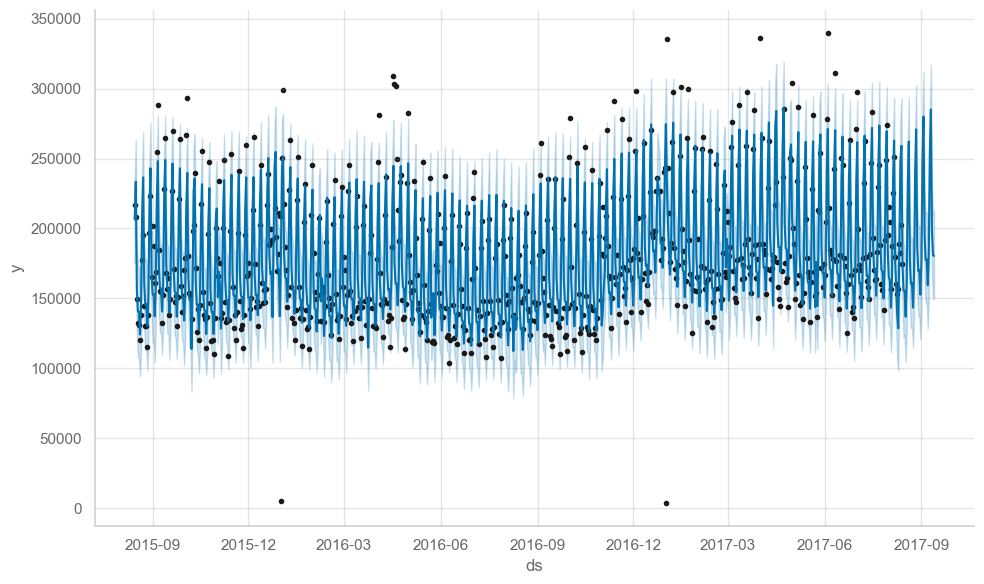

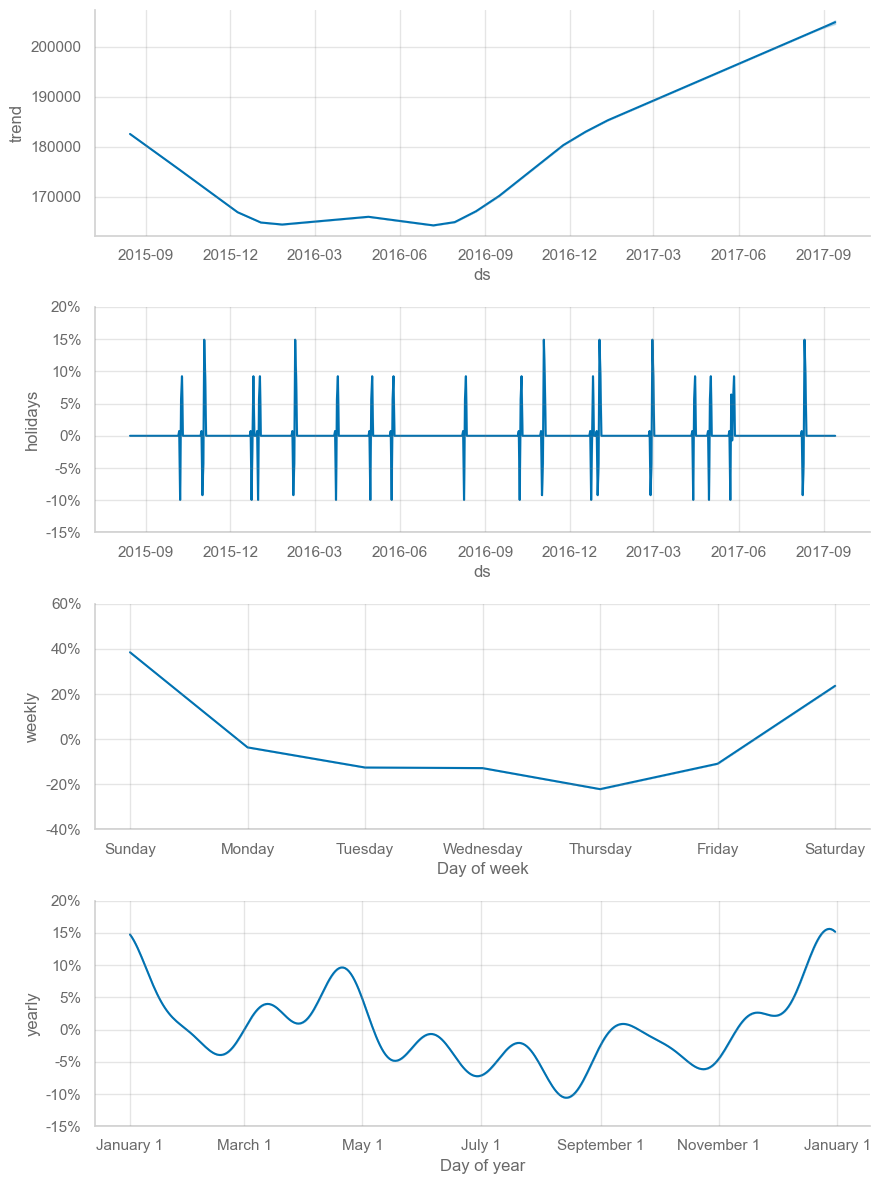

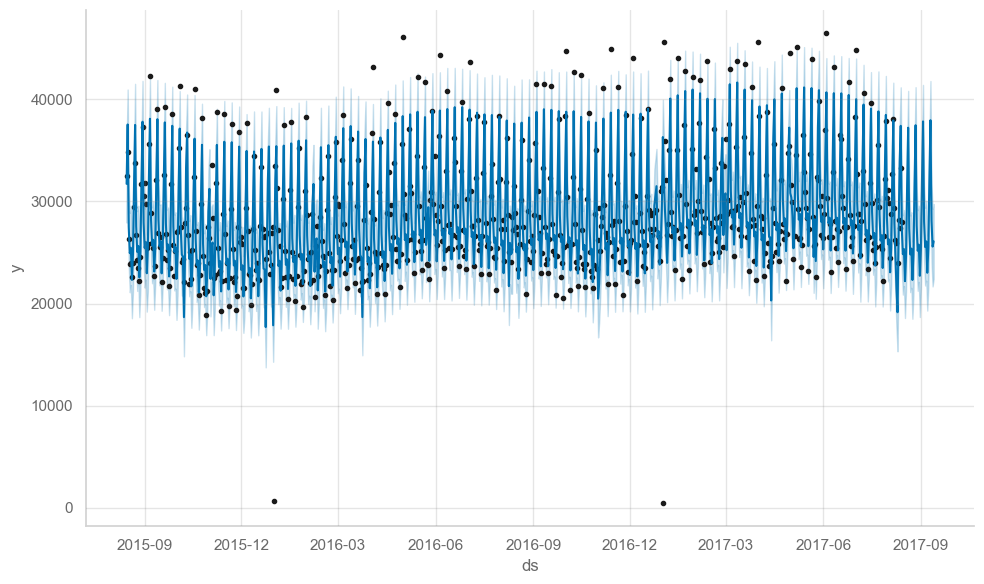

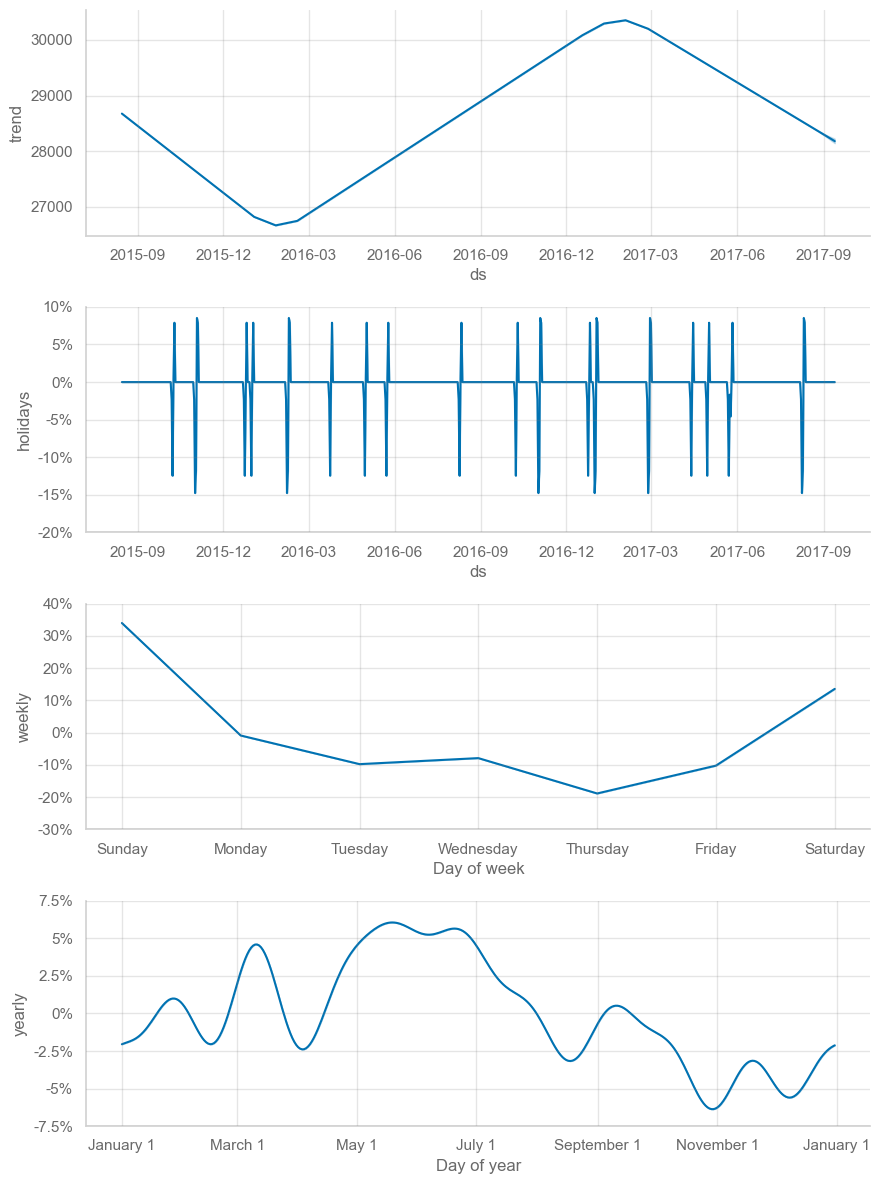

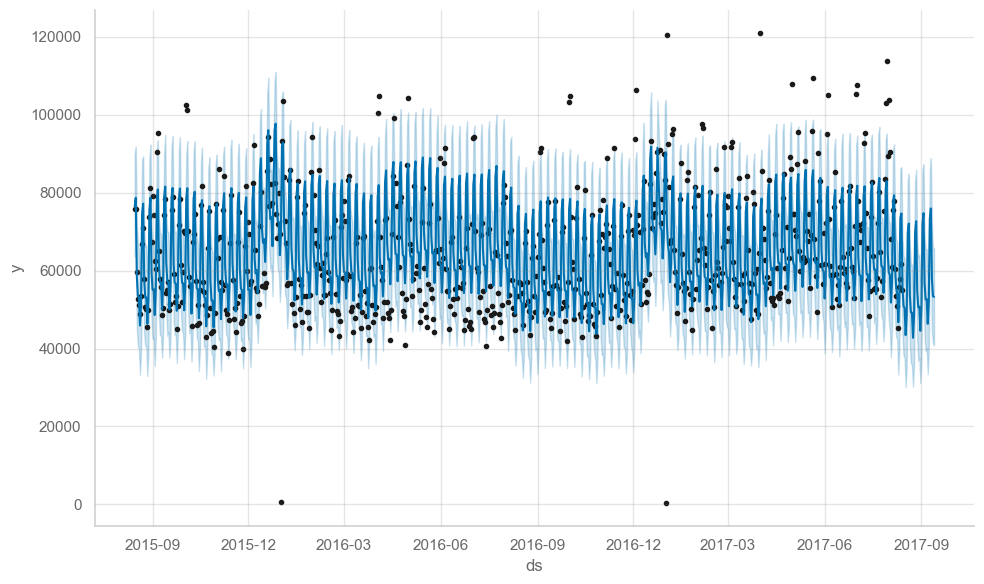

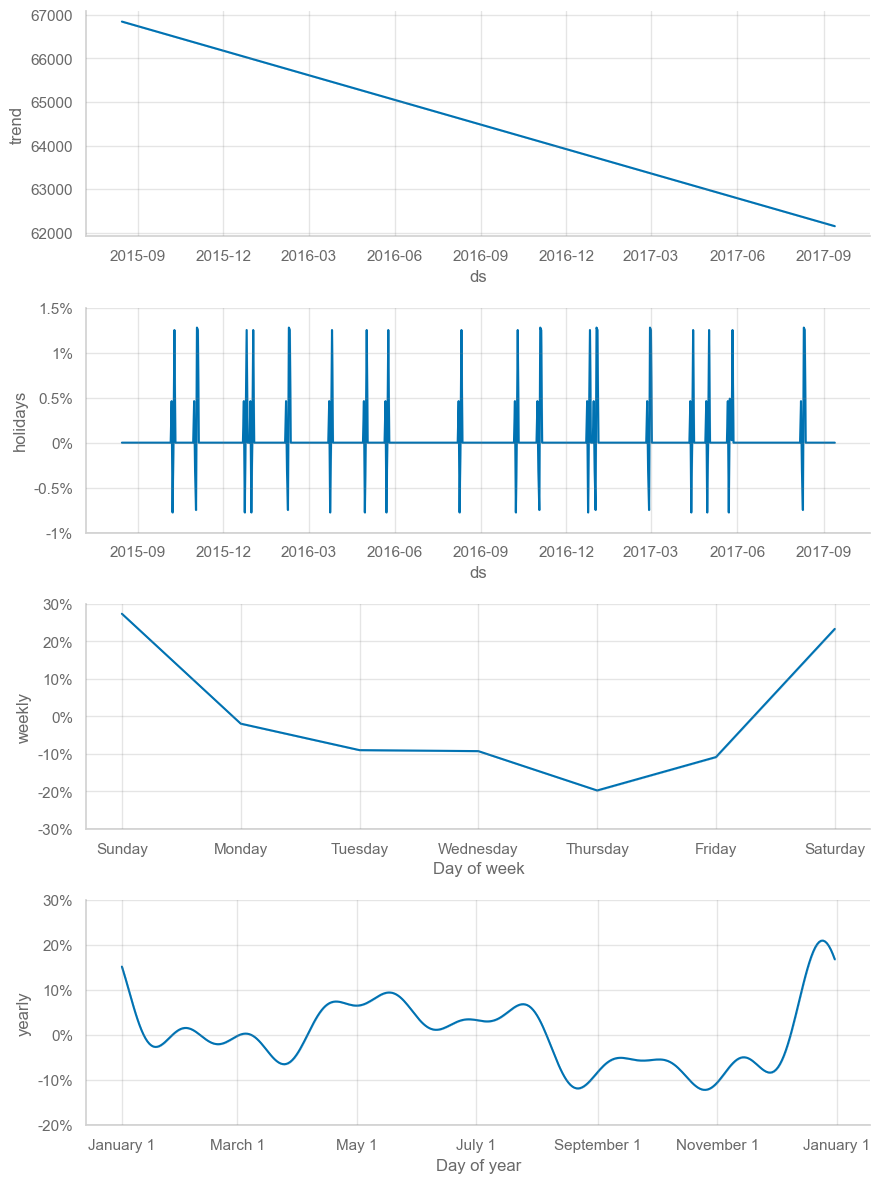

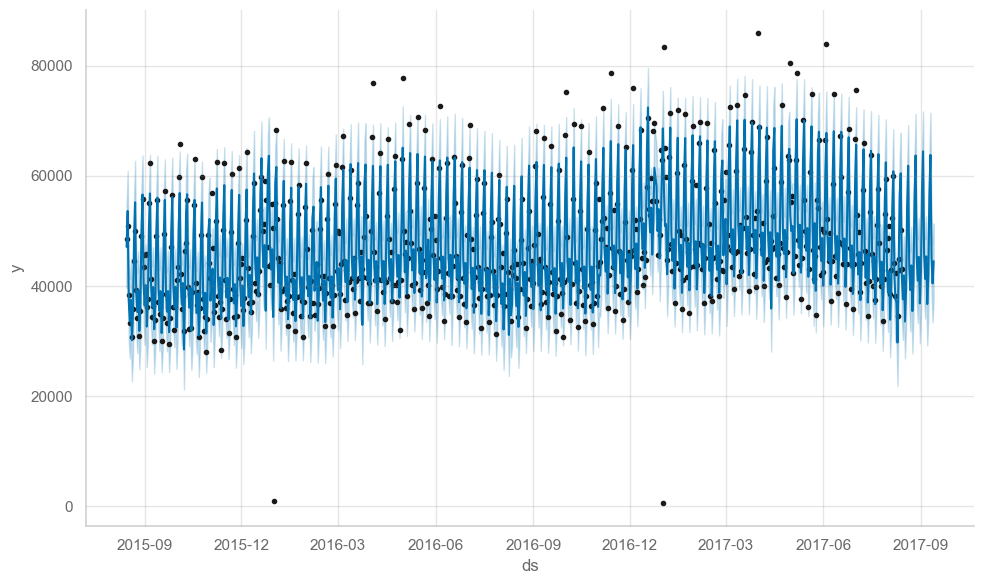

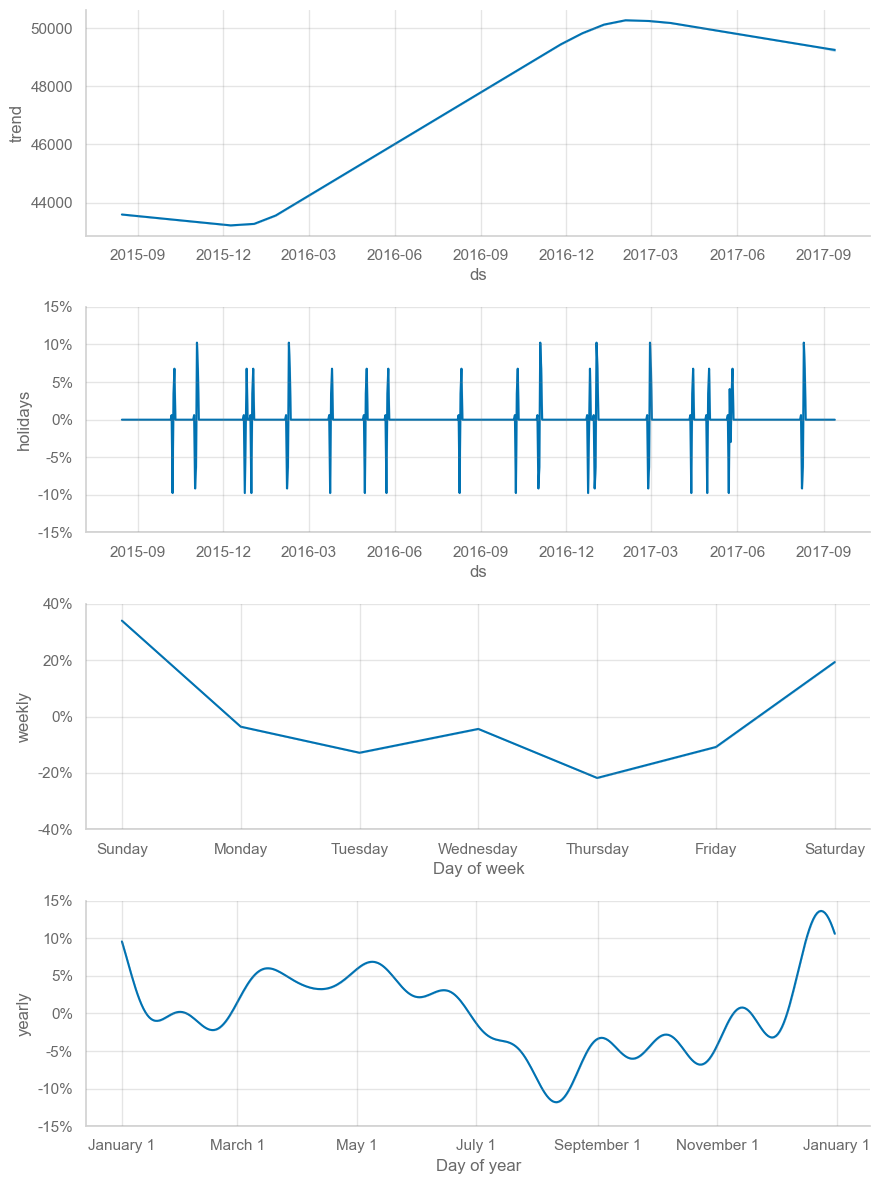

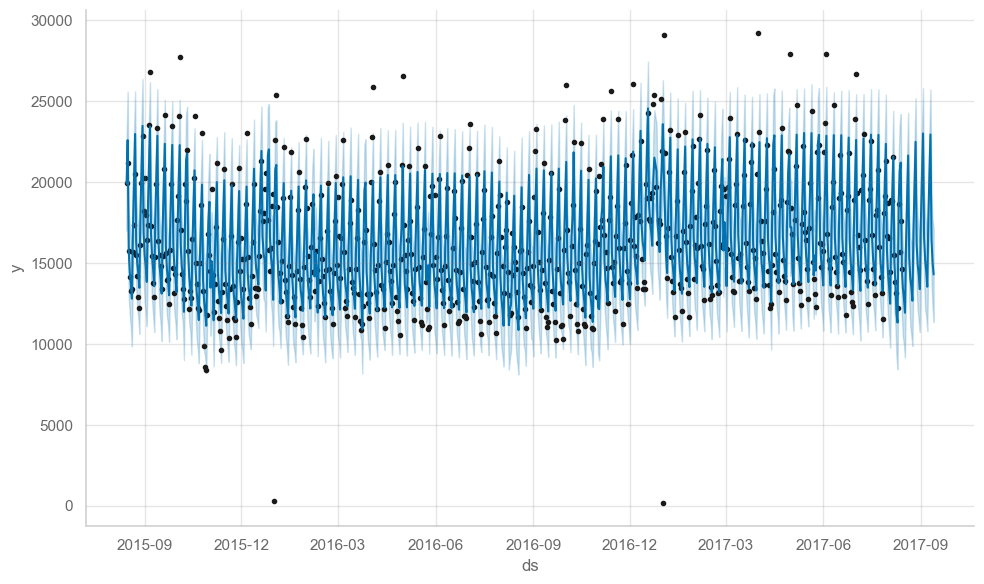

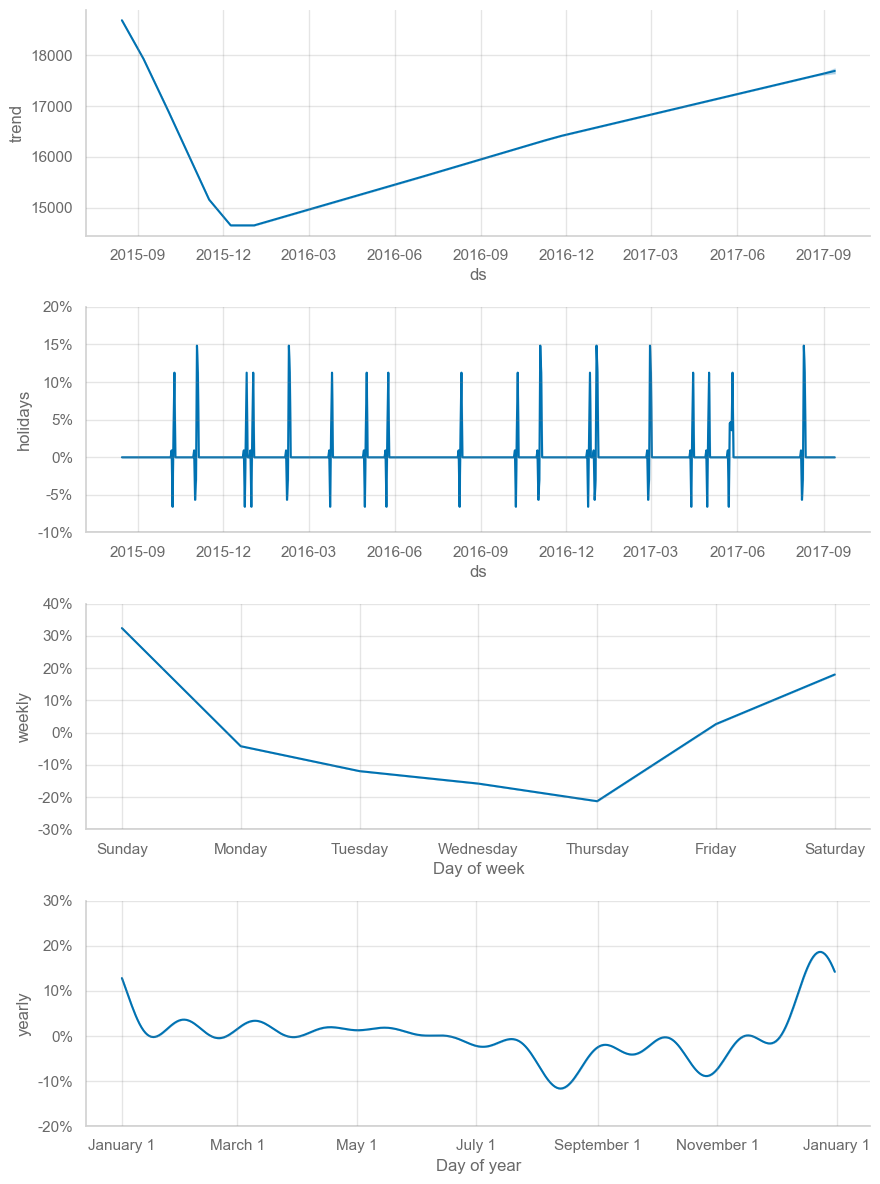

In [358]:
#PROPHET MODEL

forecasted_dfs = []

for feature in total_sales_df.columns[:5]:
    
    #formatting
    df_copy = total_sales_df[feature].copy().reset_index()
    df_copy.columns = ['ds','y']
    df_copy[['y']] = df_copy[['y']].apply(pd.to_numeric)

    df_copy['ds'] = pd.to_datetime(df_copy['ds'])
    
    df_copy_ = df_copy[df_copy['ds'] < forecast_start_date]
    
    #finding the right params_dict for this category
    params_dict = dicts[feature]
    
    #model
    m = Prophet(changepoint_prior_scale = dicts[feature]['changepoint_prior_scale'],
                seasonality_prior_scale = dicts[feature]['seasonality_prior_scale'],
                seasonality_mode = 'multiplicative',
                holidays=holiday
                 )
    
    m.fit(df_copy_)

    future = m.make_future_dataframe(periods=prediction_days)
    fcst_prophet_train = m.predict(future)
    
    fig1 = m.plot(fcst_prophet_train)
    
    fig2 = m.plot_components(fcst_prophet_train)


    forecasted_df = fcst_prophet_train[fcst_prophet_train['ds']>=forecast_start_date]
    
    forecasted_dfs.append(forecasted_df)